# This notebook uses transfer learning on the pre-trained Inception v3 model to classify mutations in TCGA-LUAD images

## We first define a few locations where results are saved.

In [22]:
import os, sys, json, shutil
from os.path import join
#deep_path = join(os.environ["HOME"],'DeepPATH')
deeppath_code = join(os.environ["HOME"],'DeepPATH/DeepPATH_code')
deeppath_data = '/mnt/disks/deeppath-data'
data_base = join(deeppath_data,'Data')
raw_images = join(data_base,'Raw')
data_labels = join(data_base,'data_labels')
#tilings = join(data_base,'tilings')
inception_checkpoints = join(deeppath_data,'inception_checkpoints')

for d in (deeppath_data, data_base, raw_images, inception_checkpoints):
  try:
    os.makedirs(d)
  except:
    print("{} exists".format(d))

/mnt/disks/deeppath-data exists
/mnt/disks/deeppath-data/Data exists
/mnt/disks/deeppath-data/Data/Raw exists
/mnt/disks/deeppath-data/inception_checkpoints exists


In [4]:
# Various GCS buckets and relevant defines
cgc_deeppath_bucket = 'cgc-deeppath' # Bucket containing users credentials
deeppath_data_bucket = 'deeppath-data-whc' # Bucket where results are saved

svs_images_bucket = 'imaging-west'# Bucket containing TCGA pathology images


# Specify tiling parameters
We place results into a tiling specific directory tree. The first five values below control the tiling. Change these to perform a different tiling.

In [5]:
tile_size = 299
overlap = 0
background = 25
jobs = 8
magnification = 20
tiling_params = "Px{}Ol{}Bg{}Mg{}_Tile".format(str(tile_size), str(overlap), str(background),str(magnification))
tiling = join(data_base, tiling_params)
tiling_logs = join(tiling,'logs')
# Directory where tiles are stored              
tiles = join(tiling,'tiles')
images_metadata = 'images_metadata.json' # Name of images metadata file  (which will be created below)
images_metadata_path = join(tiling, images_metadata) # Path to images metadata file
mutations_metadata = 'mutations_metadata.txt' # Name of mutation metadata file  (which will be created below)
mutations_metadata_path = join(tiling, mutations_metadata) # Path to metadata file
hugo_symbols_path = join(tiling, 'hugo_symbols.txt')

for d in (tiling, tiling_logs, tiles):
  try:
    os.makedirs(d)
  except:
    print("{} exists".format(d))

/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/tiles exists


# Specify sorting parameter
### Option 10 does not sort into separate groups (directories)

In [6]:
sorting_option = 10
#sortings = join(tiling, 'sortings')

sorting_params = 'So{}_Sort'.format(sorting_option)
sorting = join(tiling, sorting_params)
sorting_logs = join(sorting, 'logs')
sorted_tiles = join(sorting, 'sorted')
# Directories where sharded tensor flow formatted records are stored
trainValid_records = join(sorting, 'TFRecord_TrainValid')
test_records = join(sorting, 'TFRecord_Test')
for d in (sorting, sorting_logs, sorted_tiles, trainValid_records, test_records):
  try:
    os.makedirs(d)
  except:
    print("{} exists".format(d))

/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/sorted exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/TFRecord_TrainValid exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/TFRecord_Test exists


# Specify training, validation, test parameters

In [7]:
class_number = !cat $hugo_symbols_path |wc -l # Number of classes
class_number = int(class_number[0])
fine_tune = True

#trainings = join(sorting, "trainings")
training_params = "Cl{}Ft{}_Train".format(str(class_number),str(fine_tune))
training = join(sorting, training_params)
training_logs = join(training, 'logs')
training_mode = '1_sigmoid'

# Directory where intermediate training checkpoints are stored
intermediate_checkpoints = join(training, 'intermediate_checkpoints')
# Directory where validation and test results are stored
eval_results = join(training, 'eval_results')
test_results = join(training, 'test_results')
roc_curves = join(training, 'roc_curves')
heatmaps = join(training,'Px'+str(tile_size))

for d in (training, training_logs, intermediate_checkpoints,
         eval_results, test_results, roc_curves):
  try:
    os.makedirs(d)
  except:
    print("{} exists".format(d))

/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/Cl10FtTrue_Train exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/Cl10FtTrue_Train/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/Cl10FtTrue_Train/intermediate_checkpoints exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/Cl10FtTrue_Train/eval_results exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/Cl10FtTrue_Train/test_results exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/Cl10FtTrue_Train/roc_curves exists


# Get/Update DeepPATH code

In [7]:
import os
if not os.path.exists(deeppath_code):
    os.chdir(os.environ["HOME"])
    #!git clone https://github.com/ncoudray/DeepPATH.git
    !git clone -b whc1 https://github.com/bcli4d/DeepPATH.git
else:
    #!git pull https://github.com/ncoudray/DeepPATH.git
    !git -C $deeppath_code pull https://github.com/bcli4d/DeepPATH.git
        
sys.path.insert(0,deeppath_code)

Cloning into 'DeepPATH'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 2152 (delta 0), reused 5 (delta 0), pack-reused 2140
Receiving objects: 100% (2152/2152), 1.88 MiB | 0 bytes/s, done.
Resolving deltas: 100% (1266/1266), done.


# Get metadata from BQ
Rather than obtain metdata from the GDC, we perform an SQL query to obtain the names of LUAD images and mutation metadata. 
### We must first establish credentials. 
See https://cloud.google.com/bigquery/docs/quickstarts/quickstart-client-libraries#bigquery_simple_app_query-python for help. Put your credentials in some GCS bucket and modify the "bucket" and "credentials" variables below as necessary

In [4]:
from gcs_access import upload_from_GCS
bucket = 'cgc-deeppath'                                                                                         
credentials = 'GAC.json' 
upload_from_GCS(bucket, credentials, "/tmp/GAC.json")
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/tmp/GAC.json"

Blob GAC.json uploaded to /tmp/GAC.json.


### Now perform a BQ query to get metadata. 
For this purpose, we call query_bq() in which the needed SQL is hardcoded. query_bq() also formats the returned data in the format expected by the tiling and sorting phases.

In [5]:
from get_metadata_from_bq import query_mutation_metadata

sql_query = """
    WITH
      luads AS (
      SELECT
        t1.file_gdc_id AS file_gdc_id,
        t1.svsFilename AS svsFilename,
        t1.sample_barcode 
        AS sample_barcode,
        t2.callerName AS callerName,
        t2.Hugo_Symbol AS Hugo_Symbol
      FROM
        `isb-cgc.metadata.TCGA_slide_images` t1
      INNER JOIN
        `isb-cgc.TCGA_hg38_data_v0.Somatic_Mutation_DR10` t2
      ON
        t1.sample_barcode = t2.sample_barcode_tumor
      WHERE
        (t2.project_short_name='TCGA-LUAD')
        AND NOT t1.slide_barcode LIKE '%TCGA-__-____-___-__-D%'),
      mutations AS (
      SELECT
        file_gdc_id,
        svsFilename,
        sample_barcode,
        Hugo_Symbol
      FROM
        luads
      WHERE
        callerName LIKE '%mutect%'
        AND Hugo_Symbol IN ('EGFR',
          'FAT1',
          'FAT4',
          'KEAP1',
          'KRAS',
          'LRP1B',
          'NF1',
          'SETBP1',
          'STK11',
          'TP53')),
      wts AS (
      SELECT
        file_gdc_id,
        svsFilename,
        sample_barcode,
        'WT' AS Hugo_Symbol
      FROM
        luads
      WHERE
        sample_barcode not in (
          select sample_barcode
          from mutations))
    SELECT
      file_gdc_id,
      svsFilename,
      sample_barcode,
      Hugo_Symbol
    FROM
      mutations
    UNION DISTINCT
    SELECT
      file_gdc_id,
      svsFilename,
      sample_barcode,
      Hugo_Symbol
    FROM
      wts
    ORDER BY
      sample_barcode, Hugo_Symbol 
  """

query_mutation_metadata(images_metadata_path, mutations_metadata_path, hugo_symbols_path, sql_query)


# Tile the images listed in the manifest
Images are uploaded, on at a time, from GCS and tiled according to parameters

### Optionally load previously saved results from GCS

In [51]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, tiling_params,'data.tar')
loc = join(tiling,'data.tar')

result = !gsutil ls $gcs
if result[0] ==gcs:
    !gsutil -m cp $gcs $loc 

    with tarfile.open(loc) as tar:
        tar.extractall()

    !rm $loc
else:
    print('{} not found'.format(loc))

('gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/data.tar.gz', '/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/data.tar.gz')
Found


## Perform tiling

In [ ]:
import json
import shutil
tiler = join(deeppath_code, '00_preprocessing/0b_tileLoop_deepzoom4.py')
out_log_file = join(tiling_logs,'tiler_out.log')
err_log_file = join(tiling_logs,'tiler_err.log')
!rm $out_log_file
!rm $err_log_file
!rm $raw_images/*
skipped_file_name = ""
skipped_file_id = ""
with open(images_metadata_path) as fid:
    jdata = json.loads(fid.read())
    jdata.sort(key = lambda x: x['file_name'])
    for file in jdata:
        print("")
        print("Checking {}".format(file))
        tiled_dziname = join(tiles,file['file_name'].rsplit('.',1)[0]+'.dzi')
        tiled_filesname = join(tiles,file['file_name'].rsplit('.',1)[0]+'_files')
        
        if os.path.exists(tiled_dziname):
            # If the .dzi file exists, then we presume that tiling was completed
            skipped_file_name = file['file_name']
            skipped_file_id = file['file_id']
            print("Skipping {}".format(file['file_name']))
        else:
            print("Processing {}".format(file['file_name']))
            if os.path.exists(tiled_filesname):
                # Apparently this file was only partially tiled, so delete it completely
                print ("removing {}".format(tiled_filesname))
                shutil.rmtree(tiled_filesname)
            GCS_filename = 'gs://'+join(svs_images_bucket,file['file_id'],file['file_name'])
            local_filename = join(raw_images,file['file_name'])
            oldstderr = sys.stderr
            sys.stderr = open(err_log_file, 'a')
            oldstdout = sys.stdout
            sys.stdout = open(out_log_file, 'a')
            !gsutil -m cp $GCS_filename $local_filename
            !python $tiler --output=$tiles --Mag=$magnification \
                --size=$tile_size --overlap=$overlap --Background=$background --jobs=$jobs \
                $raw_images/*svs
            #print("gsutil -m cp {} {}".format(GCS_filename, local_filename))
            !rm $local_filename
            sys.stderr = oldstderr
            sys.stdout = oldstdout


### Optionally save tiling results to GCS

In [5]:
import tarfile

# Populate the tar file. Don't try to compress.
loc = join(tiling,'data.tar')
with tarfile.open(loc, "w") as tar:
    for name in [tiles, tiling_logs]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket,tiling_params,'data.tar')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/data.tar.gz [Content-Type=application/x-tar]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1/1 files][ 30.9 GiB/ 30.9 GiB] 100% Done  84.1 MiB/s ETA 00:00:00           
Operation completed over 1 objects/30.9 GiB.                                     


# Sort tiles


### Optionally load previously saved sorting results from GCS

In [67]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, tiling_params, sorting_params, 'data.tar.gz')
loc = join(sorting,'data.tar.gz')

result = !gsutil ls $gcs
if result[0] == gcs:
    !gsutil -m cp $gcs $loc 
    
    !ls -l $loc
    with tarfile.open(loc) as tar:
        tar.extractall('/')

    !rm $loc
else:
    print('{} not found'.format(gcs))

Copying gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/So3_Sort/data.tar.gz...
\ [1/1 files][  5.8 GiB/  5.8 GiB] 100% Done  73.8 MiB/s ETA 00:00:00           
Operation completed over 1 objects/5.8 GiB.                                      
-rw-r--r-- 1 bcliffor bcliffor 6178730916 Apr 22 19:58 /mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/data.tar.gz


## Perform the sort

In [7]:
# The sort routine outputs to the cwd. So change cwd as needed.
# First, remove existing sort results
try:
    shutil.rmtree(sorted_tiles)
except:
    pass
os.mkdir(sorted_tiles)
cwd = os.getcwd()
os.chdir(sorted_tiles)

func = join(deeppath_code,'00_preprocessing/0d_SortTiles.py' )
root = func.rsplit('/',1)[1].split('.')[0]

out_log_file = join(sorting_logs,root+'.out.log')
err_log_file = join(sorting_logs,root+'.err.log')
oldstderr = sys.stderr
sys.stderr = open(err_log_file, 'w')
oldstdout = sys.stdout
sys.stdout = open(out_log_file, 'w')

%xmode Verbose

try:
    !python $func --SourceFolder=$tiles --JsonFile=$images_metadata_path --PercentValid=15 --PercentTest=15 \
        --PatientID=12 --Magnification=$magnification --MagDiffAllowed=0.0 --SortingOption=$sorting_option --nSplit=0
except:
    pass
finally:
    sys.stderr = oldstderr
    sys.stdout = oldstdout
    os.chdir(cwd)


# Convert the JPEG tiles into TFRecord format for the multiple mutations
## First format the training and validation data

In [9]:
# Remove existing TFRecord conversion results
try:
    shutil.rmtree(trainValid_records)
except:
    pass
os.mkdir(trainValid_records)

func = join(deeppath_code,'00_preprocessing/TFRecord_multi_Classes/build_image_data_multiClass.py' )
root = func.rsplit('/',1)[1].split('.')[0]
out_log_file = join(sorting_logs,root+'.train.out.log')
err_log_file = join(sorting_logs,root+'.train.err.log')
oldstderr = sys.stderr
sys.stderr = open(err_log_file, 'w')
oldstdout = sys.stdout
sys.stdout = open(out_log_file, 'w')

try:
    !python $func --directory=$sorted_tiles/tiles --output_directory=$trainValid_records --train_shards=1024 \
        --validation_shards=128 --num_threads=4  --labels_names=$hugo_symbols_path --labels=$mutations_metadata_path \
        --PatientID=12
except:
    pass
finally:
    sys.stderr = oldstderr
    sys.stdout = oldstdout


## Now format the test data

In [10]:
# Remove existing TFRecord conversion results
try:
    shutil.rmtree(test_records)
except:
    pass
os.mkdir(test_records)

func = join(deeppath_code,'00_preprocessing/TFRecord_multi_Classes/build_TF_test_multiClass.py' )
root = func.rsplit('/',1)[1].split('.')[0]
out_log_file = join(sorting_logs,root+'.test.out.log')
err_log_file = join(sorting_logs,root+'.test.err.log')
oldstderr = sys.stderr
sys.stderr = open(err_log_file, 'w')
oldstdout = sys.stdout
sys.stdout = open(out_log_file, 'w')

try:
    !python $func --directory=$sorted_tiles/tiles --output_directory=$test_records --train_shards=1024 \
        --validation_shards=128 --num_threads=1  --one_FT_per_Tile=False --ImageSet_basename='test' \
        --labels_names=$hugo_symbols_path --labels=$mutations_metadata_path \
        --PatientID=12
except:
    pass
finally:
    sys.stderr = oldstderr
    sys.stdout = oldstdout


## Optionally save sorting results to GCS

In [21]:
import tarfile

# Populate the tar file
loc = join(sorting,'data.tar')
with tarfile.open(loc, "w") as tar:
    #for name in [sorting_logs, sorted_tiles, trainValid_records, test_records]:
    for name in [trainValid_records, test_records]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket,tiling_params, sorting_params, 'data.tar')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/data.tar [Content-Type=application/x-tar]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1/1 files][ 31.1 GiB/ 31.1 GiB] 100% Done  70.6 MiB/s ETA 00:00:00           
Operation completed over 1 objects/31.1 GiB.                                     


# Training

## Optionally load previously saved training results from GCS

In [70]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, tiling_params, sorting_params, training_params, 'data.tar.gz')
loc = join(training,'data.tar.gz')

result = !gsutil ls $gcs
if result[0] ==gcs:
    !gsutil -m cp $gcs $loc 

    with tarfile.open(loc) as tar:
        tar.extractall('/')

    !rm $loc
else:
    print('{} not found'.format(gcs))

gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/data.tar.gz not found


## We first have to install the Bazel build tool

In [ ]:
!sudo apt-get install -y pkg-config zip g++ zlib1g-dev unzip python
!wget https://github.com/bazelbuild/bazel/releases/download/0.24.0/bazel-0.24.0-installer-linux-x86_64.sh
!chmod +x bazel-0.24.0-installer-linux-x86_64.sh
!./bazel-0.24.0-installer-linux-x86_64.sh --user
os.environ["PATH"] += ":" + join(os.getcwd(),'bin')
!rm bazel-0.24.0-installer-linux-x86_64.sh


## Next build the Inception model

In [ ]:
#os.chdir(join(os.environ["HOME"],'DeepPATH/DeepPATH_code/s01_training/xClasses'))
cwd = os.getcwd()
os.chdir(join(deeppath_code,'01_training/xClasses'))
print(os.getcwd())
!bazel build inception/imagenet_train


## Train using transfer learning
### Start by getting the Inception V3 checkpoint

In [16]:
cwd = os.getcwd()
os.chdir(inception_checkpoints)
checkpoint = "inception-v3-2016-03-01.tar.gz"
!curl -O http://download.tensorflow.org/models/image/imagenet/inception-v3-2016-03-01.tar.gz
!tar -xvf $checkpoint
!rm $checkpoint
os.chdir(cwd)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  380M  100  380M    0     0  30.5M      0  0:00:12  0:00:12 --:--:-- 37.5M
inception-v3/
inception-v3/checkpoint
inception-v3/README.txt
inception-v3/model.ckpt-157585


## Now perform transfer learning

In [ ]:
function = join(deeppath_code,'01_training/xClasses/bazel-bin/inception/imagenet_train' )
root = function.rsplit('/',1)[1]
# Note that the --train_dir directory appears to be deleted and recreated
!python $function \
    --num_gpus=1 --batch_size=30 --train_dir=$intermediate_checkpoints --data_dir=$trainValid_records \
    --pretrained_model_checkpoint_path=$inception_checkpoints/inception-v3/model.ckpt-157585 \
        --fine_tune=True --initial_learning_rate=0.001  --ClassNumber=$class_number --mode=$training_mode

!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Colocations handled automatically by placer.
!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct 

2019-05-15 04:51:36.544828: step 10, loss = 1.16 (22.9 examples/sec; 1.309 sec/batch)
2019-05-15 04:51:49.492173: step 20, loss = 1.06 (22.8 examples/sec; 1.315 sec/batch)
2019-05-15 04:52:02.426283: step 30, loss = 1.01 (23.3 examples/sec; 1.289 sec/batch)
2019-05-15 04:52:15.288465: step 40, loss = 0.98 (23.4 examples/sec; 1.281 sec/batch)
2019-05-15 04:52:28.187638: step 50, loss = 0.90 (23.3 examples/sec; 1.288 sec/batch)
2019-05-15 04:52:41.208291: step 60, loss = 0.89 (23.6 examples/sec; 1.269 sec/batch)
2019-05-15 04:52:54.093467: step 70, loss = 0.82 (23.4 examples/sec; 1.284 sec/batch)
2019-05-15 04:53:07.119852: step 80, loss = 0.86 (22.9 examples/sec; 1.311 sec/batch)
2019-05-15 04:53:20.098540: step 90, loss = 0.87 (23.3 examples/sec; 1.290 sec/batch)
2019-05-15 04:53:33.033179: step 100, loss = 0.84 (23.8 examples/sec; 1.260 sec/batch)
2019-05-15 04:53:50.982666: step 110, loss = 0.88 (23.4 examples/sec; 1.283 sec/batch)
2019-05-15 04:54:03.795526: step 120, loss = 0.90 (2

2019-05-15 05:12:44.712644: step 960, loss = 0.88 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 05:12:57.580319: step 970, loss = 0.88 (23.3 examples/sec; 1.289 sec/batch)
2019-05-15 05:13:10.636477: step 980, loss = 0.81 (23.3 examples/sec; 1.287 sec/batch)
2019-05-15 05:13:23.620778: step 990, loss = 0.89 (21.9 examples/sec; 1.373 sec/batch)
2019-05-15 05:13:36.579077: step 1000, loss = 0.96 (23.6 examples/sec; 1.272 sec/batch)
2019-05-15 05:13:54.081415: step 1010, loss = 0.85 (23.0 examples/sec; 1.307 sec/batch)
2019-05-15 05:14:07.067690: step 1020, loss = 0.88 (23.1 examples/sec; 1.298 sec/batch)
2019-05-15 05:14:19.944687: step 1030, loss = 0.89 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 05:14:32.884521: step 1040, loss = 0.82 (23.1 examples/sec; 1.299 sec/batch)
2019-05-15 05:14:45.673777: step 1050, loss = 0.84 (23.9 examples/sec; 1.254 sec/batch)
2019-05-15 05:14:58.655360: step 1060, loss = 0.89 (21.6 examples/sec; 1.388 sec/batch)
2019-05-15 05:15:11.453715: step 107

2019-05-15 05:33:38.828988: step 1900, loss = 0.90 (21.6 examples/sec; 1.386 sec/batch)
2019-05-15 05:33:56.375459: step 1910, loss = 0.88 (23.5 examples/sec; 1.279 sec/batch)
2019-05-15 05:34:09.182972: step 1920, loss = 0.90 (23.5 examples/sec; 1.278 sec/batch)
2019-05-15 05:34:22.058192: step 1930, loss = 0.83 (23.3 examples/sec; 1.290 sec/batch)
2019-05-15 05:34:34.943829: step 1940, loss = 0.86 (23.4 examples/sec; 1.281 sec/batch)
2019-05-15 05:34:47.981901: step 1950, loss = 0.83 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 05:35:00.787552: step 1960, loss = 0.87 (23.0 examples/sec; 1.304 sec/batch)
2019-05-15 05:35:13.702800: step 1970, loss = 0.85 (23.2 examples/sec; 1.292 sec/batch)
2019-05-15 05:35:26.392076: step 1980, loss = 0.92 (23.5 examples/sec; 1.277 sec/batch)
2019-05-15 05:35:39.276742: step 1990, loss = 0.83 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 05:35:52.264038: step 2000, loss = 0.90 (23.6 examples/sec; 1.271 sec/batch)
2019-05-15 05:36:09.658055: step

2019-05-15 05:54:38.858551: step 2840, loss = 0.88 (23.5 examples/sec; 1.277 sec/batch)
2019-05-15 05:54:51.801462: step 2850, loss = 0.89 (23.2 examples/sec; 1.291 sec/batch)
2019-05-15 05:55:04.641431: step 2860, loss = 0.95 (23.2 examples/sec; 1.291 sec/batch)
2019-05-15 05:55:17.392489: step 2870, loss = 0.87 (23.6 examples/sec; 1.271 sec/batch)
2019-05-15 05:55:30.192024: step 2880, loss = 0.81 (23.3 examples/sec; 1.288 sec/batch)
2019-05-15 05:55:43.197468: step 2890, loss = 0.83 (23.3 examples/sec; 1.289 sec/batch)
2019-05-15 05:55:56.026657: step 2900, loss = 0.82 (23.5 examples/sec; 1.277 sec/batch)
2019-05-15 05:56:13.228430: step 2910, loss = 0.80 (23.7 examples/sec; 1.265 sec/batch)
2019-05-15 05:56:26.150929: step 2920, loss = 0.85 (23.5 examples/sec; 1.276 sec/batch)
2019-05-15 05:56:39.073528: step 2930, loss = 0.80 (23.5 examples/sec; 1.279 sec/batch)
2019-05-15 05:56:51.918565: step 2940, loss = 0.90 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 05:57:04.789756: step

2019-05-15 06:15:33.052544: step 3780, loss = 0.84 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 06:15:45.857713: step 3790, loss = 0.85 (22.6 examples/sec; 1.329 sec/batch)
2019-05-15 06:15:58.834568: step 3800, loss = 0.82 (23.1 examples/sec; 1.297 sec/batch)
2019-05-15 06:16:16.319254: step 3810, loss = 0.83 (23.4 examples/sec; 1.282 sec/batch)
2019-05-15 06:16:29.122187: step 3820, loss = 0.85 (23.3 examples/sec; 1.285 sec/batch)
2019-05-15 06:16:42.115908: step 3830, loss = 0.92 (21.9 examples/sec; 1.373 sec/batch)
2019-05-15 06:16:54.874139: step 3840, loss = 0.82 (23.2 examples/sec; 1.294 sec/batch)
2019-05-15 06:17:07.870196: step 3850, loss = 0.92 (23.5 examples/sec; 1.279 sec/batch)
2019-05-15 06:17:20.645116: step 3860, loss = 0.82 (23.6 examples/sec; 1.269 sec/batch)
2019-05-15 06:17:33.525252: step 3870, loss = 0.76 (23.5 examples/sec; 1.279 sec/batch)
2019-05-15 06:17:46.398763: step 3880, loss = 0.82 (21.7 examples/sec; 1.382 sec/batch)
2019-05-15 06:17:59.320753: step

2019-05-15 06:36:28.403419: step 4720, loss = 0.87 (21.7 examples/sec; 1.381 sec/batch)
2019-05-15 06:36:41.559295: step 4730, loss = 0.83 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 06:36:54.508525: step 4740, loss = 0.91 (23.2 examples/sec; 1.293 sec/batch)
2019-05-15 06:37:07.502338: step 4750, loss = 0.87 (23.4 examples/sec; 1.282 sec/batch)
2019-05-15 06:37:20.415781: step 4760, loss = 0.84 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 06:37:33.347736: step 4770, loss = 0.89 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 06:37:46.370456: step 4780, loss = 0.85 (23.6 examples/sec; 1.271 sec/batch)
2019-05-15 06:37:59.392923: step 4790, loss = 0.82 (22.6 examples/sec; 1.327 sec/batch)
2019-05-15 06:38:12.354662: step 4800, loss = 0.81 (22.3 examples/sec; 1.347 sec/batch)
2019-05-15 06:38:30.042815: step 4810, loss = 0.85 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 06:38:43.094022: step 4820, loss = 0.85 (22.3 examples/sec; 1.346 sec/batch)
2019-05-15 06:38:56.126436: step

2019-05-15 06:57:40.779875: step 5660, loss = 0.80 (23.4 examples/sec; 1.279 sec/batch)
2019-05-15 06:57:53.731729: step 5670, loss = 0.86 (22.9 examples/sec; 1.310 sec/batch)
2019-05-15 06:58:06.817125: step 5680, loss = 0.90 (21.6 examples/sec; 1.390 sec/batch)
2019-05-15 06:58:19.598138: step 5690, loss = 0.86 (23.6 examples/sec; 1.274 sec/batch)
2019-05-15 06:58:32.622180: step 5700, loss = 0.82 (23.1 examples/sec; 1.297 sec/batch)
2019-05-15 06:58:50.037221: step 5710, loss = 0.85 (22.7 examples/sec; 1.323 sec/batch)
2019-05-15 06:59:03.126174: step 5720, loss = 0.93 (23.1 examples/sec; 1.296 sec/batch)
2019-05-15 06:59:16.050243: step 5730, loss = 0.87 (23.0 examples/sec; 1.304 sec/batch)
2019-05-15 06:59:29.190644: step 5740, loss = 0.86 (23.4 examples/sec; 1.284 sec/batch)
2019-05-15 06:59:42.104635: step 5750, loss = 0.86 (23.0 examples/sec; 1.305 sec/batch)
2019-05-15 06:59:55.252705: step 5760, loss = 0.79 (23.1 examples/sec; 1.299 sec/batch)
2019-05-15 07:00:08.312416: step

2019-05-15 07:18:49.982076: step 6600, loss = 0.82 (23.2 examples/sec; 1.294 sec/batch)
2019-05-15 07:19:07.486330: step 6610, loss = 0.81 (23.4 examples/sec; 1.283 sec/batch)
2019-05-15 07:19:20.434658: step 6620, loss = 0.82 (23.1 examples/sec; 1.299 sec/batch)
2019-05-15 07:19:33.516011: step 6630, loss = 0.86 (23.0 examples/sec; 1.304 sec/batch)
2019-05-15 07:19:46.484393: step 6640, loss = 0.82 (22.8 examples/sec; 1.318 sec/batch)
2019-05-15 07:19:59.700360: step 6650, loss = 0.80 (23.2 examples/sec; 1.294 sec/batch)
2019-05-15 07:20:12.819051: step 6660, loss = 0.80 (22.8 examples/sec; 1.315 sec/batch)
2019-05-15 07:20:26.002713: step 6670, loss = 0.83 (23.3 examples/sec; 1.287 sec/batch)
2019-05-15 07:20:38.969920: step 6680, loss = 0.80 (23.1 examples/sec; 1.299 sec/batch)
2019-05-15 07:20:51.947103: step 6690, loss = 0.74 (22.9 examples/sec; 1.308 sec/batch)
2019-05-15 07:21:04.985675: step 6700, loss = 0.80 (23.1 examples/sec; 1.297 sec/batch)
2019-05-15 07:21:22.693295: step

2019-05-15 07:40:04.394471: step 7540, loss = 0.78 (22.8 examples/sec; 1.314 sec/batch)
2019-05-15 07:40:17.525176: step 7550, loss = 0.84 (23.4 examples/sec; 1.283 sec/batch)
2019-05-15 07:40:30.477917: step 7560, loss = 0.80 (23.2 examples/sec; 1.293 sec/batch)
2019-05-15 07:40:43.430868: step 7570, loss = 0.88 (23.0 examples/sec; 1.305 sec/batch)
2019-05-15 07:40:56.512686: step 7580, loss = 0.80 (22.8 examples/sec; 1.316 sec/batch)
2019-05-15 07:41:09.679939: step 7590, loss = 0.81 (23.4 examples/sec; 1.283 sec/batch)
2019-05-15 07:41:22.721670: step 7600, loss = 0.78 (23.4 examples/sec; 1.281 sec/batch)
2019-05-15 07:41:40.175774: step 7610, loss = 0.77 (23.3 examples/sec; 1.290 sec/batch)
2019-05-15 07:41:53.325980: step 7620, loss = 0.84 (22.9 examples/sec; 1.312 sec/batch)
2019-05-15 07:42:06.222228: step 7630, loss = 0.79 (23.4 examples/sec; 1.284 sec/batch)
2019-05-15 07:42:19.458308: step 7640, loss = 0.93 (22.6 examples/sec; 1.325 sec/batch)
2019-05-15 07:42:32.601568: step

2019-05-15 08:01:11.325290: step 8480, loss = 0.79 (23.0 examples/sec; 1.303 sec/batch)
2019-05-15 08:01:24.236500: step 8490, loss = 0.75 (23.5 examples/sec; 1.279 sec/batch)
2019-05-15 08:01:37.086756: step 8500, loss = 0.83 (23.9 examples/sec; 1.254 sec/batch)
2019-05-15 08:01:54.874404: step 8510, loss = 0.80 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 08:02:07.715841: step 8520, loss = 0.75 (23.2 examples/sec; 1.291 sec/batch)
2019-05-15 08:02:20.779665: step 8530, loss = 0.78 (21.4 examples/sec; 1.401 sec/batch)
2019-05-15 08:02:33.749486: step 8540, loss = 0.84 (23.3 examples/sec; 1.286 sec/batch)
2019-05-15 08:02:46.703992: step 8550, loss = 0.82 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 08:02:59.626787: step 8560, loss = 0.80 (23.1 examples/sec; 1.298 sec/batch)
2019-05-15 08:03:12.495210: step 8570, loss = 0.84 (23.3 examples/sec; 1.289 sec/batch)
2019-05-15 08:03:25.366577: step 8580, loss = 0.87 (23.2 examples/sec; 1.295 sec/batch)
2019-05-15 08:03:38.140931: step

2019-05-15 08:22:06.490310: step 9420, loss = 0.79 (21.9 examples/sec; 1.367 sec/batch)
2019-05-15 08:22:19.397688: step 9430, loss = 0.79 (22.8 examples/sec; 1.316 sec/batch)
2019-05-15 08:22:32.223453: step 9440, loss = 0.77 (23.7 examples/sec; 1.265 sec/batch)
2019-05-15 08:22:45.192580: step 9450, loss = 0.82 (23.6 examples/sec; 1.269 sec/batch)
2019-05-15 08:22:57.932244: step 9460, loss = 0.82 (23.9 examples/sec; 1.257 sec/batch)
2019-05-15 08:23:10.797077: step 9470, loss = 0.84 (23.9 examples/sec; 1.256 sec/batch)
2019-05-15 08:23:23.517666: step 9480, loss = 0.82 (23.5 examples/sec; 1.278 sec/batch)
2019-05-15 08:23:36.277349: step 9490, loss = 0.76 (23.0 examples/sec; 1.305 sec/batch)
2019-05-15 08:23:49.002017: step 9500, loss = 0.84 (23.5 examples/sec; 1.276 sec/batch)
2019-05-15 08:24:06.659426: step 9510, loss = 0.85 (21.8 examples/sec; 1.375 sec/batch)
2019-05-15 08:24:19.641289: step 9520, loss = 0.82 (23.4 examples/sec; 1.282 sec/batch)
2019-05-15 08:24:32.533780: step

2019-05-15 08:42:46.935221: step 10350, loss = 0.84 (23.1 examples/sec; 1.299 sec/batch)
2019-05-15 08:42:59.761993: step 10360, loss = 0.81 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 08:43:12.542676: step 10370, loss = 0.86 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 08:43:25.406788: step 10380, loss = 0.78 (23.8 examples/sec; 1.262 sec/batch)
2019-05-15 08:43:38.283569: step 10390, loss = 0.84 (22.8 examples/sec; 1.316 sec/batch)
2019-05-15 08:43:51.264649: step 10400, loss = 0.80 (23.2 examples/sec; 1.291 sec/batch)
2019-05-15 08:44:08.476271: step 10410, loss = 0.80 (23.3 examples/sec; 1.286 sec/batch)
2019-05-15 08:44:21.334795: step 10420, loss = 0.78 (23.5 examples/sec; 1.274 sec/batch)
2019-05-15 08:44:34.105853: step 10430, loss = 0.82 (23.3 examples/sec; 1.286 sec/batch)
2019-05-15 08:44:47.039264: step 10440, loss = 0.83 (21.6 examples/sec; 1.387 sec/batch)
2019-05-15 08:44:59.920873: step 10450, loss = 0.76 (21.7 examples/sec; 1.385 sec/batch)
2019-05-15 08:45:12.6

2019-05-15 09:03:19.898656: step 11280, loss = 0.87 (23.5 examples/sec; 1.276 sec/batch)
2019-05-15 09:03:32.731323: step 11290, loss = 0.83 (23.6 examples/sec; 1.273 sec/batch)
2019-05-15 09:03:45.581029: step 11300, loss = 0.84 (24.0 examples/sec; 1.248 sec/batch)
2019-05-15 09:04:03.183921: step 11310, loss = 0.81 (23.3 examples/sec; 1.289 sec/batch)
2019-05-15 09:04:16.046735: step 11320, loss = 0.78 (23.6 examples/sec; 1.272 sec/batch)
2019-05-15 09:04:28.894220: step 11330, loss = 0.76 (23.3 examples/sec; 1.286 sec/batch)
2019-05-15 09:04:41.769428: step 11340, loss = 0.76 (21.9 examples/sec; 1.372 sec/batch)
2019-05-15 09:04:54.464929: step 11350, loss = 0.85 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 09:05:07.297698: step 11360, loss = 0.88 (23.9 examples/sec; 1.258 sec/batch)
2019-05-15 09:05:20.063131: step 11370, loss = 0.77 (23.7 examples/sec; 1.265 sec/batch)
2019-05-15 09:05:32.801355: step 11380, loss = 0.84 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 09:05:45.4

2019-05-15 09:23:59.215624: step 12210, loss = 0.74 (23.9 examples/sec; 1.255 sec/batch)
2019-05-15 09:24:11.970728: step 12220, loss = 0.70 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 09:24:24.752278: step 12230, loss = 0.84 (23.6 examples/sec; 1.272 sec/batch)
2019-05-15 09:24:37.474566: step 12240, loss = 0.88 (23.8 examples/sec; 1.262 sec/batch)
2019-05-15 09:24:50.140384: step 12250, loss = 0.73 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 09:25:02.881074: step 12260, loss = 0.83 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 09:25:15.622163: step 12270, loss = 0.91 (23.6 examples/sec; 1.274 sec/batch)
2019-05-15 09:25:28.653561: step 12280, loss = 0.72 (24.1 examples/sec; 1.245 sec/batch)
2019-05-15 09:25:41.611791: step 12290, loss = 0.87 (24.0 examples/sec; 1.252 sec/batch)
2019-05-15 09:25:54.495653: step 12300, loss = 0.78 (21.9 examples/sec; 1.372 sec/batch)
2019-05-15 09:26:12.000096: step 12310, loss = 0.86 (21.9 examples/sec; 1.370 sec/batch)
2019-05-15 09:26:24.8

2019-05-15 09:44:32.031270: step 13140, loss = 0.89 (23.8 examples/sec; 1.262 sec/batch)
2019-05-15 09:44:44.824870: step 13150, loss = 0.77 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 09:44:57.625536: step 13160, loss = 0.82 (23.5 examples/sec; 1.278 sec/batch)
2019-05-15 09:45:10.430822: step 13170, loss = 0.78 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 09:45:23.239305: step 13180, loss = 0.85 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 09:45:35.928010: step 13190, loss = 0.85 (23.6 examples/sec; 1.271 sec/batch)
2019-05-15 09:45:48.620859: step 13200, loss = 0.74 (23.5 examples/sec; 1.274 sec/batch)
2019-05-15 09:46:05.677697: step 13210, loss = 0.85 (22.7 examples/sec; 1.321 sec/batch)
2019-05-15 09:46:18.446041: step 13220, loss = 0.77 (23.5 examples/sec; 1.274 sec/batch)
2019-05-15 09:46:31.425813: step 13230, loss = 0.84 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 09:46:44.205768: step 13240, loss = 0.84 (23.6 examples/sec; 1.271 sec/batch)
2019-05-15 09:46:56.9

2019-05-15 10:05:02.325029: step 14070, loss = 0.82 (23.9 examples/sec; 1.255 sec/batch)
2019-05-15 10:05:14.900361: step 14080, loss = 0.84 (23.4 examples/sec; 1.282 sec/batch)
2019-05-15 10:05:27.708534: step 14090, loss = 0.85 (23.8 examples/sec; 1.262 sec/batch)
2019-05-15 10:05:40.490231: step 14100, loss = 0.74 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 10:05:57.641233: step 14110, loss = 0.84 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 10:06:10.686141: step 14120, loss = 0.78 (21.7 examples/sec; 1.380 sec/batch)
2019-05-15 10:06:23.404282: step 14130, loss = 0.82 (24.0 examples/sec; 1.250 sec/batch)
2019-05-15 10:06:36.274723: step 14140, loss = 0.84 (23.5 examples/sec; 1.277 sec/batch)
2019-05-15 10:06:48.934898: step 14150, loss = 0.77 (24.1 examples/sec; 1.247 sec/batch)
2019-05-15 10:07:01.678890: step 14160, loss = 0.81 (24.0 examples/sec; 1.248 sec/batch)
2019-05-15 10:07:14.374527: step 14170, loss = 0.79 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 10:07:27.0

2019-05-15 10:25:28.527107: step 15000, loss = 0.79 (23.6 examples/sec; 1.269 sec/batch)
2019-05-15 10:25:50.236558: step 15010, loss = 0.79 (23.9 examples/sec; 1.257 sec/batch)
2019-05-15 10:26:02.895684: step 15020, loss = 0.84 (24.1 examples/sec; 1.246 sec/batch)
2019-05-15 10:26:15.663182: step 15030, loss = 0.84 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 10:26:28.457802: step 15040, loss = 0.89 (23.2 examples/sec; 1.294 sec/batch)
2019-05-15 10:26:41.351277: step 15050, loss = 0.80 (23.3 examples/sec; 1.289 sec/batch)
2019-05-15 10:26:54.248810: step 15060, loss = 0.81 (22.8 examples/sec; 1.318 sec/batch)
2019-05-15 10:27:07.031632: step 15070, loss = 0.80 (23.7 examples/sec; 1.265 sec/batch)
2019-05-15 10:27:19.842541: step 15080, loss = 0.79 (23.4 examples/sec; 1.283 sec/batch)
2019-05-15 10:27:32.706357: step 15090, loss = 0.80 (23.8 examples/sec; 1.258 sec/batch)
2019-05-15 10:27:45.625035: step 15100, loss = 0.84 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 10:28:03.1

2019-05-15 10:46:10.524972: step 15930, loss = 0.80 (23.7 examples/sec; 1.265 sec/batch)
2019-05-15 10:46:23.451341: step 15940, loss = 0.78 (21.7 examples/sec; 1.382 sec/batch)
2019-05-15 10:46:36.206271: step 15950, loss = 0.78 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 10:46:49.061273: step 15960, loss = 0.83 (23.3 examples/sec; 1.288 sec/batch)
2019-05-15 10:47:01.815388: step 15970, loss = 0.77 (23.8 examples/sec; 1.261 sec/batch)
2019-05-15 10:47:14.513688: step 15980, loss = 0.78 (23.6 examples/sec; 1.273 sec/batch)
2019-05-15 10:47:27.396560: step 15990, loss = 0.73 (22.5 examples/sec; 1.332 sec/batch)
2019-05-15 10:47:40.206698: step 16000, loss = 0.76 (23.6 examples/sec; 1.271 sec/batch)
2019-05-15 10:47:57.245628: step 16010, loss = 0.84 (23.5 examples/sec; 1.275 sec/batch)
2019-05-15 10:48:10.111615: step 16020, loss = 0.80 (23.6 examples/sec; 1.272 sec/batch)
2019-05-15 10:48:22.959988: step 16030, loss = 0.83 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 10:48:35.8

2019-05-15 11:06:43.971690: step 16860, loss = 0.82 (23.4 examples/sec; 1.282 sec/batch)
2019-05-15 11:06:56.942250: step 16870, loss = 0.71 (23.8 examples/sec; 1.263 sec/batch)
2019-05-15 11:07:09.754584: step 16880, loss = 0.75 (23.1 examples/sec; 1.298 sec/batch)
2019-05-15 11:07:22.516505: step 16890, loss = 0.72 (23.8 examples/sec; 1.260 sec/batch)
2019-05-15 11:07:35.415200: step 16900, loss = 0.80 (23.4 examples/sec; 1.281 sec/batch)
2019-05-15 11:07:52.861754: step 16910, loss = 0.74 (21.9 examples/sec; 1.372 sec/batch)
2019-05-15 11:08:05.620499: step 16920, loss = 0.83 (23.7 examples/sec; 1.265 sec/batch)
2019-05-15 11:08:18.467705: step 16930, loss = 0.80 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 11:08:31.294003: step 16940, loss = 0.78 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 11:08:44.020730: step 16950, loss = 0.76 (23.2 examples/sec; 1.293 sec/batch)
2019-05-15 11:08:56.851160: step 16960, loss = 0.83 (23.5 examples/sec; 1.276 sec/batch)
2019-05-15 11:09:09.7

2019-05-15 11:27:18.412351: step 17790, loss = 0.76 (21.8 examples/sec; 1.373 sec/batch)
2019-05-15 11:27:31.307407: step 17800, loss = 0.76 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 11:27:48.597602: step 17810, loss = 0.85 (21.6 examples/sec; 1.387 sec/batch)
2019-05-15 11:28:01.500041: step 17820, loss = 0.74 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 11:28:14.312712: step 17830, loss = 0.85 (23.2 examples/sec; 1.292 sec/batch)
2019-05-15 11:28:27.050723: step 17840, loss = 0.79 (23.2 examples/sec; 1.295 sec/batch)
2019-05-15 11:28:39.735675: step 17850, loss = 0.77 (24.0 examples/sec; 1.252 sec/batch)
2019-05-15 11:28:52.471927: step 17860, loss = 0.78 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 11:29:05.229303: step 17870, loss = 0.73 (23.8 examples/sec; 1.262 sec/batch)
2019-05-15 11:29:18.077899: step 17880, loss = 0.76 (23.9 examples/sec; 1.257 sec/batch)
2019-05-15 11:29:31.008196: step 17890, loss = 0.77 (22.5 examples/sec; 1.336 sec/batch)
2019-05-15 11:29:43.6

2019-05-15 11:47:59.003973: step 18720, loss = 0.78 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 11:48:11.851801: step 18730, loss = 0.79 (22.9 examples/sec; 1.310 sec/batch)
2019-05-15 11:48:24.636000: step 18740, loss = 0.73 (23.6 examples/sec; 1.273 sec/batch)
2019-05-15 11:48:37.420684: step 18750, loss = 0.77 (23.6 examples/sec; 1.271 sec/batch)
2019-05-15 11:48:50.309688: step 18760, loss = 0.82 (23.4 examples/sec; 1.282 sec/batch)
2019-05-15 11:49:03.299456: step 18770, loss = 0.76 (23.5 examples/sec; 1.278 sec/batch)
2019-05-15 11:49:16.188502: step 18780, loss = 0.75 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 11:49:28.963688: step 18790, loss = 0.74 (23.4 examples/sec; 1.283 sec/batch)
2019-05-15 11:49:41.759116: step 18800, loss = 0.75 (23.3 examples/sec; 1.289 sec/batch)
2019-05-15 11:49:59.182731: step 18810, loss = 0.79 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 11:50:12.034439: step 18820, loss = 0.81 (23.6 examples/sec; 1.272 sec/batch)
2019-05-15 11:50:24.7

2019-05-15 12:08:35.266238: step 19650, loss = 0.81 (23.8 examples/sec; 1.259 sec/batch)
2019-05-15 12:08:48.122007: step 19660, loss = 0.83 (21.8 examples/sec; 1.376 sec/batch)
2019-05-15 12:09:01.053297: step 19670, loss = 0.79 (23.4 examples/sec; 1.284 sec/batch)
2019-05-15 12:09:14.059172: step 19680, loss = 0.78 (22.5 examples/sec; 1.334 sec/batch)
2019-05-15 12:09:27.082023: step 19690, loss = 0.82 (23.6 examples/sec; 1.272 sec/batch)
2019-05-15 12:09:40.150784: step 19700, loss = 0.84 (22.8 examples/sec; 1.316 sec/batch)
2019-05-15 12:09:57.562333: step 19710, loss = 0.80 (23.6 examples/sec; 1.272 sec/batch)
2019-05-15 12:10:10.282091: step 19720, loss = 0.77 (23.7 examples/sec; 1.265 sec/batch)
2019-05-15 12:10:23.274499: step 19730, loss = 0.88 (22.9 examples/sec; 1.309 sec/batch)
2019-05-15 12:10:36.169290: step 19740, loss = 0.86 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 12:10:48.908794: step 19750, loss = 0.74 (23.6 examples/sec; 1.269 sec/batch)
2019-05-15 12:11:01.8

2019-05-15 12:29:19.287286: step 20580, loss = 0.84 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 12:29:32.045574: step 20590, loss = 0.79 (23.8 examples/sec; 1.261 sec/batch)
2019-05-15 12:29:45.106407: step 20600, loss = 0.89 (23.2 examples/sec; 1.293 sec/batch)
2019-05-15 12:30:02.463433: step 20610, loss = 0.80 (23.3 examples/sec; 1.286 sec/batch)
2019-05-15 12:30:15.372508: step 20620, loss = 0.75 (23.3 examples/sec; 1.289 sec/batch)
2019-05-15 12:30:28.122660: step 20630, loss = 0.71 (24.0 examples/sec; 1.253 sec/batch)
2019-05-15 12:30:40.882911: step 20640, loss = 0.71 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 12:30:53.676102: step 20650, loss = 0.76 (23.5 examples/sec; 1.275 sec/batch)
2019-05-15 12:31:06.453356: step 20660, loss = 0.77 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 12:31:19.343292: step 20670, loss = 0.82 (23.2 examples/sec; 1.293 sec/batch)
2019-05-15 12:31:32.157258: step 20680, loss = 0.80 (23.2 examples/sec; 1.295 sec/batch)
2019-05-15 12:31:45.1

2019-05-15 12:50:01.608700: step 21510, loss = 0.83 (21.6 examples/sec; 1.386 sec/batch)
2019-05-15 12:50:14.511743: step 21520, loss = 0.75 (22.6 examples/sec; 1.329 sec/batch)
2019-05-15 12:50:27.408529: step 21530, loss = 0.82 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 12:50:40.243122: step 21540, loss = 0.78 (23.3 examples/sec; 1.286 sec/batch)
2019-05-15 12:50:53.201460: step 21550, loss = 0.79 (23.2 examples/sec; 1.293 sec/batch)
2019-05-15 12:51:06.025445: step 21560, loss = 0.79 (23.4 examples/sec; 1.281 sec/batch)
2019-05-15 12:51:18.802729: step 21570, loss = 0.79 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 12:51:31.578200: step 21580, loss = 0.72 (23.4 examples/sec; 1.285 sec/batch)
2019-05-15 12:51:44.508974: step 21590, loss = 0.81 (22.7 examples/sec; 1.319 sec/batch)
2019-05-15 12:51:57.386320: step 21600, loss = 0.77 (23.6 examples/sec; 1.269 sec/batch)
2019-05-15 12:52:15.403299: step 21610, loss = 0.77 (23.8 examples/sec; 1.263 sec/batch)
2019-05-15 12:52:28.4

2019-05-15 13:11:35.614642: step 22480, loss = 0.74 (23.4 examples/sec; 1.284 sec/batch)
2019-05-15 13:11:48.463445: step 22490, loss = 0.79 (23.4 examples/sec; 1.283 sec/batch)
2019-05-15 13:12:01.204215: step 22500, loss = 0.85 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 13:12:18.571021: step 22510, loss = 0.80 (23.6 examples/sec; 1.269 sec/batch)
2019-05-15 13:12:31.454180: step 22520, loss = 0.76 (22.8 examples/sec; 1.313 sec/batch)
2019-05-15 13:12:44.305756: step 22530, loss = 0.74 (23.5 examples/sec; 1.278 sec/batch)
2019-05-15 13:12:57.082869: step 22540, loss = 0.77 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 13:13:09.858194: step 22550, loss = 0.75 (23.3 examples/sec; 1.285 sec/batch)
2019-05-15 13:13:22.640083: step 22560, loss = 0.83 (23.8 examples/sec; 1.260 sec/batch)
2019-05-15 13:13:35.442246: step 22570, loss = 0.84 (23.2 examples/sec; 1.293 sec/batch)
2019-05-15 13:13:48.446838: step 22580, loss = 0.73 (21.8 examples/sec; 1.376 sec/batch)
2019-05-15 13:14:01.3

2019-05-15 13:32:20.281950: step 23410, loss = 0.68 (23.6 examples/sec; 1.273 sec/batch)
2019-05-15 13:32:33.214907: step 23420, loss = 0.84 (23.8 examples/sec; 1.260 sec/batch)
2019-05-15 13:32:46.216960: step 23430, loss = 0.73 (23.8 examples/sec; 1.261 sec/batch)
2019-05-15 13:32:59.161012: step 23440, loss = 0.72 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 13:33:12.022368: step 23450, loss = 0.80 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 13:33:24.820895: step 23460, loss = 0.73 (23.5 examples/sec; 1.279 sec/batch)
2019-05-15 13:33:37.782519: step 23470, loss = 0.74 (23.8 examples/sec; 1.262 sec/batch)
2019-05-15 13:33:50.517609: step 23480, loss = 0.72 (23.5 examples/sec; 1.279 sec/batch)
2019-05-15 13:34:03.416088: step 23490, loss = 0.84 (23.6 examples/sec; 1.272 sec/batch)
2019-05-15 13:34:16.209936: step 23500, loss = 0.69 (23.1 examples/sec; 1.296 sec/batch)
2019-05-15 13:34:33.650459: step 23510, loss = 0.84 (23.4 examples/sec; 1.284 sec/batch)
2019-05-15 13:34:46.5

2019-05-15 13:52:59.448511: step 24340, loss = 0.78 (23.2 examples/sec; 1.292 sec/batch)
2019-05-15 13:53:12.363142: step 24350, loss = 0.75 (23.3 examples/sec; 1.286 sec/batch)
2019-05-15 13:53:25.152500: step 24360, loss = 0.76 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 13:53:37.932313: step 24370, loss = 0.73 (23.5 examples/sec; 1.277 sec/batch)
2019-05-15 13:53:51.118255: step 24380, loss = 0.79 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 13:54:04.199096: step 24390, loss = 0.76 (23.2 examples/sec; 1.291 sec/batch)
2019-05-15 13:54:16.965073: step 24400, loss = 0.79 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 13:54:34.259066: step 24410, loss = 0.79 (23.2 examples/sec; 1.292 sec/batch)
2019-05-15 13:54:47.138129: step 24420, loss = 0.75 (23.4 examples/sec; 1.281 sec/batch)
2019-05-15 13:54:59.969582: step 24430, loss = 0.73 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 13:55:13.047001: step 24440, loss = 0.78 (23.1 examples/sec; 1.299 sec/batch)
2019-05-15 13:55:26.1

2019-05-15 14:13:41.297800: step 25270, loss = 0.82 (23.8 examples/sec; 1.262 sec/batch)
2019-05-15 14:13:54.021405: step 25280, loss = 0.85 (22.2 examples/sec; 1.350 sec/batch)
2019-05-15 14:14:06.789282: step 25290, loss = 0.72 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 14:14:19.605631: step 25300, loss = 0.74 (23.1 examples/sec; 1.301 sec/batch)
2019-05-15 14:14:37.100120: step 25310, loss = 0.80 (23.9 examples/sec; 1.256 sec/batch)
2019-05-15 14:14:49.849664: step 25320, loss = 0.72 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 14:15:02.705715: step 25330, loss = 0.75 (22.9 examples/sec; 1.312 sec/batch)
2019-05-15 14:15:15.530054: step 25340, loss = 0.73 (23.9 examples/sec; 1.256 sec/batch)
2019-05-15 14:15:28.436442: step 25350, loss = 0.74 (23.8 examples/sec; 1.262 sec/batch)
2019-05-15 14:15:41.320787: step 25360, loss = 0.74 (21.9 examples/sec; 1.369 sec/batch)
2019-05-15 14:15:53.995030: step 25370, loss = 0.79 (23.5 examples/sec; 1.275 sec/batch)
2019-05-15 14:16:06.7

2019-05-15 14:34:10.621292: step 26200, loss = 0.84 (21.8 examples/sec; 1.378 sec/batch)
2019-05-15 14:34:27.954675: step 26210, loss = 0.75 (23.9 examples/sec; 1.253 sec/batch)
2019-05-15 14:34:40.751762: step 26220, loss = 0.82 (23.0 examples/sec; 1.305 sec/batch)
2019-05-15 14:34:53.625899: step 26230, loss = 0.76 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 14:35:06.353808: step 26240, loss = 0.79 (23.4 examples/sec; 1.279 sec/batch)
2019-05-15 14:35:19.060277: step 26250, loss = 0.79 (23.9 examples/sec; 1.253 sec/batch)
2019-05-15 14:35:31.801255: step 26260, loss = 0.79 (23.2 examples/sec; 1.296 sec/batch)
2019-05-15 14:35:44.592537: step 26270, loss = 0.76 (21.8 examples/sec; 1.375 sec/batch)
2019-05-15 14:35:57.368049: step 26280, loss = 0.69 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 14:36:10.129216: step 26290, loss = 0.82 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 14:36:22.942208: step 26300, loss = 0.81 (23.8 examples/sec; 1.263 sec/batch)
2019-05-15 14:36:40.2

2019-05-15 14:54:45.632611: step 27130, loss = 0.73 (23.8 examples/sec; 1.259 sec/batch)
2019-05-15 14:54:58.339909: step 27140, loss = 0.84 (23.7 examples/sec; 1.265 sec/batch)
2019-05-15 14:55:11.030031: step 27150, loss = 0.73 (23.6 examples/sec; 1.273 sec/batch)
2019-05-15 14:55:23.836562: step 27160, loss = 0.74 (23.9 examples/sec; 1.256 sec/batch)
2019-05-15 14:55:36.591682: step 27170, loss = 0.81 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 14:55:49.484219: step 27180, loss = 0.82 (23.4 examples/sec; 1.283 sec/batch)
2019-05-15 14:56:02.226229: step 27190, loss = 0.73 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 14:56:14.957653: step 27200, loss = 0.73 (21.8 examples/sec; 1.378 sec/batch)
2019-05-15 14:56:32.324493: step 27210, loss = 0.78 (24.0 examples/sec; 1.251 sec/batch)
2019-05-15 14:56:45.118352: step 27220, loss = 0.82 (24.0 examples/sec; 1.251 sec/batch)
2019-05-15 14:56:57.860743: step 27230, loss = 0.86 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 14:57:10.5

2019-05-15 15:15:14.658365: step 28060, loss = 0.77 (23.7 examples/sec; 1.263 sec/batch)
2019-05-15 15:15:27.534971: step 28070, loss = 0.78 (21.9 examples/sec; 1.370 sec/batch)
2019-05-15 15:15:40.450544: step 28080, loss = 0.74 (22.0 examples/sec; 1.363 sec/batch)
2019-05-15 15:15:53.318760: step 28090, loss = 0.72 (23.8 examples/sec; 1.262 sec/batch)
2019-05-15 15:16:06.185282: step 28100, loss = 0.75 (21.9 examples/sec; 1.369 sec/batch)
2019-05-15 15:16:23.481468: step 28110, loss = 0.75 (23.5 examples/sec; 1.279 sec/batch)
2019-05-15 15:16:36.189935: step 28120, loss = 0.74 (23.5 examples/sec; 1.279 sec/batch)
2019-05-15 15:16:48.866923: step 28130, loss = 0.69 (23.8 examples/sec; 1.259 sec/batch)
2019-05-15 15:17:01.605366: step 28140, loss = 0.80 (23.5 examples/sec; 1.274 sec/batch)
2019-05-15 15:17:14.328917: step 28150, loss = 0.77 (23.9 examples/sec; 1.257 sec/batch)
2019-05-15 15:17:27.174774: step 28160, loss = 0.71 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 15:17:40.0

2019-05-15 15:35:46.010261: step 28990, loss = 0.76 (23.9 examples/sec; 1.255 sec/batch)
2019-05-15 15:35:58.581376: step 29000, loss = 0.77 (23.8 examples/sec; 1.260 sec/batch)
2019-05-15 15:36:16.121219: step 29010, loss = 0.81 (23.8 examples/sec; 1.261 sec/batch)
2019-05-15 15:36:28.922711: step 29020, loss = 0.78 (23.6 examples/sec; 1.272 sec/batch)
2019-05-15 15:36:41.691521: step 29030, loss = 0.69 (23.4 examples/sec; 1.283 sec/batch)
2019-05-15 15:36:54.454983: step 29040, loss = 0.72 (23.1 examples/sec; 1.298 sec/batch)
2019-05-15 15:37:07.186895: step 29050, loss = 0.76 (23.4 examples/sec; 1.285 sec/batch)
2019-05-15 15:37:20.121074: step 29060, loss = 0.76 (22.8 examples/sec; 1.318 sec/batch)
2019-05-15 15:37:32.866639: step 29070, loss = 0.71 (23.5 examples/sec; 1.279 sec/batch)
2019-05-15 15:37:45.656421: step 29080, loss = 0.73 (23.9 examples/sec; 1.257 sec/batch)
2019-05-15 15:37:58.426681: step 29090, loss = 0.75 (23.1 examples/sec; 1.301 sec/batch)
2019-05-15 15:38:11.1

2019-05-15 15:56:21.606266: step 29920, loss = 0.81 (23.5 examples/sec; 1.276 sec/batch)
2019-05-15 15:56:34.286103: step 29930, loss = 0.77 (23.0 examples/sec; 1.302 sec/batch)
2019-05-15 15:56:59.802528: step 29950, loss = 0.77 (23.8 examples/sec; 1.258 sec/batch)
2019-05-15 15:57:12.658391: step 29960, loss = 0.77 (23.1 examples/sec; 1.298 sec/batch)
2019-05-15 15:57:25.369489: step 29970, loss = 0.73 (23.5 examples/sec; 1.275 sec/batch)
2019-05-15 15:57:38.024373: step 29980, loss = 0.81 (23.6 examples/sec; 1.271 sec/batch)
2019-05-15 15:57:50.832232: step 29990, loss = 0.84 (23.8 examples/sec; 1.262 sec/batch)
2019-05-15 15:58:03.596752: step 30000, loss = 0.73 (23.8 examples/sec; 1.259 sec/batch)
2019-05-15 15:58:24.699774: step 30010, loss = 0.76 (23.2 examples/sec; 1.291 sec/batch)
2019-05-15 15:58:37.590977: step 30020, loss = 0.79 (23.5 examples/sec; 1.276 sec/batch)
2019-05-15 15:58:50.301673: step 30030, loss = 0.72 (23.4 examples/sec; 1.281 sec/batch)
2019-05-15 15:59:03.1

2019-05-15 16:17:09.456766: step 30860, loss = 0.72 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 16:17:22.181218: step 30870, loss = 0.73 (23.8 examples/sec; 1.261 sec/batch)
2019-05-15 16:17:34.869243: step 30880, loss = 0.78 (24.0 examples/sec; 1.248 sec/batch)
2019-05-15 16:17:47.861788: step 30890, loss = 0.71 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 16:18:00.764310: step 30900, loss = 0.76 (23.6 examples/sec; 1.271 sec/batch)
2019-05-15 16:18:18.039759: step 30910, loss = 0.74 (23.3 examples/sec; 1.289 sec/batch)
2019-05-15 16:18:30.934383: step 30920, loss = 0.82 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 16:18:43.732966: step 30930, loss = 0.70 (23.6 examples/sec; 1.274 sec/batch)
2019-05-15 16:18:56.376969: step 30940, loss = 0.70 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 16:19:09.370012: step 30950, loss = 0.79 (23.5 examples/sec; 1.279 sec/batch)
2019-05-15 16:19:22.117672: step 30960, loss = 0.75 (23.4 examples/sec; 1.284 sec/batch)
2019-05-15 16:19:34.8

2019-05-15 16:37:42.016473: step 31790, loss = 0.87 (23.4 examples/sec; 1.279 sec/batch)
2019-05-15 16:37:54.651857: step 31800, loss = 0.79 (23.9 examples/sec; 1.255 sec/batch)
2019-05-15 16:38:11.621197: step 31810, loss = 0.88 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 16:38:24.432993: step 31820, loss = 0.72 (23.8 examples/sec; 1.262 sec/batch)
2019-05-15 16:38:37.117775: step 31830, loss = 0.70 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 16:38:49.787277: step 31840, loss = 0.81 (23.8 examples/sec; 1.258 sec/batch)
2019-05-15 16:39:02.593912: step 31850, loss = 0.68 (23.8 examples/sec; 1.263 sec/batch)
2019-05-15 16:39:15.447922: step 31860, loss = 0.73 (23.6 examples/sec; 1.272 sec/batch)
2019-05-15 16:39:28.155127: step 31870, loss = 0.73 (23.5 examples/sec; 1.275 sec/batch)
2019-05-15 16:39:40.808936: step 31880, loss = 0.73 (23.8 examples/sec; 1.260 sec/batch)
2019-05-15 16:39:53.492419: step 31890, loss = 0.77 (23.7 examples/sec; 1.265 sec/batch)
2019-05-15 16:40:06.1

2019-05-15 16:58:16.201484: step 32720, loss = 0.76 (23.8 examples/sec; 1.262 sec/batch)
2019-05-15 16:58:29.255191: step 32730, loss = 0.80 (23.4 examples/sec; 1.281 sec/batch)
2019-05-15 16:58:42.008613: step 32740, loss = 0.73 (23.9 examples/sec; 1.254 sec/batch)
2019-05-15 16:58:54.878656: step 32750, loss = 0.74 (23.3 examples/sec; 1.289 sec/batch)
2019-05-15 16:59:07.777816: step 32760, loss = 0.70 (23.6 examples/sec; 1.274 sec/batch)
2019-05-15 16:59:20.759905: step 32770, loss = 0.72 (23.1 examples/sec; 1.299 sec/batch)
2019-05-15 16:59:33.633843: step 32780, loss = 0.70 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 16:59:46.627794: step 32790, loss = 0.72 (23.1 examples/sec; 1.299 sec/batch)
2019-05-15 16:59:59.387974: step 32800, loss = 0.78 (23.4 examples/sec; 1.284 sec/batch)
2019-05-15 17:00:16.679801: step 32810, loss = 0.80 (23.8 examples/sec; 1.258 sec/batch)
2019-05-15 17:00:29.484683: step 32820, loss = 0.72 (23.6 examples/sec; 1.269 sec/batch)
2019-05-15 17:00:42.3

2019-05-15 17:18:48.824683: step 33650, loss = 0.67 (24.0 examples/sec; 1.250 sec/batch)
2019-05-15 17:19:01.579548: step 33660, loss = 0.82 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 17:19:14.337394: step 33670, loss = 0.75 (23.4 examples/sec; 1.281 sec/batch)
2019-05-15 17:19:27.208353: step 33680, loss = 0.74 (23.5 examples/sec; 1.277 sec/batch)
2019-05-15 17:19:39.914963: step 33690, loss = 0.71 (23.9 examples/sec; 1.255 sec/batch)
2019-05-15 17:19:52.721906: step 33700, loss = 0.73 (23.8 examples/sec; 1.258 sec/batch)
2019-05-15 17:20:09.857778: step 33710, loss = 0.75 (23.9 examples/sec; 1.254 sec/batch)
2019-05-15 17:20:22.643857: step 33720, loss = 0.71 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 17:20:35.394144: step 33730, loss = 0.73 (23.8 examples/sec; 1.259 sec/batch)
2019-05-15 17:20:48.143504: step 33740, loss = 0.74 (23.9 examples/sec; 1.257 sec/batch)
2019-05-15 17:21:01.016483: step 33750, loss = 0.74 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 17:21:13.9

2019-05-15 17:39:19.975123: step 34580, loss = 0.70 (23.5 examples/sec; 1.275 sec/batch)
2019-05-15 17:39:32.868855: step 34590, loss = 0.66 (21.6 examples/sec; 1.387 sec/batch)
2019-05-15 17:39:45.770684: step 34600, loss = 0.71 (23.8 examples/sec; 1.259 sec/batch)
2019-05-15 17:40:02.997217: step 34610, loss = 0.75 (23.8 examples/sec; 1.261 sec/batch)
2019-05-15 17:40:15.782531: step 34620, loss = 0.68 (24.0 examples/sec; 1.251 sec/batch)
2019-05-15 17:40:28.467890: step 34630, loss = 0.73 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 17:40:41.247187: step 34640, loss = 0.70 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 17:40:53.953321: step 34650, loss = 0.73 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 17:41:06.874271: step 34660, loss = 0.83 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 17:41:19.597595: step 34670, loss = 0.65 (23.6 examples/sec; 1.273 sec/batch)
2019-05-15 17:41:32.377317: step 34680, loss = 0.77 (21.8 examples/sec; 1.375 sec/batch)
2019-05-15 17:41:45.0

2019-05-15 17:59:59.806266: step 35510, loss = 0.77 (23.9 examples/sec; 1.255 sec/batch)
2019-05-15 18:00:12.678880: step 35520, loss = 0.74 (23.2 examples/sec; 1.294 sec/batch)
2019-05-15 18:00:25.450772: step 35530, loss = 0.79 (23.5 examples/sec; 1.279 sec/batch)
2019-05-15 18:00:38.274136: step 35540, loss = 0.75 (23.5 examples/sec; 1.277 sec/batch)
2019-05-15 18:00:51.130913: step 35550, loss = 0.74 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 18:01:03.824043: step 35560, loss = 0.68 (23.2 examples/sec; 1.292 sec/batch)
2019-05-15 18:01:16.559474: step 35570, loss = 0.74 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 18:01:29.268641: step 35580, loss = 0.69 (23.5 examples/sec; 1.276 sec/batch)
2019-05-15 18:01:42.193427: step 35590, loss = 0.78 (22.1 examples/sec; 1.360 sec/batch)
2019-05-15 18:01:54.959013: step 35600, loss = 0.75 (23.6 examples/sec; 1.272 sec/batch)
2019-05-15 18:02:12.109966: step 35610, loss = 0.72 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 18:02:24.9

2019-05-15 18:21:37.449534: step 36490, loss = 0.79 (22.6 examples/sec; 1.328 sec/batch)
2019-05-15 18:21:50.135493: step 36500, loss = 0.83 (23.9 examples/sec; 1.258 sec/batch)
2019-05-15 18:22:07.892389: step 36510, loss = 0.78 (23.8 examples/sec; 1.262 sec/batch)
2019-05-15 18:22:20.781949: step 36520, loss = 0.73 (22.5 examples/sec; 1.336 sec/batch)
2019-05-15 18:22:33.554291: step 36530, loss = 0.77 (23.5 examples/sec; 1.277 sec/batch)
2019-05-15 18:22:46.409044: step 36540, loss = 0.69 (21.9 examples/sec; 1.371 sec/batch)
2019-05-15 18:22:59.216038: step 36550, loss = 0.72 (23.6 examples/sec; 1.274 sec/batch)
2019-05-15 18:23:11.932460: step 36560, loss = 0.69 (23.8 examples/sec; 1.258 sec/batch)
2019-05-15 18:23:24.716587: step 36570, loss = 0.72 (23.1 examples/sec; 1.298 sec/batch)
2019-05-15 18:23:37.808877: step 36580, loss = 0.68 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 18:23:50.733036: step 36590, loss = 0.71 (22.0 examples/sec; 1.365 sec/batch)
2019-05-15 18:24:03.3

2019-05-15 18:42:14.076202: step 37420, loss = 0.74 (22.1 examples/sec; 1.360 sec/batch)
2019-05-15 18:42:26.772184: step 37430, loss = 0.74 (23.9 examples/sec; 1.256 sec/batch)
2019-05-15 18:42:39.561682: step 37440, loss = 0.79 (22.8 examples/sec; 1.313 sec/batch)
2019-05-15 18:42:52.471198: step 37450, loss = 0.73 (23.6 examples/sec; 1.273 sec/batch)
2019-05-15 18:43:05.298210: step 37460, loss = 0.64 (23.9 examples/sec; 1.254 sec/batch)
2019-05-15 18:43:17.971708: step 37470, loss = 0.78 (23.9 examples/sec; 1.258 sec/batch)
2019-05-15 18:43:30.813681: step 37480, loss = 0.70 (24.0 examples/sec; 1.250 sec/batch)
2019-05-15 18:43:43.468512: step 37490, loss = 0.72 (24.0 examples/sec; 1.251 sec/batch)
2019-05-15 18:43:56.230844: step 37500, loss = 0.81 (24.1 examples/sec; 1.246 sec/batch)
2019-05-15 18:44:13.501045: step 37510, loss = 0.74 (21.8 examples/sec; 1.375 sec/batch)
2019-05-15 18:44:26.299941: step 37520, loss = 0.74 (22.6 examples/sec; 1.326 sec/batch)
2019-05-15 18:44:39.3

2019-05-15 19:02:44.170303: step 38350, loss = 0.76 (23.5 examples/sec; 1.278 sec/batch)
2019-05-15 19:02:57.052348: step 38360, loss = 0.69 (22.0 examples/sec; 1.365 sec/batch)
2019-05-15 19:03:09.824437: step 38370, loss = 0.68 (23.2 examples/sec; 1.294 sec/batch)
2019-05-15 19:03:22.495819: step 38380, loss = 0.64 (23.9 examples/sec; 1.254 sec/batch)
2019-05-15 19:03:35.389972: step 38390, loss = 0.74 (23.3 examples/sec; 1.286 sec/batch)
2019-05-15 19:03:48.196182: step 38400, loss = 0.76 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 19:04:05.552898: step 38410, loss = 0.66 (23.8 examples/sec; 1.260 sec/batch)
2019-05-15 19:04:18.450720: step 38420, loss = 0.71 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 19:04:31.277144: step 38430, loss = 0.68 (22.5 examples/sec; 1.332 sec/batch)
2019-05-15 19:04:44.022058: step 38440, loss = 0.68 (23.8 examples/sec; 1.263 sec/batch)
2019-05-15 19:04:56.744617: step 38450, loss = 0.70 (23.7 examples/sec; 1.265 sec/batch)
2019-05-15 19:05:09.4

2019-05-15 19:23:19.188379: step 39280, loss = 0.71 (24.1 examples/sec; 1.246 sec/batch)
2019-05-15 19:23:31.970675: step 39290, loss = 0.76 (23.2 examples/sec; 1.290 sec/batch)
2019-05-15 19:23:44.780677: step 39300, loss = 0.70 (23.8 examples/sec; 1.259 sec/batch)
2019-05-15 19:24:02.180285: step 39310, loss = 0.68 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 19:24:14.913514: step 39320, loss = 0.66 (23.5 examples/sec; 1.275 sec/batch)
2019-05-15 19:24:27.771577: step 39330, loss = 0.73 (23.9 examples/sec; 1.255 sec/batch)
2019-05-15 19:24:40.661646: step 39340, loss = 0.72 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 19:24:53.398613: step 39350, loss = 0.77 (23.4 examples/sec; 1.283 sec/batch)
2019-05-15 19:25:06.083440: step 39360, loss = 0.69 (23.9 examples/sec; 1.257 sec/batch)
2019-05-15 19:25:18.905564: step 39370, loss = 0.71 (22.4 examples/sec; 1.340 sec/batch)
2019-05-15 19:25:31.716151: step 39380, loss = 0.77 (23.6 examples/sec; 1.272 sec/batch)
2019-05-15 19:25:44.6

2019-05-15 19:44:03.788453: step 40210, loss = 0.72 (23.6 examples/sec; 1.269 sec/batch)
2019-05-15 19:44:16.921884: step 40220, loss = 0.71 (21.9 examples/sec; 1.372 sec/batch)
2019-05-15 19:44:29.694637: step 40230, loss = 0.75 (23.7 examples/sec; 1.263 sec/batch)
2019-05-15 19:44:42.543179: step 40240, loss = 0.78 (23.6 examples/sec; 1.273 sec/batch)
2019-05-15 19:44:55.355592: step 40250, loss = 0.64 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 19:45:08.191238: step 40260, loss = 0.75 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 19:45:21.128879: step 40270, loss = 0.73 (23.6 examples/sec; 1.273 sec/batch)
2019-05-15 19:45:33.824243: step 40280, loss = 0.74 (23.5 examples/sec; 1.277 sec/batch)
2019-05-15 19:45:46.653595: step 40290, loss = 0.75 (23.6 examples/sec; 1.273 sec/batch)
2019-05-15 19:45:59.461891: step 40300, loss = 0.77 (23.9 examples/sec; 1.257 sec/batch)
2019-05-15 19:46:17.472405: step 40310, loss = 0.70 (22.0 examples/sec; 1.362 sec/batch)
2019-05-15 19:46:30.2

2019-05-15 20:04:41.814917: step 41140, loss = 0.77 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 20:04:54.602990: step 41150, loss = 0.70 (23.8 examples/sec; 1.259 sec/batch)
2019-05-15 20:05:07.300925: step 41160, loss = 0.68 (23.4 examples/sec; 1.283 sec/batch)
2019-05-15 20:05:20.053716: step 41170, loss = 0.69 (23.4 examples/sec; 1.282 sec/batch)
2019-05-15 20:05:32.924937: step 41180, loss = 0.70 (23.9 examples/sec; 1.253 sec/batch)
2019-05-15 20:05:45.845203: step 41190, loss = 0.71 (23.8 examples/sec; 1.259 sec/batch)
2019-05-15 20:05:58.787095: step 41200, loss = 0.64 (21.9 examples/sec; 1.372 sec/batch)
2019-05-15 20:06:15.870231: step 41210, loss = 0.72 (23.9 examples/sec; 1.256 sec/batch)
2019-05-15 20:06:28.736549: step 41220, loss = 0.76 (23.6 examples/sec; 1.271 sec/batch)
2019-05-15 20:06:41.504781: step 41230, loss = 0.72 (23.9 examples/sec; 1.256 sec/batch)
2019-05-15 20:06:54.271381: step 41240, loss = 0.64 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 20:07:06.9

2019-05-15 20:25:17.868843: step 42070, loss = 0.76 (22.9 examples/sec; 1.309 sec/batch)
2019-05-15 20:25:30.828211: step 42080, loss = 0.74 (23.8 examples/sec; 1.259 sec/batch)
2019-05-15 20:25:43.479231: step 42090, loss = 0.74 (23.4 examples/sec; 1.282 sec/batch)
2019-05-15 20:25:56.257994: step 42100, loss = 0.78 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 20:26:13.325905: step 42110, loss = 0.68 (23.6 examples/sec; 1.272 sec/batch)
2019-05-15 20:26:26.171856: step 42120, loss = 0.65 (23.4 examples/sec; 1.284 sec/batch)
2019-05-15 20:26:39.011322: step 42130, loss = 0.78 (23.6 examples/sec; 1.271 sec/batch)
2019-05-15 20:26:51.854800: step 42140, loss = 0.79 (23.5 examples/sec; 1.278 sec/batch)
2019-05-15 20:27:04.691676: step 42150, loss = 0.73 (23.5 examples/sec; 1.276 sec/batch)
2019-05-15 20:27:17.515997: step 42160, loss = 0.76 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 20:27:30.355685: step 42170, loss = 0.79 (23.4 examples/sec; 1.283 sec/batch)
2019-05-15 20:27:43.1

2019-05-15 20:45:54.506920: step 43000, loss = 0.72 (24.1 examples/sec; 1.247 sec/batch)
2019-05-15 20:46:12.041737: step 43010, loss = 0.72 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 20:46:24.748765: step 43020, loss = 0.68 (23.8 examples/sec; 1.261 sec/batch)
2019-05-15 20:46:37.501685: step 43030, loss = 0.73 (23.9 examples/sec; 1.253 sec/batch)
2019-05-15 20:46:50.238593: step 43040, loss = 0.75 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 20:47:03.195992: step 43050, loss = 0.75 (23.6 examples/sec; 1.274 sec/batch)
2019-05-15 20:47:15.915975: step 43060, loss = 0.77 (23.9 examples/sec; 1.257 sec/batch)
2019-05-15 20:47:28.864285: step 43070, loss = 0.87 (23.8 examples/sec; 1.260 sec/batch)
2019-05-15 20:47:41.648593: step 43080, loss = 0.75 (23.0 examples/sec; 1.305 sec/batch)
2019-05-15 20:47:54.488799: step 43090, loss = 0.68 (23.8 examples/sec; 1.259 sec/batch)
2019-05-15 20:48:07.340319: step 43100, loss = 0.77 (23.8 examples/sec; 1.260 sec/batch)
2019-05-15 20:48:24.6

2019-05-15 21:06:34.119018: step 43930, loss = 0.67 (23.8 examples/sec; 1.260 sec/batch)
2019-05-15 21:06:46.793900: step 43940, loss = 0.72 (23.5 examples/sec; 1.278 sec/batch)
2019-05-15 21:06:59.668344: step 43950, loss = 0.65 (21.7 examples/sec; 1.384 sec/batch)
2019-05-15 21:07:12.496132: step 43960, loss = 0.77 (23.1 examples/sec; 1.299 sec/batch)
2019-05-15 21:07:25.355958: step 43970, loss = 0.77 (23.4 examples/sec; 1.285 sec/batch)
2019-05-15 21:07:38.154002: step 43980, loss = 0.79 (23.8 examples/sec; 1.262 sec/batch)
2019-05-15 21:07:50.989092: step 43990, loss = 0.78 (23.4 examples/sec; 1.279 sec/batch)
2019-05-15 21:08:03.822802: step 44000, loss = 0.70 (23.3 examples/sec; 1.288 sec/batch)
2019-05-15 21:08:21.435136: step 44010, loss = 0.71 (23.8 examples/sec; 1.263 sec/batch)
2019-05-15 21:08:34.235545: step 44020, loss = 0.73 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 21:08:47.124484: step 44030, loss = 0.71 (22.8 examples/sec; 1.317 sec/batch)
2019-05-15 21:09:00.0

2019-05-15 21:27:10.327916: step 44860, loss = 0.68 (23.7 examples/sec; 1.265 sec/batch)
2019-05-15 21:27:23.133862: step 44870, loss = 0.71 (23.5 examples/sec; 1.275 sec/batch)
2019-05-15 21:27:35.833976: step 44880, loss = 0.71 (23.2 examples/sec; 1.291 sec/batch)
2019-05-15 21:27:48.634353: step 44890, loss = 0.74 (23.7 examples/sec; 1.263 sec/batch)
2019-05-15 21:28:01.366885: step 44900, loss = 0.72 (23.3 examples/sec; 1.288 sec/batch)
2019-05-15 21:28:18.841401: step 44910, loss = 0.82 (23.6 examples/sec; 1.269 sec/batch)
2019-05-15 21:28:31.612041: step 44920, loss = 0.67 (23.6 examples/sec; 1.272 sec/batch)
2019-05-15 21:28:44.355401: step 44930, loss = 0.70 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 21:28:57.174549: step 44940, loss = 0.72 (23.8 examples/sec; 1.260 sec/batch)
2019-05-15 21:29:10.065583: step 44950, loss = 0.70 (23.6 examples/sec; 1.272 sec/batch)
2019-05-15 21:29:22.919870: step 44960, loss = 0.74 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 21:29:35.8

2019-05-15 21:47:49.202554: step 45790, loss = 0.73 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 21:48:02.150005: step 45800, loss = 0.68 (23.4 examples/sec; 1.282 sec/batch)
2019-05-15 21:48:19.672011: step 45810, loss = 0.72 (22.7 examples/sec; 1.321 sec/batch)
2019-05-15 21:48:32.612485: step 45820, loss = 0.68 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 21:48:45.354637: step 45830, loss = 0.80 (23.1 examples/sec; 1.301 sec/batch)
2019-05-15 21:48:58.156284: step 45840, loss = 0.78 (23.8 examples/sec; 1.259 sec/batch)
2019-05-15 21:49:10.949738: step 45850, loss = 0.75 (23.8 examples/sec; 1.261 sec/batch)
2019-05-15 21:49:23.648134: step 45860, loss = 0.62 (23.6 examples/sec; 1.269 sec/batch)
2019-05-15 21:49:36.460934: step 45870, loss = 0.74 (23.1 examples/sec; 1.301 sec/batch)
2019-05-15 21:49:49.313618: step 45880, loss = 0.72 (22.0 examples/sec; 1.366 sec/batch)
2019-05-15 21:50:02.306906: step 45890, loss = 0.70 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 21:50:15.0

2019-05-15 22:08:27.483986: step 46720, loss = 0.70 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 22:08:40.181535: step 46730, loss = 0.76 (23.4 examples/sec; 1.281 sec/batch)
2019-05-15 22:08:53.046082: step 46740, loss = 0.77 (23.5 examples/sec; 1.278 sec/batch)
2019-05-15 22:09:05.750247: step 46750, loss = 0.75 (23.4 examples/sec; 1.283 sec/batch)
2019-05-15 22:09:18.602883: step 46760, loss = 0.68 (23.7 examples/sec; 1.263 sec/batch)
2019-05-15 22:09:31.222238: step 46770, loss = 0.78 (23.9 examples/sec; 1.257 sec/batch)
2019-05-15 22:09:44.324541: step 46780, loss = 0.77 (23.3 examples/sec; 1.290 sec/batch)
2019-05-15 22:09:57.009509: step 46790, loss = 0.67 (23.8 examples/sec; 1.263 sec/batch)
2019-05-15 22:10:09.925910: step 46800, loss = 0.70 (22.9 examples/sec; 1.310 sec/batch)
2019-05-15 22:10:27.114291: step 46810, loss = 0.72 (23.5 examples/sec; 1.278 sec/batch)
2019-05-15 22:10:39.812983: step 46820, loss = 0.66 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 22:10:52.6

2019-05-15 22:28:57.446292: step 47650, loss = 0.64 (23.8 examples/sec; 1.262 sec/batch)
2019-05-15 22:29:10.281331: step 47660, loss = 0.76 (23.9 examples/sec; 1.255 sec/batch)
2019-05-15 22:29:23.080873: step 47670, loss = 0.72 (23.8 examples/sec; 1.258 sec/batch)
2019-05-15 22:29:35.953630: step 47680, loss = 0.71 (23.9 examples/sec; 1.257 sec/batch)
2019-05-15 22:29:48.774439: step 47690, loss = 0.66 (23.9 examples/sec; 1.255 sec/batch)
2019-05-15 22:30:01.628123: step 47700, loss = 0.70 (22.8 examples/sec; 1.314 sec/batch)
2019-05-15 22:30:18.917488: step 47710, loss = 0.72 (23.7 examples/sec; 1.264 sec/batch)
2019-05-15 22:30:31.960278: step 47720, loss = 0.67 (22.6 examples/sec; 1.326 sec/batch)
2019-05-15 22:30:44.771800: step 47730, loss = 0.66 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 22:30:57.522207: step 47740, loss = 0.71 (23.8 examples/sec; 1.262 sec/batch)
2019-05-15 22:31:10.265230: step 47750, loss = 0.72 (23.7 examples/sec; 1.263 sec/batch)
2019-05-15 22:31:23.1

2019-05-15 22:49:42.333235: step 48590, loss = 0.74 (23.8 examples/sec; 1.259 sec/batch)
2019-05-15 22:49:55.055024: step 48600, loss = 0.69 (23.2 examples/sec; 1.292 sec/batch)
2019-05-15 22:50:12.524091: step 48610, loss = 0.74 (23.6 examples/sec; 1.271 sec/batch)
2019-05-15 22:50:25.374286: step 48620, loss = 0.76 (23.4 examples/sec; 1.282 sec/batch)
2019-05-15 22:50:38.052453: step 48630, loss = 0.73 (23.4 examples/sec; 1.282 sec/batch)
2019-05-15 22:50:50.845356: step 48640, loss = 0.71 (23.4 examples/sec; 1.281 sec/batch)
2019-05-15 22:51:03.593008: step 48650, loss = 0.73 (23.1 examples/sec; 1.299 sec/batch)
2019-05-15 22:51:16.530480: step 48660, loss = 0.61 (24.1 examples/sec; 1.243 sec/batch)
2019-05-15 22:51:29.217173: step 48670, loss = 0.67 (23.8 examples/sec; 1.258 sec/batch)
2019-05-15 22:51:42.077208: step 48680, loss = 0.72 (23.5 examples/sec; 1.275 sec/batch)
2019-05-15 22:51:54.890472: step 48690, loss = 0.67 (21.8 examples/sec; 1.377 sec/batch)
2019-05-15 22:52:07.6

2019-05-15 23:10:18.743887: step 49520, loss = 0.72 (22.1 examples/sec; 1.360 sec/batch)
2019-05-15 23:10:31.611793: step 49530, loss = 0.67 (23.3 examples/sec; 1.288 sec/batch)
2019-05-15 23:10:44.384361: step 49540, loss = 0.65 (23.4 examples/sec; 1.281 sec/batch)
2019-05-15 23:10:57.115595: step 49550, loss = 0.72 (23.4 examples/sec; 1.280 sec/batch)
2019-05-15 23:11:10.103495: step 49560, loss = 0.66 (22.7 examples/sec; 1.322 sec/batch)
2019-05-15 23:11:22.942487: step 49570, loss = 0.62 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 23:11:35.807074: step 49580, loss = 0.73 (23.9 examples/sec; 1.256 sec/batch)
2019-05-15 23:11:48.565452: step 49590, loss = 0.64 (23.1 examples/sec; 1.297 sec/batch)
2019-05-15 23:12:01.381382: step 49600, loss = 0.72 (23.5 examples/sec; 1.276 sec/batch)
2019-05-15 23:12:18.601641: step 49610, loss = 0.69 (23.7 examples/sec; 1.263 sec/batch)
2019-05-15 23:12:31.264787: step 49620, loss = 0.63 (24.1 examples/sec; 1.246 sec/batch)
2019-05-15 23:12:44.2

2019-05-15 23:30:53.180986: step 50450, loss = 0.67 (23.7 examples/sec; 1.265 sec/batch)
2019-05-15 23:31:05.932998: step 50460, loss = 0.73 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 23:31:18.698235: step 50470, loss = 0.68 (23.6 examples/sec; 1.273 sec/batch)
2019-05-15 23:31:31.548064: step 50480, loss = 0.70 (23.6 examples/sec; 1.269 sec/batch)
2019-05-15 23:31:44.347131: step 50490, loss = 0.61 (23.8 examples/sec; 1.259 sec/batch)
2019-05-15 23:31:57.103516: step 50500, loss = 0.64 (24.1 examples/sec; 1.245 sec/batch)
2019-05-15 23:32:14.848283: step 50510, loss = 0.73 (23.2 examples/sec; 1.291 sec/batch)
2019-05-15 23:32:27.469970: step 50520, loss = 0.62 (23.6 examples/sec; 1.270 sec/batch)
2019-05-15 23:32:40.483451: step 50530, loss = 0.76 (23.8 examples/sec; 1.261 sec/batch)
2019-05-15 23:32:53.262406: step 50540, loss = 0.79 (23.9 examples/sec; 1.258 sec/batch)
2019-05-15 23:33:06.020061: step 50550, loss = 0.70 (23.6 examples/sec; 1.274 sec/batch)
2019-05-15 23:33:18.7

2019-05-15 23:51:23.531827: step 51380, loss = 0.66 (23.7 examples/sec; 1.268 sec/batch)
2019-05-15 23:51:36.345778: step 51390, loss = 0.71 (21.9 examples/sec; 1.369 sec/batch)
2019-05-15 23:51:49.141529: step 51400, loss = 0.74 (23.6 examples/sec; 1.271 sec/batch)
2019-05-15 23:52:06.849531: step 51410, loss = 0.74 (23.7 examples/sec; 1.266 sec/batch)
2019-05-15 23:52:19.795737: step 51420, loss = 0.65 (23.6 examples/sec; 1.273 sec/batch)
2019-05-15 23:52:32.554151: step 51430, loss = 0.65 (23.2 examples/sec; 1.291 sec/batch)
2019-05-15 23:52:45.402851: step 51440, loss = 0.67 (23.7 examples/sec; 1.267 sec/batch)
2019-05-15 23:52:58.253785: step 51450, loss = 0.68 (23.5 examples/sec; 1.275 sec/batch)
2019-05-15 23:53:11.013185: step 51460, loss = 0.76 (24.0 examples/sec; 1.251 sec/batch)
2019-05-15 23:53:23.666376: step 51470, loss = 0.72 (23.7 examples/sec; 1.265 sec/batch)
2019-05-15 23:53:36.608436: step 51480, loss = 0.73 (23.8 examples/sec; 1.260 sec/batch)
2019-05-15 23:53:49.4

2019-05-16 00:11:59.325946: step 52310, loss = 0.66 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 00:12:11.980271: step 52320, loss = 0.66 (24.0 examples/sec; 1.249 sec/batch)
2019-05-16 00:12:24.590236: step 52330, loss = 0.67 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 00:12:37.363687: step 52340, loss = 0.65 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 00:12:50.245558: step 52350, loss = 0.64 (21.9 examples/sec; 1.371 sec/batch)
2019-05-16 00:13:02.992112: step 52360, loss = 0.66 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 00:13:15.674051: step 52370, loss = 0.67 (23.6 examples/sec; 1.270 sec/batch)
2019-05-16 00:13:28.544732: step 52380, loss = 0.70 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 00:13:41.368216: step 52390, loss = 0.75 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 00:13:54.189866: step 52400, loss = 0.64 (23.8 examples/sec; 1.259 sec/batch)
2019-05-16 00:14:11.631473: step 52410, loss = 0.70 (23.7 examples/sec; 1.264 sec/batch)
2019-05-16 00:14:24.2

2019-05-16 00:32:31.935706: step 53240, loss = 0.73 (23.8 examples/sec; 1.263 sec/batch)
2019-05-16 00:32:44.640851: step 53250, loss = 0.70 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 00:32:57.441379: step 53260, loss = 0.76 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 00:33:10.345905: step 53270, loss = 0.72 (21.9 examples/sec; 1.367 sec/batch)
2019-05-16 00:33:23.217086: step 53280, loss = 0.64 (23.9 examples/sec; 1.257 sec/batch)
2019-05-16 00:33:36.015183: step 53290, loss = 0.75 (22.5 examples/sec; 1.334 sec/batch)
2019-05-16 00:33:48.706721: step 53300, loss = 0.73 (23.7 examples/sec; 1.267 sec/batch)
2019-05-16 00:34:06.372194: step 53310, loss = 0.61 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 00:34:19.170885: step 53320, loss = 0.67 (23.3 examples/sec; 1.288 sec/batch)
2019-05-16 00:34:31.911812: step 53330, loss = 0.68 (23.4 examples/sec; 1.283 sec/batch)
2019-05-16 00:34:44.863058: step 53340, loss = 0.70 (22.0 examples/sec; 1.364 sec/batch)
2019-05-16 00:34:57.6

2019-05-16 00:53:04.540911: step 54170, loss = 0.71 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 00:53:17.292543: step 54180, loss = 0.69 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 00:53:30.196034: step 54190, loss = 0.68 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 00:53:43.072878: step 54200, loss = 0.66 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 00:54:00.394157: step 54210, loss = 0.74 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 00:54:13.149633: step 54220, loss = 0.69 (24.0 examples/sec; 1.249 sec/batch)
2019-05-16 00:54:25.954741: step 54230, loss = 0.73 (24.0 examples/sec; 1.250 sec/batch)
2019-05-16 00:54:38.782651: step 54240, loss = 0.71 (23.1 examples/sec; 1.297 sec/batch)
2019-05-16 00:54:51.595072: step 54250, loss = 0.63 (23.3 examples/sec; 1.287 sec/batch)
2019-05-16 00:55:04.305441: step 54260, loss = 0.65 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 00:55:17.011833: step 54270, loss = 0.70 (23.9 examples/sec; 1.254 sec/batch)
2019-05-16 00:55:29.7

2019-05-16 01:13:45.073966: step 55100, loss = 0.62 (22.4 examples/sec; 1.339 sec/batch)
2019-05-16 01:14:02.331779: step 55110, loss = 0.65 (23.8 examples/sec; 1.262 sec/batch)
2019-05-16 01:14:15.170058: step 55120, loss = 0.64 (23.2 examples/sec; 1.296 sec/batch)
2019-05-16 01:14:27.887098: step 55130, loss = 0.74 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 01:14:40.688786: step 55140, loss = 0.67 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16 01:14:53.640638: step 55150, loss = 0.70 (23.2 examples/sec; 1.293 sec/batch)
2019-05-16 01:15:06.475206: step 55160, loss = 0.74 (22.8 examples/sec; 1.318 sec/batch)
2019-05-16 01:15:19.236609: step 55170, loss = 0.74 (23.1 examples/sec; 1.301 sec/batch)
2019-05-16 01:15:32.077213: step 55180, loss = 0.67 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 01:15:44.870893: step 55190, loss = 0.63 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 01:15:57.702973: step 55200, loss = 0.72 (23.0 examples/sec; 1.302 sec/batch)
2019-05-16 01:16:15.0

2019-05-16 01:34:26.274422: step 56030, loss = 0.75 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 01:34:38.968054: step 56040, loss = 0.78 (23.7 examples/sec; 1.263 sec/batch)
2019-05-16 01:34:51.655652: step 56050, loss = 0.80 (24.0 examples/sec; 1.249 sec/batch)
2019-05-16 01:35:04.298243: step 56060, loss = 0.73 (24.0 examples/sec; 1.252 sec/batch)
2019-05-16 01:35:16.989336: step 56070, loss = 0.67 (23.8 examples/sec; 1.263 sec/batch)
2019-05-16 01:35:29.646769: step 56080, loss = 0.69 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 01:35:42.383867: step 56090, loss = 0.65 (23.3 examples/sec; 1.290 sec/batch)
2019-05-16 01:35:55.253345: step 56100, loss = 0.68 (23.4 examples/sec; 1.279 sec/batch)
2019-05-16 01:36:12.813071: step 56110, loss = 0.65 (22.1 examples/sec; 1.355 sec/batch)
2019-05-16 01:36:25.660826: step 56120, loss = 0.65 (24.0 examples/sec; 1.249 sec/batch)
2019-05-16 01:36:38.334104: step 56130, loss = 0.74 (22.9 examples/sec; 1.313 sec/batch)
2019-05-16 01:36:51.1

2019-05-16 01:54:57.136199: step 56960, loss = 0.72 (23.7 examples/sec; 1.267 sec/batch)
2019-05-16 01:55:09.803396: step 56970, loss = 0.70 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 01:55:22.595280: step 56980, loss = 0.73 (21.9 examples/sec; 1.371 sec/batch)
2019-05-16 01:55:35.547139: step 56990, loss = 0.74 (22.9 examples/sec; 1.310 sec/batch)
2019-05-16 01:55:48.286791: step 57000, loss = 0.66 (23.5 examples/sec; 1.274 sec/batch)
2019-05-16 01:56:05.585615: step 57010, loss = 0.67 (23.9 examples/sec; 1.253 sec/batch)
2019-05-16 01:56:18.308550: step 57020, loss = 0.75 (23.3 examples/sec; 1.287 sec/batch)
2019-05-16 01:56:31.084816: step 57030, loss = 0.66 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 01:56:43.807021: step 57040, loss = 0.80 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 01:56:56.477555: step 57050, loss = 0.66 (23.2 examples/sec; 1.292 sec/batch)
2019-05-16 01:57:09.387732: step 57060, loss = 0.73 (23.2 examples/sec; 1.291 sec/batch)
2019-05-16 01:57:22.2

2019-05-16 02:15:27.847710: step 57890, loss = 0.76 (23.7 examples/sec; 1.263 sec/batch)
2019-05-16 02:15:40.734642: step 57900, loss = 0.69 (22.5 examples/sec; 1.330 sec/batch)
2019-05-16 02:15:58.112063: step 57910, loss = 0.73 (24.0 examples/sec; 1.252 sec/batch)
2019-05-16 02:16:10.838267: step 57920, loss = 0.65 (22.9 examples/sec; 1.310 sec/batch)
2019-05-16 02:16:23.629057: step 57930, loss = 0.64 (23.3 examples/sec; 1.289 sec/batch)
2019-05-16 02:16:36.363853: step 57940, loss = 0.64 (23.9 examples/sec; 1.256 sec/batch)
2019-05-16 02:16:49.206393: step 57950, loss = 0.73 (23.1 examples/sec; 1.298 sec/batch)
2019-05-16 02:17:02.020035: step 57960, loss = 0.67 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 02:17:14.755856: step 57970, loss = 0.66 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 02:17:27.572636: step 57980, loss = 0.68 (22.9 examples/sec; 1.311 sec/batch)
2019-05-16 02:17:40.288993: step 57990, loss = 0.69 (23.1 examples/sec; 1.301 sec/batch)
2019-05-16 02:17:53.0

2019-05-16 02:36:05.383454: step 58820, loss = 0.67 (23.7 examples/sec; 1.264 sec/batch)
2019-05-16 02:36:17.997008: step 58830, loss = 0.77 (23.9 examples/sec; 1.256 sec/batch)
2019-05-16 02:36:30.786863: step 58840, loss = 0.75 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16 02:36:43.622433: step 58850, loss = 0.68 (23.7 examples/sec; 1.264 sec/batch)
2019-05-16 02:36:56.506969: step 58860, loss = 0.63 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 02:37:09.192814: step 58870, loss = 0.74 (23.3 examples/sec; 1.287 sec/batch)
2019-05-16 02:37:22.066114: step 58880, loss = 0.73 (23.4 examples/sec; 1.285 sec/batch)
2019-05-16 02:37:34.842321: step 58890, loss = 0.72 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16 02:37:47.727782: step 58900, loss = 0.68 (23.3 examples/sec; 1.285 sec/batch)
2019-05-16 02:38:04.731862: step 58910, loss = 0.71 (23.9 examples/sec; 1.256 sec/batch)
2019-05-16 02:38:17.633956: step 58920, loss = 0.71 (22.5 examples/sec; 1.336 sec/batch)
2019-05-16 02:38:30.2

2019-05-16 02:56:36.129041: step 59750, loss = 0.65 (23.9 examples/sec; 1.256 sec/batch)
2019-05-16 02:56:48.913690: step 59760, loss = 0.69 (23.5 examples/sec; 1.277 sec/batch)
2019-05-16 02:57:01.736532: step 59770, loss = 0.75 (23.9 examples/sec; 1.256 sec/batch)
2019-05-16 02:57:14.575251: step 59780, loss = 0.63 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 02:57:27.330539: step 59790, loss = 0.63 (22.0 examples/sec; 1.366 sec/batch)
2019-05-16 02:57:40.258685: step 59800, loss = 0.70 (23.9 examples/sec; 1.257 sec/batch)
2019-05-16 02:57:57.580157: step 59810, loss = 0.72 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 02:58:10.342287: step 59820, loss = 0.71 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 02:58:23.046581: step 59830, loss = 0.64 (23.8 examples/sec; 1.262 sec/batch)
2019-05-16 02:58:35.850528: step 59840, loss = 0.64 (22.9 examples/sec; 1.310 sec/batch)
2019-05-16 02:58:48.640584: step 59850, loss = 0.72 (23.2 examples/sec; 1.295 sec/batch)
2019-05-16 02:59:01.3

2019-05-16 03:17:11.182008: step 60680, loss = 0.66 (23.3 examples/sec; 1.287 sec/batch)
2019-05-16 03:17:23.863182: step 60690, loss = 0.68 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 03:17:36.489692: step 60700, loss = 0.68 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 03:17:53.927951: step 60710, loss = 0.66 (23.8 examples/sec; 1.259 sec/batch)
2019-05-16 03:18:06.877711: step 60720, loss = 0.70 (23.5 examples/sec; 1.277 sec/batch)
2019-05-16 03:18:19.750654: step 60730, loss = 0.78 (23.9 examples/sec; 1.257 sec/batch)
2019-05-16 03:18:32.707613: step 60740, loss = 0.73 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 03:18:45.472515: step 60750, loss = 0.66 (23.2 examples/sec; 1.292 sec/batch)
2019-05-16 03:18:58.301730: step 60760, loss = 0.77 (21.6 examples/sec; 1.388 sec/batch)
2019-05-16 03:19:10.992873: step 60770, loss = 0.70 (23.4 examples/sec; 1.280 sec/batch)
2019-05-16 03:19:23.896863: step 60780, loss = 0.68 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 03:19:36.6

2019-05-16 03:37:48.043845: step 61610, loss = 0.68 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 03:38:00.966813: step 61620, loss = 0.71 (21.9 examples/sec; 1.373 sec/batch)
2019-05-16 03:38:13.557791: step 61630, loss = 0.72 (23.9 examples/sec; 1.255 sec/batch)
2019-05-16 03:38:26.266673: step 61640, loss = 0.66 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 03:38:39.180675: step 61650, loss = 0.74 (22.0 examples/sec; 1.365 sec/batch)
2019-05-16 03:38:52.007831: step 61660, loss = 0.66 (23.7 examples/sec; 1.267 sec/batch)
2019-05-16 03:39:04.780694: step 61670, loss = 0.75 (23.9 examples/sec; 1.254 sec/batch)
2019-05-16 03:39:17.544385: step 61680, loss = 0.62 (23.1 examples/sec; 1.297 sec/batch)
2019-05-16 03:39:30.231945: step 61690, loss = 0.69 (23.8 examples/sec; 1.259 sec/batch)
2019-05-16 03:39:42.891205: step 61700, loss = 0.67 (24.2 examples/sec; 1.240 sec/batch)
2019-05-16 03:40:00.006990: step 61710, loss = 0.64 (23.3 examples/sec; 1.288 sec/batch)
2019-05-16 03:40:12.7

2019-05-16 03:58:16.957201: step 62540, loss = 0.67 (23.7 examples/sec; 1.267 sec/batch)
2019-05-16 03:58:29.742490: step 62550, loss = 0.74 (23.8 examples/sec; 1.259 sec/batch)
2019-05-16 03:58:42.547898: step 62560, loss = 0.71 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 03:58:55.215813: step 62570, loss = 0.74 (23.8 examples/sec; 1.259 sec/batch)
2019-05-16 03:59:07.881812: step 62580, loss = 0.74 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 03:59:20.591461: step 62590, loss = 0.61 (23.8 examples/sec; 1.263 sec/batch)
2019-05-16 03:59:33.550111: step 62600, loss = 0.63 (22.0 examples/sec; 1.366 sec/batch)
2019-05-16 03:59:50.898242: step 62610, loss = 0.70 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 04:00:03.671305: step 62620, loss = 0.64 (23.6 examples/sec; 1.270 sec/batch)
2019-05-16 04:00:16.363793: step 62630, loss = 0.72 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 04:00:29.161682: step 62640, loss = 0.71 (24.0 examples/sec; 1.248 sec/batch)
2019-05-16 04:00:41.8

2019-05-16 04:18:46.012743: step 63470, loss = 0.72 (23.8 examples/sec; 1.260 sec/batch)
2019-05-16 04:18:58.881122: step 63480, loss = 0.71 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 04:19:11.676524: step 63490, loss = 0.63 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 04:19:24.440217: step 63500, loss = 0.61 (23.4 examples/sec; 1.283 sec/batch)
2019-05-16 04:19:42.092043: step 63510, loss = 0.69 (21.9 examples/sec; 1.368 sec/batch)
2019-05-16 04:19:54.803039: step 63520, loss = 0.66 (23.3 examples/sec; 1.286 sec/batch)
2019-05-16 04:20:07.467490: step 63530, loss = 0.68 (23.3 examples/sec; 1.286 sec/batch)
2019-05-16 04:20:20.149489: step 63540, loss = 0.60 (23.9 examples/sec; 1.257 sec/batch)
2019-05-16 04:20:32.867243: step 63550, loss = 0.74 (24.2 examples/sec; 1.238 sec/batch)
2019-05-16 04:20:45.686916: step 63560, loss = 0.64 (23.3 examples/sec; 1.287 sec/batch)
2019-05-16 04:20:58.405393: step 63570, loss = 0.68 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 04:21:11.1

2019-05-16 04:39:17.773641: step 64400, loss = 0.61 (21.9 examples/sec; 1.369 sec/batch)
2019-05-16 04:39:35.718466: step 64410, loss = 0.74 (23.9 examples/sec; 1.257 sec/batch)
2019-05-16 04:39:48.685485: step 64420, loss = 0.63 (23.8 examples/sec; 1.259 sec/batch)
2019-05-16 04:40:01.659145: step 64430, loss = 0.74 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 04:40:14.452061: step 64440, loss = 0.73 (23.7 examples/sec; 1.267 sec/batch)
2019-05-16 04:40:27.426389: step 64450, loss = 0.72 (23.3 examples/sec; 1.287 sec/batch)
2019-05-16 04:40:40.241241: step 64460, loss = 0.73 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 04:40:52.927423: step 64470, loss = 0.70 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 04:41:05.743076: step 64480, loss = 0.62 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 04:41:18.672829: step 64490, loss = 0.74 (21.8 examples/sec; 1.378 sec/batch)
2019-05-16 04:41:31.279222: step 64500, loss = 0.61 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 04:41:48.5

2019-05-16 05:00:00.719001: step 65330, loss = 0.69 (23.8 examples/sec; 1.258 sec/batch)
2019-05-16 05:00:13.523191: step 65340, loss = 0.72 (23.8 examples/sec; 1.262 sec/batch)
2019-05-16 05:00:26.229800: step 65350, loss = 0.69 (23.8 examples/sec; 1.260 sec/batch)
2019-05-16 05:00:39.216344: step 65360, loss = 0.65 (23.0 examples/sec; 1.306 sec/batch)
2019-05-16 05:00:52.023393: step 65370, loss = 0.64 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 05:01:05.030341: step 65380, loss = 0.69 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 05:01:17.771670: step 65390, loss = 0.62 (23.3 examples/sec; 1.286 sec/batch)
2019-05-16 05:01:30.674839: step 65400, loss = 0.68 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 05:01:48.337848: step 65410, loss = 0.62 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 05:02:01.107343: step 65420, loss = 0.65 (23.5 examples/sec; 1.277 sec/batch)
2019-05-16 05:02:13.953449: step 65430, loss = 0.70 (23.4 examples/sec; 1.279 sec/batch)
2019-05-16 05:02:26.7

2019-05-16 05:20:32.478681: step 66260, loss = 0.65 (23.7 examples/sec; 1.264 sec/batch)
2019-05-16 05:20:45.270116: step 66270, loss = 0.71 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 05:20:58.094000: step 66280, loss = 0.66 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 05:21:10.938902: step 66290, loss = 0.72 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 05:21:23.862603: step 66300, loss = 0.70 (23.9 examples/sec; 1.253 sec/batch)
2019-05-16 05:21:41.333077: step 66310, loss = 0.73 (23.9 examples/sec; 1.254 sec/batch)
2019-05-16 05:21:54.078596: step 66320, loss = 0.68 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 05:22:06.807814: step 66330, loss = 0.68 (23.8 examples/sec; 1.262 sec/batch)
2019-05-16 05:22:19.512639: step 66340, loss = 0.66 (23.3 examples/sec; 1.289 sec/batch)
2019-05-16 05:22:32.504419: step 66350, loss = 0.73 (23.8 examples/sec; 1.259 sec/batch)
2019-05-16 05:22:45.160697: step 66360, loss = 0.69 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 05:22:58.1

2019-05-16 05:41:04.222338: step 67190, loss = 0.68 (23.1 examples/sec; 1.296 sec/batch)
2019-05-16 05:41:17.251488: step 67200, loss = 0.65 (21.8 examples/sec; 1.377 sec/batch)
2019-05-16 05:41:34.901240: step 67210, loss = 0.69 (23.6 examples/sec; 1.270 sec/batch)
2019-05-16 05:41:47.624284: step 67220, loss = 0.72 (23.4 examples/sec; 1.284 sec/batch)
2019-05-16 05:42:00.353299: step 67230, loss = 0.68 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 05:42:13.118760: step 67240, loss = 0.64 (23.8 examples/sec; 1.258 sec/batch)
2019-05-16 05:42:26.003026: step 67250, loss = 0.69 (24.1 examples/sec; 1.245 sec/batch)
2019-05-16 05:42:39.033448: step 67260, loss = 0.66 (23.8 examples/sec; 1.263 sec/batch)
2019-05-16 05:42:51.817196: step 67270, loss = 0.62 (23.8 examples/sec; 1.259 sec/batch)
2019-05-16 05:43:04.548227: step 67280, loss = 0.65 (24.0 examples/sec; 1.248 sec/batch)
2019-05-16 05:43:17.303697: step 67290, loss = 0.63 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 05:43:30.0

2019-05-16 06:01:39.966878: step 68120, loss = 0.60 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 06:01:52.838479: step 68130, loss = 0.59 (23.9 examples/sec; 1.257 sec/batch)
2019-05-16 06:02:05.956217: step 68140, loss = 0.72 (23.1 examples/sec; 1.298 sec/batch)
2019-05-16 06:02:18.813759: step 68150, loss = 0.71 (23.2 examples/sec; 1.295 sec/batch)
2019-05-16 06:02:31.715245: step 68160, loss = 0.64 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 06:02:44.534407: step 68170, loss = 0.73 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 06:02:57.246519: step 68180, loss = 0.66 (23.9 examples/sec; 1.257 sec/batch)
2019-05-16 06:03:10.091360: step 68190, loss = 0.71 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 06:03:22.972564: step 68200, loss = 0.72 (23.8 examples/sec; 1.260 sec/batch)
2019-05-16 06:03:40.545939: step 68210, loss = 0.61 (23.1 examples/sec; 1.299 sec/batch)
2019-05-16 06:03:53.234009: step 68220, loss = 0.66 (24.0 examples/sec; 1.251 sec/batch)
2019-05-16 06:04:06.0

2019-05-16 06:22:11.642543: step 69050, loss = 0.68 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 06:22:24.324572: step 69060, loss = 0.72 (23.7 examples/sec; 1.267 sec/batch)
2019-05-16 06:22:37.066532: step 69070, loss = 0.67 (23.3 examples/sec; 1.288 sec/batch)
2019-05-16 06:22:49.957022: step 69080, loss = 0.64 (23.9 examples/sec; 1.256 sec/batch)
2019-05-16 06:23:02.643312: step 69090, loss = 0.61 (24.0 examples/sec; 1.252 sec/batch)
2019-05-16 06:23:15.361016: step 69100, loss = 0.66 (23.8 examples/sec; 1.258 sec/batch)
2019-05-16 06:23:32.572730: step 69110, loss = 0.74 (23.7 examples/sec; 1.267 sec/batch)
2019-05-16 06:23:45.419989: step 69120, loss = 0.64 (23.4 examples/sec; 1.283 sec/batch)
2019-05-16 06:23:58.106293: step 69130, loss = 0.72 (23.3 examples/sec; 1.289 sec/batch)
2019-05-16 06:24:10.775330: step 69140, loss = 0.65 (24.0 examples/sec; 1.249 sec/batch)
2019-05-16 06:24:23.729284: step 69150, loss = 0.68 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 06:24:36.7

2019-05-16 06:42:42.725128: step 69980, loss = 0.65 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 06:42:55.591192: step 69990, loss = 0.72 (23.7 examples/sec; 1.264 sec/batch)
2019-05-16 06:43:08.253968: step 70000, loss = 0.71 (24.0 examples/sec; 1.252 sec/batch)
2019-05-16 06:43:29.424924: step 70010, loss = 0.69 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 06:43:42.099561: step 70020, loss = 0.68 (23.8 examples/sec; 1.258 sec/batch)
2019-05-16 06:43:55.044332: step 70030, loss = 0.69 (23.2 examples/sec; 1.294 sec/batch)
2019-05-16 06:44:07.823475: step 70040, loss = 0.61 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 06:44:20.678262: step 70050, loss = 0.72 (23.1 examples/sec; 1.300 sec/batch)
2019-05-16 06:44:33.437321: step 70060, loss = 0.66 (22.7 examples/sec; 1.321 sec/batch)
2019-05-16 06:44:46.362567: step 70070, loss = 0.69 (23.8 examples/sec; 1.259 sec/batch)
2019-05-16 06:44:59.135666: step 70080, loss = 0.62 (23.9 examples/sec; 1.258 sec/batch)
2019-05-16 06:45:11.9

2019-05-16 07:03:20.656516: step 70910, loss = 0.65 (23.8 examples/sec; 1.260 sec/batch)
2019-05-16 07:03:33.374544: step 70920, loss = 0.64 (23.4 examples/sec; 1.284 sec/batch)
2019-05-16 07:03:46.230321: step 70930, loss = 0.72 (22.1 examples/sec; 1.359 sec/batch)
2019-05-16 07:03:59.085288: step 70940, loss = 0.62 (23.2 examples/sec; 1.291 sec/batch)
2019-05-16 07:04:11.834754: step 70950, loss = 0.62 (23.6 examples/sec; 1.274 sec/batch)
2019-05-16 07:04:24.641397: step 70960, loss = 0.62 (22.9 examples/sec; 1.308 sec/batch)
2019-05-16 07:04:37.397570: step 70970, loss = 0.72 (23.2 examples/sec; 1.293 sec/batch)
2019-05-16 07:04:50.324662: step 70980, loss = 0.63 (21.9 examples/sec; 1.370 sec/batch)
2019-05-16 07:05:03.242622: step 70990, loss = 0.72 (23.3 examples/sec; 1.290 sec/batch)
2019-05-16 07:05:16.136492: step 71000, loss = 0.63 (23.4 examples/sec; 1.283 sec/batch)
2019-05-16 07:05:33.663566: step 71010, loss = 0.70 (23.8 examples/sec; 1.258 sec/batch)
2019-05-16 07:05:46.6

2019-05-16 07:23:54.658294: step 71840, loss = 0.67 (22.9 examples/sec; 1.308 sec/batch)
2019-05-16 07:24:07.354739: step 71850, loss = 0.62 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 07:24:20.018794: step 71860, loss = 0.62 (23.9 examples/sec; 1.254 sec/batch)
2019-05-16 07:24:32.813482: step 71870, loss = 0.71 (22.5 examples/sec; 1.334 sec/batch)
2019-05-16 07:24:45.727597: step 71880, loss = 0.70 (23.7 examples/sec; 1.263 sec/batch)
2019-05-16 07:24:58.563505: step 71890, loss = 0.63 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16 07:25:11.377730: step 71900, loss = 0.69 (23.9 examples/sec; 1.254 sec/batch)
2019-05-16 07:25:28.533231: step 71910, loss = 0.64 (23.4 examples/sec; 1.283 sec/batch)
2019-05-16 07:25:41.426602: step 71920, loss = 0.65 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 07:25:54.354428: step 71930, loss = 0.70 (23.3 examples/sec; 1.285 sec/batch)
2019-05-16 07:26:07.384617: step 71940, loss = 0.64 (23.3 examples/sec; 1.285 sec/batch)
2019-05-16 07:26:20.2

2019-05-16 07:44:27.122339: step 72770, loss = 0.60 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 07:44:40.042718: step 72780, loss = 0.64 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 07:44:52.769236: step 72790, loss = 0.63 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 07:45:05.648891: step 72800, loss = 0.64 (21.8 examples/sec; 1.373 sec/batch)
2019-05-16 07:45:23.081153: step 72810, loss = 0.66 (23.9 examples/sec; 1.257 sec/batch)
2019-05-16 07:45:35.964833: step 72820, loss = 0.65 (22.0 examples/sec; 1.365 sec/batch)
2019-05-16 07:45:48.670828: step 72830, loss = 0.67 (24.0 examples/sec; 1.248 sec/batch)
2019-05-16 07:46:01.404252: step 72840, loss = 0.70 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 07:46:14.177897: step 72850, loss = 0.65 (23.7 examples/sec; 1.263 sec/batch)
2019-05-16 07:46:27.085583: step 72860, loss = 0.66 (22.0 examples/sec; 1.361 sec/batch)
2019-05-16 07:46:39.916499: step 72870, loss = 0.73 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 07:46:52.7

2019-05-16 08:05:00.677827: step 73700, loss = 0.63 (23.3 examples/sec; 1.290 sec/batch)
2019-05-16 08:05:17.942007: step 73710, loss = 0.76 (23.1 examples/sec; 1.300 sec/batch)
2019-05-16 08:05:30.643729: step 73720, loss = 0.77 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 08:05:43.402395: step 73730, loss = 0.75 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 08:05:56.387458: step 73740, loss = 0.70 (23.7 examples/sec; 1.263 sec/batch)
2019-05-16 08:06:09.093204: step 73750, loss = 0.68 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 08:06:21.874452: step 73760, loss = 0.63 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 08:06:34.628075: step 73770, loss = 0.71 (23.8 examples/sec; 1.258 sec/batch)
2019-05-16 08:06:47.433109: step 73780, loss = 0.69 (23.9 examples/sec; 1.257 sec/batch)
2019-05-16 08:07:00.164309: step 73790, loss = 0.70 (23.3 examples/sec; 1.287 sec/batch)
2019-05-16 08:07:12.912732: step 73800, loss = 0.66 (23.6 examples/sec; 1.270 sec/batch)
2019-05-16 08:07:29.9

2019-05-16 08:25:45.035960: step 74630, loss = 0.67 (23.9 examples/sec; 1.254 sec/batch)
2019-05-16 08:25:57.746592: step 74640, loss = 0.62 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 08:26:10.698336: step 74650, loss = 0.73 (23.5 examples/sec; 1.274 sec/batch)
2019-05-16 08:26:23.597954: step 74660, loss = 0.67 (22.7 examples/sec; 1.323 sec/batch)
2019-05-16 08:26:36.584007: step 74670, loss = 0.62 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 08:26:49.404742: step 74680, loss = 0.66 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 08:27:02.247995: step 74690, loss = 0.68 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 08:27:15.033082: step 74700, loss = 0.73 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 08:27:32.100993: step 74710, loss = 0.60 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 08:27:45.055172: step 74720, loss = 0.69 (22.8 examples/sec; 1.315 sec/batch)
2019-05-16 08:27:58.060461: step 74730, loss = 0.61 (23.1 examples/sec; 1.296 sec/batch)
2019-05-16 08:28:11.0

2019-05-16 08:46:29.296548: step 75560, loss = 0.62 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 08:46:42.107188: step 75570, loss = 0.67 (22.9 examples/sec; 1.310 sec/batch)
2019-05-16 08:46:55.020839: step 75580, loss = 0.68 (23.4 examples/sec; 1.280 sec/batch)
2019-05-16 08:47:07.710781: step 75590, loss = 0.61 (23.2 examples/sec; 1.292 sec/batch)
2019-05-16 08:47:20.656139: step 75600, loss = 0.63 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 08:47:37.684911: step 75610, loss = 0.71 (23.4 examples/sec; 1.280 sec/batch)
2019-05-16 08:47:50.539682: step 75620, loss = 0.66 (22.5 examples/sec; 1.334 sec/batch)
2019-05-16 08:48:03.540989: step 75630, loss = 0.65 (23.3 examples/sec; 1.285 sec/batch)
2019-05-16 08:48:16.417482: step 75640, loss = 0.63 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 08:48:29.231731: step 75650, loss = 0.64 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 08:48:42.113378: step 75660, loss = 0.72 (23.0 examples/sec; 1.302 sec/batch)
2019-05-16 08:48:54.9

2019-05-16 09:07:07.448844: step 76490, loss = 0.65 (24.0 examples/sec; 1.251 sec/batch)
2019-05-16 09:07:20.343780: step 76500, loss = 0.70 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 09:07:37.433022: step 76510, loss = 0.66 (23.3 examples/sec; 1.286 sec/batch)
2019-05-16 09:07:50.591301: step 76520, loss = 0.71 (21.5 examples/sec; 1.392 sec/batch)
2019-05-16 09:08:03.754734: step 76530, loss = 0.70 (23.0 examples/sec; 1.307 sec/batch)
2019-05-16 09:08:16.571867: step 76540, loss = 0.62 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 09:08:29.466685: step 76550, loss = 0.71 (21.8 examples/sec; 1.377 sec/batch)
2019-05-16 09:08:42.360656: step 76560, loss = 0.64 (22.7 examples/sec; 1.323 sec/batch)
2019-05-16 09:08:55.318461: step 76570, loss = 0.67 (22.8 examples/sec; 1.316 sec/batch)
2019-05-16 09:09:08.289697: step 76580, loss = 0.65 (23.3 examples/sec; 1.285 sec/batch)
2019-05-16 09:09:21.194280: step 76590, loss = 0.70 (23.3 examples/sec; 1.290 sec/batch)
2019-05-16 09:09:34.2

2019-05-16 09:27:51.279229: step 77420, loss = 0.69 (24.0 examples/sec; 1.252 sec/batch)
2019-05-16 09:28:04.084069: step 77430, loss = 0.60 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 09:28:17.213517: step 77440, loss = 0.64 (22.7 examples/sec; 1.323 sec/batch)
2019-05-16 09:28:30.044001: step 77450, loss = 0.56 (23.2 examples/sec; 1.292 sec/batch)
2019-05-16 09:28:42.969261: step 77460, loss = 0.72 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 09:28:55.850379: step 77470, loss = 0.62 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 09:29:08.661167: step 77480, loss = 0.64 (23.5 examples/sec; 1.277 sec/batch)
2019-05-16 09:29:21.581734: step 77490, loss = 0.59 (23.2 examples/sec; 1.295 sec/batch)
2019-05-16 09:29:34.611522: step 77500, loss = 0.61 (23.7 examples/sec; 1.264 sec/batch)
2019-05-16 09:29:51.658674: step 77510, loss = 0.63 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16 09:30:04.548896: step 77520, loss = 0.68 (23.5 examples/sec; 1.277 sec/batch)
2019-05-16 09:30:17.4

2019-05-16 09:48:29.699911: step 78350, loss = 0.79 (23.1 examples/sec; 1.301 sec/batch)
2019-05-16 09:48:42.351386: step 78360, loss = 0.69 (23.3 examples/sec; 1.285 sec/batch)
2019-05-16 09:48:55.219401: step 78370, loss = 0.65 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 09:49:08.322644: step 78380, loss = 0.63 (22.1 examples/sec; 1.355 sec/batch)
2019-05-16 09:49:21.294562: step 78390, loss = 0.67 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 09:49:34.278377: step 78400, loss = 0.65 (22.6 examples/sec; 1.329 sec/batch)
2019-05-16 09:49:51.329544: step 78410, loss = 0.61 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 09:50:04.221003: step 78420, loss = 0.69 (21.8 examples/sec; 1.379 sec/batch)
2019-05-16 09:50:17.208193: step 78430, loss = 0.70 (21.8 examples/sec; 1.374 sec/batch)
2019-05-16 09:50:30.035881: step 78440, loss = 0.67 (23.3 examples/sec; 1.287 sec/batch)
2019-05-16 09:50:42.831111: step 78450, loss = 0.67 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 09:50:55.6

2019-05-16 10:09:06.562042: step 79280, loss = 0.65 (23.3 examples/sec; 1.289 sec/batch)
2019-05-16 10:09:19.284128: step 79290, loss = 0.62 (23.7 examples/sec; 1.267 sec/batch)
2019-05-16 10:09:32.142439: step 79300, loss = 0.58 (23.4 examples/sec; 1.283 sec/batch)
2019-05-16 10:09:49.684501: step 79310, loss = 0.75 (23.3 examples/sec; 1.287 sec/batch)
2019-05-16 10:10:02.461812: step 79320, loss = 0.71 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 10:10:15.285581: step 79330, loss = 0.65 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 10:10:28.204442: step 79340, loss = 0.64 (23.1 examples/sec; 1.298 sec/batch)
2019-05-16 10:10:41.089575: step 79350, loss = 0.68 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 10:10:54.144492: step 79360, loss = 0.65 (21.7 examples/sec; 1.383 sec/batch)
2019-05-16 10:11:07.031688: step 79370, loss = 0.60 (23.3 examples/sec; 1.286 sec/batch)
2019-05-16 10:11:19.819685: step 79380, loss = 0.58 (23.5 examples/sec; 1.274 sec/batch)
2019-05-16 10:11:32.6

2019-05-16 10:29:52.427986: step 80210, loss = 0.70 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 10:30:05.142180: step 80220, loss = 0.65 (23.9 examples/sec; 1.256 sec/batch)
2019-05-16 10:30:17.963115: step 80230, loss = 0.59 (22.1 examples/sec; 1.360 sec/batch)
2019-05-16 10:30:30.748956: step 80240, loss = 0.63 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 10:30:43.575915: step 80250, loss = 0.65 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 10:30:56.285290: step 80260, loss = 0.61 (23.5 examples/sec; 1.279 sec/batch)
2019-05-16 10:31:09.096782: step 80270, loss = 0.66 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 10:31:22.091805: step 80280, loss = 0.66 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 10:31:34.963117: step 80290, loss = 0.69 (23.8 examples/sec; 1.262 sec/batch)
2019-05-16 10:31:47.811766: step 80300, loss = 0.68 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 10:32:04.935869: step 80310, loss = 0.67 (23.6 examples/sec; 1.270 sec/batch)
2019-05-16 10:32:17.8

2019-05-16 10:50:27.791927: step 81140, loss = 0.66 (23.0 examples/sec; 1.304 sec/batch)
2019-05-16 10:50:40.464700: step 81150, loss = 0.69 (23.6 examples/sec; 1.270 sec/batch)
2019-05-16 10:50:53.397675: step 81160, loss = 0.67 (21.8 examples/sec; 1.377 sec/batch)
2019-05-16 10:51:06.165913: step 81170, loss = 0.68 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 10:51:19.027841: step 81180, loss = 0.63 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 10:51:31.960513: step 81190, loss = 0.65 (21.9 examples/sec; 1.367 sec/batch)
2019-05-16 10:51:44.849753: step 81200, loss = 0.61 (23.7 examples/sec; 1.267 sec/batch)
2019-05-16 10:52:02.502435: step 81210, loss = 0.66 (23.1 examples/sec; 1.301 sec/batch)
2019-05-16 10:52:15.513155: step 81220, loss = 0.58 (22.2 examples/sec; 1.350 sec/batch)
2019-05-16 10:52:28.241276: step 81230, loss = 0.70 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 10:52:41.095510: step 81240, loss = 0.65 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 10:52:54.1

2019-05-16 11:11:02.873905: step 82070, loss = 0.61 (23.1 examples/sec; 1.298 sec/batch)
2019-05-16 11:11:15.779415: step 82080, loss = 0.66 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 11:11:28.654157: step 82090, loss = 0.70 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 11:11:41.543016: step 82100, loss = 0.66 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 11:11:58.753145: step 82110, loss = 0.60 (23.7 examples/sec; 1.264 sec/batch)
2019-05-16 11:12:11.559191: step 82120, loss = 0.58 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 11:12:24.405632: step 82130, loss = 0.64 (23.2 examples/sec; 1.296 sec/batch)
2019-05-16 11:12:37.299851: step 82140, loss = 0.61 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 11:12:50.236985: step 82150, loss = 0.59 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 11:13:03.073680: step 82160, loss = 0.64 (22.9 examples/sec; 1.309 sec/batch)
2019-05-16 11:13:15.827164: step 82170, loss = 0.63 (23.3 examples/sec; 1.287 sec/batch)
2019-05-16 11:13:28.8

2019-05-16 11:31:41.542474: step 83000, loss = 0.68 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 11:31:59.263630: step 83010, loss = 0.68 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16 11:32:11.951076: step 83020, loss = 0.60 (23.6 examples/sec; 1.270 sec/batch)
2019-05-16 11:32:24.683842: step 83030, loss = 0.68 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 11:32:37.690385: step 83040, loss = 0.70 (23.4 examples/sec; 1.283 sec/batch)
2019-05-16 11:32:50.412467: step 83050, loss = 0.64 (23.3 examples/sec; 1.285 sec/batch)
2019-05-16 11:33:03.356965: step 83060, loss = 0.61 (22.6 examples/sec; 1.325 sec/batch)
2019-05-16 11:33:16.288160: step 83070, loss = 0.62 (23.8 examples/sec; 1.263 sec/batch)
2019-05-16 11:33:29.103860: step 83080, loss = 0.75 (23.7 examples/sec; 1.267 sec/batch)
2019-05-16 11:33:41.914043: step 83090, loss = 0.67 (22.7 examples/sec; 1.322 sec/batch)
2019-05-16 11:33:54.922585: step 83100, loss = 0.66 (21.8 examples/sec; 1.375 sec/batch)
2019-05-16 11:34:12.2

2019-05-16 11:52:23.099711: step 83930, loss = 0.66 (23.9 examples/sec; 1.257 sec/batch)
2019-05-16 11:52:35.863423: step 83940, loss = 0.73 (23.5 examples/sec; 1.274 sec/batch)
2019-05-16 11:52:48.480247: step 83950, loss = 0.67 (23.7 examples/sec; 1.267 sec/batch)
2019-05-16 11:53:01.360856: step 83960, loss = 0.64 (22.8 examples/sec; 1.315 sec/batch)
2019-05-16 11:53:14.062397: step 83970, loss = 0.66 (22.8 examples/sec; 1.317 sec/batch)
2019-05-16 11:53:26.779560: step 83980, loss = 0.61 (23.8 examples/sec; 1.262 sec/batch)
2019-05-16 11:53:39.498346: step 83990, loss = 0.63 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 11:53:52.302717: step 84000, loss = 0.63 (23.8 examples/sec; 1.263 sec/batch)
2019-05-16 11:54:09.846354: step 84010, loss = 0.62 (23.5 examples/sec; 1.279 sec/batch)
2019-05-16 11:54:22.836803: step 84020, loss = 0.68 (23.5 examples/sec; 1.274 sec/batch)
2019-05-16 11:54:35.535285: step 84030, loss = 0.64 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 11:54:48.2

2019-05-16 12:12:52.269013: step 84860, loss = 0.69 (23.9 examples/sec; 1.258 sec/batch)
2019-05-16 12:13:05.094701: step 84870, loss = 0.67 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16 12:13:17.927339: step 84880, loss = 0.65 (23.8 examples/sec; 1.260 sec/batch)
2019-05-16 12:13:30.600239: step 84890, loss = 0.67 (24.0 examples/sec; 1.250 sec/batch)
2019-05-16 12:13:43.418917: step 84900, loss = 0.65 (23.8 examples/sec; 1.262 sec/batch)
2019-05-16 12:14:00.978362: step 84910, loss = 0.69 (23.8 examples/sec; 1.262 sec/batch)
2019-05-16 12:14:13.825266: step 84920, loss = 0.63 (23.7 examples/sec; 1.267 sec/batch)
2019-05-16 12:14:26.702918: step 84930, loss = 0.64 (24.0 examples/sec; 1.252 sec/batch)
2019-05-16 12:14:39.540464: step 84940, loss = 0.68 (21.8 examples/sec; 1.375 sec/batch)
2019-05-16 12:14:52.509829: step 84950, loss = 0.62 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 12:15:05.263555: step 84960, loss = 0.61 (23.8 examples/sec; 1.260 sec/batch)
2019-05-16 12:15:18.0

2019-05-16 12:33:32.157274: step 85790, loss = 0.66 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 12:33:45.064195: step 85800, loss = 0.65 (23.9 examples/sec; 1.258 sec/batch)
2019-05-16 12:34:02.804808: step 85810, loss = 0.65 (23.3 examples/sec; 1.285 sec/batch)
2019-05-16 12:34:15.760437: step 85820, loss = 0.72 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 12:34:28.596219: step 85830, loss = 0.78 (23.0 examples/sec; 1.306 sec/batch)
2019-05-16 12:34:41.386912: step 85840, loss = 0.68 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 12:34:54.315275: step 85850, loss = 0.65 (23.9 examples/sec; 1.257 sec/batch)
2019-05-16 12:35:07.086162: step 85860, loss = 0.66 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 12:35:19.996365: step 85870, loss = 0.67 (23.1 examples/sec; 1.301 sec/batch)
2019-05-16 12:35:32.759315: step 85880, loss = 0.64 (23.9 examples/sec; 1.254 sec/batch)
2019-05-16 12:35:45.459142: step 85890, loss = 0.60 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 12:35:58.2

2019-05-16 12:54:14.086984: step 86720, loss = 0.68 (23.3 examples/sec; 1.286 sec/batch)
2019-05-16 12:54:26.856253: step 86730, loss = 0.68 (23.0 examples/sec; 1.305 sec/batch)
2019-05-16 12:54:39.806986: step 86740, loss = 0.65 (22.9 examples/sec; 1.311 sec/batch)
2019-05-16 12:54:52.514089: step 86750, loss = 0.69 (23.7 examples/sec; 1.264 sec/batch)
2019-05-16 12:55:05.249738: step 86760, loss = 0.74 (23.8 examples/sec; 1.260 sec/batch)
2019-05-16 12:55:17.958875: step 86770, loss = 0.62 (23.5 examples/sec; 1.279 sec/batch)
2019-05-16 12:55:30.620144: step 86780, loss = 0.69 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 12:55:43.499917: step 86790, loss = 0.65 (23.4 examples/sec; 1.283 sec/batch)
2019-05-16 12:55:56.408897: step 86800, loss = 0.65 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 12:56:13.754474: step 86810, loss = 0.54 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 12:56:26.634896: step 86820, loss = 0.61 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 12:56:39.4

2019-05-16 13:14:49.460601: step 87650, loss = 0.64 (23.7 examples/sec; 1.264 sec/batch)
2019-05-16 13:15:02.253209: step 87660, loss = 0.67 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 13:15:15.357404: step 87670, loss = 0.63 (22.2 examples/sec; 1.354 sec/batch)
2019-05-16 13:15:28.147494: step 87680, loss = 0.72 (23.1 examples/sec; 1.301 sec/batch)
2019-05-16 13:15:40.904037: step 87690, loss = 0.56 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 13:15:53.930183: step 87700, loss = 0.65 (23.7 examples/sec; 1.267 sec/batch)
2019-05-16 13:16:11.031058: step 87710, loss = 0.57 (23.8 examples/sec; 1.260 sec/batch)
2019-05-16 13:16:23.953486: step 87720, loss = 0.60 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 13:16:36.842645: step 87730, loss = 0.61 (23.3 examples/sec; 1.288 sec/batch)
2019-05-16 13:16:49.575810: step 87740, loss = 0.54 (23.5 examples/sec; 1.279 sec/batch)
2019-05-16 13:17:02.481702: step 87750, loss = 0.63 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 13:17:15.2

2019-05-16 13:35:22.537808: step 88580, loss = 0.61 (22.7 examples/sec; 1.320 sec/batch)
2019-05-16 13:35:35.402466: step 88590, loss = 0.59 (23.0 examples/sec; 1.302 sec/batch)
2019-05-16 13:35:48.135451: step 88600, loss = 0.67 (23.8 examples/sec; 1.262 sec/batch)
2019-05-16 13:36:05.286457: step 88610, loss = 0.63 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 13:36:18.120224: step 88620, loss = 0.66 (23.6 examples/sec; 1.270 sec/batch)
2019-05-16 13:36:30.896859: step 88630, loss = 0.67 (23.9 examples/sec; 1.255 sec/batch)
2019-05-16 13:36:43.902590: step 88640, loss = 0.70 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 13:36:56.661591: step 88650, loss = 0.65 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 13:37:09.429661: step 88660, loss = 0.68 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 13:37:22.256931: step 88670, loss = 0.61 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 13:37:35.206656: step 88680, loss = 0.62 (22.3 examples/sec; 1.346 sec/batch)
2019-05-16 13:37:48.4

2019-05-16 13:56:07.029578: step 89510, loss = 0.64 (23.8 examples/sec; 1.262 sec/batch)
2019-05-16 13:56:19.930326: step 89520, loss = 0.65 (23.3 examples/sec; 1.289 sec/batch)
2019-05-16 13:56:32.676520: step 89530, loss = 0.63 (23.4 examples/sec; 1.284 sec/batch)
2019-05-16 13:56:45.453423: step 89540, loss = 0.59 (23.6 examples/sec; 1.270 sec/batch)
2019-05-16 13:56:58.266348: step 89550, loss = 0.63 (21.7 examples/sec; 1.381 sec/batch)
2019-05-16 13:57:11.236126: step 89560, loss = 0.68 (22.0 examples/sec; 1.365 sec/batch)
2019-05-16 13:57:24.052301: step 89570, loss = 0.67 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 13:57:36.773971: step 89580, loss = 0.60 (23.6 examples/sec; 1.270 sec/batch)
2019-05-16 13:57:49.691894: step 89590, loss = 0.63 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 13:58:02.584422: step 89600, loss = 0.65 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 13:58:20.129117: step 89610, loss = 0.68 (24.0 examples/sec; 1.249 sec/batch)
2019-05-16 13:58:32.9

2019-05-16 14:16:46.178599: step 90440, loss = 0.70 (22.8 examples/sec; 1.318 sec/batch)
2019-05-16 14:16:59.053533: step 90450, loss = 0.57 (24.0 examples/sec; 1.251 sec/batch)
2019-05-16 14:17:12.177575: step 90460, loss = 0.64 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 14:17:24.960498: step 90470, loss = 0.58 (23.4 examples/sec; 1.284 sec/batch)
2019-05-16 14:17:37.855158: step 90480, loss = 0.68 (23.3 examples/sec; 1.290 sec/batch)
2019-05-16 14:17:50.607484: step 90490, loss = 0.65 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 14:18:03.395023: step 90500, loss = 0.65 (23.6 examples/sec; 1.270 sec/batch)
2019-05-16 14:18:21.012595: step 90510, loss = 0.65 (22.8 examples/sec; 1.315 sec/batch)
2019-05-16 14:18:33.807219: step 90520, loss = 0.68 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 14:18:46.601492: step 90530, loss = 0.63 (23.7 examples/sec; 1.264 sec/batch)
2019-05-16 14:18:59.352260: step 90540, loss = 0.65 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 14:19:12.1

2019-05-16 14:37:22.666658: step 91370, loss = 0.61 (22.9 examples/sec; 1.310 sec/batch)
2019-05-16 14:37:35.442505: step 91380, loss = 0.61 (23.4 examples/sec; 1.284 sec/batch)
2019-05-16 14:37:48.391825: step 91390, loss = 0.59 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16 14:38:01.182972: step 91400, loss = 0.58 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16 14:38:18.241528: step 91410, loss = 0.59 (24.1 examples/sec; 1.247 sec/batch)
2019-05-16 14:38:30.968489: step 91420, loss = 0.70 (23.9 examples/sec; 1.258 sec/batch)
2019-05-16 14:38:43.559409: step 91430, loss = 0.61 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 14:38:56.256606: step 91440, loss = 0.62 (23.8 examples/sec; 1.262 sec/batch)
2019-05-16 14:39:09.039725: step 91450, loss = 0.67 (23.9 examples/sec; 1.256 sec/batch)
2019-05-16 14:39:21.789488: step 91460, loss = 0.65 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 14:39:34.767426: step 91470, loss = 0.59 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 14:39:47.6

2019-05-16 14:57:55.302583: step 92300, loss = 0.61 (23.0 examples/sec; 1.307 sec/batch)
2019-05-16 14:58:13.249977: step 92310, loss = 0.57 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 14:58:25.939776: step 92320, loss = 0.58 (23.7 examples/sec; 1.264 sec/batch)
2019-05-16 14:58:38.839514: step 92330, loss = 0.60 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 14:58:51.634433: step 92340, loss = 0.65 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16 14:59:04.368856: step 92350, loss = 0.64 (23.7 examples/sec; 1.264 sec/batch)
2019-05-16 14:59:17.191263: step 92360, loss = 0.69 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 14:59:30.044806: step 92370, loss = 0.68 (23.3 examples/sec; 1.289 sec/batch)
2019-05-16 14:59:42.994883: step 92380, loss = 0.58 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 14:59:55.924051: step 92390, loss = 0.67 (22.8 examples/sec; 1.315 sec/batch)
2019-05-16 15:00:08.704490: step 92400, loss = 0.55 (23.6 examples/sec; 1.274 sec/batch)
2019-05-16 15:00:25.9

2019-05-16 15:18:36.016160: step 93230, loss = 0.57 (23.5 examples/sec; 1.274 sec/batch)
2019-05-16 15:18:49.117216: step 93240, loss = 0.59 (23.2 examples/sec; 1.291 sec/batch)
2019-05-16 15:19:02.000027: step 93250, loss = 0.64 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 15:19:14.939627: step 93260, loss = 0.64 (23.1 examples/sec; 1.298 sec/batch)
2019-05-16 15:19:28.050716: step 93270, loss = 0.64 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 15:19:40.956306: step 93280, loss = 0.65 (21.7 examples/sec; 1.382 sec/batch)
2019-05-16 15:19:53.757132: step 93290, loss = 0.56 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 15:20:06.567387: step 93300, loss = 0.64 (23.7 examples/sec; 1.264 sec/batch)
2019-05-16 15:20:23.993033: step 93310, loss = 0.59 (23.5 examples/sec; 1.277 sec/batch)
2019-05-16 15:20:36.862315: step 93320, loss = 0.63 (22.8 examples/sec; 1.317 sec/batch)
2019-05-16 15:20:49.636532: step 93330, loss = 0.63 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 15:21:02.4

2019-05-16 15:39:16.231642: step 94160, loss = 0.55 (22.9 examples/sec; 1.307 sec/batch)
2019-05-16 15:39:29.031224: step 94170, loss = 0.69 (23.3 examples/sec; 1.290 sec/batch)
2019-05-16 15:39:41.866035: step 94180, loss = 0.65 (23.9 examples/sec; 1.254 sec/batch)
2019-05-16 15:39:54.726237: step 94190, loss = 0.67 (23.1 examples/sec; 1.297 sec/batch)
2019-05-16 15:40:07.663885: step 94200, loss = 0.62 (23.1 examples/sec; 1.302 sec/batch)
2019-05-16 15:40:25.093295: step 94210, loss = 0.63 (23.4 examples/sec; 1.280 sec/batch)
2019-05-16 15:40:38.019954: step 94220, loss = 0.66 (23.5 examples/sec; 1.274 sec/batch)
2019-05-16 15:40:50.897762: step 94230, loss = 0.64 (23.5 examples/sec; 1.274 sec/batch)
2019-05-16 15:41:03.840534: step 94240, loss = 0.62 (23.3 examples/sec; 1.287 sec/batch)
2019-05-16 15:41:16.766662: step 94250, loss = 0.63 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 15:41:29.623999: step 94260, loss = 0.67 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 15:41:42.5

2019-05-16 16:00:00.402301: step 95090, loss = 0.61 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 16:00:13.424243: step 95100, loss = 0.66 (21.9 examples/sec; 1.372 sec/batch)
2019-05-16 16:00:31.096289: step 95110, loss = 0.66 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 16:00:44.098998: step 95120, loss = 0.60 (23.0 examples/sec; 1.302 sec/batch)
2019-05-16 16:00:57.105452: step 95130, loss = 0.66 (23.6 examples/sec; 1.274 sec/batch)
2019-05-16 16:01:09.917513: step 95140, loss = 0.58 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 16:01:22.794092: step 95150, loss = 0.65 (23.1 examples/sec; 1.301 sec/batch)
2019-05-16 16:01:35.594982: step 95160, loss = 0.61 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 16:01:48.483182: step 95170, loss = 0.63 (23.2 examples/sec; 1.291 sec/batch)
2019-05-16 16:02:01.381000: step 95180, loss = 0.67 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 16:02:14.195041: step 95190, loss = 0.63 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 16:02:27.0

2019-05-16 16:20:46.783302: step 96020, loss = 0.60 (23.5 examples/sec; 1.277 sec/batch)
2019-05-16 16:20:59.763977: step 96030, loss = 0.65 (22.8 examples/sec; 1.316 sec/batch)
2019-05-16 16:21:12.685450: step 96040, loss = 0.60 (23.3 examples/sec; 1.289 sec/batch)
2019-05-16 16:21:25.537537: step 96050, loss = 0.66 (23.2 examples/sec; 1.293 sec/batch)
2019-05-16 16:21:38.399708: step 96060, loss = 0.66 (22.9 examples/sec; 1.308 sec/batch)
2019-05-16 16:21:51.267218: step 96070, loss = 0.60 (23.1 examples/sec; 1.296 sec/batch)
2019-05-16 16:22:04.178210: step 96080, loss = 0.57 (23.7 examples/sec; 1.267 sec/batch)
2019-05-16 16:22:17.139452: step 96090, loss = 0.62 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16 16:22:30.047584: step 96100, loss = 0.60 (21.7 examples/sec; 1.381 sec/batch)
2019-05-16 16:22:47.706357: step 96110, loss = 0.61 (23.3 examples/sec; 1.286 sec/batch)
2019-05-16 16:23:00.558114: step 96120, loss = 0.61 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 16:23:13.4

2019-05-16 16:41:28.012110: step 96950, loss = 0.61 (23.5 examples/sec; 1.274 sec/batch)
2019-05-16 16:41:40.900422: step 96960, loss = 0.67 (23.3 examples/sec; 1.288 sec/batch)
2019-05-16 16:41:53.707849: step 96970, loss = 0.65 (23.2 examples/sec; 1.292 sec/batch)
2019-05-16 16:42:06.633709: step 96980, loss = 0.73 (22.5 examples/sec; 1.333 sec/batch)
2019-05-16 16:42:19.587575: step 96990, loss = 0.69 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 16:42:32.657860: step 97000, loss = 0.60 (23.8 examples/sec; 1.262 sec/batch)
2019-05-16 16:42:50.105300: step 97010, loss = 0.72 (21.8 examples/sec; 1.375 sec/batch)
2019-05-16 16:43:03.006840: step 97020, loss = 0.67 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 16:43:15.847871: step 97030, loss = 0.63 (23.5 examples/sec; 1.277 sec/batch)
2019-05-16 16:43:28.808661: step 97040, loss = 0.72 (23.4 examples/sec; 1.283 sec/batch)
2019-05-16 16:43:41.669714: step 97050, loss = 0.60 (23.8 examples/sec; 1.259 sec/batch)
2019-05-16 16:43:54.5

2019-05-16 17:02:08.542660: step 97880, loss = 0.65 (23.3 examples/sec; 1.290 sec/batch)
2019-05-16 17:02:21.557195: step 97890, loss = 0.62 (23.4 examples/sec; 1.280 sec/batch)
2019-05-16 17:02:34.480033: step 97900, loss = 0.60 (23.7 examples/sec; 1.264 sec/batch)
2019-05-16 17:02:52.485167: step 97910, loss = 0.65 (21.8 examples/sec; 1.376 sec/batch)
2019-05-16 17:03:05.497589: step 97920, loss = 0.60 (23.5 examples/sec; 1.274 sec/batch)
2019-05-16 17:03:18.466694: step 97930, loss = 0.66 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 17:03:31.416027: step 97940, loss = 0.59 (23.7 examples/sec; 1.267 sec/batch)
2019-05-16 17:03:44.171960: step 97950, loss = 0.64 (23.3 examples/sec; 1.288 sec/batch)
2019-05-16 17:03:57.161293: step 97960, loss = 0.63 (23.1 examples/sec; 1.301 sec/batch)
2019-05-16 17:04:10.189369: step 97970, loss = 0.60 (23.2 examples/sec; 1.295 sec/batch)
2019-05-16 17:04:22.966739: step 97980, loss = 0.67 (23.5 examples/sec; 1.279 sec/batch)
2019-05-16 17:04:35.9

2019-05-16 17:22:56.739104: step 98810, loss = 0.63 (23.3 examples/sec; 1.288 sec/batch)
2019-05-16 17:23:09.674326: step 98820, loss = 0.66 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16 17:23:22.631304: step 98830, loss = 0.70 (23.4 examples/sec; 1.280 sec/batch)
2019-05-16 17:23:35.475832: step 98840, loss = 0.58 (23.1 examples/sec; 1.298 sec/batch)
2019-05-16 17:23:48.367546: step 98850, loss = 0.65 (23.3 examples/sec; 1.288 sec/batch)
2019-05-16 17:24:01.549755: step 98860, loss = 0.61 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 17:24:14.360857: step 98870, loss = 0.65 (23.8 examples/sec; 1.262 sec/batch)
2019-05-16 17:24:27.002054: step 98880, loss = 0.56 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 17:24:39.933488: step 98890, loss = 0.59 (21.8 examples/sec; 1.374 sec/batch)
2019-05-16 17:24:52.987441: step 98900, loss = 0.65 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 17:25:10.493905: step 98910, loss = 0.62 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16 17:25:23.4

2019-05-16 17:43:38.258185: step 99740, loss = 0.60 (23.5 examples/sec; 1.279 sec/batch)
2019-05-16 17:43:51.274336: step 99750, loss = 0.63 (23.2 examples/sec; 1.293 sec/batch)
2019-05-16 17:44:04.163945: step 99760, loss = 0.67 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 17:44:17.051908: step 99770, loss = 0.62 (23.1 examples/sec; 1.296 sec/batch)
2019-05-16 17:44:29.955010: step 99780, loss = 0.73 (23.0 examples/sec; 1.302 sec/batch)
2019-05-16 17:44:42.819062: step 99790, loss = 0.70 (23.2 examples/sec; 1.295 sec/batch)
2019-05-16 17:44:55.716830: step 99800, loss = 0.63 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 17:45:13.363211: step 99810, loss = 0.58 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 17:45:26.233301: step 99820, loss = 0.63 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 17:45:39.039257: step 99830, loss = 0.63 (22.8 examples/sec; 1.314 sec/batch)
2019-05-16 17:45:52.024233: step 99840, loss = 0.61 (23.2 examples/sec; 1.295 sec/batch)
2019-05-16 17:46:04.9

2019-05-16 18:04:08.868209: step 100660, loss = 0.60 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 18:04:21.650628: step 100670, loss = 0.60 (23.1 examples/sec; 1.296 sec/batch)
2019-05-16 18:04:34.635013: step 100680, loss = 0.71 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 18:04:47.522801: step 100690, loss = 0.56 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 18:05:00.288244: step 100700, loss = 0.60 (23.8 examples/sec; 1.260 sec/batch)
2019-05-16 18:05:17.525535: step 100710, loss = 0.66 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 18:05:30.592834: step 100720, loss = 0.62 (22.9 examples/sec; 1.308 sec/batch)
2019-05-16 18:05:43.295325: step 100730, loss = 0.65 (23.8 examples/sec; 1.260 sec/batch)
2019-05-16 18:05:56.226779: step 100740, loss = 0.70 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 18:06:09.128095: step 100750, loss = 0.61 (23.0 examples/sec; 1.305 sec/batch)
2019-05-16 18:06:21.964050: step 100760, loss = 0.60 (23.1 examples/sec; 1.299 sec/batch)
2019-05-16

2019-05-16 18:24:36.069685: step 101580, loss = 0.76 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 18:24:48.959916: step 101590, loss = 0.66 (23.1 examples/sec; 1.298 sec/batch)
2019-05-16 18:25:01.803736: step 101600, loss = 0.62 (23.3 examples/sec; 1.288 sec/batch)
2019-05-16 18:25:19.020547: step 101610, loss = 0.60 (23.5 examples/sec; 1.277 sec/batch)
2019-05-16 18:25:31.935959: step 101620, loss = 0.61 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 18:25:44.930899: step 101630, loss = 0.56 (23.4 examples/sec; 1.283 sec/batch)
2019-05-16 18:25:57.739249: step 101640, loss = 0.63 (23.5 examples/sec; 1.277 sec/batch)
2019-05-16 18:26:10.818471: step 101650, loss = 0.69 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 18:26:23.735168: step 101660, loss = 0.61 (23.9 examples/sec; 1.254 sec/batch)
2019-05-16 18:26:36.573494: step 101670, loss = 0.59 (23.5 examples/sec; 1.279 sec/batch)
2019-05-16 18:26:49.427841: step 101680, loss = 0.63 (23.3 examples/sec; 1.289 sec/batch)
2019-05-16

2019-05-16 18:45:04.181617: step 102500, loss = 0.63 (23.5 examples/sec; 1.277 sec/batch)
2019-05-16 18:45:21.830344: step 102510, loss = 0.66 (22.6 examples/sec; 1.326 sec/batch)
2019-05-16 18:45:34.788334: step 102520, loss = 0.60 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16 18:45:47.559683: step 102530, loss = 0.58 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 18:46:00.374490: step 102540, loss = 0.59 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 18:46:13.169738: step 102550, loss = 0.56 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 18:46:26.049398: step 102560, loss = 0.65 (23.3 examples/sec; 1.287 sec/batch)
2019-05-16 18:46:38.963263: step 102570, loss = 0.65 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 18:46:51.868549: step 102580, loss = 0.68 (21.5 examples/sec; 1.395 sec/batch)
2019-05-16 18:47:04.702743: step 102590, loss = 0.58 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 18:47:17.392743: step 102600, loss = 0.60 (23.5 examples/sec; 1.274 sec/batch)
2019-05-16

2019-05-16 19:05:37.955211: step 103420, loss = 0.62 (23.5 examples/sec; 1.274 sec/batch)
2019-05-16 19:05:50.985801: step 103430, loss = 0.66 (23.4 examples/sec; 1.284 sec/batch)
2019-05-16 19:06:04.033480: step 103440, loss = 0.64 (23.6 examples/sec; 1.274 sec/batch)
2019-05-16 19:06:16.863773: step 103450, loss = 0.62 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 19:06:29.726270: step 103460, loss = 0.64 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 19:06:42.691855: step 103470, loss = 0.58 (23.4 examples/sec; 1.280 sec/batch)
2019-05-16 19:06:55.794118: step 103480, loss = 0.57 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 19:07:08.644103: step 103490, loss = 0.55 (23.2 examples/sec; 1.292 sec/batch)
2019-05-16 19:07:21.547717: step 103500, loss = 0.64 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 19:07:38.826615: step 103510, loss = 0.61 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 19:07:51.648319: step 103520, loss = 0.75 (22.1 examples/sec; 1.359 sec/batch)
2019-05-16

2019-05-16 19:26:04.202663: step 104340, loss = 0.64 (23.4 examples/sec; 1.280 sec/batch)
2019-05-16 19:26:17.135925: step 104350, loss = 0.61 (23.0 examples/sec; 1.305 sec/batch)
2019-05-16 19:26:30.107522: step 104360, loss = 0.64 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 19:26:42.928302: step 104370, loss = 0.67 (23.3 examples/sec; 1.289 sec/batch)
2019-05-16 19:26:55.885293: step 104380, loss = 0.69 (23.4 examples/sec; 1.284 sec/batch)
2019-05-16 19:27:08.788369: step 104390, loss = 0.62 (23.2 examples/sec; 1.290 sec/batch)
2019-05-16 19:27:21.672980: step 104400, loss = 0.59 (23.5 examples/sec; 1.279 sec/batch)
2019-05-16 19:27:38.821820: step 104410, loss = 0.62 (23.4 examples/sec; 1.284 sec/batch)
2019-05-16 19:27:51.758964: step 104420, loss = 0.61 (21.9 examples/sec; 1.372 sec/batch)
2019-05-16 19:28:04.673455: step 104430, loss = 0.55 (23.4 examples/sec; 1.280 sec/batch)
2019-05-16 19:28:17.527634: step 104440, loss = 0.57 (23.3 examples/sec; 1.290 sec/batch)
2019-05-16

2019-05-16 19:46:34.566417: step 105260, loss = 0.66 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 19:46:47.518125: step 105270, loss = 0.58 (23.4 examples/sec; 1.284 sec/batch)
2019-05-16 19:47:00.459358: step 105280, loss = 0.60 (23.1 examples/sec; 1.298 sec/batch)
2019-05-16 19:47:13.247738: step 105290, loss = 0.61 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 19:47:26.215359: step 105300, loss = 0.60 (23.3 examples/sec; 1.287 sec/batch)
2019-05-16 19:47:43.792363: step 105310, loss = 0.65 (22.8 examples/sec; 1.318 sec/batch)
2019-05-16 19:47:56.654677: step 105320, loss = 0.65 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 19:48:09.598181: step 105330, loss = 0.59 (21.9 examples/sec; 1.371 sec/batch)
2019-05-16 19:48:22.641396: step 105340, loss = 0.62 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 19:48:35.683527: step 105350, loss = 0.56 (22.6 examples/sec; 1.325 sec/batch)
2019-05-16 19:48:48.662639: step 105360, loss = 0.62 (23.4 examples/sec; 1.284 sec/batch)
2019-05-16

2019-05-16 20:07:01.955373: step 106180, loss = 0.62 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 20:07:14.896173: step 106190, loss = 0.59 (23.3 examples/sec; 1.285 sec/batch)
2019-05-16 20:07:27.697804: step 106200, loss = 0.61 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 20:07:45.223517: step 106210, loss = 0.58 (23.2 examples/sec; 1.291 sec/batch)
2019-05-16 20:07:58.038692: step 106220, loss = 0.71 (23.6 examples/sec; 1.270 sec/batch)
2019-05-16 20:08:10.848721: step 106230, loss = 0.65 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 20:08:23.855059: step 106240, loss = 0.64 (21.8 examples/sec; 1.378 sec/batch)
2019-05-16 20:08:36.881657: step 106250, loss = 0.69 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 20:08:49.676698: step 106260, loss = 0.58 (23.7 examples/sec; 1.263 sec/batch)
2019-05-16 20:09:02.553070: step 106270, loss = 0.70 (23.3 examples/sec; 1.286 sec/batch)
2019-05-16 20:09:15.637322: step 106280, loss = 0.61 (23.4 examples/sec; 1.279 sec/batch)
2019-05-16

2019-05-16 20:27:29.136840: step 107100, loss = 0.61 (23.2 examples/sec; 1.295 sec/batch)
2019-05-16 20:27:46.526081: step 107110, loss = 0.58 (23.2 examples/sec; 1.292 sec/batch)
2019-05-16 20:27:59.364199: step 107120, loss = 0.58 (23.4 examples/sec; 1.280 sec/batch)
2019-05-16 20:28:12.293973: step 107130, loss = 0.63 (23.5 examples/sec; 1.274 sec/batch)
2019-05-16 20:28:25.371604: step 107140, loss = 0.57 (22.4 examples/sec; 1.340 sec/batch)
2019-05-16 20:28:38.295929: step 107150, loss = 0.61 (23.2 examples/sec; 1.295 sec/batch)
2019-05-16 20:28:51.242385: step 107160, loss = 0.60 (23.2 examples/sec; 1.296 sec/batch)
2019-05-16 20:29:04.137269: step 107170, loss = 0.63 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 20:29:17.149255: step 107180, loss = 0.69 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 20:29:30.109749: step 107190, loss = 0.60 (23.0 examples/sec; 1.302 sec/batch)
2019-05-16 20:29:43.147185: step 107200, loss = 0.61 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16

2019-05-16 20:48:01.509637: step 108020, loss = 0.61 (23.6 examples/sec; 1.270 sec/batch)
2019-05-16 20:48:14.544588: step 108030, loss = 0.68 (23.2 examples/sec; 1.291 sec/batch)
2019-05-16 20:48:27.524589: step 108040, loss = 0.63 (23.3 examples/sec; 1.287 sec/batch)
2019-05-16 20:48:40.405298: step 108050, loss = 0.57 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 20:48:53.253041: step 108060, loss = 0.58 (22.8 examples/sec; 1.316 sec/batch)
2019-05-16 20:49:06.177047: step 108070, loss = 0.52 (23.7 examples/sec; 1.266 sec/batch)
2019-05-16 20:49:19.193771: step 108080, loss = 0.65 (21.8 examples/sec; 1.378 sec/batch)
2019-05-16 20:49:32.230183: step 108090, loss = 0.64 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 20:49:45.201017: step 108100, loss = 0.61 (23.8 examples/sec; 1.259 sec/batch)
2019-05-16 20:50:02.696671: step 108110, loss = 0.61 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 20:50:15.501341: step 108120, loss = 0.65 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16

2019-05-16 21:08:31.620440: step 108940, loss = 0.70 (22.9 examples/sec; 1.310 sec/batch)
2019-05-16 21:08:44.457021: step 108950, loss = 0.63 (23.2 examples/sec; 1.292 sec/batch)
2019-05-16 21:08:57.498020: step 108960, loss = 0.64 (21.9 examples/sec; 1.370 sec/batch)
2019-05-16 21:09:10.502676: step 108970, loss = 0.63 (23.0 examples/sec; 1.305 sec/batch)
2019-05-16 21:09:23.542677: step 108980, loss = 0.62 (23.3 examples/sec; 1.288 sec/batch)
2019-05-16 21:09:36.515443: step 108990, loss = 0.54 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 21:09:49.569003: step 109000, loss = 0.60 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 21:10:07.048697: step 109010, loss = 0.62 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 21:10:19.864781: step 109020, loss = 0.59 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 21:10:32.725072: step 109030, loss = 0.61 (23.3 examples/sec; 1.288 sec/batch)
2019-05-16 21:10:45.533734: step 109040, loss = 0.60 (24.1 examples/sec; 1.245 sec/batch)
2019-05-16

2019-05-16 21:29:00.531133: step 109860, loss = 0.64 (21.7 examples/sec; 1.385 sec/batch)
2019-05-16 21:29:13.581478: step 109870, loss = 0.67 (23.3 examples/sec; 1.285 sec/batch)
2019-05-16 21:29:26.514339: step 109880, loss = 0.67 (23.3 examples/sec; 1.285 sec/batch)
2019-05-16 21:29:39.446581: step 109890, loss = 0.57 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 21:29:52.552471: step 109900, loss = 0.57 (22.2 examples/sec; 1.350 sec/batch)
2019-05-16 21:30:08.940501: step 109910, loss = 0.57 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 21:30:22.186962: step 109920, loss = 0.71 (23.3 examples/sec; 1.290 sec/batch)
2019-05-16 21:30:35.126984: step 109930, loss = 0.56 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 21:30:48.039794: step 109940, loss = 0.56 (23.2 examples/sec; 1.292 sec/batch)
2019-05-16 21:31:00.996930: step 109950, loss = 0.68 (22.8 examples/sec; 1.317 sec/batch)
2019-05-16 21:31:13.969389: step 109960, loss = 0.56 (23.3 examples/sec; 1.285 sec/batch)
2019-05-16

2019-05-16 21:49:34.069112: step 110780, loss = 0.63 (23.2 examples/sec; 1.295 sec/batch)
2019-05-16 21:49:46.962729: step 110790, loss = 0.61 (23.5 examples/sec; 1.277 sec/batch)
2019-05-16 21:49:59.853330: step 110800, loss = 0.64 (23.8 examples/sec; 1.261 sec/batch)
2019-05-16 21:50:17.588732: step 110810, loss = 0.57 (23.7 examples/sec; 1.263 sec/batch)
2019-05-16 21:50:30.350167: step 110820, loss = 0.62 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 21:50:43.358045: step 110830, loss = 0.59 (23.5 examples/sec; 1.277 sec/batch)
2019-05-16 21:50:56.353425: step 110840, loss = 0.60 (23.3 examples/sec; 1.285 sec/batch)
2019-05-16 21:51:09.197664: step 110850, loss = 0.72 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 21:51:22.045942: step 110860, loss = 0.57 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 21:51:34.871431: step 110870, loss = 0.64 (23.5 examples/sec; 1.274 sec/batch)
2019-05-16 21:51:47.979848: step 110880, loss = 0.53 (23.4 examples/sec; 1.283 sec/batch)
2019-05-16

2019-05-16 22:10:03.652025: step 111700, loss = 0.60 (23.2 examples/sec; 1.296 sec/batch)
2019-05-16 22:10:21.002586: step 111710, loss = 0.62 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 22:10:33.895498: step 111720, loss = 0.62 (21.5 examples/sec; 1.397 sec/batch)
2019-05-16 22:10:46.867065: step 111730, loss = 0.64 (23.8 examples/sec; 1.262 sec/batch)
2019-05-16 22:10:59.714788: step 111740, loss = 0.59 (23.4 examples/sec; 1.283 sec/batch)
2019-05-16 22:11:12.569657: step 111750, loss = 0.57 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16 22:11:25.732920: step 111760, loss = 0.63 (21.5 examples/sec; 1.394 sec/batch)
2019-05-16 22:11:38.526356: step 111770, loss = 0.54 (23.6 examples/sec; 1.270 sec/batch)
2019-05-16 22:11:51.478354: step 111780, loss = 0.56 (23.4 examples/sec; 1.280 sec/batch)
2019-05-16 22:12:04.276775: step 111790, loss = 0.67 (23.6 examples/sec; 1.269 sec/batch)
2019-05-16 22:12:17.146540: step 111800, loss = 0.64 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16

2019-05-16 22:30:38.443504: step 112620, loss = 0.70 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 22:30:51.339074: step 112630, loss = 0.64 (23.1 examples/sec; 1.296 sec/batch)
2019-05-16 22:31:04.158444: step 112640, loss = 0.58 (23.5 examples/sec; 1.279 sec/batch)
2019-05-16 22:31:17.199933: step 112650, loss = 0.55 (23.1 examples/sec; 1.298 sec/batch)
2019-05-16 22:31:30.030448: step 112660, loss = 0.72 (23.4 examples/sec; 1.283 sec/batch)
2019-05-16 22:31:42.764151: step 112670, loss = 0.56 (23.8 examples/sec; 1.258 sec/batch)
2019-05-16 22:31:55.518238: step 112680, loss = 0.56 (23.5 examples/sec; 1.277 sec/batch)
2019-05-16 22:32:08.292851: step 112690, loss = 0.64 (23.5 examples/sec; 1.277 sec/batch)
2019-05-16 22:32:21.298575: step 112700, loss = 0.74 (23.2 examples/sec; 1.291 sec/batch)
2019-05-16 22:32:38.493241: step 112710, loss = 0.54 (22.8 examples/sec; 1.318 sec/batch)
2019-05-16 22:32:51.438855: step 112720, loss = 0.55 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16

2019-05-16 22:51:07.889783: step 113540, loss = 0.63 (23.9 examples/sec; 1.255 sec/batch)
2019-05-16 22:51:20.731574: step 113550, loss = 0.64 (22.3 examples/sec; 1.343 sec/batch)
2019-05-16 22:51:33.550785: step 113560, loss = 0.68 (23.4 examples/sec; 1.283 sec/batch)
2019-05-16 22:51:46.506351: step 113570, loss = 0.53 (23.5 examples/sec; 1.279 sec/batch)
2019-05-16 22:51:59.437478: step 113580, loss = 0.64 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 22:52:12.285586: step 113590, loss = 0.58 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 22:52:25.068072: step 113600, loss = 0.63 (23.9 examples/sec; 1.257 sec/batch)
2019-05-16 22:52:42.186432: step 113610, loss = 0.63 (23.5 examples/sec; 1.279 sec/batch)
2019-05-16 22:52:55.199810: step 113620, loss = 0.59 (23.0 examples/sec; 1.304 sec/batch)
2019-05-16 22:53:08.061084: step 113630, loss = 0.61 (23.4 examples/sec; 1.282 sec/batch)
2019-05-16 22:53:20.971526: step 113640, loss = 0.57 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16

2019-05-16 23:11:35.389769: step 114460, loss = 0.68 (23.5 examples/sec; 1.278 sec/batch)
2019-05-16 23:11:48.287329: step 114470, loss = 0.58 (22.3 examples/sec; 1.347 sec/batch)
2019-05-16 23:12:01.150084: step 114480, loss = 0.61 (23.2 examples/sec; 1.293 sec/batch)
2019-05-16 23:12:13.999709: step 114490, loss = 0.59 (23.3 examples/sec; 1.288 sec/batch)
2019-05-16 23:12:26.847032: step 114500, loss = 0.61 (23.7 examples/sec; 1.265 sec/batch)
2019-05-16 23:12:44.089684: step 114510, loss = 0.53 (23.1 examples/sec; 1.297 sec/batch)
2019-05-16 23:12:56.912865: step 114520, loss = 0.57 (23.7 examples/sec; 1.268 sec/batch)
2019-05-16 23:13:09.788314: step 114530, loss = 0.67 (24.0 examples/sec; 1.251 sec/batch)
2019-05-16 23:13:22.879437: step 114540, loss = 0.63 (22.4 examples/sec; 1.339 sec/batch)
2019-05-16 23:13:35.829690: step 114550, loss = 0.62 (23.6 examples/sec; 1.273 sec/batch)
2019-05-16 23:13:48.623628: step 114560, loss = 0.64 (23.4 examples/sec; 1.280 sec/batch)
2019-05-16

2019-05-16 23:32:08.868852: step 115380, loss = 0.60 (23.3 examples/sec; 1.288 sec/batch)
2019-05-16 23:32:21.840250: step 115390, loss = 0.66 (23.6 examples/sec; 1.272 sec/batch)
2019-05-16 23:32:34.895849: step 115400, loss = 0.56 (22.0 examples/sec; 1.367 sec/batch)
2019-05-16 23:32:52.162625: step 115410, loss = 0.57 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 23:33:05.216564: step 115420, loss = 0.64 (21.8 examples/sec; 1.378 sec/batch)
2019-05-16 23:33:18.484047: step 115430, loss = 0.72 (23.5 examples/sec; 1.275 sec/batch)
2019-05-16 23:33:31.315449: step 115440, loss = 0.56 (23.6 examples/sec; 1.270 sec/batch)
2019-05-16 23:33:44.265964: step 115450, loss = 0.64 (23.6 examples/sec; 1.271 sec/batch)
2019-05-16 23:33:57.001801: step 115460, loss = 0.59 (23.1 examples/sec; 1.299 sec/batch)
2019-05-16 23:34:09.886099: step 115470, loss = 0.64 (23.5 examples/sec; 1.279 sec/batch)
2019-05-16 23:34:22.904140: step 115480, loss = 0.61 (23.4 examples/sec; 1.283 sec/batch)
2019-05-16

2019-05-16 23:52:38.748144: step 116300, loss = 0.58 (23.2 examples/sec; 1.292 sec/batch)
2019-05-16 23:52:56.061460: step 116310, loss = 0.62 (23.2 examples/sec; 1.293 sec/batch)
2019-05-16 23:53:09.169307: step 116320, loss = 0.66 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 23:53:22.112165: step 116330, loss = 0.60 (23.1 examples/sec; 1.300 sec/batch)
2019-05-16 23:53:35.206260: step 116340, loss = 0.60 (23.5 examples/sec; 1.276 sec/batch)
2019-05-16 23:53:48.184473: step 116350, loss = 0.58 (23.0 examples/sec; 1.304 sec/batch)
2019-05-16 23:54:01.051514: step 116360, loss = 0.70 (22.5 examples/sec; 1.336 sec/batch)
2019-05-16 23:54:14.186437: step 116370, loss = 0.67 (21.6 examples/sec; 1.387 sec/batch)
2019-05-16 23:54:27.080254: step 116380, loss = 0.59 (23.4 examples/sec; 1.283 sec/batch)
2019-05-16 23:54:39.679346: step 116390, loss = 0.58 (23.4 examples/sec; 1.281 sec/batch)
2019-05-16 23:54:52.573821: step 116400, loss = 0.62 (21.9 examples/sec; 1.372 sec/batch)
2019-05-16

2019-05-17 00:13:10.768943: step 117220, loss = 0.55 (23.3 examples/sec; 1.289 sec/batch)
2019-05-17 00:13:23.827475: step 117230, loss = 0.66 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17 00:13:36.625797: step 117240, loss = 0.58 (23.3 examples/sec; 1.287 sec/batch)
2019-05-17 00:13:49.476722: step 117250, loss = 0.67 (23.4 examples/sec; 1.282 sec/batch)
2019-05-17 00:14:02.359193: step 117260, loss = 0.58 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 00:14:15.407485: step 117270, loss = 0.71 (22.5 examples/sec; 1.333 sec/batch)
2019-05-17 00:14:28.230265: step 117280, loss = 0.54 (23.7 examples/sec; 1.266 sec/batch)
2019-05-17 00:14:41.061093: step 117290, loss = 0.56 (23.6 examples/sec; 1.269 sec/batch)
2019-05-17 00:14:54.032068: step 117300, loss = 0.58 (22.2 examples/sec; 1.352 sec/batch)
2019-05-17 00:15:12.071203: step 117310, loss = 0.52 (23.4 examples/sec; 1.283 sec/batch)
2019-05-17 00:15:24.825940: step 117320, loss = 0.59 (23.2 examples/sec; 1.294 sec/batch)
2019-05-17

2019-05-17 00:33:40.665565: step 118140, loss = 0.60 (23.6 examples/sec; 1.270 sec/batch)
2019-05-17 00:33:53.679908: step 118150, loss = 0.56 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 00:34:06.603013: step 118160, loss = 0.60 (21.7 examples/sec; 1.380 sec/batch)
2019-05-17 00:34:19.478282: step 118170, loss = 0.66 (23.3 examples/sec; 1.287 sec/batch)
2019-05-17 00:34:32.353187: step 118180, loss = 0.58 (23.0 examples/sec; 1.302 sec/batch)
2019-05-17 00:34:45.332583: step 118190, loss = 0.61 (21.7 examples/sec; 1.383 sec/batch)
2019-05-17 00:34:58.124439: step 118200, loss = 0.61 (23.4 examples/sec; 1.282 sec/batch)
2019-05-17 00:35:15.707638: step 118210, loss = 0.57 (22.7 examples/sec; 1.320 sec/batch)
2019-05-17 00:35:28.787619: step 118220, loss = 0.54 (21.8 examples/sec; 1.375 sec/batch)
2019-05-17 00:35:41.790033: step 118230, loss = 0.60 (22.9 examples/sec; 1.312 sec/batch)
2019-05-17 00:35:54.734597: step 118240, loss = 0.57 (23.7 examples/sec; 1.264 sec/batch)
2019-05-17

2019-05-17 00:54:09.386252: step 119060, loss = 0.63 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17 00:54:22.559735: step 119070, loss = 0.68 (21.8 examples/sec; 1.377 sec/batch)
2019-05-17 00:54:35.436853: step 119080, loss = 0.55 (23.1 examples/sec; 1.298 sec/batch)
2019-05-17 00:54:48.282897: step 119090, loss = 0.66 (23.3 examples/sec; 1.290 sec/batch)
2019-05-17 00:55:01.176583: step 119100, loss = 0.53 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 00:55:18.361444: step 119110, loss = 0.55 (23.3 examples/sec; 1.289 sec/batch)
2019-05-17 00:55:31.331713: step 119120, loss = 0.59 (23.3 examples/sec; 1.289 sec/batch)
2019-05-17 00:55:44.417800: step 119130, loss = 0.59 (23.4 examples/sec; 1.283 sec/batch)
2019-05-17 00:55:57.330727: step 119140, loss = 0.61 (23.4 examples/sec; 1.282 sec/batch)
2019-05-17 00:56:10.275315: step 119150, loss = 0.61 (23.2 examples/sec; 1.292 sec/batch)
2019-05-17 00:56:23.235102: step 119160, loss = 0.69 (23.2 examples/sec; 1.293 sec/batch)
2019-05-17

2019-05-17 01:14:38.497863: step 119980, loss = 0.67 (23.4 examples/sec; 1.279 sec/batch)
2019-05-17 01:14:51.611698: step 119990, loss = 0.61 (22.2 examples/sec; 1.353 sec/batch)
2019-05-17 01:15:04.766288: step 120000, loss = 0.59 (23.2 examples/sec; 1.293 sec/batch)
2019-05-17 01:15:25.928352: step 120010, loss = 0.62 (22.7 examples/sec; 1.322 sec/batch)
2019-05-17 01:15:38.853470: step 120020, loss = 0.57 (23.6 examples/sec; 1.271 sec/batch)
2019-05-17 01:15:51.764454: step 120030, loss = 0.57 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17 01:16:04.684876: step 120040, loss = 0.54 (23.3 examples/sec; 1.289 sec/batch)
2019-05-17 01:16:17.723981: step 120050, loss = 0.55 (21.8 examples/sec; 1.374 sec/batch)
2019-05-17 01:16:30.685237: step 120060, loss = 0.62 (23.6 examples/sec; 1.274 sec/batch)
2019-05-17 01:16:43.606626: step 120070, loss = 0.59 (23.0 examples/sec; 1.306 sec/batch)
2019-05-17 01:16:56.605620: step 120080, loss = 0.61 (22.7 examples/sec; 1.323 sec/batch)
2019-05-17

2019-05-17 01:35:12.015833: step 120900, loss = 0.54 (23.3 examples/sec; 1.287 sec/batch)
2019-05-17 01:35:29.542186: step 120910, loss = 0.58 (23.6 examples/sec; 1.272 sec/batch)
2019-05-17 01:35:42.384117: step 120920, loss = 0.56 (23.0 examples/sec; 1.305 sec/batch)
2019-05-17 01:35:55.158556: step 120930, loss = 0.60 (23.5 examples/sec; 1.279 sec/batch)
2019-05-17 01:36:08.098413: step 120940, loss = 0.57 (21.6 examples/sec; 1.389 sec/batch)
2019-05-17 01:36:21.089468: step 120950, loss = 0.64 (23.4 examples/sec; 1.281 sec/batch)
2019-05-17 01:36:33.993210: step 120960, loss = 0.65 (23.4 examples/sec; 1.284 sec/batch)
2019-05-17 01:36:46.999893: step 120970, loss = 0.57 (21.4 examples/sec; 1.402 sec/batch)
2019-05-17 01:36:59.796230: step 120980, loss = 0.67 (23.7 examples/sec; 1.264 sec/batch)
2019-05-17 01:37:12.612670: step 120990, loss = 0.60 (23.4 examples/sec; 1.284 sec/batch)
2019-05-17 01:37:25.615083: step 121000, loss = 0.67 (23.5 examples/sec; 1.278 sec/batch)
2019-05-17

2019-05-17 01:55:45.668255: step 121820, loss = 0.65 (23.1 examples/sec; 1.296 sec/batch)
2019-05-17 01:55:58.481793: step 121830, loss = 0.64 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 01:56:11.679885: step 121840, loss = 0.61 (21.9 examples/sec; 1.372 sec/batch)
2019-05-17 01:56:24.538316: step 121850, loss = 0.59 (23.6 examples/sec; 1.273 sec/batch)
2019-05-17 01:56:37.413574: step 121860, loss = 0.61 (23.0 examples/sec; 1.302 sec/batch)
2019-05-17 01:56:50.466300: step 121870, loss = 0.60 (23.6 examples/sec; 1.273 sec/batch)
2019-05-17 01:57:03.511487: step 121880, loss = 0.66 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 01:57:16.320902: step 121890, loss = 0.62 (22.9 examples/sec; 1.310 sec/batch)
2019-05-17 01:57:29.190352: step 121900, loss = 0.55 (23.4 examples/sec; 1.285 sec/batch)
2019-05-17 01:57:46.432837: step 121910, loss = 0.59 (22.7 examples/sec; 1.321 sec/batch)
2019-05-17 01:57:59.289876: step 121920, loss = 0.57 (23.7 examples/sec; 1.267 sec/batch)
2019-05-17

2019-05-17 02:16:15.035230: step 122740, loss = 0.64 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 02:16:28.058103: step 122750, loss = 0.70 (22.9 examples/sec; 1.309 sec/batch)
2019-05-17 02:16:40.896894: step 122760, loss = 0.62 (23.1 examples/sec; 1.296 sec/batch)
2019-05-17 02:16:53.842904: step 122770, loss = 0.60 (21.6 examples/sec; 1.387 sec/batch)
2019-05-17 02:17:06.801630: step 122780, loss = 0.65 (23.5 examples/sec; 1.274 sec/batch)
2019-05-17 02:17:19.834397: step 122790, loss = 0.58 (23.4 examples/sec; 1.283 sec/batch)
2019-05-17 02:17:32.842406: step 122800, loss = 0.55 (23.5 examples/sec; 1.278 sec/batch)
2019-05-17 02:17:49.941819: step 122810, loss = 0.59 (23.4 examples/sec; 1.281 sec/batch)
2019-05-17 02:18:02.938456: step 122820, loss = 0.55 (23.1 examples/sec; 1.299 sec/batch)
2019-05-17 02:18:16.076427: step 122830, loss = 0.55 (23.6 examples/sec; 1.271 sec/batch)
2019-05-17 02:18:29.084130: step 122840, loss = 0.72 (23.4 examples/sec; 1.281 sec/batch)
2019-05-17

2019-05-17 02:36:44.565273: step 123660, loss = 0.54 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17 02:36:57.463840: step 123670, loss = 0.57 (23.5 examples/sec; 1.274 sec/batch)
2019-05-17 02:37:10.532365: step 123680, loss = 0.58 (23.3 examples/sec; 1.285 sec/batch)
2019-05-17 02:37:23.409072: step 123690, loss = 0.68 (22.8 examples/sec; 1.317 sec/batch)
2019-05-17 02:37:36.297624: step 123700, loss = 0.66 (23.7 examples/sec; 1.268 sec/batch)
2019-05-17 02:37:53.773671: step 123710, loss = 0.60 (21.5 examples/sec; 1.396 sec/batch)
2019-05-17 02:38:06.598632: step 123720, loss = 0.63 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17 02:38:19.605246: step 123730, loss = 0.68 (23.3 examples/sec; 1.289 sec/batch)
2019-05-17 02:38:32.476847: step 123740, loss = 0.69 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17 02:38:45.379826: step 123750, loss = 0.64 (23.8 examples/sec; 1.260 sec/batch)
2019-05-17 02:38:58.448318: step 123760, loss = 0.56 (23.3 examples/sec; 1.290 sec/batch)
2019-05-17

2019-05-17 02:57:14.070223: step 124580, loss = 0.66 (21.7 examples/sec; 1.380 sec/batch)
2019-05-17 02:57:27.322684: step 124590, loss = 0.60 (21.5 examples/sec; 1.394 sec/batch)
2019-05-17 02:57:40.325831: step 124600, loss = 0.62 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 02:57:57.669557: step 124610, loss = 0.63 (23.3 examples/sec; 1.285 sec/batch)
2019-05-17 02:58:10.649512: step 124620, loss = 0.61 (23.4 examples/sec; 1.283 sec/batch)
2019-05-17 02:58:23.502857: step 124630, loss = 0.65 (23.4 examples/sec; 1.285 sec/batch)
2019-05-17 02:58:36.467190: step 124640, loss = 0.60 (23.4 examples/sec; 1.281 sec/batch)
2019-05-17 02:58:49.440949: step 124650, loss = 0.61 (22.8 examples/sec; 1.317 sec/batch)
2019-05-17 02:59:02.432073: step 124660, loss = 0.54 (23.4 examples/sec; 1.280 sec/batch)
2019-05-17 02:59:15.426559: step 124670, loss = 0.63 (22.8 examples/sec; 1.318 sec/batch)
2019-05-17 02:59:28.370441: step 124680, loss = 0.60 (21.5 examples/sec; 1.392 sec/batch)
2019-05-17

2019-05-17 03:17:45.860109: step 125500, loss = 0.55 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 03:18:03.085601: step 125510, loss = 0.56 (23.3 examples/sec; 1.285 sec/batch)
2019-05-17 03:18:16.151882: step 125520, loss = 0.60 (21.6 examples/sec; 1.388 sec/batch)
2019-05-17 03:18:29.211850: step 125530, loss = 0.58 (21.8 examples/sec; 1.378 sec/batch)
2019-05-17 03:18:42.334095: step 125540, loss = 0.66 (23.0 examples/sec; 1.305 sec/batch)
2019-05-17 03:18:55.302754: step 125550, loss = 0.63 (23.3 examples/sec; 1.288 sec/batch)
2019-05-17 03:19:08.208238: step 125560, loss = 0.61 (23.4 examples/sec; 1.283 sec/batch)
2019-05-17 03:19:21.058627: step 125570, loss = 0.58 (23.4 examples/sec; 1.284 sec/batch)
2019-05-17 03:19:34.065996: step 125580, loss = 0.64 (22.7 examples/sec; 1.321 sec/batch)
2019-05-17 03:19:47.018219: step 125590, loss = 0.59 (23.0 examples/sec; 1.302 sec/batch)
2019-05-17 03:19:59.981122: step 125600, loss = 0.71 (22.9 examples/sec; 1.311 sec/batch)
2019-05-17

2019-05-17 03:38:21.672311: step 126420, loss = 0.59 (22.9 examples/sec; 1.311 sec/batch)
2019-05-17 03:38:34.870519: step 126430, loss = 0.56 (23.3 examples/sec; 1.286 sec/batch)
2019-05-17 03:38:47.751555: step 126440, loss = 0.61 (23.4 examples/sec; 1.281 sec/batch)
2019-05-17 03:39:00.613934: step 126450, loss = 0.54 (23.5 examples/sec; 1.274 sec/batch)
2019-05-17 03:39:13.702578: step 126460, loss = 0.61 (21.9 examples/sec; 1.369 sec/batch)
2019-05-17 03:39:26.529757: step 126470, loss = 0.53 (23.5 examples/sec; 1.274 sec/batch)
2019-05-17 03:39:39.574065: step 126480, loss = 0.63 (23.6 examples/sec; 1.271 sec/batch)
2019-05-17 03:39:52.625741: step 126490, loss = 0.66 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 03:40:05.571480: step 126500, loss = 0.62 (22.4 examples/sec; 1.339 sec/batch)
2019-05-17 03:40:22.849125: step 126510, loss = 0.56 (23.5 examples/sec; 1.279 sec/batch)
2019-05-17 03:40:36.054567: step 126520, loss = 0.65 (22.7 examples/sec; 1.323 sec/batch)
2019-05-17

2019-05-17 03:58:52.332287: step 127340, loss = 0.58 (23.3 examples/sec; 1.289 sec/batch)
2019-05-17 03:59:05.270778: step 127350, loss = 0.58 (23.7 examples/sec; 1.267 sec/batch)
2019-05-17 03:59:18.322932: step 127360, loss = 0.61 (23.2 examples/sec; 1.292 sec/batch)
2019-05-17 03:59:31.270088: step 127370, loss = 0.61 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 03:59:44.205033: step 127380, loss = 0.59 (23.6 examples/sec; 1.273 sec/batch)
2019-05-17 03:59:57.219272: step 127390, loss = 0.63 (23.5 examples/sec; 1.279 sec/batch)
2019-05-17 04:00:10.188183: step 127400, loss = 0.58 (23.3 examples/sec; 1.286 sec/batch)
2019-05-17 04:00:27.360660: step 127410, loss = 0.60 (23.1 examples/sec; 1.300 sec/batch)
2019-05-17 04:00:40.227114: step 127420, loss = 0.62 (23.2 examples/sec; 1.296 sec/batch)
2019-05-17 04:00:53.185073: step 127430, loss = 0.65 (23.2 examples/sec; 1.294 sec/batch)
2019-05-17 04:01:06.059689: step 127440, loss = 0.58 (23.7 examples/sec; 1.264 sec/batch)
2019-05-17

2019-05-17 04:19:23.031793: step 128260, loss = 0.66 (23.2 examples/sec; 1.295 sec/batch)
2019-05-17 04:19:35.854259: step 128270, loss = 0.66 (23.4 examples/sec; 1.282 sec/batch)
2019-05-17 04:19:48.738844: step 128280, loss = 0.63 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 04:20:01.573531: step 128290, loss = 0.61 (23.3 examples/sec; 1.286 sec/batch)
2019-05-17 04:20:14.458282: step 128300, loss = 0.66 (23.0 examples/sec; 1.305 sec/batch)
2019-05-17 04:20:31.765523: step 128310, loss = 0.66 (23.5 examples/sec; 1.279 sec/batch)
2019-05-17 04:20:44.764699: step 128320, loss = 0.67 (23.2 examples/sec; 1.294 sec/batch)
2019-05-17 04:20:57.502844: step 128330, loss = 0.60 (23.5 examples/sec; 1.279 sec/batch)
2019-05-17 04:21:10.396160: step 128340, loss = 0.67 (23.6 examples/sec; 1.271 sec/batch)
2019-05-17 04:21:23.210166: step 128350, loss = 0.64 (23.4 examples/sec; 1.280 sec/batch)
2019-05-17 04:21:36.165132: step 128360, loss = 0.67 (23.3 examples/sec; 1.287 sec/batch)
2019-05-17

2019-05-17 04:39:51.098082: step 129180, loss = 0.56 (23.3 examples/sec; 1.288 sec/batch)
2019-05-17 04:40:04.019678: step 129190, loss = 0.57 (23.5 examples/sec; 1.278 sec/batch)
2019-05-17 04:40:16.913180: step 129200, loss = 0.60 (23.6 examples/sec; 1.272 sec/batch)
2019-05-17 04:40:34.353033: step 129210, loss = 0.57 (23.3 examples/sec; 1.286 sec/batch)
2019-05-17 04:40:47.187625: step 129220, loss = 0.57 (23.5 examples/sec; 1.278 sec/batch)
2019-05-17 04:41:00.223805: step 129230, loss = 0.53 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 04:41:13.134590: step 129240, loss = 0.53 (23.6 examples/sec; 1.270 sec/batch)
2019-05-17 04:41:26.072959: step 129250, loss = 0.62 (23.4 examples/sec; 1.280 sec/batch)
2019-05-17 04:41:38.913312: step 129260, loss = 0.55 (23.1 examples/sec; 1.297 sec/batch)
2019-05-17 04:41:51.918733: step 129270, loss = 0.53 (22.9 examples/sec; 1.308 sec/batch)
2019-05-17 04:42:04.714427: step 129280, loss = 0.70 (23.6 examples/sec; 1.271 sec/batch)
2019-05-17

2019-05-17 05:00:25.248644: step 130100, loss = 0.57 (23.4 examples/sec; 1.282 sec/batch)
2019-05-17 05:00:42.540868: step 130110, loss = 0.57 (23.3 examples/sec; 1.287 sec/batch)
2019-05-17 05:00:55.379206: step 130120, loss = 0.59 (23.4 examples/sec; 1.285 sec/batch)
2019-05-17 05:01:08.383309: step 130130, loss = 0.64 (23.5 examples/sec; 1.274 sec/batch)
2019-05-17 05:01:21.193046: step 130140, loss = 0.60 (23.7 examples/sec; 1.267 sec/batch)
2019-05-17 05:01:34.227415: step 130150, loss = 0.65 (21.7 examples/sec; 1.380 sec/batch)
2019-05-17 05:01:47.066647: step 130160, loss = 0.64 (22.9 examples/sec; 1.310 sec/batch)
2019-05-17 05:02:00.058174: step 130170, loss = 0.59 (23.1 examples/sec; 1.300 sec/batch)
2019-05-17 05:02:13.100534: step 130180, loss = 0.59 (22.9 examples/sec; 1.313 sec/batch)
2019-05-17 05:02:26.029918: step 130190, loss = 0.54 (23.5 examples/sec; 1.278 sec/batch)
2019-05-17 05:02:38.996218: step 130200, loss = 0.59 (23.3 examples/sec; 1.288 sec/batch)
2019-05-17

2019-05-17 05:20:58.003940: step 131020, loss = 0.59 (21.9 examples/sec; 1.368 sec/batch)
2019-05-17 05:21:10.849967: step 131030, loss = 0.56 (23.7 examples/sec; 1.265 sec/batch)
2019-05-17 05:21:23.829883: step 131040, loss = 0.60 (23.3 examples/sec; 1.289 sec/batch)
2019-05-17 05:21:36.702718: step 131050, loss = 0.70 (23.3 examples/sec; 1.286 sec/batch)
2019-05-17 05:21:49.598078: step 131060, loss = 0.63 (23.3 examples/sec; 1.285 sec/batch)
2019-05-17 05:22:02.429919: step 131070, loss = 0.63 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17 05:22:15.231999: step 131080, loss = 0.49 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 05:22:28.221656: step 131090, loss = 0.65 (23.0 examples/sec; 1.304 sec/batch)
2019-05-17 05:22:41.284245: step 131100, loss = 0.59 (22.8 examples/sec; 1.315 sec/batch)
2019-05-17 05:22:58.564356: step 131110, loss = 0.60 (23.3 examples/sec; 1.290 sec/batch)
2019-05-17 05:23:11.412382: step 131120, loss = 0.57 (22.4 examples/sec; 1.337 sec/batch)
2019-05-17

2019-05-17 05:41:25.650807: step 131940, loss = 0.57 (23.2 examples/sec; 1.291 sec/batch)
2019-05-17 05:41:38.525982: step 131950, loss = 0.59 (23.5 examples/sec; 1.274 sec/batch)
2019-05-17 05:41:51.649785: step 131960, loss = 0.63 (22.6 examples/sec; 1.327 sec/batch)
2019-05-17 05:42:04.513409: step 131970, loss = 0.59 (23.3 examples/sec; 1.285 sec/batch)
2019-05-17 05:42:17.337020: step 131980, loss = 0.60 (23.2 examples/sec; 1.291 sec/batch)
2019-05-17 05:42:30.262641: step 131990, loss = 0.63 (23.2 examples/sec; 1.293 sec/batch)
2019-05-17 05:42:43.149309: step 132000, loss = 0.61 (23.1 examples/sec; 1.299 sec/batch)
2019-05-17 05:43:00.455339: step 132010, loss = 0.62 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 05:43:13.421019: step 132020, loss = 0.57 (23.4 examples/sec; 1.280 sec/batch)
2019-05-17 05:43:26.354348: step 132030, loss = 0.58 (23.7 examples/sec; 1.268 sec/batch)
2019-05-17 05:43:39.208729: step 132040, loss = 0.54 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17

2019-05-17 06:01:54.676532: step 132860, loss = 0.57 (23.7 examples/sec; 1.263 sec/batch)
2019-05-17 06:02:07.651372: step 132870, loss = 0.61 (23.9 examples/sec; 1.257 sec/batch)
2019-05-17 06:02:20.535373: step 132880, loss = 0.64 (22.9 examples/sec; 1.309 sec/batch)
2019-05-17 06:02:33.311472: step 132890, loss = 0.54 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 06:02:46.084649: step 132900, loss = 0.54 (23.2 examples/sec; 1.291 sec/batch)
2019-05-17 06:03:03.502225: step 132910, loss = 0.66 (23.7 examples/sec; 1.267 sec/batch)
2019-05-17 06:03:16.533885: step 132920, loss = 0.62 (22.9 examples/sec; 1.309 sec/batch)
2019-05-17 06:03:29.607818: step 132930, loss = 0.58 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 06:03:42.510570: step 132940, loss = 0.62 (23.3 examples/sec; 1.289 sec/batch)
2019-05-17 06:03:55.566267: step 132950, loss = 0.58 (21.6 examples/sec; 1.390 sec/batch)
2019-05-17 06:04:08.368774: step 132960, loss = 0.64 (23.6 examples/sec; 1.270 sec/batch)
2019-05-17

2019-05-17 06:22:23.308547: step 133780, loss = 0.57 (22.0 examples/sec; 1.366 sec/batch)
2019-05-17 06:22:36.313155: step 133790, loss = 0.57 (23.2 examples/sec; 1.293 sec/batch)
2019-05-17 06:22:49.014482: step 133800, loss = 0.57 (23.3 examples/sec; 1.290 sec/batch)
2019-05-17 06:23:06.553542: step 133810, loss = 0.61 (23.6 examples/sec; 1.271 sec/batch)
2019-05-17 06:23:19.603574: step 133820, loss = 0.63 (23.7 examples/sec; 1.265 sec/batch)
2019-05-17 06:23:32.489815: step 133830, loss = 0.60 (23.2 examples/sec; 1.293 sec/batch)
2019-05-17 06:23:45.332286: step 133840, loss = 0.55 (23.5 examples/sec; 1.278 sec/batch)
2019-05-17 06:23:58.220290: step 133850, loss = 0.53 (23.0 examples/sec; 1.305 sec/batch)
2019-05-17 06:24:11.044231: step 133860, loss = 0.57 (23.4 examples/sec; 1.281 sec/batch)
2019-05-17 06:24:23.790095: step 133870, loss = 0.56 (23.4 examples/sec; 1.281 sec/batch)
2019-05-17 06:24:36.721402: step 133880, loss = 0.59 (23.6 examples/sec; 1.270 sec/batch)
2019-05-17

2019-05-17 06:42:52.630520: step 134700, loss = 0.57 (22.7 examples/sec; 1.320 sec/batch)
2019-05-17 06:43:09.886916: step 134710, loss = 0.64 (23.1 examples/sec; 1.298 sec/batch)
2019-05-17 06:43:22.813060: step 134720, loss = 0.65 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17 06:43:35.610487: step 134730, loss = 0.62 (23.3 examples/sec; 1.285 sec/batch)
2019-05-17 06:43:48.509181: step 134740, loss = 0.60 (23.6 examples/sec; 1.273 sec/batch)
2019-05-17 06:44:01.516400: step 134750, loss = 0.54 (23.4 examples/sec; 1.281 sec/batch)
2019-05-17 06:44:14.463001: step 134760, loss = 0.62 (23.2 examples/sec; 1.296 sec/batch)
2019-05-17 06:44:27.470438: step 134770, loss = 0.56 (22.8 examples/sec; 1.313 sec/batch)
2019-05-17 06:44:40.468084: step 134780, loss = 0.55 (23.0 examples/sec; 1.306 sec/batch)
2019-05-17 06:44:53.222596: step 134790, loss = 0.52 (22.7 examples/sec; 1.320 sec/batch)
2019-05-17 06:45:06.060974: step 134800, loss = 0.59 (23.7 examples/sec; 1.268 sec/batch)
2019-05-17

2019-05-17 07:03:30.012654: step 135620, loss = 0.55 (23.1 examples/sec; 1.296 sec/batch)
2019-05-17 07:03:43.132134: step 135630, loss = 0.59 (23.7 examples/sec; 1.268 sec/batch)
2019-05-17 07:03:56.204392: step 135640, loss = 0.61 (23.7 examples/sec; 1.267 sec/batch)
2019-05-17 07:04:09.311672: step 135650, loss = 0.55 (23.8 examples/sec; 1.260 sec/batch)
2019-05-17 07:04:22.271783: step 135660, loss = 0.62 (23.4 examples/sec; 1.283 sec/batch)
2019-05-17 07:04:35.090753: step 135670, loss = 0.63 (23.6 examples/sec; 1.274 sec/batch)
2019-05-17 07:04:48.122963: step 135680, loss = 0.60 (23.3 examples/sec; 1.285 sec/batch)
2019-05-17 07:05:01.138093: step 135690, loss = 0.60 (23.2 examples/sec; 1.292 sec/batch)
2019-05-17 07:05:13.991056: step 135700, loss = 0.59 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 07:05:31.290643: step 135710, loss = 0.70 (23.7 examples/sec; 1.266 sec/batch)
2019-05-17 07:05:44.355891: step 135720, loss = 0.63 (23.5 examples/sec; 1.274 sec/batch)
2019-05-17

2019-05-17 07:24:00.038750: step 136540, loss = 0.55 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17 07:24:13.097395: step 136550, loss = 0.57 (22.9 examples/sec; 1.311 sec/batch)
2019-05-17 07:24:26.002841: step 136560, loss = 0.59 (22.8 examples/sec; 1.317 sec/batch)
2019-05-17 07:24:38.909190: step 136570, loss = 0.63 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 07:24:51.946879: step 136580, loss = 0.52 (23.8 examples/sec; 1.259 sec/batch)
2019-05-17 07:25:04.794014: step 136590, loss = 0.61 (23.5 examples/sec; 1.279 sec/batch)
2019-05-17 07:25:17.886738: step 136600, loss = 0.64 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 07:25:35.462381: step 136610, loss = 0.62 (23.4 examples/sec; 1.281 sec/batch)
2019-05-17 07:25:48.436809: step 136620, loss = 0.56 (23.4 examples/sec; 1.281 sec/batch)
2019-05-17 07:26:01.411741: step 136630, loss = 0.54 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 07:26:14.565566: step 136640, loss = 0.57 (21.8 examples/sec; 1.375 sec/batch)
2019-05-17

2019-05-17 07:44:30.153773: step 137460, loss = 0.61 (23.5 examples/sec; 1.279 sec/batch)
2019-05-17 07:44:42.956287: step 137470, loss = 0.58 (22.8 examples/sec; 1.317 sec/batch)
2019-05-17 07:44:55.963765: step 137480, loss = 0.58 (23.3 examples/sec; 1.289 sec/batch)
2019-05-17 07:45:08.853238: step 137490, loss = 0.58 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17 07:45:21.810741: step 137500, loss = 0.55 (23.5 examples/sec; 1.278 sec/batch)
2019-05-17 07:45:38.969603: step 137510, loss = 0.54 (23.7 examples/sec; 1.267 sec/batch)
2019-05-17 07:45:51.878878: step 137520, loss = 0.56 (24.0 examples/sec; 1.252 sec/batch)
2019-05-17 07:46:04.765418: step 137530, loss = 0.56 (23.4 examples/sec; 1.282 sec/batch)
2019-05-17 07:46:17.560612: step 137540, loss = 0.57 (23.4 examples/sec; 1.280 sec/batch)
2019-05-17 07:46:30.403915: step 137550, loss = 0.57 (23.5 examples/sec; 1.278 sec/batch)
2019-05-17 07:46:43.366531: step 137560, loss = 0.58 (23.6 examples/sec; 1.269 sec/batch)
2019-05-17

2019-05-17 08:04:57.839447: step 138380, loss = 0.58 (23.5 examples/sec; 1.274 sec/batch)
2019-05-17 08:05:10.937907: step 138390, loss = 0.49 (23.5 examples/sec; 1.274 sec/batch)
2019-05-17 08:05:23.817452: step 138400, loss = 0.63 (23.3 examples/sec; 1.289 sec/batch)
2019-05-17 08:05:41.156923: step 138410, loss = 0.56 (23.1 examples/sec; 1.299 sec/batch)
2019-05-17 08:05:54.025293: step 138420, loss = 0.60 (23.7 examples/sec; 1.265 sec/batch)
2019-05-17 08:06:07.001443: step 138430, loss = 0.62 (23.0 examples/sec; 1.302 sec/batch)
2019-05-17 08:06:19.715955: step 138440, loss = 0.59 (23.8 examples/sec; 1.259 sec/batch)
2019-05-17 08:06:32.550764: step 138450, loss = 0.52 (23.7 examples/sec; 1.266 sec/batch)
2019-05-17 08:06:45.442590: step 138460, loss = 0.52 (22.9 examples/sec; 1.313 sec/batch)
2019-05-17 08:06:58.428059: step 138470, loss = 0.59 (23.4 examples/sec; 1.282 sec/batch)
2019-05-17 08:07:11.363082: step 138480, loss = 0.59 (23.6 examples/sec; 1.270 sec/batch)
2019-05-17

2019-05-17 08:25:26.197925: step 139300, loss = 0.60 (23.6 examples/sec; 1.271 sec/batch)
2019-05-17 08:25:43.266318: step 139310, loss = 0.69 (22.8 examples/sec; 1.315 sec/batch)
2019-05-17 08:25:56.083959: step 139320, loss = 0.61 (23.4 examples/sec; 1.280 sec/batch)
2019-05-17 08:26:08.939140: step 139330, loss = 0.57 (23.8 examples/sec; 1.260 sec/batch)
2019-05-17 08:26:21.721621: step 139340, loss = 0.65 (23.2 examples/sec; 1.295 sec/batch)
2019-05-17 08:26:34.563106: step 139350, loss = 0.64 (23.9 examples/sec; 1.255 sec/batch)
2019-05-17 08:26:47.515381: step 139360, loss = 0.58 (21.9 examples/sec; 1.371 sec/batch)
2019-05-17 08:27:00.225888: step 139370, loss = 0.55 (23.8 examples/sec; 1.262 sec/batch)
2019-05-17 08:27:13.224838: step 139380, loss = 0.61 (23.4 examples/sec; 1.280 sec/batch)
2019-05-17 08:27:26.144963: step 139390, loss = 0.53 (22.9 examples/sec; 1.311 sec/batch)
2019-05-17 08:27:39.133502: step 139400, loss = 0.60 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17

2019-05-17 08:46:03.267714: step 140220, loss = 0.61 (23.4 examples/sec; 1.283 sec/batch)
2019-05-17 08:46:16.266321: step 140230, loss = 0.63 (23.0 examples/sec; 1.306 sec/batch)
2019-05-17 08:46:29.221657: step 140240, loss = 0.54 (23.6 examples/sec; 1.274 sec/batch)
2019-05-17 08:46:42.068924: step 140250, loss = 0.57 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 08:46:54.995969: step 140260, loss = 0.56 (23.7 examples/sec; 1.267 sec/batch)
2019-05-17 08:47:07.774816: step 140270, loss = 0.55 (22.8 examples/sec; 1.315 sec/batch)
2019-05-17 08:47:20.726979: step 140280, loss = 0.56 (22.8 examples/sec; 1.318 sec/batch)
2019-05-17 08:47:33.623795: step 140290, loss = 0.65 (23.4 examples/sec; 1.281 sec/batch)
2019-05-17 08:47:46.418672: step 140300, loss = 0.56 (23.8 examples/sec; 1.262 sec/batch)
2019-05-17 08:48:03.636473: step 140310, loss = 0.60 (23.6 examples/sec; 1.270 sec/batch)
2019-05-17 08:48:16.622483: step 140320, loss = 0.53 (23.2 examples/sec; 1.294 sec/batch)
2019-05-17

2019-05-17 09:06:33.538873: step 141140, loss = 0.59 (23.7 examples/sec; 1.268 sec/batch)
2019-05-17 09:06:46.395474: step 141150, loss = 0.65 (23.4 examples/sec; 1.284 sec/batch)
2019-05-17 09:06:59.411204: step 141160, loss = 0.59 (23.6 examples/sec; 1.270 sec/batch)
2019-05-17 09:07:12.354095: step 141170, loss = 0.69 (23.3 examples/sec; 1.289 sec/batch)
2019-05-17 09:07:25.454973: step 141180, loss = 0.59 (22.1 examples/sec; 1.356 sec/batch)
2019-05-17 09:07:38.693692: step 141190, loss = 0.65 (21.6 examples/sec; 1.387 sec/batch)
2019-05-17 09:07:51.614150: step 141200, loss = 0.57 (23.3 examples/sec; 1.287 sec/batch)
2019-05-17 09:08:08.700093: step 141210, loss = 0.54 (23.2 examples/sec; 1.291 sec/batch)
2019-05-17 09:08:21.645779: step 141220, loss = 0.58 (24.1 examples/sec; 1.244 sec/batch)
2019-05-17 09:08:34.439794: step 141230, loss = 0.54 (22.9 examples/sec; 1.311 sec/batch)
2019-05-17 09:08:47.278052: step 141240, loss = 0.57 (23.1 examples/sec; 1.296 sec/batch)
2019-05-17

2019-05-17 09:27:02.572271: step 142060, loss = 0.56 (23.2 examples/sec; 1.294 sec/batch)
2019-05-17 09:27:15.515592: step 142070, loss = 0.57 (23.7 examples/sec; 1.268 sec/batch)
2019-05-17 09:27:28.331056: step 142080, loss = 0.62 (22.9 examples/sec; 1.312 sec/batch)
2019-05-17 09:27:41.279983: step 142090, loss = 0.58 (23.7 examples/sec; 1.264 sec/batch)
2019-05-17 09:27:54.047152: step 142100, loss = 0.59 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 09:28:11.449015: step 142110, loss = 0.65 (23.5 examples/sec; 1.279 sec/batch)
2019-05-17 09:28:24.333365: step 142120, loss = 0.65 (22.9 examples/sec; 1.312 sec/batch)
2019-05-17 09:28:37.227683: step 142130, loss = 0.58 (23.2 examples/sec; 1.290 sec/batch)
2019-05-17 09:28:50.117996: step 142140, loss = 0.59 (23.3 examples/sec; 1.285 sec/batch)
2019-05-17 09:29:02.928805: step 142150, loss = 0.55 (23.7 examples/sec; 1.268 sec/batch)
2019-05-17 09:29:15.768285: step 142160, loss = 0.60 (23.1 examples/sec; 1.298 sec/batch)
2019-05-17

2019-05-17 09:47:31.094537: step 142980, loss = 0.54 (23.6 examples/sec; 1.272 sec/batch)
2019-05-17 09:47:44.017278: step 142990, loss = 0.54 (23.5 examples/sec; 1.278 sec/batch)
2019-05-17 09:47:56.993617: step 143000, loss = 0.55 (23.2 examples/sec; 1.294 sec/batch)
2019-05-17 09:48:14.138564: step 143010, loss = 0.54 (23.3 examples/sec; 1.290 sec/batch)
2019-05-17 09:48:27.050801: step 143020, loss = 0.66 (23.4 examples/sec; 1.280 sec/batch)
2019-05-17 09:48:40.004556: step 143030, loss = 0.50 (23.1 examples/sec; 1.296 sec/batch)
2019-05-17 09:48:52.883245: step 143040, loss = 0.60 (23.4 examples/sec; 1.280 sec/batch)
2019-05-17 09:49:05.810019: step 143050, loss = 0.56 (23.0 examples/sec; 1.303 sec/batch)
2019-05-17 09:49:18.832613: step 143060, loss = 0.53 (21.7 examples/sec; 1.380 sec/batch)
2019-05-17 09:49:31.819315: step 143070, loss = 0.49 (23.2 examples/sec; 1.293 sec/batch)
2019-05-17 09:49:44.780526: step 143080, loss = 0.53 (22.9 examples/sec; 1.309 sec/batch)
2019-05-17

2019-05-17 10:07:59.514114: step 143900, loss = 0.64 (23.6 examples/sec; 1.272 sec/batch)
2019-05-17 10:08:16.629446: step 143910, loss = 0.58 (23.4 examples/sec; 1.283 sec/batch)
2019-05-17 10:08:29.567530: step 143920, loss = 0.65 (23.4 examples/sec; 1.284 sec/batch)
2019-05-17 10:08:42.542993: step 143930, loss = 0.63 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 10:08:55.380746: step 143940, loss = 0.60 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 10:09:08.338896: step 143950, loss = 0.53 (23.2 examples/sec; 1.290 sec/batch)
2019-05-17 10:09:21.229786: step 143960, loss = 0.55 (23.2 examples/sec; 1.295 sec/batch)
2019-05-17 10:09:34.187910: step 143970, loss = 0.50 (23.2 examples/sec; 1.292 sec/batch)
2019-05-17 10:09:47.029999: step 143980, loss = 0.52 (23.4 examples/sec; 1.284 sec/batch)
2019-05-17 10:09:59.968477: step 143990, loss = 0.55 (22.6 examples/sec; 1.325 sec/batch)
2019-05-17 10:10:12.811687: step 144000, loss = 0.64 (23.4 examples/sec; 1.279 sec/batch)
2019-05-17

2019-05-17 10:28:33.062125: step 144820, loss = 0.59 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17 10:28:45.990526: step 144830, loss = 0.57 (24.0 examples/sec; 1.252 sec/batch)
2019-05-17 10:28:58.824175: step 144840, loss = 0.54 (23.5 examples/sec; 1.279 sec/batch)
2019-05-17 10:29:11.720754: step 144850, loss = 0.67 (23.7 examples/sec; 1.266 sec/batch)
2019-05-17 10:29:24.631155: step 144860, loss = 0.59 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17 10:29:37.564107: step 144870, loss = 0.53 (23.2 examples/sec; 1.291 sec/batch)
2019-05-17 10:29:50.347092: step 144880, loss = 0.69 (23.3 examples/sec; 1.288 sec/batch)
2019-05-17 10:30:03.348933: step 144890, loss = 0.51 (23.5 examples/sec; 1.274 sec/batch)
2019-05-17 10:30:16.268753: step 144900, loss = 0.61 (23.2 examples/sec; 1.292 sec/batch)
2019-05-17 10:30:33.713864: step 144910, loss = 0.60 (22.8 examples/sec; 1.318 sec/batch)
2019-05-17 10:30:46.588905: step 144920, loss = 0.57 (23.1 examples/sec; 1.297 sec/batch)
2019-05-17

2019-05-17 10:49:05.964887: step 145740, loss = 0.57 (22.9 examples/sec; 1.310 sec/batch)
2019-05-17 10:49:18.896061: step 145750, loss = 0.61 (23.5 examples/sec; 1.279 sec/batch)
2019-05-17 10:49:31.797032: step 145760, loss = 0.57 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 10:49:44.760307: step 145770, loss = 0.64 (22.8 examples/sec; 1.318 sec/batch)
2019-05-17 10:49:58.017141: step 145780, loss = 0.56 (21.7 examples/sec; 1.383 sec/batch)
2019-05-17 10:50:10.954011: step 145790, loss = 0.57 (23.2 examples/sec; 1.295 sec/batch)
2019-05-17 10:50:23.797574: step 145800, loss = 0.70 (23.0 examples/sec; 1.303 sec/batch)
2019-05-17 10:50:41.401028: step 145810, loss = 0.54 (23.6 examples/sec; 1.270 sec/batch)
2019-05-17 10:50:54.457617: step 145820, loss = 0.65 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 10:51:07.302534: step 145830, loss = 0.59 (23.6 examples/sec; 1.273 sec/batch)
2019-05-17 10:51:20.164129: step 145840, loss = 0.49 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17

2019-05-17 11:09:37.035949: step 146660, loss = 0.61 (23.3 examples/sec; 1.286 sec/batch)
2019-05-17 11:09:49.943693: step 146670, loss = 0.59 (23.7 examples/sec; 1.266 sec/batch)
2019-05-17 11:10:02.797520: step 146680, loss = 0.56 (23.5 examples/sec; 1.279 sec/batch)
2019-05-17 11:10:15.936985: step 146690, loss = 0.60 (23.3 examples/sec; 1.286 sec/batch)
2019-05-17 11:10:28.981061: step 146700, loss = 0.61 (23.4 examples/sec; 1.283 sec/batch)
2019-05-17 11:10:46.217982: step 146710, loss = 0.57 (23.0 examples/sec; 1.306 sec/batch)
2019-05-17 11:10:59.234959: step 146720, loss = 0.62 (22.6 examples/sec; 1.329 sec/batch)
2019-05-17 11:11:12.239066: step 146730, loss = 0.62 (23.2 examples/sec; 1.293 sec/batch)
2019-05-17 11:11:25.220227: step 146740, loss = 0.56 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 11:11:38.193522: step 146750, loss = 0.63 (23.6 examples/sec; 1.272 sec/batch)
2019-05-17 11:11:51.266644: step 146760, loss = 0.53 (23.6 examples/sec; 1.272 sec/batch)
2019-05-17

2019-05-17 11:30:06.122279: step 147580, loss = 0.62 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 11:30:19.044986: step 147590, loss = 0.54 (23.7 examples/sec; 1.267 sec/batch)
2019-05-17 11:30:31.889546: step 147600, loss = 0.56 (23.6 examples/sec; 1.270 sec/batch)
2019-05-17 11:30:49.156320: step 147610, loss = 0.52 (22.9 examples/sec; 1.312 sec/batch)
2019-05-17 11:31:02.067384: step 147620, loss = 0.56 (23.7 examples/sec; 1.268 sec/batch)
2019-05-17 11:31:14.850013: step 147630, loss = 0.63 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 11:31:27.878753: step 147640, loss = 0.53 (22.7 examples/sec; 1.323 sec/batch)
2019-05-17 11:31:40.889367: step 147650, loss = 0.57 (23.4 examples/sec; 1.281 sec/batch)
2019-05-17 11:31:53.807196: step 147660, loss = 0.51 (23.2 examples/sec; 1.292 sec/batch)
2019-05-17 11:32:06.787984: step 147670, loss = 0.62 (23.3 examples/sec; 1.286 sec/batch)
2019-05-17 11:32:19.758499: step 147680, loss = 0.58 (23.6 examples/sec; 1.271 sec/batch)
2019-05-17

2019-05-17 11:50:35.922031: step 148500, loss = 0.66 (22.8 examples/sec; 1.314 sec/batch)
2019-05-17 11:50:52.963013: step 148510, loss = 0.60 (23.6 examples/sec; 1.272 sec/batch)
2019-05-17 11:51:05.891439: step 148520, loss = 0.52 (23.3 examples/sec; 1.290 sec/batch)
2019-05-17 11:51:18.778030: step 148530, loss = 0.59 (23.2 examples/sec; 1.296 sec/batch)
2019-05-17 11:51:31.684969: step 148540, loss = 0.53 (23.4 examples/sec; 1.281 sec/batch)
2019-05-17 11:51:44.658923: step 148550, loss = 0.56 (23.2 examples/sec; 1.296 sec/batch)
2019-05-17 11:51:57.529063: step 148560, loss = 0.52 (23.3 examples/sec; 1.285 sec/batch)
2019-05-17 11:52:10.429803: step 148570, loss = 0.64 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 11:52:23.604870: step 148580, loss = 0.58 (23.5 examples/sec; 1.278 sec/batch)
2019-05-17 11:52:36.524475: step 148590, loss = 0.56 (23.0 examples/sec; 1.306 sec/batch)
2019-05-17 11:52:49.454960: step 148600, loss = 0.55 (23.1 examples/sec; 1.299 sec/batch)
2019-05-17

2019-05-17 12:11:09.082308: step 149420, loss = 0.55 (23.4 examples/sec; 1.283 sec/batch)
2019-05-17 12:11:21.959392: step 149430, loss = 0.53 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 12:11:34.826758: step 149440, loss = 0.57 (23.6 examples/sec; 1.272 sec/batch)
2019-05-17 12:11:47.652257: step 149450, loss = 0.62 (23.8 examples/sec; 1.262 sec/batch)
2019-05-17 12:12:00.581821: step 149460, loss = 0.52 (23.3 examples/sec; 1.285 sec/batch)
2019-05-17 12:12:13.662129: step 149470, loss = 0.51 (22.7 examples/sec; 1.319 sec/batch)
2019-05-17 12:12:26.546332: step 149480, loss = 0.52 (21.9 examples/sec; 1.373 sec/batch)
2019-05-17 12:12:39.616688: step 149490, loss = 0.58 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17 12:12:52.441520: step 149500, loss = 0.59 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17 12:13:09.474548: step 149510, loss = 0.53 (23.0 examples/sec; 1.307 sec/batch)
2019-05-17 12:13:22.350568: step 149520, loss = 0.58 (23.5 examples/sec; 1.274 sec/batch)
2019-05-17

2019-05-17 12:31:40.466453: step 150340, loss = 0.59 (23.6 examples/sec; 1.270 sec/batch)
2019-05-17 12:31:53.483223: step 150350, loss = 0.52 (23.3 examples/sec; 1.289 sec/batch)
2019-05-17 12:32:06.528809: step 150360, loss = 0.55 (23.2 examples/sec; 1.291 sec/batch)
2019-05-17 12:32:19.456936: step 150370, loss = 0.58 (21.9 examples/sec; 1.369 sec/batch)
2019-05-17 12:32:32.238070: step 150380, loss = 0.57 (23.5 examples/sec; 1.274 sec/batch)
2019-05-17 12:32:45.250608: step 150390, loss = 0.56 (22.5 examples/sec; 1.334 sec/batch)
2019-05-17 12:32:58.320929: step 150400, loss = 0.59 (22.0 examples/sec; 1.366 sec/batch)
2019-05-17 12:33:15.668231: step 150410, loss = 0.59 (21.7 examples/sec; 1.380 sec/batch)
2019-05-17 12:33:28.565785: step 150420, loss = 0.57 (23.5 examples/sec; 1.279 sec/batch)
2019-05-17 12:33:41.471038: step 150430, loss = 0.58 (23.3 examples/sec; 1.287 sec/batch)
2019-05-17 12:33:54.238569: step 150440, loss = 0.57 (23.6 examples/sec; 1.272 sec/batch)
2019-05-17

2019-05-17 12:52:08.279644: step 151260, loss = 0.54 (23.3 examples/sec; 1.287 sec/batch)
2019-05-17 12:52:21.154533: step 151270, loss = 0.59 (22.2 examples/sec; 1.351 sec/batch)
2019-05-17 12:52:33.897027: step 151280, loss = 0.58 (23.2 examples/sec; 1.294 sec/batch)
2019-05-17 12:52:46.651273: step 151290, loss = 0.68 (23.2 examples/sec; 1.292 sec/batch)
2019-05-17 12:52:59.400385: step 151300, loss = 0.59 (23.4 examples/sec; 1.280 sec/batch)
2019-05-17 12:53:17.168827: step 151310, loss = 0.65 (21.7 examples/sec; 1.380 sec/batch)
2019-05-17 12:53:30.010007: step 151320, loss = 0.56 (23.4 examples/sec; 1.283 sec/batch)
2019-05-17 12:53:42.812362: step 151330, loss = 0.55 (23.6 examples/sec; 1.269 sec/batch)
2019-05-17 12:53:55.696698: step 151340, loss = 0.54 (23.1 examples/sec; 1.299 sec/batch)
2019-05-17 12:54:08.526873: step 151350, loss = 0.50 (23.6 examples/sec; 1.270 sec/batch)
2019-05-17 12:54:21.351066: step 151360, loss = 0.53 (22.9 examples/sec; 1.308 sec/batch)
2019-05-17

2019-05-17 13:12:36.508728: step 152180, loss = 0.54 (23.2 examples/sec; 1.293 sec/batch)
2019-05-17 13:12:49.471300: step 152190, loss = 0.59 (23.2 examples/sec; 1.291 sec/batch)
2019-05-17 13:13:02.466466: step 152200, loss = 0.61 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 13:13:20.008334: step 152210, loss = 0.58 (23.2 examples/sec; 1.293 sec/batch)
2019-05-17 13:13:32.927272: step 152220, loss = 0.54 (23.3 examples/sec; 1.290 sec/batch)
2019-05-17 13:13:46.005976: step 152230, loss = 0.57 (21.5 examples/sec; 1.393 sec/batch)
2019-05-17 13:13:58.873944: step 152240, loss = 0.57 (23.4 examples/sec; 1.284 sec/batch)
2019-05-17 13:14:11.712166: step 152250, loss = 0.56 (23.2 examples/sec; 1.292 sec/batch)
2019-05-17 13:14:24.553014: step 152260, loss = 0.62 (23.4 examples/sec; 1.283 sec/batch)
2019-05-17 13:14:37.631607: step 152270, loss = 0.57 (22.8 examples/sec; 1.315 sec/batch)
2019-05-17 13:14:50.648076: step 152280, loss = 0.60 (23.4 examples/sec; 1.281 sec/batch)
2019-05-17

2019-05-17 13:33:07.345088: step 153100, loss = 0.53 (23.6 examples/sec; 1.274 sec/batch)
2019-05-17 13:33:24.986807: step 153110, loss = 0.55 (23.1 examples/sec; 1.296 sec/batch)
2019-05-17 13:33:37.805758: step 153120, loss = 0.53 (23.7 examples/sec; 1.267 sec/batch)
2019-05-17 13:33:50.781748: step 153130, loss = 0.58 (23.3 examples/sec; 1.288 sec/batch)
2019-05-17 13:34:03.832507: step 153140, loss = 0.58 (23.4 examples/sec; 1.283 sec/batch)
2019-05-17 13:34:16.665598: step 153150, loss = 0.56 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17 13:34:29.635666: step 153160, loss = 0.60 (22.8 examples/sec; 1.316 sec/batch)
2019-05-17 13:34:42.576189: step 153170, loss = 0.62 (21.5 examples/sec; 1.396 sec/batch)
2019-05-17 13:34:55.492420: step 153180, loss = 0.60 (21.6 examples/sec; 1.388 sec/batch)
2019-05-17 13:35:08.407150: step 153190, loss = 0.54 (23.6 examples/sec; 1.270 sec/batch)
2019-05-17 13:35:21.362490: step 153200, loss = 0.63 (23.3 examples/sec; 1.286 sec/batch)
2019-05-17

2019-05-17 13:53:41.515738: step 154020, loss = 0.62 (22.7 examples/sec; 1.319 sec/batch)
2019-05-17 13:53:54.495023: step 154030, loss = 0.59 (22.1 examples/sec; 1.356 sec/batch)
2019-05-17 13:54:07.349331: step 154040, loss = 0.60 (22.7 examples/sec; 1.322 sec/batch)
2019-05-17 13:54:20.506973: step 154050, loss = 0.63 (21.4 examples/sec; 1.404 sec/batch)
2019-05-17 13:54:33.525482: step 154060, loss = 0.56 (22.6 examples/sec; 1.326 sec/batch)
2019-05-17 13:54:46.357327: step 154070, loss = 0.61 (23.3 examples/sec; 1.285 sec/batch)
2019-05-17 13:54:59.392999: step 154080, loss = 0.53 (23.4 examples/sec; 1.281 sec/batch)
2019-05-17 13:55:12.390157: step 154090, loss = 0.59 (23.2 examples/sec; 1.293 sec/batch)
2019-05-17 13:55:25.222502: step 154100, loss = 0.68 (23.2 examples/sec; 1.295 sec/batch)
2019-05-17 13:55:42.723821: step 154110, loss = 0.55 (23.4 examples/sec; 1.284 sec/batch)
2019-05-17 13:55:55.623745: step 154120, loss = 0.70 (23.1 examples/sec; 1.300 sec/batch)
2019-05-17

2019-05-17 14:14:14.306423: step 154940, loss = 0.65 (23.1 examples/sec; 1.297 sec/batch)
2019-05-17 14:14:27.324586: step 154950, loss = 0.60 (23.7 examples/sec; 1.268 sec/batch)
2019-05-17 14:14:40.224411: step 154960, loss = 0.56 (23.3 examples/sec; 1.289 sec/batch)
2019-05-17 14:14:53.299809: step 154970, loss = 0.51 (23.2 examples/sec; 1.296 sec/batch)
2019-05-17 14:15:06.246501: step 154980, loss = 0.53 (23.0 examples/sec; 1.303 sec/batch)
2019-05-17 14:15:19.359518: step 154990, loss = 0.58 (23.3 examples/sec; 1.287 sec/batch)
2019-05-17 14:15:32.268739: step 155000, loss = 0.63 (23.2 examples/sec; 1.296 sec/batch)
2019-05-17 14:15:53.733866: step 155010, loss = 0.56 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 14:16:06.664252: step 155020, loss = 0.62 (23.5 examples/sec; 1.277 sec/batch)
2019-05-17 14:16:19.689436: step 155030, loss = 0.69 (23.7 examples/sec; 1.268 sec/batch)
2019-05-17 14:16:32.564455: step 155040, loss = 0.57 (23.4 examples/sec; 1.282 sec/batch)
2019-05-17

2019-05-17 14:34:49.941761: step 155860, loss = 0.53 (23.6 examples/sec; 1.269 sec/batch)
2019-05-17 14:35:02.692531: step 155870, loss = 0.62 (23.1 examples/sec; 1.301 sec/batch)
2019-05-17 14:35:15.612621: step 155880, loss = 0.53 (23.5 examples/sec; 1.275 sec/batch)
2019-05-17 14:35:28.449681: step 155890, loss = 0.63 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 14:35:41.354394: step 155900, loss = 0.68 (23.3 examples/sec; 1.289 sec/batch)
2019-05-17 14:35:58.891758: step 155910, loss = 0.59 (23.4 examples/sec; 1.280 sec/batch)
2019-05-17 14:36:11.746619: step 155920, loss = 0.63 (23.1 examples/sec; 1.298 sec/batch)
2019-05-17 14:36:24.690147: step 155930, loss = 0.55 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 14:36:37.775226: step 155940, loss = 0.52 (23.3 examples/sec; 1.287 sec/batch)
2019-05-17 14:36:50.768924: step 155950, loss = 0.61 (23.3 examples/sec; 1.289 sec/batch)
2019-05-17 14:37:03.884732: step 155960, loss = 0.56 (21.6 examples/sec; 1.388 sec/batch)
2019-05-17

2019-05-17 14:55:20.072977: step 156780, loss = 0.64 (23.7 examples/sec; 1.266 sec/batch)
2019-05-17 14:55:33.106684: step 156790, loss = 0.55 (23.5 examples/sec; 1.276 sec/batch)
2019-05-17 14:55:45.913378: step 156800, loss = 0.58 (23.4 examples/sec; 1.283 sec/batch)
2019-05-17 14:56:03.853996: step 156810, loss = 0.58 (21.7 examples/sec; 1.381 sec/batch)
2019-05-17 14:56:16.727486: step 156820, loss = 0.57 (23.6 examples/sec; 1.272 sec/batch)
2019-05-17 14:56:29.574657: step 156830, loss = 0.63 (23.6 examples/sec; 1.271 sec/batch)


 ## .. or fully train the model

In [ ]:
function = join(deeppath_code,'01_training/xClasses/bazel-bin/inception/imagenet_train' )
root = function.rsplit('/',1)[1]
# Note that the --train_dir directory appears to be deleted and recreated
!python $function \
    --num_gpus=1 --batch_size=30 --train_dir=$intermediate_checkpoints --data_dir=$trainValid_records \
    --ClassNumber=$class_number --mode=$training_mode
 --num_readers=1

# Validation
Validation is ideally performed while training is in progress to help decide when sufficient training has been performed. On Jupyter we can't run training and validation concurrently, and so have to stop training in order to validate, then do more training if needed.

In [12]:

# Training checkpoints every 5000 batches. The training_checkpoint parameter to eval_all.sh controls which
# checkpoints are validated:
# -1: Validate the maximal checkpoint
# n*5000, n>=0: Validate all checkpoints from n*5000
# 

training_count = -1
try:
    shutil.rmtree(eval_results)
except:
    pass
os.mkdir(eval_results)

eval = join(os.environ["HOME"],'jupyter_DeepPATH','eval_all.sh')
!$eval \
    $intermediate_checkpoints $eval_results $trainValid_records $hugo_symbols_path \
    $deeppath_code/02_testing/xClasses/nc_imagenet_eval.py \
    $deeppath_code/03_postprocessing/0h_ROC_MultiOutput_BootStrap.py $training_logs $training_mode $training_count $class_number 

/home/bcliffor/jupyter_DeepPATH/eval_all.sh: line 19: 
export CHECKPOINT_PATH=/mnt/disks/deeppath-data/intermediate_checkpoints
CHECKPOINT_PATH=/mnt/disks/deeppath-data/intermediate_checkpoints
export OUTPUT_DIR=/mnt/disks/deeppath-data/evaluations
OUTPUT_DIR=/mnt/disks/deeppath-data/evaluations
export DATA_DIR=/mnt/disks/deeppath-data/Data/images/TFRecord_TrainValid
DATA_DIR=/mnt/disks/deeppath-data/Data/images/TFRecord_TrainValid
export LABEL_FILE=/mnt/disks/deeppath-data/Data/images/sorted/data_labels
LABEL_FILE=/mnt/disks/deeppath-data/Data/images/sorted/data_labels
export NC_IMAGENET_EVAL=/home/bcliffor/DeepPATH/DeepPATH_code/s02_testing/xClasses/nc_imagenet_eval.py
NC_IMAGENET_EVAL=/home/bcliffor/DeepPATH/DeepPATH_code/s02_testing/xClasses/nc_imagenet_eval.py
export BOOTSTRAP=/home/bcliffor/DeepPATH/DeepPATH_code/s03_postprocessing/v0h_ROC_MultiOutput_BootStrap.py
BOOTSTRAP=/home/bcliffor/DeepPATH/DeepPATH_code/s03_postprocessing/v0h_ROC_MultiOutput_BootStrap.py
#export NbClasses

+ echo 'all_model_checkpoint_paths: "/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/Cl10FtTrue_Train/eval_results/tmp_checkpoints/model.ckpt-160000"'
+ python /home/bcliffor/DeepPATH/DeepPATH_code/02_testing/xClasses/nc_imagenet_eval.py --checkpoint_dir=/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/Cl10FtTrue_Train/eval_results/tmp_checkpoints --eval_dir=/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/Cl10FtTrue_Train/eval_results --data_dir=/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/TFRecord_TrainValid --batch_size 80 --run_once --ImageSet_basename=valid- --ClassNumber 10 --mode=1_sigmoid --TVmode=test
+ mv /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/Cl10FtTrue_Train/eval_results/out_All_Stats.txt /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/Cl10FtTrue_Train/eval_results/out_filename_Stats.txt /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/Cl10FtTrue_Train/eval_results/tes

+ echo -n '0.2055 CIs 0.0345 0.4679 t0.229398.txt'
+ sed -e 's/\.txt//'
+ for FILE in $OUTPUT_DIR/test_*/out2_roc_data_AvPb_*
+ arrFILE=(${FILE//\// })
+ PARTS=out2_roc_data_AvPb_c8auc_0.5516_CIs_0.4186_0.6842_t0.090420.txt
+ arrPARTS=(${PARTS//_/ })
++ cat /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/hugo_symbols.txt
+ LABELS='EGFR
FAT1
FAT4
KEAP1
KRAS
LRP1B
NF1
SETBP1
STK11
TP53'
+ arrLABELS=(${LABELS// / })
++ echo c8auc
++ sed -e 's/^c//'
++ sed -e s/auc//
+ LABEL=8
+ '[' 8 '!=' macro ']'
+ '[' 8 '!=' micro ']'
+ LABEL=SETBP1
+ TARGET=/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/Cl10FtTrue_Train/eval_results/valid_out2_AvPb_AUCs_SETBP1.txt
+ echo -n '/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/Cl10FtTrue_Train/eval_results/ '
+ echo -n 'test_160000k auc '
+ sed -e s/test_//
+ sed -e s/k//
+ '[' SETBP1 = macro ']'
+ '[' SETBP1 = micro ']'
+ echo -n '0.5516 CIs 0.4186 0.6842 t0.090420.txt'
+ sed -e 's/\.txt//'
+ for FILE in $OUTPUT_DIR/test_*

# Test

In [8]:
try:
    shutil.rmtree(test_results)
except:
    pass
os.mkdir(test_results)

function = join(deeppath_code,'02_testing/xClasses/nc_imagenet_eval.py' )
root = function.rsplit('/',1)[1].split('.')[0]

#Redirect output because Jupyter has a limit on test output
out_log_file = join(training_logs,root+'.test.out.log')
err_log_file = join(training_logs,root+'.test.err.log')
oldstderr = sys.stderr
sys.stderr = open(err_log_file, 'w')
oldstdout = sys.stdout
sys.stdout = open(out_log_file, 'w')

!python $function --checkpoint_dir=$intermediate_checkpoints --eval_dir=$test_results \
    --data_dir=$test_records  --batch_size 30 --ImageSet_basename='test_' --run_once --ClassNumber=$class_number \
    --mode=$training_mode --TVmode='test'

sys.stderr = oldstderr
sys.stdout = oldstdout



# Analyze results
The following generates heatmaps for specified slides.

In [27]:
function = join(deeppath_code,'03_postprocessing/0f_HeatMap_nClasses.py' )
root = function.rsplit('/',1)[1].split('.')[0]
try:
    shutil.rmtree(heatmaps)
except:
    pass
os.mkdir(heatmaps)


try:
    os.mkdir(output)
except:
    pass

tile_stats = join(test_results, 'out_filename_Stats.txt')
!python $function  --image_file=$sorted_tiles --tiles_overlap 0 --output_dir=$heatmaps \
    --tiles_stats=$tile_stats --resample_factor 10  --filter_tile '' \
    --Cmap 'CancerType' --tiles_size $tile_size



sub_dirs:
['/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD', '/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal', '/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC']
cTileRootName
test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_10_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5120 1024 5632 1536
51 51 512 102 563 153
Analyzing test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd
basename is :test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_10_2
['test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_10_2.dat', 'True', '0.01715832', '0.02350454', '0.94581956', '0.01351754', '0.9623315942360128', 'labels:', '2']
['0.01715832', '0.02350454', '0.94581956', '0.01351754']
2 0.962

cTileRootName
test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_13_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 6656 1024 7168 1536
51 51 665 102 716 153
basename is :test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_13_2
['test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_13_2.dat', 'True', '0.02135736', '0.01921615', '0.9441765', '0.01524998', '0.9647817025760199', 'labels:', '2']
['0.02135736', '0.01921615', '0.9441765', '0.01524998']
2 0.9647816997303704 0.9471725495955556
current score
0.9471725495955556
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-0

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_2_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 1024 1536 1536
51 51 102 102 153 153
basename is :test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_2_2
['test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_2_2.dat', 'True', '0.01490062', '0.01642153', '0.9569671', '0.01171072', '0.9714422158525658', 'labels:', '2']
['0.01490062', '0.01642153', '0.9569671', '0.01171072']
2 0.9714422205232396 0.9571633307848594
current score
0.9571633307848594
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd
test_filename


cTileRootName
test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_3_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 2560 2048 3072
51 51 153 256 204 307
basename is :test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_3_5
['test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_3_5.dat', 'True', '0.01809254', '0.01250487', '0.9618765', '0.00752599', '0.9796000514502775', 'labels:', '2']
['0.01809254', '0.01250487', '0.9618765', '0.00752599']
2 0.9796000510679541 0.9694000766019312
current score
0.9694000766019312
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_4_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 4096 2560 4608
51 51 204 409 255 460
basename is :test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_4_8
['test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_4_8.dat', 'True', '0.02034825', '0.02025477', '0.94947284', '0.00992415', '0.9691942422508618', 'labels:', '2']
['0.02034825', '0.02025477', '0.94947284', '0.00992415']
2 0.9691942369398693 0.9537913554098038
current score
0.9537913554098038
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd
test_filenam

cTileRootName
test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_6_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 2560 3584 3072
51 51 307 256 358 307
basename is :test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_6_5
['test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_6_5.dat', 'True', '0.01538642', '0.01534933', '0.9548894', '0.01437482', '0.9698113526182534', 'labels:', '2']
['0.01538642', '0.01534933', '0.9548894', '0.01437482']
2 0.9698113539063117 0.9547170308594674
current score
0.9547170308594674
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4

cTileRootName
test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_8_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 1536 4608 2048
51 51 409 153 460 204
basename is :test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_8_3
['test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd_8_3.dat', 'True', '0.01385224', '0.01455541', '0.96403354', '0.00755882', '0.9775751413972024', 'labels:', '2']
['0.01385224', '0.01455541', '0.96403354', '0.00755882']
2 0.9775751356209019 0.9663627034313529
current score
0.9663627034313529
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-01-BS1.38f2a7ef-442a-4fa6-acad-6e5d567bdcfd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps/heatmap_CancerType_test_TCGA-05-4390-01A-01-TS1.df635aeb-4e20-4e96-a64b-bd985c55bd62_TCGA-LUAD.jpg has processed for the first times.
cTileRootName
test_TCGA-05-4390-01A-01-TS1.df635aeb-4e20-4e96-a64b-bd985c55bd62
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01A-01-TS1.df635aeb-4e20-4e96-a64b-bd985c55bd62_11_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5632 1536 6144 2048
51 51 563 153 614 204
basename is :test_TCGA-05-4390-01A-01-TS1.df635aeb-4e20-4e96-a64b-bd985c55bd62_11_3
['test_TCGA-05-4390-01A-01-TS1.df635aeb-4e20-4e96-a64b-bd985c55bd62_11_3.dat', 'True', '0.01785853', '0.01589575', '0.954611', '0.01163475', '0.9719689107676439', 'labels:', '2']
['0.01785853', '0.01589575', '0.954611', '0.01163475']
2 0.971968906720671 0.9579533600

cTileRootName
test_TCGA-05-4390-01A-01-TS1.df635aeb-4e20-4e96-a64b-bd985c55bd62
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01A-01-TS1.df635aeb-4e20-4e96-a64b-bd985c55bd62_4_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 2560 2560 3072
51 51 204 256 255 307
basename is :test_TCGA-05-4390-01A-01-TS1.df635aeb-4e20-4e96-a64b-bd985c55bd62_4_5
['test_TCGA-05-4390-01A-01-TS1.df635aeb-4e20-4e96-a64b-bd985c55bd62_4_5.dat', 'True', '0.02167965', '0.01912996', '0.9298504', '0.02934', '0.9504559419774902', 'labels:', '2']
['0.02167965', '0.01912996', '0.9298504', '0.02934']
2 0.9504559426730115 0.9256839140095172
current score
0.9256839140095172
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-01-TS1.df635aeb-4e20-4e96-a64b-bd985c55bd62
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_10_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5120 3584 5632 4096
51 51 512 358 563 409
basename is :test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_10_7
['test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_10_7.dat', 'True', '0.01787681', '0.01432995', '0.95666033', '0.01113295', '0.9740736207144941', 'labels:', '2']
['0.01787681', '0.01432995', '0.95666033', '0.01113295']
2 0.9740736200690415 0.9611104301035621
current score
0.9611104301035621
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4
test_file

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_12_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 6144 2048 6656 2560
51 51 614 204 665 255
basename is :test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_12_4
['test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_12_4.dat', 'True', '0.01439176', '0.01283568', '0.96540326', '0.00736934', '0.979499949007777', 'labels:', '2']
['0.01439176', '0.01283568', '0.96540326', '0.00736934']
2 0.9794999490061101 0.9692499235091651
current score
0.9692499235091651
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4
test_filen

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_14_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 7168 1024 7680 1536
51 51 716 102 767 153
basename is :test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_14_2
['test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_14_2.dat', 'True', '0.02202437', '0.01371123', '0.9301929', '0.03407148', '0.9511412044031874', 'labels:', '2']
['0.02202437', '0.01371123', '0.9301929', '0.03407148']
2 0.9511412048404765 0.9267118072607146
current score
0.9267118072607146
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4
test_filena

cTileRootName
test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_16_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8192 1536 8704 2048
51 51 819 153 870 204
basename is :test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_16_3
['test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_16_3.dat', 'True', '0.01582281', '0.01823829', '0.9545856', '0.01135331', '0.9699326502962163', 'labels:', '2']
['0.01582281', '0.01823829', '0.9545856', '0.01135331']
2 0.9699326503397966 0.9548989755096947
current score
0.9548989755096947
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-0

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_5_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 4096 3072 4608
51 51 256 409 307 460
basename is :test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_5_8
['test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_5_8.dat', 'True', '0.02673468', '0.02597356', '0.9308712', '0.01642055', '0.9564413637576401', 'labels:', '2']
['0.02673468', '0.02597356', '0.9308712', '0.01642055']
2 0.9564413633524039 0.9346620450286057
current score
0.9346620450286057
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4
test_filename


cTileRootName
test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_7_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 4096 4096 4608
51 51 358 409 409 460
basename is :test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_7_8
['test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_7_8.dat', 'True', '0.02706399', '0.02285254', '0.9171512', '0.03293227', '0.9426634413869134', 'labels:', '2']
['0.02706399', '0.02285254', '0.9171512', '0.03293227']
2 0.9426634337442192 0.9139951506163289
current score
0.9139951506163289
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_9_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4608 3072 5120 3584
51 51 460 307 511 358
basename is :test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_9_6
['test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4_9_6.dat', 'True', '0.01419175', '0.02002001', '0.9615266', '0.0042617', '0.975368736047266', 'labels:', '2']
['0.01419175', '0.02002001', '0.9615266', '0.0042617']
2 0.9753687306612377 0.9630530959918566
current score
0.9630530959918566
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-4390-01A-02-BS2.a85d2b2a-2e47-475f-8c98-318ae02e16c4
test_filename
/mn

cTileRootName
test_TCGA-05-5425-01A-01-BS1.259004dc-6769-4f66-afa3-57a4d8e0edb5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-5425-01A-01-BS1.259004dc-6769-4f66-afa3-57a4d8e0edb5_4_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 1536 2560 2048
51 51 204 153 255 204
basename is :test_TCGA-05-5425-01A-01-BS1.259004dc-6769-4f66-afa3-57a4d8e0edb5_4_3
['test_TCGA-05-5425-01A-01-BS1.259004dc-6769-4f66-afa3-57a4d8e0edb5_4_3.dat', 'True', '0.02305674', '0.02230555', '0.9343205', '0.02031718', '0.9563713359915237', 'labels:', '2']
['0.02305674', '0.02230555', '0.9343205', '0.02031718']
2 0.9563713338798611 0.9345570008197914
current score
0.9345570008197914
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-5425-01A-01-BS1.259004dc-6769-4f66-afa3-57a4d8e0edb5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-5

cTileRootName
test_TCGA-05-5425-01A-02-BS2.8624a43c-b01f-4fb2-a45c-626e17444d84
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-5425-01A-02-BS2.8624a43c-b01f-4fb2-a45c-626e17444d84_3_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 1024 2048 1536
51 51 153 102 204 153
basename is :test_TCGA-05-5425-01A-02-BS2.8624a43c-b01f-4fb2-a45c-626e17444d84_3_2
['test_TCGA-05-5425-01A-02-BS2.8624a43c-b01f-4fb2-a45c-626e17444d84_3_2.dat', 'True', '0.01870821', '0.02233204', '0.9479559', '0.01100371', '0.9660287051509593', 'labels:', '2']
['0.01870821', '0.02233204', '0.9479559', '0.01100371']
2 0.9660287030874053 0.9490430546311079
current score
0.9490430546311079
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-5429-01A-01-BS1.23171dd0-7445-4341-b0ad-a67554cdaf48
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-5

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-5429-01A-01-BS1.23171dd0-7445-4341-b0ad-a67554cdaf48
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-5429-01A-01-BS1.23171dd0-7445-4341-b0ad-a67554cdaf48_4_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 2048 2560 2560
51 51 204 204 255 255
basename is :test_TCGA-05-5429-01A-01-BS1.23171dd0-7445-4341-b0ad-a67554cdaf48_4_4
['test_TCGA-05-5429-01A-01-BS1.23171dd0-7445-4341-b0ad-a67554cdaf48_4_4.dat', 'True', '0.02011776', '0.01897701', '0.8676354', '0.0932698', '0.8854486725301977', 'labels:', '2']
['0.02011776', '0.01897701', '0.8676354', '0.0932698']
2 0.8854486704070279 0.8281730056105419
current score
0.8281730056105419
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-5429-01A-01-BS1.23171dd0-7445-4341-b0ad-a67554cdaf48
test_filename
/m

cTileRootName
test_TCGA-05-5429-01A-01-TS1.c67299ca-41d8-4a13-99f6-9d8e7a6f896d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-5429-01A-01-TS1.c67299ca-41d8-4a13-99f6-9d8e7a6f896d_3_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 1024 2048 1536
51 51 153 102 204 153
basename is :test_TCGA-05-5429-01A-01-TS1.c67299ca-41d8-4a13-99f6-9d8e7a6f896d_3_2
['test_TCGA-05-5429-01A-01-TS1.c67299ca-41d8-4a13-99f6-9d8e7a6f896d_3_2.dat', 'True', '0.01851447', '0.02215429', '0.9379124', '0.02141883', '0.9556049279458925', 'labels:', '2']
['0.01851447', '0.02215429', '0.9379124', '0.02141883']
2 0.9556049283335326 0.9334073925002989
current score
0.9334073925002989
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-5429-01A-01-TS1.c67299ca-41d8-4a13-99f6-9d8e7a6f896d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-5

cTileRootName
test_TCGA-05-5429-01A-01-TS1.c67299ca-41d8-4a13-99f6-9d8e7a6f896d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-5429-01A-01-TS1.c67299ca-41d8-4a13-99f6-9d8e7a6f896d_4_9.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 4608 2560 5120
51 51 204 460 255 511
basename is :test_TCGA-05-5429-01A-01-TS1.c67299ca-41d8-4a13-99f6-9d8e7a6f896d_4_9
['test_TCGA-05-5429-01A-01-TS1.c67299ca-41d8-4a13-99f6-9d8e7a6f896d_4_9.dat', 'False', '0.0265222', '0.0230732', '0.16870533', '0.78169936', '0.17330165571963874', 'labels:', '2']
['0.0265222', '0.0230732', '0.16870533', '0.78169936']
3 0.8029965220884472 0.7044947831326708
current score
0.7044947831326708
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-5429-01A-01-TS1.c67299ca-41d8-4a13-99f6-9d8e7a6f896d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-5

cTileRootName
test_TCGA-05-5429-01A-01-TS1.c67299ca-41d8-4a13-99f6-9d8e7a6f896d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-5429-01A-01-TS1.c67299ca-41d8-4a13-99f6-9d8e7a6f896d_6_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 3584 3584 4096
51 51 307 358 358 409
basename is :test_TCGA-05-5429-01A-01-TS1.c67299ca-41d8-4a13-99f6-9d8e7a6f896d_6_7
['test_TCGA-05-5429-01A-01-TS1.c67299ca-41d8-4a13-99f6-9d8e7a6f896d_6_7.dat', 'True', '0.01949897', '0.02281241', '0.9190871', '0.03860154', '0.9373647364646325', 'labels:', '2']
['0.01949897', '0.02281241', '0.9190871', '0.03860154']
2 0.9373647279623004 0.9060470919434505
current score
0.9060470919434505
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-05-5429-01A-01-TS1.c67299ca-41d8-4a13-99f6-9d8e7a6f896d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-05-5

cTileRootName
test_TCGA-18-3408-01A-01-BS1.6da3d3b3-e891-4922-9135-70fc9cf8959f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-18-3408-01A-01-BS1.6da3d3b3-e891-4922-9135-70fc9cf8959f_1_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 512 1024 1024 1536
51 51 51 102 102 153
basename is :test_TCGA-18-3408-01A-01-BS1.6da3d3b3-e891-4922-9135-70fc9cf8959f_1_2
['test_TCGA-18-3408-01A-01-BS1.6da3d3b3-e891-4922-9135-70fc9cf8959f_1_2.dat', 'True', '0.02316229', '0.02268715', '0.16539225', '0.78875834', '0.8074609602285193', 'labels:', '3']
['0.02316229', '0.02268715', '0.16539225', '0.78875834']
3 0.8074609607118578 0.7111914410677866
current score
0.7111914410677866
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-18-3408-01A-01-BS1.6da3d3b3-e891-4922-9135-70fc9cf8959f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-18-3

cTileRootName
test_TCGA-18-3411-01A-01-BS1.45372e19-1f8e-4d40-8df1-76ed5e0d8bae
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-18-3411-01A-01-BS1.45372e19-1f8e-4d40-8df1-76ed5e0d8bae_2_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 1024 1536 1536
51 51 102 102 153 153
basename is :test_TCGA-18-3411-01A-01-BS1.45372e19-1f8e-4d40-8df1-76ed5e0d8bae_2_2
['test_TCGA-18-3411-01A-01-BS1.45372e19-1f8e-4d40-8df1-76ed5e0d8bae_2_2.dat', 'True', '0.02313847', '0.02270618', '0.05902763', '0.8951277', '0.9163301967294263', 'labels:', '3']
['0.02313847', '0.02270618', '0.05902763', '0.8951277']
3 0.9163301971023508 0.8744952956535261
current score
0.8744952956535261
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-18-3411-01A-01-BS1.45372e19-1f8e-4d40-8df1-76ed5e0d8bae
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-18-3

cTileRootName
test_TCGA-18-3411-11A-01-BS1.b9f8d2b9-6e15-4e85-807c-3b3b12584111
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-18-3411-11A-01-BS1.b9f8d2b9-6e15-4e85-807c-3b3b12584111_4_12.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2048 6144 2560 6656
51 51 204 614 255 665
Analyzing test_TCGA-18-3411-11A-01-BS1.b9f8d2b9-6e15-4e85-807c-3b3b12584111
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-18-3411-11A-01-BS1.b9f8d2b9-6e15-4e85-807c-3b3b12584111_4_12
['test_TCGA-18-3411-11A-01-BS1.b9f8d2b9-6e15-4e85-807c-3b3b12584111_4_12.dat', 'True', '0.01447008', '0.94048214', '0.03485452', '0.01019314', '0.9542909192096607', 'labels:', '1']
['0.01447008', '0.94048214', '0.03485452', '0.01019314']
1 0.9542909204774934 0.9314363807162401
current score
0.9314363807162401
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/he

cTileRootName
test_TCGA-18-3416-01A-01-TS1.e4d21a40-2cd1-4591-a2f9-68c4fe9e6a7f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-18-3416-01A-01-TS1.e4d21a40-2cd1-4591-a2f9-68c4fe9e6a7f_2_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 1536 1536 2048
51 51 102 153 153 204
basename is :test_TCGA-18-3416-01A-01-TS1.e4d21a40-2cd1-4591-a2f9-68c4fe9e6a7f_2_3
['test_TCGA-18-3416-01A-01-TS1.e4d21a40-2cd1-4591-a2f9-68c4fe9e6a7f_2_3.dat', 'True', '0.02953394', '0.0191398', '0.3617156', '0.58961064', '0.607554108126109', 'labels:', '3']
['0.02953394', '0.0191398', '0.3617156', '0.58961064']
3 0.6075541190498536 0.41133117857478035
current score
0.41133117857478035
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-18-3416-01A-01-TS1.e4d21a40-2cd1-4591-a2f9-68c4fe9e6a7f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-18-34

cTileRootName
test_TCGA-21-1070-01A-01-BS1.993bb6b3-3cfd-4bf4-8744-988cd301c956
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-1070-01A-01-BS1.993bb6b3-3cfd-4bf4-8744-988cd301c956_6_7.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 3584 3584 4096
51 51 307 358 358 409
basename is :test_TCGA-21-1070-01A-01-BS1.993bb6b3-3cfd-4bf4-8744-988cd301c956_6_7
['test_TCGA-21-1070-01A-01-BS1.993bb6b3-3cfd-4bf4-8744-988cd301c956_6_7.dat', 'True', '0.03317085', '0.03375075', '0.04066927', '0.8924092', '0.9230267236959472', 'labels:', '3']
['0.03317085', '0.03375075', '0.04066927', '0.8924092']
3 0.9230267161350377 0.8845400742025564
current score
0.8845400742025564
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-21-1070-01A-01-BS1.993bb6b3-3cfd-4bf4-8744-988cd301c956
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-1

cTileRootName
test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02_2_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 3072 1536 3584
51 51 102 307 153 358
basename is :test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02_2_6
['test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02_2_6.dat', 'True', '0.03011563', '0.03477852', '0.01636017', '0.91874564', '0.9472734190651756', 'labels:', '3']
['0.03011563', '0.03477852', '0.01636017', '0.91874564']
3 0.9472734135213835 0.9209101202820751
current score
0.9209101202820751
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02_4_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 3072 2560 3584
51 51 204 307 255 358
basename is :test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02_4_6
['test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02_4_6.dat', 'True', '0.02093296', '0.02800556', '0.006633', '0.94442844', '0.9646208479854442', 'labels:', '3']
['0.02093296', '0.02800556', '0.006633', '0.94442844']
3 0.9646208482156993 0.9469312723235489
current score
0.9469312723235489
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02
test_filename
/m

cTileRootName
test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02_6_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 1536 3584 2048
51 51 307 153 358 204
basename is :test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02_6_3
['test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02_6_3.dat', 'True', '0.02173488', '0.02119155', '0.062233', '0.8948406', '0.9147219445058504', 'labels:', '3']
['0.02173488', '0.02119155', '0.062233', '0.8948406']
3 0.9147219442499817 0.8720829163749725
current score
0.8720829163749725
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-1070-

cTileRootName
test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02_8_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 1024 4608 1536
51 51 409 102 460 153
basename is :test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02_8_2
['test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02_8_2.dat', 'True', '0.03384448', '0.07136538', '0.3303625', '0.5644277', '0.5841995867166678', 'labels:', '3']
['0.03384448', '0.07136538', '0.3303625', '0.5644277']
3 0.5841995965080489 0.3762993947620733
current score
0.3762993947620733
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-21-1070-01A-01-TS1.9a16d46b-b091-4280-afa8-f83ac131eb02
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-107

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-21-1076-01A-01-BS1.7c3e12f1-2db9-464d-afc3-5a902abdaa00
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-1076-01A-01-BS1.7c3e12f1-2db9-464d-afc3-5a902abdaa00_4_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 2048 2560 2560
51 51 204 204 255 255
basename is :test_TCGA-21-1076-01A-01-BS1.7c3e12f1-2db9-464d-afc3-5a902abdaa00_4_4
['test_TCGA-21-1076-01A-01-BS1.7c3e12f1-2db9-464d-afc3-5a902abdaa00_4_4.dat', 'True', '0.02096215', '0.02253099', '0.00720433', '0.94930243', '0.9696280110722354', 'labels:', '3']
['0.02096215', '0.02253099', '0.00720433', '0.94930243']
3 0.9696280148543812 0.9544420222815718
current score
0.9544420222815718
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-21-1076-01A-01-BS1.7c3e12f1-2db9-464d-afc3-5a902abdaa00
test_filenam

cTileRootName
test_TCGA-21-1076-01A-01-TS1.545d266b-d86f-4f83-8f5b-a57524f7e074
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-1076-01A-01-TS1.545d266b-d86f-4f83-8f5b-a57524f7e074_2_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 2560 1536 3072
51 51 102 256 153 307
basename is :test_TCGA-21-1076-01A-01-TS1.545d266b-d86f-4f83-8f5b-a57524f7e074_2_5
['test_TCGA-21-1076-01A-01-TS1.545d266b-d86f-4f83-8f5b-a57524f7e074_2_5.dat', 'True', '0.01960476', '0.01880747', '0.01533288', '0.94625485', '0.9651769535287527', 'labels:', '3']
['0.01960476', '0.01880747', '0.01533288', '0.94625485']
3 0.9651769510907438 0.9477654266361156
current score
0.9477654266361156
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-21-1076-01A-01-TS1.545d266b-d86f-4f83-8f5b-a57524f7e074
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21

cTileRootName
test_TCGA-21-1076-01A-02-BS2.c8953346-e558-46f7-aeef-792a4d2b448f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-1076-01A-02-BS2.c8953346-e558-46f7-aeef-792a4d2b448f_3_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 2048 2048 2560
51 51 153 204 204 255
Analyzing test_TCGA-21-1076-01A-02-BS2.c8953346-e558-46f7-aeef-792a4d2b448f
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-21-1076-01A-02-BS2.c8953346-e558-46f7-aeef-792a4d2b448f_3_4
['test_TCGA-21-1076-01A-02-BS2.c8953346-e558-46f7-aeef-792a4d2b448f_3_4.dat', 'True', '0.03971715', '0.02673979', '0.29438978', '0.6391533', '0.6655885671249562', 'labels:', '3']
['0.03971715', '0.02673979', '0.29438978', '0.6391533']
3 0.665588567668608 0.49838285150291195
current score
0.49838285150291195
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppa

cTileRootName
test_TCGA-21-5784-01A-01-BS1.8fa2ef29-7a34-4355-a86e-0fb22dc7a69c
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-5784-01A-01-BS1.8fa2ef29-7a34-4355-a86e-0fb22dc7a69c_3_10.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 5120 2048 5632
51 51 153 512 204 563
basename is :test_TCGA-21-5784-01A-01-BS1.8fa2ef29-7a34-4355-a86e-0fb22dc7a69c_3_10
['test_TCGA-21-5784-01A-01-BS1.8fa2ef29-7a34-4355-a86e-0fb22dc7a69c_3_10.dat', 'True', '0.03032261', '0.02662674', '0.04464087', '0.8984097', '0.9265037903400177', 'labels:', '3']
['0.03032261', '0.02662674', '0.04464087', '0.8984097']
3 0.9265037871206865 0.8897556806810297
current score
0.8897556806810297
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-21-5784-01A-01-BS1.8fa2ef29-7a34-4355-a86e-0fb22dc7a69c
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-2

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-21-5784-01A-01-BS1.8fa2ef29-7a34-4355-a86e-0fb22dc7a69c
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-5784-01A-01-BS1.8fa2ef29-7a34-4355-a86e-0fb22dc7a69c_5_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 2560 3072 3072
51 51 256 256 307 307
basename is :test_TCGA-21-5784-01A-01-BS1.8fa2ef29-7a34-4355-a86e-0fb22dc7a69c_5_5
['test_TCGA-21-5784-01A-01-BS1.8fa2ef29-7a34-4355-a86e-0fb22dc7a69c_5_5.dat', 'False', '0.0291395', '0.03290641', '0.5480663', '0.38988778', '0.38988778', 'labels:', '3']
['0.0291395', '0.03290641', '0.5480663', '0.38988778']
2 0.5645160202162517 0.34677403032437754
current score
0.34677403032437754
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-21-5784-01A-01-BS1.8fa2ef29-7a34-4355-a86e-0fb22dc7a69c
test_filename
/mnt/di

cTileRootName
test_TCGA-21-5784-01A-01-TS1.e9547913-bda6-48c9-850d-56db65af002e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-5784-01A-01-TS1.e9547913-bda6-48c9-850d-56db65af002e_10_9.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
380 512 5120 4608 5500 5120
38 51 512 460 550 511
Analyzing test_TCGA-21-5784-01A-01-TS1.e9547913-bda6-48c9-850d-56db65af002e
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-21-5784-01A-01-TS1.e9547913-bda6-48c9-850d-56db65af002e_10_9
['test_TCGA-21-5784-01A-01-TS1.e9547913-bda6-48c9-850d-56db65af002e_10_9.dat', 'False', '0.01859396', '0.0152274', '0.884682', '0.0814966', '0.081496604', 'labels:', '3']
['0.01859396', '0.0152274', '0.884682', '0.0814966']
2 0.9014434393105402 0.8521651589658102
current score
0.8521651589658102
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-data/Da

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-21-5784-01A-01-TS1.e9547913-bda6-48c9-850d-56db65af002e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-5784-01A-01-TS1.e9547913-bda6-48c9-850d-56db65af002e_5_9.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 4608 3072 5120
51 51 256 460 307 511
basename is :test_TCGA-21-5784-01A-01-TS1.e9547913-bda6-48c9-850d-56db65af002e_5_9
['test_TCGA-21-5784-01A-01-TS1.e9547913-bda6-48c9-850d-56db65af002e_5_9.dat', 'True', '0.0213892', '0.01940984', '0.02289412', '0.93630683', '0.9567714105023766', 'labels:', '3']
['0.0213892', '0.01940984', '0.02289412', '0.93630683']
3 0.9567714147112562 0.9351571220668841
current score
0.9351571220668841
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-21-5784-01A-01-TS1.e9547913-bda6-48c9-850d-56db65af002e
test_filename


cTileRootName
test_TCGA-21-5784-01A-01-TS1.e9547913-bda6-48c9-850d-56db65af002e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-5784-01A-01-TS1.e9547913-bda6-48c9-850d-56db65af002e_8_7.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 3584 4608 4096
51 51 409 358 460 409
basename is :test_TCGA-21-5784-01A-01-TS1.e9547913-bda6-48c9-850d-56db65af002e_8_7
['test_TCGA-21-5784-01A-01-TS1.e9547913-bda6-48c9-850d-56db65af002e_8_7.dat', 'False', '0.03710661', '0.05017614', '0.5025842', '0.41013306', '0.41013306', 'labels:', '3']
['0.03710661', '0.05017614', '0.5025842', '0.41013306']
2 0.5219520665527462 0.28292809982911926
current score
0.28292809982911926
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-21-5784-01A-01-TS1.e9547913-bda6-48c9-850d-56db65af002e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-21-5784-0

cTileRootName
test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053_2_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 3072 1536 3584
51 51 102 307 153 358
basename is :test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053_2_6
['test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053_2_6.dat', 'False', '0.02773005', '0.01737067', '0.5287987', '0.4261006', '0.4261006', 'labels:', '3']
['0.02773005', '0.01737067', '0.5287987', '0.4261006']
2 0.5438805232254577 0.3158207848381865
current score
0.3158207848381865
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-1005-01A-01

51 51 204 153 255 204
basename is :test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053_4_3
['test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053_4_3.dat', 'True', '0.02538066', '0.01741757', '0.06040668', '0.8967951', '0.920149076155426', 'labels:', '3']
['0.02538066', '0.01741757', '0.06040668', '0.8967951']
3 0.9201490817928045 0.8802236226892066
current score
0.8802236226892066
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053_4_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 2048 2560 2560
51 51 204 204 255 255
basename is :test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053_4_4
['test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053_4_4.dat', 'Tr

cTileRootName
test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053_5_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 2560 3072 3072
51 51 256 256 307 307
basename is :test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053_5_5
['test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053_5_5.dat', 'True', '0.02183576', '0.01852948', '0.02784201', '0.9317928', '0.952593350392437', 'labels:', '3']
['0.02183576', '0.01852948', '0.02784201', '0.9317928']
3 0.9525933521862673 0.9288900282794009
current score
0.9288900282794009
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-10

cTileRootName
test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053_6_8.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 4096 3584 4608
51 51 307 409 358 460
basename is :test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053_6_8
['test_TCGA-22-1005-01A-01-TS1.369217ed-cdd2-4fec-91a5-2db535ac3053_6_8.dat', 'True', '0.02308802', '0.01504274', '0.06014825', '0.90172106', '0.9230319732756332', 'labels:', '3']
['0.02308802', '0.01504274', '0.06014825', '0.90172106']
3 0.9230319761128958 0.8845479641693437
current score
0.8845479641693437
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-4609-01A-01-BS1.57024670-5257-47d4-b230-a7b19742f226
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22

cTileRootName
test_TCGA-22-4609-01A-01-BS1.57024670-5257-47d4-b230-a7b19742f226
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-4609-01A-01-BS1.57024670-5257-47d4-b230-a7b19742f226_4_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 2048 2560 2560
51 51 204 204 255 255
basename is :test_TCGA-22-4609-01A-01-BS1.57024670-5257-47d4-b230-a7b19742f226_4_4
['test_TCGA-22-4609-01A-01-BS1.57024670-5257-47d4-b230-a7b19742f226_4_4.dat', 'True', '0.021476', '0.02261705', '0.01814951', '0.93775743', '0.958338720706414', 'labels:', '3']
['0.021476', '0.02261705', '0.01814951', '0.93775743']
3 0.9583387219765557 0.9375080829648333
current score
0.9375080829648333
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-4609-01A-01-BS1.57024670-5257-47d4-b230-a7b19742f226
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-4609

cTileRootName
test_TCGA-22-4609-01A-01-BS1.57024670-5257-47d4-b230-a7b19742f226
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-4609-01A-01-BS1.57024670-5257-47d4-b230-a7b19742f226_7_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3584 1536 4096 2048
51 51 358 153 409 204
basename is :test_TCGA-22-4609-01A-01-BS1.57024670-5257-47d4-b230-a7b19742f226_7_3
['test_TCGA-22-4609-01A-01-BS1.57024670-5257-47d4-b230-a7b19742f226_7_3.dat', 'True', '0.02865623', '0.03708244', '0.0595392', '0.8747221', '0.9005278628536395', 'labels:', '3']
['0.02865623', '0.03708244', '0.0595392', '0.8747221']
3 0.9005278605079597 0.8507917907619394
current score
0.8507917907619394
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-4609-01A-01-BS1.57024670-5257-47d4-b230-a7b19742f226
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-460

cTileRootName
test_TCGA-22-4609-01A-02-BS2.d77be2b2-200f-4293-88f9-611f3f6c5e56
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-4609-01A-02-BS2.d77be2b2-200f-4293-88f9-611f3f6c5e56_4_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 1536 2560 2048
51 51 204 153 255 204
basename is :test_TCGA-22-4609-01A-02-BS2.d77be2b2-200f-4293-88f9-611f3f6c5e56_4_3
['test_TCGA-22-4609-01A-02-BS2.d77be2b2-200f-4293-88f9-611f3f6c5e56_4_3.dat', 'True', '0.02069091', '0.0163403', '0.08782344', '0.87514526', '0.8936354730182142', 'labels:', '3']
['0.02069091', '0.0163403', '0.08782344', '0.87514526']
3 0.8936354715416687 0.8404532073125028
current score
0.8404532073125028
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-4609-01A-02-BS2.d77be2b2-200f-4293-88f9-611f3f6c5e56
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-4

cTileRootName
test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951_1_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 512 3072 1024 3584
51 51 51 307 102 358
basename is :test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951_1_6
['test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951_1_6.dat', 'True', '0.02570436', '0.0373213', '0.02960445', '0.90737', '0.9313085804276878', 'labels:', '3']
['0.02570436', '0.0373213', '0.02960445', '0.90737']
3 0.9313085887934952 0.8969628831902426
current score
0.8969628831902426
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-4613-01A-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951_3_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 2048 2048 2560
51 51 153 204 204 255
basename is :test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951_3_4
['test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951_3_4.dat', 'True', '0.02581231', '0.02454158', '0.03617225', '0.9134738', '0.9376774703746034', 'labels:', '3']
['0.02581231', '0.02454158', '0.03617225', '0.9134738']
3 0.9376774780028772 0.9065162170043157
current score
0.9065162170043157
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951
test_filename


cTileRootName
test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951_5_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 1024 3072 1536
51 51 256 102 307 153
basename is :test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951_5_2
['test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951_5_2.dat', 'True', '0.0272108', '0.02970675', '0.02814972', '0.91493267', '0.9405251754507642', 'labels:', '3']
['0.0272108', '0.02970675', '0.02814972', '0.91493267']
3 0.9405251686917475 0.9107877530376213
current score
0.9107877530376213
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-4

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951_7_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3584 512 4096 1024
51 51 358 51 409 102
basename is :test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951_7_1
['test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951_7_1.dat', 'True', '0.03124899', '0.03016508', '0.01731984', '0.92126614', '0.9509833661652664', 'labels:', '3']
['0.03124899', '0.03016508', '0.01731984', '0.92126614']
3 0.9509833620207858 0.9264750430311786
current score
0.9264750430311786
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-4613-01A-01-TS1.8493c28d-f0fe-4431-83ab-d6e648ac1951
test_filename


cTileRootName
test_TCGA-22-4613-11A-01-TS1.c401f480-84f4-4269-a633-1fd1a02aaa47
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-22-4613-11A-01-TS1.c401f480-84f4-4269-a633-1fd1a02aaa47_5_7.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2560 3584 3072 4096
51 51 256 358 307 409
basename is :test_TCGA-22-4613-11A-01-TS1.c401f480-84f4-4269-a633-1fd1a02aaa47_5_7
['test_TCGA-22-4613-11A-01-TS1.c401f480-84f4-4269-a633-1fd1a02aaa47_5_7.dat', 'True', '0.03016566', '0.70071477', '0.02900004', '0.24011956', '0.7225097290951429', 'labels:', '1']
['0.03016566', '0.70071477', '0.02900004', '0.24011956']
1 0.7225097312234872 0.5837645968352307
current score
0.5837645968352307
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-4613-11A-01-TS1.c401f480-84f4-4269-a633-1fd1a02aaa47
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/So

cTileRootName
test_TCGA-22-5471-01A-01-TS1.f9d42f8b-2c59-4811-97d9-8e05f2128a00
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-5471-01A-01-TS1.f9d42f8b-2c59-4811-97d9-8e05f2128a00_2_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 3072 1536 3584
51 51 102 307 153 358
basename is :test_TCGA-22-5471-01A-01-TS1.f9d42f8b-2c59-4811-97d9-8e05f2128a00_2_6
['test_TCGA-22-5471-01A-01-TS1.f9d42f8b-2c59-4811-97d9-8e05f2128a00_2_6.dat', 'True', '0.01639154', '0.01591287', '0.01455318', '0.9531424', '0.9690262460012793', 'labels:', '3']
['0.01639154', '0.01591287', '0.01455318', '0.9531424']
3 0.9690262420986725 0.9535393631480086
current score
0.9535393631480086
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-5471-01A-01-TS1.f9d42f8b-2c59-4811-97d9-8e05f2128a00
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-5

cTileRootName
test_TCGA-22-5471-01A-01-TS1.f9d42f8b-2c59-4811-97d9-8e05f2128a00
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-5471-01A-01-TS1.f9d42f8b-2c59-4811-97d9-8e05f2128a00_4_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 3072 2560 3584
51 51 204 307 255 358
basename is :test_TCGA-22-5471-01A-01-TS1.f9d42f8b-2c59-4811-97d9-8e05f2128a00_4_6
['test_TCGA-22-5471-01A-01-TS1.f9d42f8b-2c59-4811-97d9-8e05f2128a00_4_6.dat', 'True', '0.03421206', '0.03052058', '0.04717876', '0.88808864', '0.9195482423342519', 'labels:', '3']
['0.03421206', '0.03052058', '0.04717876', '0.88808864']
3 0.919548242876247 0.8793223643143704
current score
0.8793223643143704
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-5471-01A-01-TS1.f9d42f8b-2c59-4811-97d9-8e05f2128a00
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-

cTileRootName
test_TCGA-22-5471-01A-01-TS1.f9d42f8b-2c59-4811-97d9-8e05f2128a00
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-5471-01A-01-TS1.f9d42f8b-2c59-4811-97d9-8e05f2128a00_5_8.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 4096 3072 4608
51 51 256 409 307 460
basename is :test_TCGA-22-5471-01A-01-TS1.f9d42f8b-2c59-4811-97d9-8e05f2128a00_5_8
['test_TCGA-22-5471-01A-01-TS1.f9d42f8b-2c59-4811-97d9-8e05f2128a00_5_8.dat', 'True', '0.02548759', '0.02336421', '0.02788801', '0.9232603', '0.9474073256988491', 'labels:', '3']
['0.02548759', '0.02336421', '0.02788801', '0.9232603']
3 0.9474073252542717 0.9211109878814074
current score
0.9211109878814074
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-5471-01A-01-TS1.f9d42f8b-2c59-4811-97d9-8e05f2128a00
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-5

cTileRootName
test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b_0_10.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 132 0 5120 512 5252
51 13 0 512 51 525
Analyzing test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b_0_10
['test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b_0_10.dat', 'True', '0.01540018', '0.92658496', '0.02020645', '0.03780836', '0.9410777740305419', 'labels:', '1']
['0.01540018', '0.92658496', '0.02020645', '0.03780836']
1 0.9410777741701077 0.9116166612551616
current score
0.9116166612551616
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps


/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b_1_4.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 512 2048 1024 2560
51 51 51 204 102 255
basename is :test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b_1_4
['test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b_1_4.dat', 'False', '0.04218877', '0.04220174', '0.05484702', '0.8607625', '0.044060597199423554', 'labels:', '1']
['0.04218877', '0.04220174', '0.05484702', '0.8607625']
3 0.8986765304888983 0.8480147957333473
current score
0.8480147957333473
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c5

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b_3_1.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 1536 512 2048 1024
51 51 153 51 204 102
basename is :test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b_3_1
['test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b_3_1.dat', 'False', '0.01796119', '0.03931839', '0.03636368', '0.90635675', '0.04003751105228504', 'labels:', '1']
['0.01796119', '0.03931839', '0.03636368', '0.90635675']
3 0.9229337288316158 0.8844005932474236
current score
0.8844005932474236
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b_5_2.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2560 1024 3072 1536
51 51 256 102 307 153
basename is :test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b_5_2
['test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b_5_2.dat', 'False', '0.01635766', '0.04291256', '0.0250362', '0.91569364', '0.043626177309145656', 'labels:', '1']
['0.01635766', '0.04291256', '0.0250362', '0.91569364']
3 0.9309212778953002 0.8963819168429503
current score
0.8963819168429503
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08

cTileRootName
test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b_7_0.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 3584 0 4096 512
51 51 358 0 409 51
basename is :test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b_7_0
['test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b_7_0.dat', 'False', '0.01636642', '0.06553114', '0.0205643', '0.8975382', '0.0666214940795322', 'labels:', '1']
['0.01636642', '0.06553114', '0.0205643', '0.8975382']
3 0.9124720459946856 0.8687080689920283
current score
0.8687080689920283
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-5471-11A-01-TS1.546968c3-b791-4aa5-bd78-0c08c50e1d1b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue

cTileRootName
test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa_10_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5120 2048 5632 2560
51 51 512 204 563 255
Analyzing test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa_10_4
['test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa_10_4.dat', 'True', '0.01517936', '0.01559441', '0.01529178', '0.9539345', '0.9686377524176586', 'labels:', '3']
['0.01517936', '0.01559441', '0.01529178', '0.9539345']
3 0.9686377527263363 0.9529566290895045
current score
0.9529566290895045
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deep

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa_4_10.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 5120 2560 5632
51 51 204 512 255 563
basename is :test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa_4_10
['test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa_4_10.dat', 'True', '0.02890369', '0.03743944', '0.13863295', '0.795024', '0.818687006835471', 'labels:', '3']
['0.02890369', '0.03743944', '0.13863295', '0.795024']
3 0.8186870100505677 0.7280305150758515
current score
0.7280305150758515
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa
test_filename


cTileRootName
test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa_5_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 2048 3072 2560
51 51 256 204 307 255
basename is :test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa_5_4
['test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa_5_4.dat', 'True', '0.03553117', '0.03070874', '0.11265547', '0.82110465', '0.8513542378360028', 'labels:', '3']
['0.03553117', '0.03070874', '0.11265547', '0.82110465']
3 0.8513542365691309 0.7770313548536963
current score
0.7770313548536963
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa_7_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3584 1536 4096 2048
51 51 358 153 409 204
basename is :test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa_7_3
['test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa_7_3.dat', 'True', '0.02291195', '0.01316555', '0.45561117', '0.5083113', '0.5202308043770568', 'labels:', '3']
['0.02291195', '0.01316555', '0.45561117', '0.5083113']
3 0.5202308180996836 0.28034622714952545
current score
0.28034622714952545
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa
test_filenam

cTileRootName
test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa_8_7.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 3584 4608 4096
51 51 409 358 460 409
basename is :test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa_8_7
['test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa_8_7.dat', 'False', '0.02363084', '0.0159324', '0.81177247', '0.14866434', '0.14866434', 'labels:', '3']
['0.02363084', '0.0159324', '0.81177247', '0.14866434']
2 0.8314195712910694 0.747129356936604
current score
0.747129356936604
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-5489-01A-01-TS1.4bdcb05c-5282-4af3-be55-ebe936cbfdfa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-5489-01A-0

cTileRootName
test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_16_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 8192 2048 8704 2560
51 51 819 204 870 255
basename is :test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_16_4
['test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_16_4.dat', 'False', '0.0238324', '0.01665023', '0.6893807', '0.27013662', '0.27013662', 'labels:', '3']
['0.0238324', '0.01665023', '0.6893807', '0.27013662']
2 0.7062114490488851 0.5593171735733277
current score
0.5593171735733277
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-A5C4-01

cTileRootName
test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_19_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 9728 2048 10240 2560
51 51 972 204 1023 255
basename is :test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_19_4
['test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_19_4.dat', 'False', '0.02750006', '0.02610884', '0.91271365', '0.03367747', '0.033677466', 'labels:', '3']
['0.02750006', '0.02610884', '0.91271365', '0.03367747']
2 0.9385230720215145 0.9077846080322718
current score
0.9077846080322718
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_29_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 14848 2048 15360 2560
51 51 1484 204 1535 255
basename is :test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_29_4
['test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_29_4.dat', 'True', '0.02052056', '0.01865116', '0.06425344', '0.89657485', '0.9153585108603561', 'labels:', '3']
['0.02052056', '0.01865116', '0.06425344', '0.89657485']
3 0.9153585100738969 0.8730377651108452
current score
0.8730377651108452
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361
test_

cTileRootName
test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_31_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 15872 2048 16384 2560
51 51 1587 204 1638 255
basename is :test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_31_4
['test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_31_4.dat', 'False', '0.0334237', '0.02637071', '0.9034613', '0.0367443', '0.0367443', 'labels:', '3']
['0.0334237', '0.02637071', '0.9034613', '0.0367443']
2 0.9347025068305265 0.9020537602457895
current score
0.9020537602457895
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-A5C4-0

51 51 256 204 307 255
basename is :test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_5_4
['test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_5_4.dat', 'False', '0.01933615', '0.0165653', '0.94456214', '0.01953638', '0.019536382', 'labels:', '3']
['0.01933615', '0.0165653', '0.94456214', '0.01953638']
2 0.9631864872918428 0.9447797309377641
current score
0.9447797309377641
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_5_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 2560 3072 3072
51 51 256 256 307 307
basename is :test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_5_5
['test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_5_5.dat', 'False',

cTileRootName
test_TCGA-33-AAS8-01A-01-TS1.31B8ABAE-F638-47AB-85C0-4B09EDE52AB3
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-33-AAS8-01A-01-TS1.31B8ABAE-F638-47AB-85C0-4B09EDE52AB3_20_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 10240 1536 10752 2048
51 51 1024 153 1075 204
basename is :test_TCGA-33-AAS8-01A-01-TS1.31B8ABAE-F638-47AB-85C0-4B09EDE52AB3_20_3
['test_TCGA-33-AAS8-01A-01-TS1.31B8ABAE-F638-47AB-85C0-4B09EDE52AB3_20_3.dat', 'True', '0.02166056', '0.02155254', '0.04412881', '0.91265804', '0.9328644515241403', 'labels:', '3']
['0.02166056', '0.02155254', '0.04412881', '0.91265804']
3 0.9328644531014948 0.899296679652242
current score
0.899296679652242
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-33-AAS8-01A-01-TS1.31B8ABAE-F638-47AB-85C0-4B09EDE52AB3
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TC

cTileRootName
test_TCGA-34-2608-01A-02-BS2.cfbb4f61-7dc7-4fab-8669-984cc6c5ea75
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-34-2608-01A-02-BS2.cfbb4f61-7dc7-4fab-8669-984cc6c5ea75_5_13.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 6656 3072 7168
51 51 256 665 307 716
basename is :test_TCGA-34-2608-01A-02-BS2.cfbb4f61-7dc7-4fab-8669-984cc6c5ea75_5_13
['test_TCGA-34-2608-01A-02-BS2.cfbb4f61-7dc7-4fab-8669-984cc6c5ea75_5_13.dat', 'False', '0.0276014', '0.2506849', '0.5404737', '0.18124002', '0.18124002', 'labels:', '3']
['0.0276014', '0.2506849', '0.5404737', '0.18124002']
2 0.5558149599183924 0.33372243987758854
current score
0.33372243987758854
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-34-2608-01A-02-BS2.cfbb4f61-7dc7-4fab-8669-984cc6c5ea75
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-34-2608-01

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-34-2608-11A-01-BS1.61e20d35-16eb-46a8-8531-5d9b0b676af7
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-34-2608-11A-01-BS1.61e20d35-16eb-46a8-8531-5d9b0b676af7_5_5.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2560 2560 3072 3072
51 51 256 256 307 307
basename is :test_TCGA-34-2608-11A-01-BS1.61e20d35-16eb-46a8-8531-5d9b0b676af7_5_5
['test_TCGA-34-2608-11A-01-BS1.61e20d35-16eb-46a8-8531-5d9b0b676af7_5_5.dat', 'True', '0.00930389', '0.9697832', '0.01540408', '0.00550896', '0.9788905618618902', 'labels:', '1']
['0.00930389', '0.9697832', '0.01540408', '0.00550896']
1 0.9788905628631436 0.9683358442947152
current score
0.9683358442947152
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-34-2608-11A-01-BS1.61e20d35-16eb-46a8-8531-5d9b0b6

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps/heatmap_CancerType_test_TCGA-34-5234-01A-01-BS1.65e6276e-830a-46f5-8b3d-7aa84f22b1aa_TCGA-LUSC.jpg has processed for the first times.
cTileRootName
test_TCGA-34-5234-01A-01-BS1.65e6276e-830a-46f5-8b3d-7aa84f22b1aa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-34-5234-01A-01-BS1.65e6276e-830a-46f5-8b3d-7aa84f22b1aa_11_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5632 2560 6144 3072
51 51 563 256 614 307
basename is :test_TCGA-34-5234-01A-01-BS1.65e6276e-830a-46f5-8b3d-7aa84f22b1aa_11_5
['test_TCGA-34-5234-01A-01-BS1.65e6276e-830a-46f5-8b3d-7aa84f22b1aa_11_5.dat', 'False', '0.03213899', '0.04369471', '0.70456165', '0.21960463', '0.21960463', 'labels:', '3']
['0.03213899', '0.04369471', '0.70456165', '0.21960463']
2 0.7279574828199243 0.591936224229

cTileRootName
test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_1_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 512 2048 1024 2560
51 51 51 204 102 255
Analyzing test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps/heatmap_CancerType_test_TCGA-34-5234-01A-01-TS1.af9fe1d3-50c3-459d-ac98-858cb67e3213_TCGA-LUSC.jpg has already been processed in the past. skipped.
basename is :test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_1_4
['test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_1_4.dat', 'False', '0.01818866', '0.02804482', '0.94023466', '0.01353193', '0.01353193', 'labels:', '3']
['0.018

cTileRootName
test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_3_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 1024 2048 1536
51 51 153 102 204 153
basename is :test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_3_2
['test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_3_2.dat', 'False', '0.02514233', '0.03683141', '0.8423608', '0.09566537', '0.095665365', 'labels:', '3']
['0.02514233', '0.03683141', '0.8423608', '0.09566537']
2 0.8640860134667055 0.7961290202000582
current score
0.7961290202000582
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-34-8454-01

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_4_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 2560 2560 3072
51 51 204 256 255 307
basename is :test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_4_5
['test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_4_5.dat', 'False', '0.03029292', '0.02808865', '0.80865264', '0.13296583', '0.13296583', 'labels:', '3']
['0.03029292', '0.02808865', '0.80865264', '0.13296583']
2 0.8339143060020019 0.7508714590030027
current score
0.7508714590030027
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc
test_filename
/mnt/

51 51 307 51 358 102
basename is :test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_6_1
['test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_6_1.dat', 'True', '0.02661781', '0.02845625', '0.08551908', '0.8594068', '0.8829079291694828', 'labels:', '3']
['0.02661781', '0.02845625', '0.08551908', '0.8594068']
3 0.8829079284617645 0.8243618926926467
current score
0.8243618926926467
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_6_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 1024 3584 1536
51 51 307 102 358 153
basename is :test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_6_2
['test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_6_2.dat', 'Tr

cTileRootName
test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_8_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 1536 4608 2048
51 51 409 153 460 204
basename is :test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_8_3
['test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_8_3.dat', 'True', '0.02087492', '0.02323976', '0.0153808', '0.9405045', '0.9605560546192992', 'labels:', '3']
['0.02087492', '0.02323976', '0.0153808', '0.9405045']
3 0.9605560499084764 0.9408340748627146
current score
0.9408340748627146
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-34-845

cTileRootName
test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5_2_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 2560 1536 3072
51 51 102 256 153 307
basename is :test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5_2_5
['test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5_2_5.dat', 'False', '0.02987738', '0.02209713', '0.83696383', '0.11106164', '0.11106164', 'labels:', '3']
['0.02987738', '0.02209713', '0.83696383', '0.11106164']
2 0.8627402660241087 0.7941103990361629
current score
0.7941103990361629
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4129-0

cTileRootName
test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5_4_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 1536 2560 2048
51 51 204 153 255 204
basename is :test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5_4_3
['test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5_4_3.dat', 'True', '0.02122718', '0.02235757', '0.06261171', '0.89380354', '0.9131879425979395', 'labels:', '3']
['0.02122718', '0.02235757', '0.06261171', '0.89380354']
3 0.9131879448797934 0.8697819173196899
current score
0.8697819173196899
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37

cTileRootName
test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5_5_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 3072 3072 3584
51 51 256 307 307 358
basename is :test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5_5_6
['test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5_5_6.dat', 'True', '0.02116986', '0.02351348', '0.10619246', '0.8491242', '0.8674888097730978', 'labels:', '3']
['0.02116986', '0.02351348', '0.10619246', '0.8491242']
3 0.8674888168032913 0.8012332252049369
current score
0.8012332252049369
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5_7_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3584 1536 4096 2048
51 51 358 153 409 204
basename is :test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5_7_3
['test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5_7_3.dat', 'True', '0.02718466', '0.01614056', '0.26136634', '0.69530845', '0.7147383660799332', 'labels:', '3']
['0.02718466', '0.01614056', '0.26136634', '0.69530845']
3 0.7147383622184826 0.572107543327724
current score
0.572107543327724
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5
test_filename


cTileRootName
test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5_9_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4608 1024 5120 1536
51 51 460 102 511 153
basename is :test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5_9_2
['test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5_9_2.dat', 'True', '0.03092057', '0.03253516', '0.31575263', '0.6207917', '0.6405993533687698', 'labels:', '3']
['0.03092057', '0.03253516', '0.31575263', '0.6207917']
3 0.6405993588823142 0.46089903832347134
current score
0.46089903832347134
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37

cTileRootName
test_TCGA-37-4129-01A-01-TS1.0eb9f716-7dc1-4547-b32c-744a64babe40
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4129-01A-01-TS1.0eb9f716-7dc1-4547-b32c-744a64babe40_3_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 2560 2048 3072
51 51 153 256 204 307
basename is :test_TCGA-37-4129-01A-01-TS1.0eb9f716-7dc1-4547-b32c-744a64babe40_3_5
['test_TCGA-37-4129-01A-01-TS1.0eb9f716-7dc1-4547-b32c-744a64babe40_3_5.dat', 'True', '0.01921819', '0.01838157', '0.14756861', '0.81483155', '0.830798052870572', 'labels:', '3']
['0.01921819', '0.01838157', '0.14756861', '0.81483155']
3 0.8307980512646784 0.7461970768970176
current score
0.7461970768970176
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4129-01A-01-TS1.0eb9f716-7dc1-4547-b32c-744a64babe40
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4129-01A-01-TS1.0eb9f716-7dc1-4547-b32c-744a64babe40
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4129-01A-01-TS1.0eb9f716-7dc1-4547-b32c-744a64babe40_6_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 2560 3584 3072
51 51 307 256 358 307
basename is :test_TCGA-37-4129-01A-01-TS1.0eb9f716-7dc1-4547-b32c-744a64babe40_6_5
['test_TCGA-37-4129-01A-01-TS1.0eb9f716-7dc1-4547-b32c-744a64babe40_6_5.dat', 'False', '0.02889569', '0.01926033', '0.6482232', '0.3036208', '0.3036208', 'labels:', '3']
['0.02889569', '0.01926033', '0.6482232', '0.3036208']
2 0.6675113888123637 0.5012670832185455
current score
0.5012670832185455
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4129-01A-01-TS1.0eb9f716-7dc1-4547-b32c-744a64babe40
test_filename
/mnt/disks

cTileRootName
test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134_11_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5632 2560 6144 3072
51 51 563 256 614 307
basename is :test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134_11_5
['test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134_11_5.dat', 'False', '0.01942261', '0.02500332', '0.6191638', '0.3364103', '0.3364103', 'labels:', '3']
['0.01942261', '0.02500332', '0.6191638', '0.3364103']
2 0.6314277561072128 0.4471416341608192
current score
0.4471416341608192
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4133-01A

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134_1_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 512 3072 1024 3584
51 51 51 307 102 358
basename is :test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134_1_6
['test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134_1_6.dat', 'True', '0.0234376', '0.02109819', '0.04646684', '0.9089974', '0.9308134042029864', 'labels:', '3']
['0.0234376', '0.02109819', '0.04646684', '0.9089974']
3 0.9308134043207048 0.8962201064810572
current score
0.8962201064810572
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134
test_filename
/mnt

cTileRootName
test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134_4_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 2048 2560 2560
51 51 204 204 255 255
basename is :test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134_4_4
['test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134_4_4.dat', 'True', '0.02184753', '0.01694671', '0.30560395', '0.6556018', '0.6702450043745629', 'labels:', '3']
['0.02184753', '0.01694671', '0.30560395', '0.6556018']
3 0.6702450045466327 0.505367506819949
current score
0.505367506819949
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-413

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134_6_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 3072 3584 3584
51 51 307 307 358 358
basename is :test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134_6_6
['test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134_6_6.dat', 'False', '0.02909786', '0.01845354', '0.6715934', '0.28085515', '0.28085515', 'labels:', '3']
['0.02909786', '0.01845354', '0.6715934', '0.28085515']
2 0.6917210364641403 0.5375815546962104
current score
0.5375815546962104
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134
test_filename
/mnt/di

cTileRootName
test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134_8_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 2560 4608 3072
51 51 409 256 460 307
basename is :test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134_8_5
['test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134_8_5.dat', 'False', '0.02476823', '0.01888986', '0.4892113', '0.46713063', '0.46713063', 'labels:', '3']
['0.02476823', '0.01888986', '0.4892113', '0.46713063']
2 0.5016359239068694 0.2524538858603041
current score
0.2524538858603041
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4133-01A

basename is :test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c_10_3
['test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c_10_3.dat', 'False', '0.03698617', '0.03978465', '0.47164208', '0.4515871', '0.4515871', 'labels:', '3']
['0.03698617', '0.03978465', '0.47164208', '0.4515871']
2 0.48975628937748483 0.23463443406622725
current score
0.23463443406622725
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps/heatmap_CancerType_test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c_TCGA-LUSC.jpg has processed for the first times.
cTileRootName
test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c_10_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5120

cTileRootName
test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c_12_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6144 1024 6656 1536
51 51 614 102 665 153
basename is :test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c_12_2
['test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c_12_2.dat', 'True', '0.02695626', '0.02650215', '0.14911383', '0.79742783', '0.8195189361809574', 'labels:', '3']
['0.02695626', '0.02650215', '0.14911383', '0.79742783']
3 0.8195189382069036 0.7292784073103553
current score
0.7292784073103553
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA

cTileRootName
test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c_14_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 7168 512 7680 1024
51 51 716 51 767 102
basename is :test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c_14_1
['test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c_14_1.dat', 'True', '0.03206745', '0.03924591', '0.11512351', '0.81356305', '0.8405163313919086', 'labels:', '3']
['0.03206745', '0.03924591', '0.11512351', '0.81356305']
3 0.8405163327148225 0.7607744990722336
current score
0.7607744990722336
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-3

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c_6_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 2048 3584 2560
51 51 307 204 358 255
basename is :test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c_6_4
['test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c_6_4.dat', 'True', '0.035962', '0.02845613', '0.18722536', '0.7483565', '0.7762728410826393', 'labels:', '3']
['0.035962', '0.02845613', '0.18722536', '0.7483565']
3 0.7762728313227573 0.6644092469841358
current score
0.6644092469841358
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c
test_filename
/mnt

cTileRootName
test_TCGA-37-4135-01A-01-BS1.89f01d5b-14ba-4ddc-8eb9-f0dac6dd0c46
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4135-01A-01-BS1.89f01d5b-14ba-4ddc-8eb9-f0dac6dd0c46_4_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 2560 2560 3072
51 51 204 256 255 307
basename is :test_TCGA-37-4135-01A-01-BS1.89f01d5b-14ba-4ddc-8eb9-f0dac6dd0c46_4_5
['test_TCGA-37-4135-01A-01-BS1.89f01d5b-14ba-4ddc-8eb9-f0dac6dd0c46_4_5.dat', 'True', '0.02238612', '0.01627051', '0.30535012', '0.6559932', '0.6710146557173009', 'labels:', '3']
['0.02238612', '0.01627051', '0.30535012', '0.6559932']
3 0.6710146479822201 0.5065219719733302
current score
0.5065219719733302
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4135-01A-01-BS1.89f01d5b-14ba-4ddc-8eb9-f0dac6dd0c46
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4135-01A-01-BS1.89f01d5b-14ba-4ddc-8eb9-f0dac6dd0c46
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4135-01A-01-BS1.89f01d5b-14ba-4ddc-8eb9-f0dac6dd0c46_6_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 3072 3584 3584
51 51 307 307 358 358
basename is :test_TCGA-37-4135-01A-01-BS1.89f01d5b-14ba-4ddc-8eb9-f0dac6dd0c46_6_6
['test_TCGA-37-4135-01A-01-BS1.89f01d5b-14ba-4ddc-8eb9-f0dac6dd0c46_6_6.dat', 'False', '0.02761355', '0.01913014', '0.57433623', '0.3789201', '0.3789201', 'labels:', '3']
['0.02761355', '0.01913014', '0.57433623', '0.3789201']
2 0.590646052489809 0.3859690787347134
current score
0.3859690787347134
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4135-01A-01-BS1.89f01d5b-14ba-4ddc-8eb9-f0dac6dd0c46
test_filename
/mnt/disk

cTileRootName
test_TCGA-37-4135-01A-01-BS1.89f01d5b-14ba-4ddc-8eb9-f0dac6dd0c46
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4135-01A-01-BS1.89f01d5b-14ba-4ddc-8eb9-f0dac6dd0c46_7_8.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3584 4096 4096 4608
51 51 358 409 409 460
basename is :test_TCGA-37-4135-01A-01-BS1.89f01d5b-14ba-4ddc-8eb9-f0dac6dd0c46_7_8
['test_TCGA-37-4135-01A-01-BS1.89f01d5b-14ba-4ddc-8eb9-f0dac6dd0c46_7_8.dat', 'True', '0.02754514', '0.02397338', '0.04628211', '0.9021993', '0.9277544872684148', 'labels:', '3']
['0.02754514', '0.02397338', '0.04628211', '0.9021993']
3 0.9277544923193808 0.8916317384790712
current score
0.8916317384790712
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4135-01A-01-BS1.89f01d5b-14ba-4ddc-8eb9-f0dac6dd0c46
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4141-01A-01-BS1.1fe6a392-7b49-4055-b825-c39ac0153caa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4141-01A-01-BS1.1fe6a392-7b49-4055-b825-c39ac0153caa_2_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 2048 1536 2560
51 51 102 204 153 255
basename is :test_TCGA-37-4141-01A-01-BS1.1fe6a392-7b49-4055-b825-c39ac0153caa_2_4
['test_TCGA-37-4141-01A-01-BS1.1fe6a392-7b49-4055-b825-c39ac0153caa_2_4.dat', 'True', '0.02039673', '0.01952372', '0.07387447', '0.8862051', '0.904657125934433', 'labels:', '3']
['0.02039673', '0.01952372', '0.07387447', '0.8862051']
3 0.9046571291119285 0.8569856936678928
current score
0.8569856936678928
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4141-01A-01-BS1.1fe6a392-7b49-4055-b825-c39ac0153caa
test_filename
/

cTileRootName
test_TCGA-37-4141-01A-01-BS1.1fe6a392-7b49-4055-b825-c39ac0153caa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4141-01A-01-BS1.1fe6a392-7b49-4055-b825-c39ac0153caa_5_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 512 3072 1024
51 51 256 51 307 102
basename is :test_TCGA-37-4141-01A-01-BS1.1fe6a392-7b49-4055-b825-c39ac0153caa_5_1
['test_TCGA-37-4141-01A-01-BS1.1fe6a392-7b49-4055-b825-c39ac0153caa_5_1.dat', 'True', '0.01930876', '0.01431615', '0.13060656', '0.8357685', '0.8522239108230695', 'labels:', '3']
['0.01930876', '0.01431615', '0.13060656', '0.8357685']
3 0.8522239125606113 0.7783358688409169
current score
0.7783358688409169
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4141-01A-01-BS1.1fe6a392-7b49-4055-b825-c39ac0153caa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-414

cTileRootName
test_TCGA-37-4141-01A-01-BS1.1fe6a392-7b49-4055-b825-c39ac0153caa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4141-01A-01-BS1.1fe6a392-7b49-4055-b825-c39ac0153caa_8_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 1024 4608 1536
51 51 409 102 460 153
basename is :test_TCGA-37-4141-01A-01-BS1.1fe6a392-7b49-4055-b825-c39ac0153caa_8_2
['test_TCGA-37-4141-01A-01-BS1.1fe6a392-7b49-4055-b825-c39ac0153caa_8_2.dat', 'True', '0.01908137', '0.01939671', '0.1321059', '0.8294161', '0.8455502887404758', 'labels:', '3']
['0.01908137', '0.01939671', '0.1321059', '0.8294161']
3 0.8455502902987752 0.7683254354481626
current score
0.7683254354481626
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4141-01A-02-BS2.ffa556a4-9dc0-4850-af17-71880a1ff528
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-414

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-37-4141-01A-02-BS2.ffa556a4-9dc0-4850-af17-71880a1ff528
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-37-4141-01A-02-BS2.ffa556a4-9dc0-4850-af17-71880a1ff528_7_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3584 512 4096 1024
51 51 358 51 409 102
basename is :test_TCGA-37-4141-01A-02-BS2.ffa556a4-9dc0-4850-af17-71880a1ff528_7_1
['test_TCGA-37-4141-01A-02-BS2.ffa556a4-9dc0-4850-af17-71880a1ff528_7_1.dat', 'True', '0.0387563', '0.03100924', '0.27564815', '0.6545864', '0.6809785440235857', 'labels:', '3']
['0.0387563', '0.03100924', '0.27564815', '0.6545864']
3 0.6809785475961307 0.5214678213941961
current score
0.5214678213941961
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-38-4627-01A-01-TS1.221bb9bb-9a72-4f33-89c1-d07eb422112e
test_filename
/mnt

cTileRootName
test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85_11_13.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5632 6656 6144 7168
51 51 563 665 614 716
basename is :test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85_11_13
['test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85_11_13.dat', 'True', '0.01819934', '0.02267322', '0.11425828', '0.8448692', '0.8605302432058473', 'labels:', '3']
['0.01819934', '0.02267322', '0.11425828', '0.8448692']
3 0.8605302481450665 0.7907953722175998
current score
0.7907953722175998
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCG

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85_12_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6144 2560 6656 3072
51 51 614 256 665 307
basename is :test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85_12_5
['test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85_12_5.dat', 'True', '0.02522008', '0.02190639', '0.0854915', '0.86738205', '0.8898234544270532', 'labels:', '3']
['0.02522008', '0.02190639', '0.0854915', '0.86738205']
3 0.8898234508190639 0.8347351762285958
current score
0.8347351762285958
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85
test_filena

cTileRootName
test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85_16_7.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 8192 3584 8704 4096
51 51 819 358 870 409
basename is :test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85_16_7
['test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85_16_7.dat', 'False', '0.0273993', '0.01732374', '0.484864', '0.47041288', '0.47041288', 'labels:', '3']
['0.0273993', '0.01732374', '0.484864', '0.47041288']
2 0.49852322734484794 0.2477848410172719
current score
0.2477848410172719
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5021-01A

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85_8_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 2048 4608 2560
51 51 409 204 460 255
basename is :test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85_8_4
['test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85_8_4.dat', 'True', '0.03432611', '0.05941083', '0.4091009', '0.49716216', '0.5148344323873502', 'labels:', '3']
['0.03432611', '0.05941083', '0.4091009', '0.49716216']
3 0.514834423036953 0.27225163455542956
current score
0.27225163455542956
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85
test_filename

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-01A-01-TS1.fe4fbe2b-0f24-45f7-a5a5-494370e35764
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5021-01A-01-TS1.fe4fbe2b-0f24-45f7-a5a5-494370e35764_16_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 8192 1024 8704 1536
51 51 819 102 870 153
basename is :test_TCGA-39-5021-01A-01-TS1.fe4fbe2b-0f24-45f7-a5a5-494370e35764_16_2
['test_TCGA-39-5021-01A-01-TS1.fe4fbe2b-0f24-45f7-a5a5-494370e35764_16_2.dat', 'True', '0.01263936', '0.01038495', '0.02431278', '0.9526629', '0.9648580969752023', 'labels:', '3']
['0.01263936', '0.01038495', '0.02431278', '0.9526629']
3 0.9648580985044948 0.9472871477567422
current score
0.9472871477567422
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-01A-01-TS1.fe4fbe2b-0f24-45f7-a5a5-494370e35764
test_filena

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a_11_16.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 5632 8192 6144 8704
51 51 563 819 614 870
basename is :test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a_11_16
['test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a_11_16.dat', 'True', '0.02455365', '0.719155', '0.23664801', '0.01964329', '0.7372574019639387', 'labels:', '1']
['0.02455365', '0.719155', '0.23664801', '0.01964329']
1 0.7372573969474281 0.6058860954211421
current score
0.6058860954211421
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a_13_3.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 6656 1536 7168 2048
51 51 665 153 716 204
basename is :test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a_13_3
['test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a_13_3.dat', 'True', '0.01556727', '0.9417676', '0.00925467', '0.03341056', '0.9566600889770923', 'labels:', '1']
['0.01556727', '0.9417676', '0.00925467', '0.03341056']
1 0.95666009025725 0.9349901353858749
current score
0.9349901353858749
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eef

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a_17_12.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 8704 6144 9216 6656
51 51 870 614 921 665
basename is :test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a_17_12
['test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a_17_12.dat', 'True', '0.02553694', '0.890002', '0.06236568', '0.02209537', '0.9133255533554611', 'labels:', '1']
['0.02553694', '0.890002', '0.06236568', '0.02209537']
1 0.9133255488753524 0.8699883233130287
current score
0.8699883233130287
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a_2_6.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 1024 3072 1536 3584
51 51 102 307 153 358
basename is :test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a_2_6
['test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a_2_6.dat', 'True', '0.01755546', '0.9503165', '0.01774376', '0.01438429', '0.9672978541585666', 'labels:', '1']
['0.01755546', '0.9503165', '0.01774376', '0.01438429']
1 0.9672978490236421 0.9509467735354632
current score
0.9509467735354632
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a_5_8.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2560 4096 3072 4608
51 51 256 409 307 460
basename is :test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a_5_8
['test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a_5_8.dat', 'True', '0.02377957', '0.9033351', '0.04204537', '0.03083996', '0.925339261730308', 'labels:', '1']
['0.02377957', '0.9033351', '0.04204537', '0.03083996']
1 0.9253392699433672 0.8880089049150507
current score
0.8880089049150507
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_10_10.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5120 5120 5632 5632
51 51 512 512 563 563
Analyzing test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_10_10
['test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_10_10.dat', 'True', '0.01982112', '0.0166057', '0.02834134', '0.93523186', '0.9541440453755445', 'labels:', '3']
['0.01982112', '0.0166057', '0.02834134', '0.93523186']
3 0.9541440445208522 0.9312160667812783
current score
0.9312160667812783
/mnt/disks/d

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_10_9.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5120 4608 5632 5120
51 51 512 460 563 511
basename is :test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_10_9
['test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_10_9.dat', 'True', '0.03078473', '0.02532672', '0.02438391', '0.9195046', '0.9487104338589412', 'labels:', '3']
['0.03078473', '0.02532672', '0.02438391', '0.9195046']
3 0.9487104324598779 0.9230656486898168
current score
0.9230656486898168
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filena

cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_11_9.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5632 4608 6144 5120
51 51 563 460 614 511
basename is :test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_11_9
['test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_11_9.dat', 'True', '0.01610148', '0.01542351', '0.03854562', '0.92992944', '0.9451476679501555', 'labels:', '3']
['0.01610148', '0.01542351', '0.03854562', '0.92992944']
3 0.9451476690325914 0.9177215035488869
current score
0.9177215035488869
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA

51 51 665 512 716 563
basename is :test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_13_10
['test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_13_10.dat', 'True', '0.02382577', '0.02131245', '0.0285859', '0.92627585', '0.9488837714170667', 'labels:', '3']
['0.02382577', '0.02131245', '0.0285859', '0.92627585']
3 0.9488837648034542 0.9233256472051811
current score
0.9233256472051811
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_13_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6656 5632 7168 6144
51 51 665 563 716 614
basename is :test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_13_11
['test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_13_1

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_14_12.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 7168 6144 7680 6656
51 51 716 614 767 665
basename is :test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_14_12
['test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_14_12.dat', 'True', '0.02467892', '0.02101953', '0.05802234', '0.89627916', '0.9189580970024741', 'labels:', '3']
['0.02467892', '0.02101953', '0.05802234', '0.89627916']
3 0.9189580993654982 0.8784371490482473
current score
0.8784371490482473
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_f

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_15_12.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 7680 6144 8192 6656
51 51 768 614 819 665
basename is :test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_15_12
['test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_15_12.dat', 'True', '0.02866389', '0.02490186', '0.03635363', '0.9100806', '0.9369368746059297', 'labels:', '3']
['0.02866389', '0.02490186', '0.03635363', '0.9100806']
3 0.9369368742388642 0.9054053113582963
current score
0.9054053113582963
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_fil

cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_16_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 8192 5632 8704 6144
51 51 819 563 870 614
basename is :test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_16_11
['test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_16_11.dat', 'True', '0.01995068', '0.0216804', '0.06441539', '0.89395356', '0.912151575797316', 'labels:', '3']
['0.01995068', '0.0216804', '0.06441539', '0.89395356']
3 0.9121515768568185 0.8682273652852277
current score
0.8682273652852277
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_17_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 8704 5632 9216 6144
51 51 870 563 921 614
basename is :test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_17_11
['test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_17_11.dat', 'True', '0.02626325', '0.026098', '0.04880138', '0.8988373', '0.9230804551432229', 'labels:', '3']
['0.02626325', '0.026098', '0.04880138', '0.8988373']
3 0.9230804574394794 0.884620686159219
current score
0.884620686159219
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename


cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_18_12.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 9216 6144 9728 6656
51 51 921 614 972 665
basename is :test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_18_12
['test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_18_12.dat', 'True', '0.02728223', '0.02987543', '0.03256052', '0.9102819', '0.9358128880948974', 'labels:', '3']
['0.02728223', '0.02987543', '0.03256052', '0.9102819']
3 0.9358128875706352 0.9037193313559526
current score
0.9037193313559526
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCG

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_3_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 1536 2048 2048
51 51 153 153 204 204
basename is :test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_3_3
['test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_3_3.dat', 'True', '0.02543146', '0.02311305', '0.02673729', '0.9247182', '0.9488488133519999', 'labels:', '3']
['0.02543146', '0.02311305', '0.02673729', '0.9247182']
3 0.9488488105721122 0.9232732158581684
current score
0.9232732158581684
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename


cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_4_7.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 3584 2560 4096
51 51 204 358 255 409
basename is :test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_4_7
['test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_4_7.dat', 'True', '0.0418725', '0.06648768', '0.05625173', '0.83538806', '0.8718965777710203', 'labels:', '3']
['0.0418725', '0.06648768', '0.05625173', '0.83538806']
3 0.8718965755151556 0.8078448632727333
current score
0.8078448632727333
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_6_14.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 7168 3584 7680
51 51 307 716 358 767
basename is :test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_6_14
['test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_6_14.dat', 'True', '0.0251908', '0.02790958', '0.23345451', '0.7134451', '0.7318818045808225', 'labels:', '3']
['0.0251908', '0.02790958', '0.23345451', '0.7134451']
3 0.7318817952465139 0.5978226928697707
current score
0.5978226928697707
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename

cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_7_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3584 5632 4096 6144
51 51 358 563 409 614
basename is :test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_7_11
['test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_7_11.dat', 'True', '0.0215961', '0.02271686', '0.02652471', '0.92916226', '0.9496715272230528', 'labels:', '3']
['0.0215961', '0.02271686', '0.02652471', '0.92916226']
3 0.9496715277576132 0.9245072916364196
current score
0.9245072916364196
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-3

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_8_13.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 6656 4608 7168
51 51 409 665 460 716
basename is :test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_8_13
['test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_8_13.dat', 'False', '0.01842167', '0.0145844', '0.5449989', '0.421995', '0.421995', 'labels:', '3']
['0.01842167', '0.0145844', '0.5449989', '0.421995']
2 0.555227127576068 0.33284069136410194
current score
0.33284069136410194
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/

cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_9_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4608 5632 5120 6144
51 51 460 563 511 614
basename is :test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_9_11
['test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac_9_11.dat', 'True', '0.02957767', '0.02915867', '0.25736696', '0.6838967', '0.7047413150843355', 'labels:', '3']
['0.02957767', '0.02915867', '0.25736696', '0.6838967']
3 0.7047413057776608 0.5571119586664912
current score
0.5571119586664912
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-BS1.df6c0cb5-7bf3-4abb-ac90-5dea9f1f55ac
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-3

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_10_10.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5120 5120 5632 5632
51 51 512 512 563 563
Analyzing test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_10_10
['test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_10_10.dat', 'True', '0.02911264', '0.02726869', '0.10804656', '0.8355722', '0.8606272460510007', 'labels:', '3']
['0.02911264', '0.02726869', '0.10804656', '0.8355722']
3 0.8606272539623414 0.7909408809435121
current score
0.7909408809435121
/mnt/disks/d

cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_11_12.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5632 6144 6144 6656
51 51 563 614 614 665
basename is :test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_11_12
['test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_11_12.dat', 'True', '0.02523708', '0.0270618', '0.01204', '0.93566114', '0.9598858354605256', 'labels:', '3']
['0.02523708', '0.0270618', '0.01204', '0.93566114']
3 0.9598858364475777 0.9398287546713666
current score
0.9398287546713666
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_12_13.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6144 6656 6656 7168
51 51 614 665 665 716
basename is :test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_12_13
['test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_12_13.dat', 'True', '0.03438021', '0.03878866', '0.08647086', '0.8403603', '0.8702806997263349', 'labels:', '3']
['0.03438021', '0.03878866', '0.08647086', '0.8403603']
3 0.8702807073699047 0.8054210610548569
current score
0.8054210610548569
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_fil

cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_13_13.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6656 6656 7168 7168
51 51 665 665 716 716
basename is :test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_13_13
['test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_13_13.dat', 'True', '0.03472945', '0.03818993', '0.09106018', '0.8360204', '0.8660996061059578', 'labels:', '3']
['0.03472945', '0.03818993', '0.09106018', '0.8360204']
3 0.866099597303558 0.7991493959553368
current score
0.7991493959553368
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_14_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 7168 1024 7680 1536
51 51 716 102 767 153
basename is :test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_14_2
['test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_14_2.dat', 'True', '0.03021503', '0.0244195', '0.09383186', '0.85153365', '0.878064358407876', 'labels:', '3']
['0.03021503', '0.0244195', '0.09383186', '0.85153365']
3 0.878064355727668 0.8170965335915019
current score
0.8170965335915019
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename

cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_15_8.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 7680 4096 8192 4608
51 51 768 409 819 460
basename is :test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_15_8
['test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_15_8.dat', 'False', '0.02272601', '0.01766155', '0.5317565', '0.42785594', '0.42785594', 'labels:', '3']
['0.02272601', '0.01766155', '0.5317565', '0.42785594']
2 0.5441222271760245 0.3161833407640368
current score
0.3161833407640368
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_16_8.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 8192 4096 8704 4608
51 51 819 409 870 460
basename is :test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_16_8
['test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_16_8.dat', 'False', '0.03052512', '0.02978545', '0.6385047', '0.30118477', '0.30118477', 'labels:', '3']
['0.03052512', '0.02978545', '0.6385047', '0.30118477']
2 0.6586087858776172 0.48791317881642576
current score
0.48791317881642576
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/m

cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_18_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 9216 512 9728 1024
51 51 921 51 972 102
basename is :test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_18_1
['test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_18_1.dat', 'True', '0.03310015', '0.02854035', '0.05274552', '0.885614', '0.915931448429255', 'labels:', '3']
['0.03310015', '0.02854035', '0.05274552', '0.885614']
3 0.915931450068351 0.8738971751025263
current score
0.8738971751025263
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_19_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 9728 5632 10240 6144
51 51 972 563 1023 614
basename is :test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_19_11
['test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_19_11.dat', 'True', '0.02700064', '0.0246267', '0.08895379', '0.85941887', '0.8832676624777486', 'labels:', '3']
['0.02700064', '0.0246267', '0.08895379', '0.85941887']
3 0.8832676621698908 0.8249014932548361
current score
0.8249014932548361
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_f

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_20_13.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 10240 6656 10752 7168
51 51 1024 665 1075 716
basename is :test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_20_13
['test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_20_13.dat', 'True', '0.02212983', '0.01256249', '0.20623347', '0.7590742', '0.7762525465458773', 'labels:', '3']
['0.02212983', '0.01256249', '0.20623347', '0.7590742']
3 0.7762525446118532 0.6643788169177798
current score
0.6643788169177798
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test

cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_5_7.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 3584 3072 4096
51 51 256 358 307 409
basename is :test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_5_7
['test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_5_7.dat', 'True', '0.03994793', '0.03332619', '0.25126654', '0.6754593', '0.7035653142297663', 'labels:', '3']
['0.03994793', '0.03332619', '0.25126654', '0.6754593']
3 0.7035653057261907 0.555347958589286
current score
0.555347958589286
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-503

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_7_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3584 1024 4096 1536
51 51 358 102 409 153
basename is :test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_7_2
['test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_7_2.dat', 'True', '0.03114423', '0.0263476', '0.07679944', '0.86570865', '0.8935372552365548', 'labels:', '3']
['0.03114423', '0.0263476', '0.07679944', '0.86570865']
3 0.8935372511462466 0.8403058767193697
current score
0.8403058767193697
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename


cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_8_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 2048 4608 2560
51 51 409 204 460 255
basename is :test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_8_4
['test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28_8_4.dat', 'True', '0.02685571', '0.01583244', '0.05487873', '0.90243304', '0.9273374247203549', 'labels:', '3']
['0.02685571', '0.01583244', '0.05487873', '0.90243304']
3 0.9273374189833591 0.8910061284750385
current score
0.8910061284750385
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-01A-01-TS1.75e7cc0c-6dfa-45cb-b948-8ecfdb8fca28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585_10_1.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 5120 512 5632 1024
51 51 512 51 563 102
Analyzing test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585_10_1
['test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585_10_1.dat', 'False', '0.02011956', '0.03908218', '0.7818505', '0.15894772', '0.03988464302955496', 'labels:', '1']
['0.02011956', '0.03908218', '0.7818505', '0.15894772']
2 0.7979040095097321 0.6968560142645981
current score
0.696856014264

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585_12_15.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 6144 7680 6656 8192
51 51 614 768 665 819
basename is :test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585_12_15
['test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585_12_15.dat', 'True', '0.00764032', '0.9766774', '0.00348459', '0.01219771', '0.9841969590755654', 'labels:', '1']
['0.00764032', '0.9766774', '0.00348459', '0.01219771']
1 0.9841969600337458 0.9762954400506185
current score
0.9762954400506185
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-9

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585_14_15.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 7168 7680 7680 8192
51 51 716 768 767 819
basename is :test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585_14_15
['test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585_14_15.dat', 'False', '0.01981416', '0.03175663', '0.90780556', '0.04062364', '0.032398579414758315', 'labels:', '1']
['0.01981416', '0.03175663', '0.90780556', '0.04062364']
2 0.9261565840020357 0.8892348760030534
current score
0.8892348760030534
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-a

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585_3_15.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 1536 7680 2048 8192
51 51 153 768 204 819
basename is :test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585_3_15
['test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585_3_15.dat', 'True', '0.02476464', '0.80833966', '0.09136401', '0.07553171', '0.8288662119772034', 'labels:', '1']
['0.02476464', '0.80833966', '0.09136401', '0.07553171']
1 0.8288662168921722 0.7432993253382583
current score
0.7432993253382583
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585_5_7.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2560 3584 3072 4096
51 51 256 358 307 409
basename is :test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585_5_7
['test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b160891585_5_7.dat', 'True', '0.03990668', '0.40810207', '0.37115946', '0.18083175', '0.4250650182368613', 'labels:', '1']
['0.03990668', '0.40810207', '0.37115946', '0.18083175']
1 0.4250650207654823 0.13759753114822346
current score
0.13759753114822346
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5030-11A-01-TS1.ee457fcd-f8fd-41a6-ac0c-94b

cTileRootName
test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_10_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5120 1024 5632 1536
51 51 512 102 563 153
basename is :test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_10_2
['test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_10_2.dat', 'True', '0.02404976', '0.01859833', '0.06887452', '0.8884774', '0.9103716095562631', 'labels:', '3']
['0.02404976', '0.01859833', '0.06887452', '0.8884774']
3 0.9103716096184207 0.865557414427631
current score
0.865557414427631
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_12_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6144 5632 6656 6144
51 51 614 563 665 614
basename is :test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_12_11
['test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_12_11.dat', 'True', '0.02949901', '0.03927846', '0.3740443', '0.5571782', '0.5741140131245321', 'labels:', '3']
['0.02949901', '0.03927846', '0.3740443', '0.5571782']
3 0.5741140122107659 0.3611710183161488
current score
0.3611710183161488
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75
test_filen

cTileRootName
test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_13_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6656 2048 7168 2560
51 51 665 204 716 255
basename is :test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_13_4
['test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_13_4.dat', 'True', '0.01740656', '0.00867031', '0.09914233', '0.8747808', '0.8902774684182497', 'labels:', '3']
['0.01740656', '0.00867031', '0.09914233', '0.8747808']
3 0.8902774681662845 0.8354162022494266
current score
0.8354162022494266
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-3

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_3_10.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 5120 2048 5632
51 51 153 512 204 563
basename is :test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_3_10
['test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_3_10.dat', 'True', '0.01978098', '0.01670954', '0.32750314', '0.63600636', '0.6488410554148991', 'labels:', '3']
['0.01978098', '0.01670954', '0.32750314', '0.63600636']
3 0.6488410590351316 0.47326158855269734
current score
0.47326158855269734
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75
test_fi

cTileRootName
test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_6_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 5632 3584 6144
51 51 307 563 358 614
basename is :test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_6_11
['test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_6_11.dat', 'True', '0.01891103', '0.01714852', '0.15185837', '0.81208205', '0.827735396686182', 'labels:', '3']
['0.01891103', '0.01714852', '0.15185837', '0.81208205']
3 0.8277354038870319 0.7416031058305479
current score
0.7416031058305479
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_8_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 2048 4608 2560
51 51 409 204 460 255
basename is :test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_8_4
['test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75_8_4.dat', 'False', '0.02374676', '0.01626171', '0.62493473', '0.33505675', '0.33505675', 'labels:', '3']
['0.02374676', '0.01626171', '0.62493473', '0.33505675']
2 0.6401359159707329 0.4602038739560994
current score
0.4602038739560994
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5040-01A-01-BS1.6480b0fe-a8b6-46c1-ac00-4052bf427e75
test_filename
/mnt/

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5040-01A-02-BS2.45b0881f-cac9-4963-b404-32ee901aac19
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-39-5040-01A-02-BS2.45b0881f-cac9-4963-b404-32ee901aac19_4_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 1536 2560 2048
51 51 204 153 255 204
basename is :test_TCGA-39-5040-01A-02-BS2.45b0881f-cac9-4963-b404-32ee901aac19_4_3
['test_TCGA-39-5040-01A-02-BS2.45b0881f-cac9-4963-b404-32ee901aac19_4_3.dat', 'True', '0.02706131', '0.01588076', '0.2100233', '0.74703467', '0.7678126534385952', 'labels:', '3']
['0.02706131', '0.01588076', '0.2100233', '0.74703467']
3 0.767812655582125 0.6517189833731875
current score
0.6517189833731875
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5040-01A-02-BS2.45b0881f-cac9-4963-b404-32ee901aac19
test_filename
/

cTileRootName
test_TCGA-39-5040-11A-01-TS1.3952b5ac-0a12-47d6-a518-c4da23e0e4f0
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-39-5040-11A-01-TS1.3952b5ac-0a12-47d6-a518-c4da23e0e4f0_2_5.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 1024 2560 1536 3072
51 51 102 256 153 307
basename is :test_TCGA-39-5040-11A-01-TS1.3952b5ac-0a12-47d6-a518-c4da23e0e4f0_2_5
['test_TCGA-39-5040-11A-01-TS1.3952b5ac-0a12-47d6-a518-c4da23e0e4f0_2_5.dat', 'True', '0.01249544', '0.9520696', '0.0241163', '0.01131875', '0.9641165762550807', 'labels:', '1']
['0.01249544', '0.9520696', '0.0241163', '0.01131875']
1 0.9641165740333476 0.9461748610500212
current score
0.9461748610500212
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5040-11A-01-TS1.3952b5ac-0a12-47d6-a518-c4da23e0e4f0
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_

cTileRootName
test_TCGA-39-5040-11A-01-TS1.3952b5ac-0a12-47d6-a518-c4da23e0e4f0
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-39-5040-11A-01-TS1.3952b5ac-0a12-47d6-a518-c4da23e0e4f0_5_11.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2560 5632 3072 6144
51 51 256 563 307 614
basename is :test_TCGA-39-5040-11A-01-TS1.3952b5ac-0a12-47d6-a518-c4da23e0e4f0_5_11
['test_TCGA-39-5040-11A-01-TS1.3952b5ac-0a12-47d6-a518-c4da23e0e4f0_5_11.dat', 'True', '0.03460989', '0.81010395', '0.08658351', '0.06870262', '0.8391467560510909', 'labels:', '1']
['0.03460989', '0.81010395', '0.08658351', '0.06870262']
1 0.8391467519533659 0.7587201279300486
current score
0.7587201279300486
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5040-11A-01-TS1.3952b5ac-0a12-47d6-a518-c4da23e0e4f0
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5040-11A-01-TS1.3952b5ac-0a12-47d6-a518-c4da23e0e4f0
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-39-5040-11A-01-TS1.3952b5ac-0a12-47d6-a518-c4da23e0e4f0_6_7.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 3072 3584 3584 4096
51 51 307 358 358 409
basename is :test_TCGA-39-5040-11A-01-TS1.3952b5ac-0a12-47d6-a518-c4da23e0e4f0_6_7
['test_TCGA-39-5040-11A-01-TS1.3952b5ac-0a12-47d6-a518-c4da23e0e4f0_6_7.dat', 'True', '0.01594912', '0.9559395', '0.01553642', '0.01257498', '0.9714329845444957', 'labels:', '1']
['0.01594912', '0.9559395', '0.01553642', '0.01257498']
1 0.9714329817695406 0.9571494726543109
current score
0.9571494726543109
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-39-5040-11A-01-TS1.3952b5ac-0a12-47d6-a518-c4da23e

51 51 102 307 153 358
basename is :test_TCGA-43-6647-01A-01-BS1.ce9d8652-0404-4899-9c84-48d036ee55dc_2_6
['test_TCGA-43-6647-01A-01-BS1.ce9d8652-0404-4899-9c84-48d036ee55dc_2_6.dat', 'True', '0.01514118', '0.02038711', '0.13656309', '0.82790864', '0.8406368579794844', 'labels:', '3']
['0.01514118', '0.02038711', '0.13656309', '0.82790864']
3 0.8406368571560976 0.7609552857341464
current score
0.7609552857341464
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-43-6647-01A-01-BS1.ce9d8652-0404-4899-9c84-48d036ee55dc
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43-6647-01A-01-BS1.ce9d8652-0404-4899-9c84-48d036ee55dc_3_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 512 2048 1024
51 51 153 51 204 102
basename is :test_TCGA-43-6647-01A-01-BS1.ce9d8652-0404-4899-9c84-48d036ee55dc_3_1
['test_TCGA-43-6647-01A-01-BS1.ce9d8652-0404-4899-9c84-48d036ee55dc_3_1.dat', 'T

cTileRootName
test_TCGA-43-6647-01A-01-TS1.f8dfefc5-8e89-462b-81cb-53e8b85bf85b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43-6647-01A-01-TS1.f8dfefc5-8e89-462b-81cb-53e8b85bf85b_2_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 1024 1536 1536
51 51 102 102 153 153
basename is :test_TCGA-43-6647-01A-01-TS1.f8dfefc5-8e89-462b-81cb-53e8b85bf85b_2_2
['test_TCGA-43-6647-01A-01-TS1.f8dfefc5-8e89-462b-81cb-53e8b85bf85b_2_2.dat', 'False', '0.0236762', '0.01617819', '0.8060683', '0.15407728', '0.15407728', 'labels:', '3']
['0.0236762', '0.01617819', '0.8060683', '0.15407728']
2 0.8256157688345538 0.7384236532518307
current score
0.7384236532518307
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-43-6647-01A-01-TS1.f8dfefc5-8e89-462b-81cb-53e8b85bf85b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43-6647-01A-0

cTileRootName
test_TCGA-43-6647-01A-01-TS1.f8dfefc5-8e89-462b-81cb-53e8b85bf85b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43-6647-01A-01-TS1.f8dfefc5-8e89-462b-81cb-53e8b85bf85b_6_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 512 3584 1024
51 51 307 51 358 102
basename is :test_TCGA-43-6647-01A-01-TS1.f8dfefc5-8e89-462b-81cb-53e8b85bf85b_6_1
['test_TCGA-43-6647-01A-01-TS1.f8dfefc5-8e89-462b-81cb-53e8b85bf85b_6_1.dat', 'False', '0.02287573', '0.01435956', '0.8078627', '0.15490201', '0.15490201', 'labels:', '3']
['0.02287573', '0.01435956', '0.8078627', '0.15490201']
2 0.8267757999706629 0.7401636999559943
current score
0.7401636999559943
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-43-6647-01A-01-TS1.f8dfefc5-8e89-462b-81cb-53e8b85bf85b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43-6647-01A-0

cTileRootName
test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8_12_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6144 2048 6656 2560
51 51 614 204 665 255
basename is :test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8_12_4
['test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8_12_4.dat', 'True', '0.03425682', '0.04137919', '0.2658349', '0.65852904', '0.6818884016679868', 'labels:', '3']
['0.03425682', '0.04137919', '0.2658349', '0.65852904']
3 0.6818884023539469 0.5228326035309203
current score
0.5228326035309203
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-4

cTileRootName
test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8_4_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 512 2560 1024
51 51 204 51 255 102
basename is :test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8_4_1
['test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8_4_1.dat', 'False', '0.03927772', '0.05800676', '0.57113105', '0.33158445', '0.33158445', 'labels:', '3']
['0.03927772', '0.05800676', '0.57113105', '0.33158445']
2 0.5944809168885083 0.3917213753327625
current score
0.3917213753327625
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43-8115-01A

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8_6_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 2048 3584 2560
51 51 307 204 358 255
basename is :test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8_6_4
['test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8_6_4.dat', 'True', '0.0325105', '0.02364934', '0.25315133', '0.6906888', '0.7138980020879027', 'labels:', '3']
['0.0325105', '0.02364934', '0.25315133', '0.6906888']
3 0.7138980024247705 0.5708470036371558
current score
0.5708470036371558
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8
test_filename
/m

cTileRootName
test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8_8_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 2048 4608 2560
51 51 409 204 460 255
basename is :test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8_8_4
['test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8_8_4.dat', 'False', '0.03632796', '0.0596909', '0.6489845', '0.25499663', '0.25499663', 'labels:', '3']
['0.03632796', '0.0596909', '0.6489845', '0.25499663']
2 0.6734495552392447 0.5101743328588669
current score
0.5101743328588669
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-43-8115-01A-01-BS1.9ddf5647-9e2b-4f20-b6f6-4e22bb7798a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43-8115-01A-0

cTileRootName
test_TCGA-43-8115-01A-01-TS1.2cb3518d-a37c-498e-937d-f3584915003a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43-8115-01A-01-TS1.2cb3518d-a37c-498e-937d-f3584915003a_2_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 1024 1536 1536
51 51 102 102 153 153
basename is :test_TCGA-43-8115-01A-01-TS1.2cb3518d-a37c-498e-937d-f3584915003a_2_2
['test_TCGA-43-8115-01A-01-TS1.2cb3518d-a37c-498e-937d-f3584915003a_2_2.dat', 'True', '0.02574454', '0.02240583', '0.30965683', '0.6421927', '0.6591626153410237', 'labels:', '3']
['0.02574454', '0.02240583', '0.30965683', '0.6421927']
3 0.6591626039398952 0.48874390590984285
current score
0.48874390590984285
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-43-8115-01A-01-TS1.2cb3518d-a37c-498e-937d-f3584915003a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43

cTileRootName
test_TCGA-43-8115-01A-01-TS1.2cb3518d-a37c-498e-937d-f3584915003a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43-8115-01A-01-TS1.2cb3518d-a37c-498e-937d-f3584915003a_5_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 2048 3072 2560
51 51 256 204 307 255
basename is :test_TCGA-43-8115-01A-01-TS1.2cb3518d-a37c-498e-937d-f3584915003a_5_4
['test_TCGA-43-8115-01A-01-TS1.2cb3518d-a37c-498e-937d-f3584915003a_5_4.dat', 'True', '0.01651239', '0.01058174', '0.32422966', '0.6486762', '0.659567244640582', 'labels:', '3']
['0.01651239', '0.01058174', '0.32422966', '0.6486762']
3 0.6595672380617712 0.4893508570926568
current score
0.4893508570926568
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-43-8115-01A-01-TS1.2cb3518d-a37c-498e-937d-f3584915003a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43-81

cTileRootName
test_TCGA-43-8115-01A-01-TS1.2cb3518d-a37c-498e-937d-f3584915003a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43-8115-01A-01-TS1.2cb3518d-a37c-498e-937d-f3584915003a_8_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 1536 4608 2048
51 51 409 153 460 204
basename is :test_TCGA-43-8115-01A-01-TS1.2cb3518d-a37c-498e-937d-f3584915003a_8_3
['test_TCGA-43-8115-01A-01-TS1.2cb3518d-a37c-498e-937d-f3584915003a_8_3.dat', 'False', '0.02941769', '0.03339183', '0.46976665', '0.46742386', '0.46742386', 'labels:', '3']
['0.02941769', '0.03339183', '0.46976665', '0.46742386']
2 0.48400494284699225 0.22600741427048837
current score
0.22600741427048837
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-43-8115-01A-01-TS1.2cb3518d-a37c-498e-937d-f3584915003a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-43-811

cTileRootName
test_TCGA-44-2656-01A-01-BS1.82bbeb8f-6e54-49bd-95bf-75eda3c80c23
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-01A-01-BS1.82bbeb8f-6e54-49bd-95bf-75eda3c80c23_2_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 2048 1536 2560
51 51 102 204 153 255
basename is :test_TCGA-44-2656-01A-01-BS1.82bbeb8f-6e54-49bd-95bf-75eda3c80c23_2_4
['test_TCGA-44-2656-01A-01-BS1.82bbeb8f-6e54-49bd-95bf-75eda3c80c23_2_4.dat', 'True', '0.01677974', '0.01238323', '0.9419176', '0.02891937', '0.9579925156564758', 'labels:', '2']
['0.01677974', '0.01238323', '0.9419176', '0.02891937']
2 0.9579925229363677 0.9369887844045516
current score
0.9369887844045516
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01A-01-BS1.82bbeb8f-6e54-49bd-95bf-75eda3c80c23
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2

cTileRootName
test_TCGA-44-2656-01A-01-BS1.82bbeb8f-6e54-49bd-95bf-75eda3c80c23
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-01A-01-BS1.82bbeb8f-6e54-49bd-95bf-75eda3c80c23_5_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 3072 3072 3584
51 51 256 307 307 358
basename is :test_TCGA-44-2656-01A-01-BS1.82bbeb8f-6e54-49bd-95bf-75eda3c80c23_5_6
['test_TCGA-44-2656-01A-01-BS1.82bbeb8f-6e54-49bd-95bf-75eda3c80c23_5_6.dat', 'True', '0.03773772', '0.02502603', '0.61163163', '0.32560462', '0.6356184192338434', 'labels:', '2']
['0.03773772', '0.02502603', '0.61163163', '0.32560462']
2 0.6356184199592652 0.45342762993889774
current score
0.45342762993889774
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01A-01-BS1.82bbeb8f-6e54-49bd-95bf-75eda3c80c23
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-

cTileRootName
test_TCGA-44-2656-01A-01-BS1.82bbeb8f-6e54-49bd-95bf-75eda3c80c23
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-01A-01-BS1.82bbeb8f-6e54-49bd-95bf-75eda3c80c23_7_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 3072 4096 3584
51 51 358 307 409 358
basename is :test_TCGA-44-2656-01A-01-BS1.82bbeb8f-6e54-49bd-95bf-75eda3c80c23_7_6
['test_TCGA-44-2656-01A-01-BS1.82bbeb8f-6e54-49bd-95bf-75eda3c80c23_7_6.dat', 'True', '0.0321082', '0.02025698', '0.7486234', '0.19901136', '0.7734577778518471', 'labels:', '2']
['0.0321082', '0.02025698', '0.7486234', '0.19901136']
2 0.7734577836153453 0.660186675423018
current score
0.660186675423018
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01A-01-TS1.ef924493-5568-45e4-aea8-552b5e99f5ae
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-

cTileRootName
test_TCGA-44-2656-01A-01-TS1.ef924493-5568-45e4-aea8-552b5e99f5ae
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-01A-01-TS1.ef924493-5568-45e4-aea8-552b5e99f5ae_4_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 1024 2560 1536
51 51 204 102 255 153
basename is :test_TCGA-44-2656-01A-01-TS1.ef924493-5568-45e4-aea8-552b5e99f5ae_4_2
['test_TCGA-44-2656-01A-01-TS1.ef924493-5568-45e4-aea8-552b5e99f5ae_4_2.dat', 'False', '0.03736111', '0.03839844', '0.4293079', '0.49493256', '0.4459698245263384', 'labels:', '2']
['0.03736111', '0.03839844', '0.4293079', '0.49493256']
3 0.5141414501325472 0.2712121751988208
current score
0.2712121751988208
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01A-01-TS1.ef924493-5568-45e4-aea8-552b5e99f5ae
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-

cTileRootName
test_TCGA-44-2656-01A-01-TS1.ef924493-5568-45e4-aea8-552b5e99f5ae
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-01A-01-TS1.ef924493-5568-45e4-aea8-552b5e99f5ae_6_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 2048 3584 2560
51 51 307 204 358 255
basename is :test_TCGA-44-2656-01A-01-TS1.ef924493-5568-45e4-aea8-552b5e99f5ae_6_4
['test_TCGA-44-2656-01A-01-TS1.ef924493-5568-45e4-aea8-552b5e99f5ae_6_4.dat', 'True', '0.03399836', '0.05292382', '0.48137945', '0.43169832', '0.49832158980566044', 'labels:', '2']
['0.03399836', '0.05292382', '0.48137945', '0.43169832']
2 0.4983215917895124 0.2474823876842686
current score
0.2474823876842686
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01A-01-TS1.ef924493-5568-45e4-aea8-552b5e99f5ae
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-4

cTileRootName
test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67_2_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 3072 1536 3584
51 51 102 307 153 358
basename is :test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67_2_6
['test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67_2_6.dat', 'True', '0.02748749', '0.02050664', '0.89554065', '0.05646522', '0.9208525757822462', 'labels:', '2']
['0.02748749', '0.02050664', '0.89554065', '0.05646522']
2 0.9208525759735471 0.8812788639603206
current score
0.8812788639603206
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44

cTileRootName
test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67_4_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 1536 2560 2048
51 51 204 153 255 204
basename is :test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67_4_3
['test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67_4_3.dat', 'False', '0.02117342', '0.02799285', '0.12874165', '0.8220921', '0.13152651289756584', 'labels:', '2']
['0.02117342', '0.02799285', '0.12874165', '0.8220921']
3 0.839875111689854 0.7598126675347809
current score
0.7598126675347809
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-

cTileRootName
test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67_5_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 4096 3072 4608
51 51 256 409 307 460
basename is :test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67_5_8
['test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67_5_8.dat', 'True', '0.0351296', '0.03394672', '0.4809966', '0.44992715', '0.49850899081670663', 'labels:', '2']
['0.0351296', '0.03394672', '0.4809966', '0.44992715']
2 0.4985089863927539 0.2477634795891308
current score
0.2477634795891308
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-26

cTileRootName
test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67_7_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 4096 4096 4608
51 51 358 409 409 460
basename is :test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67_7_8
['test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67_7_8.dat', 'True', '0.01519662', '0.01169134', '0.81068605', '0.162426', '0.8231958436003106', 'labels:', '2']
['0.01519662', '0.01169134', '0.81068605', '0.162426']
2 0.8231958360744474 0.734793754111671
current score
0.734793754111671
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01A-04-TS4.D00DB24E-08D4-4E55-AA28-4C8F707F1308
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01A-04-TS4.D00DB24E-08D4-4E55-AA28-4C8F707F1308
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-01A-04-TS4.D00DB24E-08D4-4E55-AA28-4C8F707F1308_5_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 1536 3072 2048
51 51 256 153 307 204
basename is :test_TCGA-44-2656-01A-04-TS4.D00DB24E-08D4-4E55-AA28-4C8F707F1308_5_3
['test_TCGA-44-2656-01A-04-TS4.D00DB24E-08D4-4E55-AA28-4C8F707F1308_5_3.dat', 'True', '0.02783438', '0.01919952', '0.90336776', '0.04959834', '0.9292323663640587', 'labels:', '2']
['0.02783438', '0.01919952', '0.90336776', '0.04959834']
2 0.929232366805977 0.8938485502089655
current score
0.8938485502089655
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01B-05-BS5.DDE6B343-CC69-494F-A467-8645E6D82796
test_filename

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01B-05-BS5.DDE6B343-CC69-494F-A467-8645E6D82796
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-01B-05-BS5.DDE6B343-CC69-494F-A467-8645E6D82796_6_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 4096 3584 4608
51 51 307 409 358 460
basename is :test_TCGA-44-2656-01B-05-BS5.DDE6B343-CC69-494F-A467-8645E6D82796_6_8
['test_TCGA-44-2656-01B-05-BS5.DDE6B343-CC69-494F-A467-8645E6D82796_6_8.dat', 'False', '0.02491014', '0.02068388', '0.1039803', '0.85042566', '0.10663663164778318', 'labels:', '2']
['0.02491014', '0.02068388', '0.1039803', '0.85042566']
3 0.8721510830222577 0.8082266245333865
current score
0.8082266245333865
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01B-05-BS5.DDE6B343-CC69-494F-A467-8645E6D82796
test_filenam

cTileRootName
test_TCGA-44-2656-01B-05-BS5.DDE6B343-CC69-494F-A467-8645E6D82796
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-01B-05-BS5.DDE6B343-CC69-494F-A467-8645E6D82796_8_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 2048 4608 2560
51 51 409 204 460 255
basename is :test_TCGA-44-2656-01B-05-BS5.DDE6B343-CC69-494F-A467-8645E6D82796_8_4
['test_TCGA-44-2656-01B-05-BS5.DDE6B343-CC69-494F-A467-8645E6D82796_8_4.dat', 'False', '0.03375667', '0.02673925', '0.39257738', '0.54692674', '0.40629244540812715', 'labels:', '2']
['0.03375667', '0.02673925', '0.39257738', '0.54692674']
3 0.5660341452071231 0.3490512178106847
current score
0.3490512178106847
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01B-05-BS5.DDE6B343-CC69-494F-A467-8645E6D82796
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-

cTileRootName
test_TCGA-44-2656-01B-06-BS6.69E221BD-0A26-4AF2-B76F-2D46226A2447
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-01B-06-BS6.69E221BD-0A26-4AF2-B76F-2D46226A2447_5_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 3584 3072 4096
51 51 256 358 307 409
basename is :test_TCGA-44-2656-01B-06-BS6.69E221BD-0A26-4AF2-B76F-2D46226A2447_5_7
['test_TCGA-44-2656-01B-06-BS6.69E221BD-0A26-4AF2-B76F-2D46226A2447_5_7.dat', 'True', '0.01232683', '0.0089987', '0.96111786', '0.0175565', '0.9731133701204373', 'labels:', '2']
['0.01232683', '0.0089987', '0.96111786', '0.0175565']
2 0.9731133701267503 0.9596700551901254
current score
0.9596700551901254
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01B-06-BS6.69E221BD-0A26-4AF2-B76F-2D46226A2447
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-265

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01B-06-BS6.69E221BD-0A26-4AF2-B76F-2D46226A2447
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-01B-06-BS6.69E221BD-0A26-4AF2-B76F-2D46226A2447_7_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 2048 4096 2560
51 51 358 204 409 255
basename is :test_TCGA-44-2656-01B-06-BS6.69E221BD-0A26-4AF2-B76F-2D46226A2447_7_4
['test_TCGA-44-2656-01B-06-BS6.69E221BD-0A26-4AF2-B76F-2D46226A2447_7_4.dat', 'True', '0.0187746', '0.01204503', '0.8595315', '0.10964886', '0.875977637477837', 'labels:', '2']
['0.0187746', '0.01204503', '0.8595315', '0.10964886']
2 0.8759776385321624 0.8139664577982434
current score
0.8139664577982434
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01B-06-BS6.69E221BD-0A26-4AF2-B76F-2D46226A2447
test_filename
/mn

cTileRootName
test_TCGA-44-2656-01B-06-BS6.69E221BD-0A26-4AF2-B76F-2D46226A2447
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2656-01B-06-BS6.69E221BD-0A26-4AF2-B76F-2D46226A2447_8_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 3584 4608 4096
51 51 409 358 460 409
basename is :test_TCGA-44-2656-01B-06-BS6.69E221BD-0A26-4AF2-B76F-2D46226A2447_8_7
['test_TCGA-44-2656-01B-06-BS6.69E221BD-0A26-4AF2-B76F-2D46226A2447_8_7.dat', 'True', '0.01660611', '0.01552176', '0.7325699', '0.23530227', '0.7449404256890687', 'labels:', '2']
['0.01660611', '0.01552176', '0.7325699', '0.23530227']
2 0.7449404329758268 0.6174106494637401
current score
0.6174106494637401
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2656-01B-06-BS6.69E221BD-0A26-4AF2-B76F-2D46226A2447
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2

cTileRootName
test_TCGA-44-2662-01A-01-BS1.f7ba5b6b-8a26-4cf2-8b0c-db76298ca502
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2662-01A-01-BS1.f7ba5b6b-8a26-4cf2-8b0c-db76298ca502_2_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 1024 1536 1536
51 51 102 102 153 153
Analyzing test_TCGA-44-2662-01A-01-BS1.f7ba5b6b-8a26-4cf2-8b0c-db76298ca502
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-44-2662-01A-01-BS1.f7ba5b6b-8a26-4cf2-8b0c-db76298ca502_2_2
['test_TCGA-44-2662-01A-01-BS1.f7ba5b6b-8a26-4cf2-8b0c-db76298ca502_2_2.dat', 'True', '0.01786086', '0.0095741', '0.85460013', '0.11796484', '0.8701416664024658', 'labels:', '2']
['0.01786086', '0.0095741', '0.85460013', '0.11796484']
2 0.8701416694480956 0.8052125041721432
current score
0.8052125041721432
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppat

3 0.9466378719538111 0.9199568079307167
current score
0.9199568079307167
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01A-01-BS1.f7ba5b6b-8a26-4cf2-8b0c-db76298ca502
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2662-01A-01-BS1.f7ba5b6b-8a26-4cf2-8b0c-db76298ca502_3_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 3072 2048 3584
51 51 153 307 204 358
basename is :test_TCGA-44-2662-01A-01-BS1.f7ba5b6b-8a26-4cf2-8b0c-db76298ca502_3_6
['test_TCGA-44-2662-01A-01-BS1.f7ba5b6b-8a26-4cf2-8b0c-db76298ca502_3_6.dat', 'False', '0.02510794', '0.02043273', '0.15703644', '0.7974229', '0.16108084846916337', 'labels:', '2']
['0.02510794', '0.02043273', '0.15703644', '0.7974229']
3 0.8179601871210215 0.7269402806815322
current score
0.7269402806815322
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_

cTileRootName
test_TCGA-44-2662-01A-01-BS1.f7ba5b6b-8a26-4cf2-8b0c-db76298ca502
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2662-01A-01-BS1.f7ba5b6b-8a26-4cf2-8b0c-db76298ca502_5_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 2560 3072 3072
51 51 256 256 307 307
basename is :test_TCGA-44-2662-01A-01-BS1.f7ba5b6b-8a26-4cf2-8b0c-db76298ca502_5_5
['test_TCGA-44-2662-01A-01-BS1.f7ba5b6b-8a26-4cf2-8b0c-db76298ca502_5_5.dat', 'False', '0.03702262', '0.03306241', '0.10292701', '0.826988', '0.10688413557253836', 'labels:', '2']
['0.03702262', '0.03306241', '0.10292701', '0.826988']
3 0.8587823378039331 0.7881735067058995
current score
0.7881735067058995
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01A-01-BS1.f7ba5b6b-8a26-4cf2-8b0c-db76298ca502
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015_13_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 6656 3584 7168 4096
51 51 665 358 716 409
basename is :test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015_13_7
['test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015_13_7.dat', 'True', '0.02538288', '0.04100383', '0.7984413', '0.135172', '0.8192358626520974', 'labels:', '2']
['0.02538288', '0.04100383', '0.7984413', '0.135172']
2 0.8192358572642778 0.7288537858964167
current score
0.7288537858964167
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015
test_filename
/

cTileRootName
test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015_16_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8192 1536 8704 2048
51 51 819 153 870 204
basename is :test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015_16_3
['test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015_16_3.dat', 'False', '0.01622797', '0.0118735', '0.06304222', '0.9088564', '0.06408213374826222', 'labels:', '2']
['0.01622797', '0.0118735', '0.06304222', '0.9088564']
3 0.9238485026390054 0.885772753958508
current score
0.885772753958508
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-

cTileRootName
test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015_1_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 512 2560 1024 3072
51 51 51 256 102 307
basename is :test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015_1_5
['test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015_1_5.dat', 'True', '0.03557479', '0.16870189', '0.51493955', '0.28078383', '0.5339341106579076', 'labels:', '2']
['0.03557479', '0.16870189', '0.51493955', '0.28078383']
2 0.5339341118674753 0.30090116780121295
current score
0.30090116780121295
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015_4_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 512 2560 1024
51 51 204 51 255 102
basename is :test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015_4_1
['test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015_4_1.dat', 'False', '0.02638368', '0.01968749', '0.19210657', '0.7618222', '0.1973124083370227', 'labels:', '2']
['0.02638368', '0.01968749', '0.19210657', '0.7618222']
3 0.7824665952066167 0.6736998928099249
current score
0.6736998928099249
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015
test_filename
/

cTileRootName
test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015_6_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 2048 3584 2560
51 51 307 204 358 255
basename is :test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015_6_4
['test_TCGA-44-2662-01A-01-TS1.5541e362-1ffb-4c2f-a7c2-492acc419015_6_4.dat', 'True', '0.02593437', '0.03122352', '0.68634605', '0.25649607', '0.7046199187371597', 'labels:', '2']
['0.02593437', '0.03122352', '0.68634605', '0.25649607']
2 0.7046199165797492 0.5569298748696238
current score
0.5569298748696238
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44

cTileRootName
test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320_16_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8192 1536 8704 2048
51 51 819 153 870 204
basename is :test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320_16_3
['test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320_16_3.dat', 'False', '0.03302663', '0.01901881', '0.40528148', '0.5426731', '0.41912371230879875', 'labels:', '2']
['0.03302663', '0.01901881', '0.40528148', '0.5426731']
3 0.561207894252395 0.34181184137859255
current score
0.34181184137859255
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCG

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320_18_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 9216 1536 9728 2048
51 51 921 153 972 204
basename is :test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320_18_3
['test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320_18_3.dat', 'False', '0.02211242', '0.03231014', '0.26312533', '0.68245214', '0.2690752250284408', 'labels:', '2']
['0.02211242', '0.03231014', '0.26312533', '0.68245214']
3 0.6978840237069779 0.5468260355604668
current score
0.5468260355604668
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320
test_fil

cTileRootName
test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320_3_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 4096 2048 4608
51 51 153 409 204 460
basename is :test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320_3_8
['test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320_3_8.dat', 'True', '0.01821877', '0.0217572', '0.9093283', '0.05069568', '0.9262026135017803', 'labels:', '2']
['0.01821877', '0.0217572', '0.9093283', '0.05069568']
2 0.9262026187953613 0.8893039281930417
current score
0.8893039281930417
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-266

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320_6_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 1536 3584 2048
51 51 307 153 358 204
basename is :test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320_6_3
['test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320_6_3.dat', 'True', '0.03967358', '0.02147625', '0.55892366', '0.37992644', '0.5820142889377002', 'labels:', '2']
['0.03967358', '0.02147625', '0.55892366', '0.37992644']
2 0.58201429128754 0.37302143693131
current score
0.37302143693131
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01B-01-BS1.C0473E69-AD92-4D16-B914-55F0A9C53320
test_filename
/mnt

cTileRootName
test_TCGA-44-2662-01B-02-BS2.D6BB9158-7665-4C92-AA8D-98ECC9DCE550
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2662-01B-02-BS2.D6BB9158-7665-4C92-AA8D-98ECC9DCE550_16_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8192 2560 8704 3072
51 51 819 256 870 307
basename is :test_TCGA-44-2662-01B-02-BS2.D6BB9158-7665-4C92-AA8D-98ECC9DCE550_16_5
['test_TCGA-44-2662-01B-02-BS2.D6BB9158-7665-4C92-AA8D-98ECC9DCE550_16_5.dat', 'True', '0.03430337', '0.02718042', '0.79237646', '0.14613979', '0.82052313598519', 'labels:', '2']
['0.03430337', '0.02718042', '0.79237646', '0.14613979']
2 0.8205231359035338 0.7307847038553006
current score
0.7307847038553006
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01B-02-BS2.D6BB9158-7665-4C92-AA8D-98ECC9DCE550
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-4

cTileRootName
test_TCGA-44-2662-01B-02-BS2.D6BB9158-7665-4C92-AA8D-98ECC9DCE550
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2662-01B-02-BS2.D6BB9158-7665-4C92-AA8D-98ECC9DCE550_2_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 2560 1536 3072
51 51 102 256 153 307
basename is :test_TCGA-44-2662-01B-02-BS2.D6BB9158-7665-4C92-AA8D-98ECC9DCE550_2_5
['test_TCGA-44-2662-01B-02-BS2.D6BB9158-7665-4C92-AA8D-98ECC9DCE550_2_5.dat', 'False', '0.02056979', '0.05760343', '0.13014545', '0.79168135', '0.13287873110075898', 'labels:', '2']
['0.02056979', '0.05760343', '0.13014545', '0.79168135']
3 0.808308060901898 0.712462091352847
current score
0.712462091352847
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01B-02-BS2.D6BB9158-7665-4C92-AA8D-98ECC9DCE550
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01B-02-BS2.D6BB9158-7665-4C92-AA8D-98ECC9DCE550
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-2662-01B-02-BS2.D6BB9158-7665-4C92-AA8D-98ECC9DCE550_5_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 1024 3072 1536
51 51 256 102 307 153
basename is :test_TCGA-44-2662-01B-02-BS2.D6BB9158-7665-4C92-AA8D-98ECC9DCE550_5_2
['test_TCGA-44-2662-01B-02-BS2.D6BB9158-7665-4C92-AA8D-98ECC9DCE550_5_2.dat', 'False', '0.03418827', '0.02052445', '0.16117415', '0.78411317', '0.16687946295807643', 'labels:', '2']
['0.03418827', '0.02052445', '0.16117415', '0.78411317']
3 0.811869553008243 0.7178043295123645
current score
0.7178043295123645
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-2662-01B-02-BS2.D6BB9158-7665-4C92-AA8D-98ECC9DCE550
test_filena

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-5644-01A-01-BS1.316090cb-4b49-44bf-8617-248644724ebc
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-5644-01A-01-BS1.316090cb-4b49-44bf-8617-248644724ebc_2_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 512 1536 1024
51 51 102 51 153 102
Analyzing test_TCGA-44-5644-01A-01-BS1.316090cb-4b49-44bf-8617-248644724ebc
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-44-5644-01A-01-BS1.316090cb-4b49-44bf-8617-248644724ebc_2_1
['test_TCGA-44-5644-01A-01-BS1.316090cb-4b49-44bf-8617-248644724ebc_2_1.dat', 'False', '0.02927897', '0.0176966', '0.40954182', '0.54348266', '0.42189443078486355', 'labels:', '2']
['0.02927897', '0.0176966', '0.40954182', '0.54348266']
3 0.5598752012267004 0.33981280184005064
current score
0.33981280184005064
/mnt/disks/deepp

cTileRootName
test_TCGA-44-5644-01A-01-BS1.316090cb-4b49-44bf-8617-248644724ebc
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-5644-01A-01-BS1.316090cb-4b49-44bf-8617-248644724ebc_4_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 512 2560 1024
51 51 204 51 255 102
basename is :test_TCGA-44-5644-01A-01-BS1.316090cb-4b49-44bf-8617-248644724ebc_4_1
['test_TCGA-44-5644-01A-01-BS1.316090cb-4b49-44bf-8617-248644724ebc_4_1.dat', 'True', '0.02206128', '0.01462445', '0.87001705', '0.09329719', '0.8896437599331054', 'labels:', '2']
['0.02206128', '0.01462445', '0.87001705', '0.09329719']
2 0.8896437567062614 0.8344656350593921
current score
0.8344656350593921
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-5644-01A-01-BS1.316090cb-4b49-44bf-8617-248644724ebc
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-5

cTileRootName
test_TCGA-44-5644-01A-01-BS1.316090cb-4b49-44bf-8617-248644724ebc
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-5644-01A-01-BS1.316090cb-4b49-44bf-8617-248644724ebc_6_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 2048 3584 2560
51 51 307 204 358 255
basename is :test_TCGA-44-5644-01A-01-BS1.316090cb-4b49-44bf-8617-248644724ebc_6_4
['test_TCGA-44-5644-01A-01-BS1.316090cb-4b49-44bf-8617-248644724ebc_6_4.dat', 'True', '0.02615322', '0.02236536', '0.5840357', '0.36744568', '0.5997203438874711', 'labels:', '2']
['0.02615322', '0.02236536', '0.5840357', '0.36744568']
2 0.5997203420324639 0.3995805130486959
current score
0.3995805130486959
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-7667-01A-02-BS2.8f3f25b9-a68d-4481-99ee-6a356eb2ab21
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-7

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-7667-01A-02-BS2.8f3f25b9-a68d-4481-99ee-6a356eb2ab21
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-44-7667-01A-02-BS2.8f3f25b9-a68d-4481-99ee-6a356eb2ab21_3_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 1536 2048 2048
51 51 153 153 204 204
basename is :test_TCGA-44-7667-01A-02-BS2.8f3f25b9-a68d-4481-99ee-6a356eb2ab21_3_3
['test_TCGA-44-7667-01A-02-BS2.8f3f25b9-a68d-4481-99ee-6a356eb2ab21_3_3.dat', 'False', '0.02917325', '0.02262258', '0.12515087', '0.8230533', '0.12891164560194823', 'labels:', '2']
['0.02917325', '0.02262258', '0.12515087', '0.8230533']
3 0.8477859721108839 0.7716789581663257
current score
0.7716789581663257
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-7667-01A-02-BS2.8f3f25b9-a68d-4481-99ee-6a356eb2ab21
test_filenam

cTileRootName
test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb_1_5.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 512 2560 1024 3072
51 51 51 256 102 307
basename is :test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb_1_5
['test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb_1_5.dat', 'True', '0.02952642', '0.64375675', '0.12508903', '0.20162785', '0.6633428522684537', 'labels:', '1']
['0.02952642', '0.64375675', '0.12508903', '0.20162785']
1 0.6633428566214623 0.49501428493219346
current score
0.49501428493219346
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/So

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb_5_5.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2560 2560 3072 3072
51 51 256 256 307 307
basename is :test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb_5_5
['test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb_5_5.dat', 'True', '0.03438121', '0.56702113', '0.325035', '0.07356267', '0.5872101130741694', 'labels:', '1']
['0.03438121', '0.56702113', '0.325035', '0.07356267']
1 0.587210118527104 0.38081517779065605
current score
0.38081517779065605
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf

cTileRootName
test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb_6_8.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 3072 4096 3584 4608
51 51 307 409 358 460
basename is :test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb_6_8
['test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb_6_8.dat', 'True', '0.02458192', '0.86565614', '0.03146725', '0.07829466', '0.8874719315606636', 'labels:', '1']
['0.02458192', '0.86565614', '0.03146725', '0.07829466']
1 0.8874719306250279 0.8312078959375417
current score
0.8312078959375417
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/So

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb_8_6.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 4096 3072 4608 3584
51 51 409 307 460 358
basename is :test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb_8_6
['test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb_8_6.dat', 'True', '0.02687442', '0.8876212', '0.06184047', '0.0236639', '0.9121342827118519', 'labels:', '1']
['0.02687442', '0.8876212', '0.06184047', '0.0236639']
1 0.912134289103101 0.8682014336546515
current score
0.8682014336546515
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74

cTileRootName
test_TCGA-46-3766-01A-01-TS1.58e02a46-868c-42c2-a3b5-c83bebcdabd6
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-46-3766-01A-01-TS1.58e02a46-868c-42c2-a3b5-c83bebcdabd6_1_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 512 1536 1024 2048
51 51 51 153 102 204
basename is :test_TCGA-46-3766-01A-01-TS1.58e02a46-868c-42c2-a3b5-c83bebcdabd6_1_3
['test_TCGA-46-3766-01A-01-TS1.58e02a46-868c-42c2-a3b5-c83bebcdabd6_1_3.dat', 'True', '0.0234687', '0.02025018', '0.05103561', '0.90524554', '0.927001023168796', 'labels:', '3']
['0.0234687', '0.02025018', '0.05103561', '0.90524554']
3 0.9270010210527501 0.8905015315791249
current score
0.8905015315791249
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-46-3766-01A-01-TS1.58e02a46-868c-42c2-a3b5-c83bebcdabd6
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-46-3766

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-46-3766-01A-01-TS1.58e02a46-868c-42c2-a3b5-c83bebcdabd6
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-46-3766-01A-01-TS1.58e02a46-868c-42c2-a3b5-c83bebcdabd6_4_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 1536 2560 2048
51 51 204 153 255 204
basename is :test_TCGA-46-3766-01A-01-TS1.58e02a46-868c-42c2-a3b5-c83bebcdabd6_4_3
['test_TCGA-46-3766-01A-01-TS1.58e02a46-868c-42c2-a3b5-c83bebcdabd6_4_3.dat', 'False', '0.02672787', '0.01930537', '0.8008676', '0.15309907', '0.15309907', 'labels:', '3']
['0.02672787', '0.01930537', '0.8008676', '0.15309907']
2 0.8228609957807891 0.7342914936711836
current score
0.7342914936711836
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-46-3766-01A-01-TS1.58e02a46-868c-42c2-a3b5-c83bebcdabd6
test_filename
/mnt/di

cTileRootName
test_TCGA-46-6026-01A-01-TS1.c9f78950-86fe-436e-8569-6c3b7b6935ec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-46-6026-01A-01-TS1.c9f78950-86fe-436e-8569-6c3b7b6935ec_1_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 512 512 1024 1024
51 51 51 51 102 102
Analyzing test_TCGA-46-6026-01A-01-TS1.c9f78950-86fe-436e-8569-6c3b7b6935ec
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-46-6026-01A-01-TS1.c9f78950-86fe-436e-8569-6c3b7b6935ec_1_1
['test_TCGA-46-6026-01A-01-TS1.c9f78950-86fe-436e-8569-6c3b7b6935ec_1_1.dat', 'False', '0.03072693', '0.02599247', '0.80257607', '0.14070447', '0.14070447', 'labels:', '3']
['0.03072693', '0.02599247', '0.80257607', '0.14070447']
2 0.8280185889009744 0.7420278833514615
current score
0.7420278833514615
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-data/Da

cTileRootName
test_TCGA-46-6026-01A-01-TS1.c9f78950-86fe-436e-8569-6c3b7b6935ec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-46-6026-01A-01-TS1.c9f78950-86fe-436e-8569-6c3b7b6935ec_3_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 1024 2048 1536
51 51 153 102 204 153
basename is :test_TCGA-46-6026-01A-01-TS1.c9f78950-86fe-436e-8569-6c3b7b6935ec_3_2
['test_TCGA-46-6026-01A-01-TS1.c9f78950-86fe-436e-8569-6c3b7b6935ec_3_2.dat', 'True', '0.0301927', '0.0261454', '0.31866682', '0.6249951', '0.6444528635232067', 'labels:', '3']
['0.0301927', '0.0261454', '0.31866682', '0.6249951']
3 0.6444528589452181 0.46667928841782713
current score
0.46667928841782713
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-46-6026-01A-01-TS1.c9f78950-86fe-436e-8569-6c3b7b6935ec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-46-602

['0.02529043', '0.029548', '0.64760774', '0.2975539']
2 0.6644109316493474 0.4966163974740211
current score
0.4966163974740211
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-46-6026-01A-01-TS1.c9f78950-86fe-436e-8569-6c3b7b6935ec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-46-6026-01A-01-TS1.c9f78950-86fe-436e-8569-6c3b7b6935ec_5_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 2560 3072 3072
51 51 256 256 307 307
basename is :test_TCGA-46-6026-01A-01-TS1.c9f78950-86fe-436e-8569-6c3b7b6935ec_5_5
['test_TCGA-46-6026-01A-01-TS1.c9f78950-86fe-436e-8569-6c3b7b6935ec_5_5.dat', 'False', '0.02930022', '0.03708652', '0.76593643', '0.16767675', '0.16767675', 'labels:', '3']
['0.02930022', '0.03708652', '0.76593643', '0.16767675']
2 0.7890560077436924 0.6835840116155386
current score
0.6835840116155386
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3

cTileRootName
test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_14_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 7168 2048 7680 2560
51 51 716 204 767 255
basename is :test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_14_4
['test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_14_4.dat', 'True', '0.01767609', '0.01356722', '0.95991147', '0.00884529', '0.9771841995097408', 'labels:', '2']
['0.01767609', '0.01356722', '0.95991147', '0.00884529']
2 0.977184197417231 0.9657762961258463
current score
0.9657762961258463
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_16_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8192 512 8704 1024
51 51 819 51 870 102
basename is :test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_16_1
['test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_16_1.dat', 'True', '0.02271796', '0.02137595', '0.9369208', '0.0189852', '0.9587006118474323', 'labels:', '2']
['0.02271796', '0.02137595', '0.9369208', '0.0189852']
2 0.9587006083556541 0.9380509125334809
current score
0.9380509125334809
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470
test_filename
/

cTileRootName
test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_17_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8704 512 9216 1024
51 51 870 51 921 102
basename is :test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_17_1
['test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_17_1.dat', 'True', '0.02756049', '0.02884861', '0.9261344', '0.01745647', '0.9523825598874233', 'labels:', '2']
['0.02756049', '0.02884861', '0.9261344', '0.01745647']
2 0.9523825585526412 0.9285738378289616
current score
0.9285738378289616
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-49-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_18_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 9216 1024 9728 1536
51 51 921 102 972 153
basename is :test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_18_2
['test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_18_2.dat', 'True', '0.02173303', '0.01997421', '0.9297625', '0.0285303', '0.9504179305206217', 'labels:', '2']
['0.02173303', '0.01997421', '0.9297625', '0.0285303']
2 0.9504179232211868 0.92562688483178
current score
0.92562688483178
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470
test_filename
/mn

cTileRootName
test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_2_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 4096 1536 4608
51 51 102 409 153 460
basename is :test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_2_8
['test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_2_8.dat', 'True', '0.02716351', '0.02412306', '0.9336585', '0.01505484', '0.959728165686076', 'labels:', '2']
['0.02716351', '0.02412306', '0.9336585', '0.01505484']
2 0.9597281721777681 0.9395922582666519
current score
0.9395922582666519
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-49-45

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_4_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 1536 2560 2048
51 51 204 153 255 204
basename is :test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_4_3
['test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_4_3.dat', 'True', '0.01505634', '0.01589794', '0.9602051', '0.00884056', '0.9748833329676856', 'labels:', '2']
['0.01505634', '0.01589794', '0.9602051', '0.00884056']
2 0.9748833334213248 0.9623250001319871
current score
0.9623250001319871
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470
test_filename


cTileRootName
test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_5_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 2560 3072 3072
51 51 256 256 307 307
basename is :test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_5_5
['test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470_5_5.dat', 'True', '0.02624435', '0.01703429', '0.94025886', '0.01646258', '0.9656003362187174', 'labels:', '2']
['0.02624435', '0.01703429', '0.94025886', '0.01646258']
2 0.9656003359281901 0.9484005038922849
current score
0.9484005038922849
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-49-4501-01A-01-TS1.a4690842-db9d-4f6f-8e45-2a81ad668470
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-49

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d_10_3
['test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d_10_3.dat', 'True', '0.02827535', '0.81076145', '0.03341688', '0.1275464', '0.8343530051205968', 'labels:', '1']
['0.02827535', '0.81076145', '0.03341688', '0.1275464']
1 0.8343530065350915 0.7515295098026372
current score
0.7515295098026372
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps/heatmap_CancerType_test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d_Solid_Tissue_Normal.jpg has processed for the first times.
cTileRootName
test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d_3_3.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 1536 1536 2048 2048
51 51 153 153 204 204
basename is :test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d_3_3
['test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d_3_3.dat', 'True', '0.02464999', '0.9232929', '0.02215192', '0.0299052', '0.9466272403242244', 'labels:', '1']
['0.02464999', '0.9232929', '0.02215192', '0.0299052']
1 0.9466272425974831 0.9199408638962246
current score
0.9199408638962246
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c

cTileRootName
test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d_4_6.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2048 3072 2560 3584
51 51 204 307 255 358
basename is :test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d_4_6
['test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d_4_6.dat', 'True', '0.01855594', '0.95132643', '0.01657648', '0.01354115', '0.9693129400167565', 'labels:', '1']
['0.01855594', '0.95132643', '0.01657648', '0.01354115']
1 0.9693129428079681 0.9539694142119521
current score
0.9539694142119521
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/So

cTileRootName
test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d_6_6.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 3072 3072 3584 3584
51 51 307 307 358 358
basename is :test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d_6_6
['test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d_6_6.dat', 'True', '0.01646108', '0.951311', '0.0125934', '0.01963451', '0.9672327051370556', 'labels:', '1']
['0.01646108', '0.951311', '0.0125934', '0.01963451']
1 0.9672327046013868 0.95084905690208
current score
0.95084905690208
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue

cTileRootName
test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d_9_2.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 4608 1024 5120 1536
51 51 460 102 511 153
basename is :test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d_9_2
['test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d_9_2.dat', 'True', '0.01904983', '0.8822278', '0.05291206', '0.04581031', '0.8993604562982597', 'labels:', '1']
['0.01904983', '0.8822278', '0.05291206', '0.04581031']
1 0.8993604639469097 0.8490406959203646
current score
0.8490406959203646
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-49-4501-11A-01-TS1.a0312731-3a7e-4c09-9f10-88e164e4c73d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Soli

cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_10_12.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5120 6144 5632 6656
51 51 512 614 563 665
basename is :test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_10_12
['test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_10_12.dat', 'True', '0.02277336', '0.02520914', '0.7568231', '0.19519436', '0.7744601925733142', 'labels:', '2']
['0.02277336', '0.02520914', '0.7568231', '0.19519436']
2 0.774460191730352 0.661690287595528
current score
0.661690287595528
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-5

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_10_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5120 4096 5632 4608
51 51 512 409 563 460
basename is :test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_10_8
['test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_10_8.dat', 'True', '0.01888703', '0.01589002', '0.90315557', '0.06206745', '0.9205418041701893', 'labels:', '2']
['0.01888703', '0.01589002', '0.90315557', '0.06206745']
2 0.9205418062734138 0.8808127094101205
current score
0.8808127094101205
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_file

cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_11_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5632 3584 6144 4096
51 51 563 358 614 409
basename is :test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_11_7
['test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_11_7.dat', 'True', '0.02156822', '0.01604601', '0.84692764', '0.11545813', '0.8655970284449438', 'labels:', '2']
['0.02156822', '0.01604601', '0.84692764', '0.11545813']
2 0.8655970271120996 0.7983955406681494
current score
0.7983955406681494
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_13_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 6656 2560 7168 3072
51 51 665 256 716 307
basename is :test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_13_5
['test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_13_5.dat', 'True', '0.01906751', '0.01383746', '0.9150738', '0.05202124', '0.932861138969768', 'labels:', '2']
['0.01906751', '0.01383746', '0.9150738', '0.05202124']
2 0.9328611295884274 0.8992916943826409
current score
0.8992916943826409
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filenam

cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_14_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 7168 3584 7680 4096
51 51 716 358 767 409
basename is :test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_14_7
['test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_14_7.dat', 'True', '0.02975552', '0.02048976', '0.8397897', '0.10996503', '0.8655444124043339', 'labels:', '2']
['0.02975552', '0.02048976', '0.8397897', '0.10996503']
2 0.8655444155111872 0.7983166232667807
current score
0.7983166232667807
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-5

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_16_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8192 1536 8704 2048
51 51 819 153 870 204
basename is :test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_16_3
['test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_16_3.dat', 'False', '0.03304734', '0.04064218', '0.07378642', '0.85252404', '0.07630820024987174', 'labels:', '2']
['0.03304734', '0.04064218', '0.07378642', '0.85252404']
3 0.88166059508354 0.8224908926253098
current score
0.8224908926253098
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_file

cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_18_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 9216 3072 9728 3584
51 51 921 307 972 358
basename is :test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_18_6
['test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_18_6.dat', 'True', '0.01435757', '0.01328277', '0.93290687', '0.03945281', '0.9464962384975701', 'labels:', '2']
['0.01435757', '0.01328277', '0.93290687', '0.03945281']
2 0.9464962370482318 0.9197443555723476
current score
0.9197443555723476
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_3_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 3584 2048 4096
51 51 153 358 204 409
basename is :test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_3_7
['test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_3_7.dat', 'False', '0.02554164', '0.01751203', '0.14871496', '0.80823135', '0.1526129469712745', 'labels:', '2']
['0.02554164', '0.01751203', '0.14871496', '0.80823135']
3 0.8294160117712165 0.7441240176568247
current score
0.7441240176568247
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filena

cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_5_10.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 5120 3072 5632
51 51 256 512 307 563
basename is :test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_5_10
['test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_5_10.dat', 'True', '0.01938747', '0.01513059', '0.91654634', '0.0489356', '0.934667170921786', 'labels:', '2']
['0.01938747', '0.01513059', '0.91654634', '0.0489356']
2 0.9346671717523332 0.9020007576284997
current score
0.9020007576284997
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_5_9.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 4608 3072 5120
51 51 256 460 307 511
basename is :test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_5_9
['test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_5_9.dat', 'True', '0.02710832', '0.01761533', '0.66842425', '0.28685206', '0.6870490235799617', 'labels:', '2']
['0.02710832', '0.01761533', '0.66842425', '0.28685206']
2 0.6870490222323218 0.5305735333484827
current score
0.5305735333484827
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filenam

cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_6_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 2560 3584 3072
51 51 307 256 358 307
basename is :test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_6_5
['test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_6_5.dat', 'True', '0.02417105', '0.01832915', '0.5055427', '0.45195714', '0.5180648478951088', 'labels:', '2']
['0.02417105', '0.01832915', '0.5055427', '0.45195714']
2 0.5180648506865941 0.2770972760298912
current score
0.2770972760298912
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_7_16.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 8192 4096 8704
51 51 358 819 409 870
basename is :test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_7_16
['test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_7_16.dat', 'True', '0.0147755', '0.0163407', '0.85530674', '0.11357703', '0.86813387908514', 'labels:', '2']
['0.0147755', '0.0163407', '0.85530674', '0.11357703']
2 0.868133878160781 0.8022008172411715
current score
0.8022008172411715
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/m

cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_8_10.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 5120 4608 5632
51 51 409 512 460 563
basename is :test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_8_10
['test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_8_10.dat', 'False', '0.03804098', '0.02743139', '0.3876976', '0.54683', '0.40302924241680294', 'labels:', '2']
['0.03804098', '0.02743139', '0.3876976', '0.54683']
3 0.5684545866139262 0.35268187992088934
current score
0.35268187992088934
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_8_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 3072 4608 3584
51 51 409 307 460 358
basename is :test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_8_6
['test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_8_6.dat', 'True', '0.01155405', '0.00903084', '0.9578722', '0.02154297', '0.9690688131133701', 'labels:', '2']
['0.01155405', '0.00903084', '0.9578722', '0.02154297']
2 0.9690688113557158 0.9536032170335736
current score
0.9536032170335736
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename


cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_9_15.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4608 7680 5120 8192
51 51 460 768 511 819
basename is :test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_9_15
['test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_9_15.dat', 'True', '0.02205886', '0.0127379', '0.9101447', '0.05505857', '0.930674288777218', 'labels:', '2']
['0.02205886', '0.0127379', '0.9101447', '0.05505857']
2 0.930674285857093 0.8960114287856393
current score
0.8960114287856393
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-50

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_10_10
['test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_10_10.dat', 'True', '0.0144124', '0.0119475', '0.9376084', '0.03603169', '0.9513192043005706', 'labels:', '2']
['0.0144124', '0.0119475', '0.9376084', '0.03603169']
2 0.951319202385655 0.9269788035784824
current score
0.9269788035784824
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps/heatmap_CancerType_test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_TCGA-LUAD.jpg has processed for the first times.
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-TS1.224

old / new r&cTile
512 512 5632 1024 6144 1536
51 51 563 102 614 153
basename is :test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_11_2
['test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_11_2.dat', 'True', '0.0253553', '0.01687887', '0.85523695', '0.10252882', '0.8774859218444777', 'labels:', '2']
['0.0253553', '0.01687887', '0.85523695', '0.10252882']
2 0.877485921432862 0.8162288821492928
current score
0.8162288821492928
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_11_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5632 1536 6144 2048
51 51 563 153 614 204
basename is :test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_11_3
['test_TCGA-50-5049-01A-01-TS1.

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_12_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 6144 2048 6656 2560
51 51 614 204 665 255
basename is :test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_12_4
['test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_12_4.dat', 'True', '0.02559164', '0.02301612', '0.47701287', '0.4743794', '0.48954101731346833', 'labels:', '2']
['0.02559164', '0.02301612', '0.47701287', '0.4743794']
2 0.4895410126753937 0.23431151901309052
current score
0.23431151901309052
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_fil

cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_13_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 6656 2048 7168 2560
51 51 665 204 716 255
basename is :test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_13_4
['test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_13_4.dat', 'True', '0.01619881', '0.01109798', '0.9088259', '0.06387739', '0.9237901261985082', 'labels:', '2']
['0.01619881', '0.01109798', '0.9088259', '0.06387739']
2 0.9237901268413691 0.8856851902620536
current score
0.8856851902620536
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-5

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_14_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 7168 4096 7680 4608
51 51 716 409 767 460
basename is :test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_14_8
['test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_14_8.dat', 'True', '0.0262157', '0.02034203', '0.6880483', '0.2653939', '0.7065716082786317', 'labels:', '2']
['0.0262157', '0.02034203', '0.6880483', '0.2653939']
2 0.7065716190536377 0.5598574285804566
current score
0.5598574285804566
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/

cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_16_10.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8192 5120 8704 5632
51 51 819 512 870 563
basename is :test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_16_10
['test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_16_10.dat', 'True', '0.01398175', '0.01565636', '0.89985424', '0.07050756', '0.9126142674441298', 'labels:', '2']
['0.01398175', '0.01565636', '0.89985424', '0.07050756']
2 0.9126142666581313 0.8689213999871968
current score
0.8689213999871968
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_T

cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_18_9.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 9216 4608 9728 5120
51 51 921 460 972 511
basename is :test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_18_9
['test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_18_9.dat', 'True', '0.02828808', '0.02288733', '0.48437995', '0.4644447', '0.49848098818829556', 'labels:', '2']
['0.02828808', '0.02288733', '0.48437995', '0.4644447']
2 0.4984809902209912 0.24772148533148677
current score
0.24772148533148677
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCG

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_4_13.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 6656 2560 7168
51 51 204 665 255 716
basename is :test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_4_13
['test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_4_13.dat', 'False', '0.02674784', '0.02889336', '0.07150545', '0.8728534', '0.0734706265460135', 'labels:', '2']
['0.02674784', '0.02889336', '0.07150545', '0.8728534']
3 0.8968419398708583 0.8452629098062874
current score
0.8452629098062874
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filen

cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_5_12.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 6144 3072 6656
51 51 256 614 307 665
basename is :test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_5_12
['test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_5_12.dat', 'False', '0.03454467', '0.02498531', '0.4372878', '0.50318223', '0.45293426239926216', 'labels:', '2']
['0.03454467', '0.02498531', '0.4372878', '0.50318223']
3 0.5211864383079594 0.2817796574619391
current score
0.2817796574619391
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_6_11.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 5632 3584 6144
51 51 307 563 358 614
basename is :test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_6_11
['test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_6_11.dat', 'True', '0.02510512', '0.01998431', '0.6839501', '0.2709605', '0.7015629003596093', 'labels:', '2']
['0.02510512', '0.01998431', '0.6839501', '0.2709605']
2 0.7015628997385985 0.5523443496078978
current score
0.5523443496078978
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename

cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_6_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 3072 3584 3584
51 51 307 307 358 358
basename is :test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_6_6
['test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_6_6.dat', 'False', '0.02209907', '0.01733521', '0.18495491', '0.7756108', '0.1891346105150792', 'labels:', '2']
['0.02209907', '0.01733521', '0.18495491', '0.7756108']
3 0.7931384296069586 0.6897076444104379
current score
0.6897076444104379
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_7_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 4096 4096 4608
51 51 358 409 409 460
basename is :test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_7_8
['test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a_7_8.dat', 'True', '0.01921256', '0.02019931', '0.8679902', '0.092598', '0.8849931221597315', 'labels:', '2']
['0.01921256', '0.02019931', '0.8679902', '0.092598']
2 0.8849931214968266 0.8274896822452398
current score
0.8274896822452398
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5049-01A-01-TS1.22431092-04c2-4343-884f-029ff951589a
test_filename
/mnt

cTileRootName
test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_10_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5120 3584 5632 4096
51 51 512 358 563 409
basename is :test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_10_7
['test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_10_7.dat', 'True', '0.01811808', '0.02375446', '0.93722165', '0.02090587', '0.9545155751747745', 'labels:', '2']
['0.01811808', '0.02375446', '0.93722165', '0.02090587']
2 0.9545155824124606 0.9317733736186907
current score
0.9317733736186907
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA

cTileRootName
test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_12_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 6144 2048 6656 2560
51 51 614 204 665 255
basename is :test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_12_4
['test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_12_4.dat', 'False', '0.02185215', '0.01526742', '0.32880384', '0.6340766', '0.33614942290774613', 'labels:', '2']
['0.02185215', '0.01526742', '0.32880384', '0.6340766']
3 0.6482420766120165 0.47236311491802474
current score
0.47236311491802474
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TC

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_2_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 2560 1536 3072
51 51 102 256 153 307
basename is :test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_2_5
['test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_2_5.dat', 'False', '0.02415885', '0.01476829', '0.16688657', '0.7941863', '0.1710181697971675', 'labels:', '2']
['0.02415885', '0.01476829', '0.16688657', '0.7941863']
3 0.813847921725294 0.7207718825879409
current score
0.7207718825879409
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922
test_filename


cTileRootName
test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_5_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 2048 3072 2560
51 51 256 204 307 255
basename is :test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_5_4
['test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_5_4.dat', 'False', '0.02314785', '0.02122521', '0.12852912', '0.8270979', '0.13157478089714905', 'labels:', '2']
['0.02314785', '0.02122521', '0.12852912', '0.8270979']
3 0.8466970485392659 0.7700455728088986
current score
0.7700455728088986
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_7_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 1536 4096 2048
51 51 358 153 409 204
basename is :test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_7_3
['test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_7_3.dat', 'False', '0.01515433', '0.01166981', '0.06503692', '0.908139', '0.06603767573762558', 'labels:', '2']
['0.01515433', '0.01166981', '0.06503692', '0.908139']
3 0.9221129485934818 0.8831694228902227
current score
0.8831694228902227
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922
test_filename


51 51 409 358 460 409
basename is :test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_8_7
['test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_8_7.dat', 'True', '0.02031499', '0.01491434', '0.8326701', '0.13210063', '0.8499365050668889', 'labels:', '2']
['0.02031499', '0.01491434', '0.8326701', '0.13210063']
2 0.8499365005123535 0.77490475076853
current score
0.77490475076853
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_8_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 4096 4608 4608
51 51 409 409 460 460
basename is :test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_8_8
['test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_8_8.dat', 'False

basename is :test_TCGA-50-5930-01A-01-TS1.a03e43a6-cac8-4a5d-98bf-00079bca56f7_3_5
['test_TCGA-50-5930-01A-01-TS1.a03e43a6-cac8-4a5d-98bf-00079bca56f7_3_5.dat', 'True', '0.03034155', '0.01980838', '0.57753795', '0.3723122', '0.5956096326774054', 'labels:', '2']
['0.03034155', '0.01980838', '0.57753795', '0.3723122']
2 0.5956096214612787 0.3934144321919181
current score
0.3934144321919181
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps/heatmap_CancerType_test_TCGA-50-5930-01A-01-TS1.a03e43a6-cac8-4a5d-98bf-00079bca56f7_TCGA-LUAD.jpg has processed for the first times.
cTileRootName
test_TCGA-50-5930-01A-01-TS1.a03e43a6-cac8-4a5d-98bf-00079bca56f7
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-5930-01A-01-TS1.a03e43a6-cac8-4a5d-98bf-00079bca56f7_7_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 35

cTileRootName
test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013_11_7.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 5632 3584 6144 4096
51 51 563 358 614 409
basename is :test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013_11_7
['test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013_11_7.dat', 'True', '0.01684994', '0.91531104', '0.02433167', '0.04350726', '0.930998398149737', 'labels:', '1']
['0.01684994', '0.91531104', '0.02433167', '0.04350726']
1 0.9309983908151875 0.8964975862227813
current score
0.8964975862227813
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/

cTileRootName
test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013_13_6.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 6656 3072 7168 3584
51 51 665 307 716 358
basename is :test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013_13_6
['test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013_13_6.dat', 'False', '0.03395351', '0.24803424', '0.54887134', '0.16914096', '0.2567518520587739', 'labels:', '1']
['0.03395351', '0.24803424', '0.54887134', '0.16914096']
2 0.5681624200010075 0.3522436300015112
current score
0.3522436300015112
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorte

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013_17_7.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 8704 3584 9216 4096
51 51 870 358 921 409
basename is :test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013_17_7
['test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013_17_7.dat', 'False', '0.04207289', '0.287492', '0.38059133', '0.28984374', '0.30011888547380544', 'labels:', '1']
['0.04207289', '0.287492', '0.38059133', '0.28984374']
2 0.3973072083660816 0.09596081254912238
current score
0.09596081254912238
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9e

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013_9_5.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 4608 2560 5120 3072
51 51 460 256 511 307
basename is :test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013_9_5
['test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013_9_5.dat', 'True', '0.01486788', '0.936424', '0.01233857', '0.03636955', '0.9505567590095575', 'labels:', '1']
['0.01486788', '0.936424', '0.01233857', '0.03636955']
1 0.9505567638988363 0.9258351458482542
current score
0.9258351458482542
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0

cTileRootName
test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea_12_1.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 6144 512 6656 1024
51 51 614 51 665 102
basename is :test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea_12_1
['test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea_12_1.dat', 'True', '0.02569961', '0.82370925', '0.12950827', '0.02108295', '0.8454365734827659', 'labels:', '1']
['0.02569961', '0.82370925', '0.12950827', '0.02108295']
1 0.8454365725595924 0.7681548588393884
current score
0.7681548588393884
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/S

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea_13_3.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 6656 1536 7168 2048
51 51 665 153 716 204
basename is :test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea_13_3
['test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea_13_3.dat', 'True', '0.02803227', '0.8117604', '0.04861309', '0.11159426', '0.835172159133289', 'labels:', '1']
['0.02803227', '0.8117604', '0.04861309', '0.11159426']
1 0.8351721546316737 0.7527582319475106
current score
0.7527582319475106
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed4

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea_14_5.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 7168 2560 7680 3072
51 51 716 256 767 307
basename is :test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea_14_5
['test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea_14_5.dat', 'True', '0.03312169', '0.6974145', '0.22566994', '0.0437938', '0.7213054092947778', 'labels:', '1']
['0.03312169', '0.6974145', '0.22566994', '0.0437938']
1 0.7213054044943653 0.5819581067415479
current score
0.5819581067415479
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea_9_13.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 4608 6656 5120 7168
51 51 460 665 511 716
basename is :test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea_9_13
['test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-efed42a5cbea_9_13.dat', 'False', '0.03854535', '0.2247616', '0.2854713', '0.45122176', '0.23377244365615332', 'labels:', '1']
['0.03854535', '0.2247616', '0.2854713', '0.45122176']
3 0.46931153258958674 0.20396729888438012
current score
0.20396729888438012
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-5936-11A-01-TS1.dc9485b6-9fa9-4a76-9bee-e

cTileRootName
test_TCGA-50-6592-01A-01-BS1.144bd638-42dc-412e-bf45-8c7860137eb6
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-6592-01A-01-BS1.144bd638-42dc-412e-bf45-8c7860137eb6_3_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 2048 2048 2560
51 51 153 204 204 255
basename is :test_TCGA-50-6592-01A-01-BS1.144bd638-42dc-412e-bf45-8c7860137eb6_3_4
['test_TCGA-50-6592-01A-01-BS1.144bd638-42dc-412e-bf45-8c7860137eb6_3_4.dat', 'False', '0.01571119', '0.01920412', '0.33404124', '0.6310435', '0.3393731805047753', 'labels:', '2']
['0.01571119', '0.01920412', '0.33404124', '0.6310435']
3 0.64111616583774 0.46167424875661
current score
0.46167424875661
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-6592-01A-01-BS1.144bd638-42dc-412e-bf45-8c7860137eb6
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-6592-0

cTileRootName
test_TCGA-50-6592-01A-01-BS1.144bd638-42dc-412e-bf45-8c7860137eb6
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-6592-01A-01-BS1.144bd638-42dc-412e-bf45-8c7860137eb6_7_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 3584 4096 4096
51 51 358 358 409 409
basename is :test_TCGA-50-6592-01A-01-BS1.144bd638-42dc-412e-bf45-8c7860137eb6_7_7
['test_TCGA-50-6592-01A-01-BS1.144bd638-42dc-412e-bf45-8c7860137eb6_7_7.dat', 'False', '0.017497', '0.01434221', '0.03346378', '0.934697', '0.03405972770604599', 'labels:', '2']
['0.017497', '0.01434221', '0.03346378', '0.934697']
3 0.951342651893609 0.9270139778404135
current score
0.9270139778404135
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-6592-01A-01-BS1.144bd638-42dc-412e-bf45-8c7860137eb6
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-6592-0

cTileRootName
test_TCGA-50-6592-01A-01-TS1.bb00cdc9-ba5d-4b69-b4d7-882ea04f8f2f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-6592-01A-01-TS1.bb00cdc9-ba5d-4b69-b4d7-882ea04f8f2f_10_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5120 3584 5632 4096
51 51 512 358 563 409
basename is :test_TCGA-50-6592-01A-01-TS1.bb00cdc9-ba5d-4b69-b4d7-882ea04f8f2f_10_7
['test_TCGA-50-6592-01A-01-TS1.bb00cdc9-ba5d-4b69-b4d7-882ea04f8f2f_10_7.dat', 'False', '0.03283825', '0.02825342', '0.45864838', '0.48025998', '0.4742209537528669', 'labels:', '2']
['0.03283825', '0.02825342', '0.45864838', '0.48025998']
3 0.49656633453815757 0.24484950180723636
current score
0.24484950180723636
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-6592-01A-01-TS1.bb00cdc9-ba5d-4b69-b4d7-882ea04f8f2f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_

cTileRootName
test_TCGA-50-6592-01A-01-TS1.bb00cdc9-ba5d-4b69-b4d7-882ea04f8f2f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-6592-01A-01-TS1.bb00cdc9-ba5d-4b69-b4d7-882ea04f8f2f_4_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 3584 2560 4096
51 51 204 358 255 409
basename is :test_TCGA-50-6592-01A-01-TS1.bb00cdc9-ba5d-4b69-b4d7-882ea04f8f2f_4_7
['test_TCGA-50-6592-01A-01-TS1.bb00cdc9-ba5d-4b69-b4d7-882ea04f8f2f_4_7.dat', 'False', '0.03578974', '0.03009061', '0.18196845', '0.75215113', '0.18872280386199955', 'labels:', '2']
['0.03578974', '0.03009061', '0.18196845', '0.75215113']
3 0.780069675471901 0.6701045132078515
current score
0.6701045132078515
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-6592-01A-01-TS1.bb00cdc9-ba5d-4b69-b4d7-882ea04f8f2f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-5

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-6592-01A-01-TS1.bb00cdc9-ba5d-4b69-b4d7-882ea04f8f2f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-50-6592-01A-01-TS1.bb00cdc9-ba5d-4b69-b4d7-882ea04f8f2f_7_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 4096 4096 4608
51 51 358 409 409 460
basename is :test_TCGA-50-6592-01A-01-TS1.bb00cdc9-ba5d-4b69-b4d7-882ea04f8f2f_7_8
['test_TCGA-50-6592-01A-01-TS1.bb00cdc9-ba5d-4b69-b4d7-882ea04f8f2f_7_8.dat', 'False', '0.02142996', '0.02210043', '0.06643878', '0.8900309', '0.06789373325772609', 'labels:', '2']
['0.02142996', '0.02210043', '0.06643878', '0.8900309']
3 0.9095218532681322 0.8642827799021983
current score
0.8642827799021983
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-50-6592-01A-01-TS1.bb00cdc9-ba5d-4b69-b4d7-882ea04f8f2f
test_filenam

cTileRootName
test_TCGA-50-6592-11A-01-TS1.237db598-b997-4834-8729-98e834c29257
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-50-6592-11A-01-TS1.237db598-b997-4834-8729-98e834c29257_4_5.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2048 2560 2560 3072
51 51 204 256 255 307
Analyzing test_TCGA-50-6592-11A-01-TS1.237db598-b997-4834-8729-98e834c29257
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-50-6592-11A-01-TS1.237db598-b997-4834-8729-98e834c29257_4_5
['test_TCGA-50-6592-11A-01-TS1.237db598-b997-4834-8729-98e834c29257_4_5.dat', 'False', '0.03174888', '0.24398577', '0.28250477', '0.44176057', '0.25198604972816124', 'labels:', '1']
['0.03174888', '0.24398577', '0.28250477', '0.44176057']
3 0.4562458699376033 0.18436880490640495
current score
0.18436880490640495
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/h

cTileRootName
test_TCGA-51-4079-11A-01-BS1.d7448610-4a7c-4dc6-8775-f17de852a68c
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-51-4079-11A-01-BS1.d7448610-4a7c-4dc6-8775-f17de852a68c_4_3.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2048 1536 2560 2048
51 51 204 153 255 204
Analyzing test_TCGA-51-4079-11A-01-BS1.d7448610-4a7c-4dc6-8775-f17de852a68c
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-51-4079-11A-01-BS1.d7448610-4a7c-4dc6-8775-f17de852a68c_4_3
['test_TCGA-51-4079-11A-01-BS1.d7448610-4a7c-4dc6-8775-f17de852a68c_4_3.dat', 'True', '0.01659569', '0.8978542', '0.02248654', '0.06306348', '0.913006252117521', 'labels:', '1']
['0.01659569', '0.8978542', '0.02248654', '0.06306348']
1 0.9130062508781993 0.869509376317299
current score
0.869509376317299
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/

cTileRootName
test_TCGA-53-A4EZ-01A-01-TSA.8947DF62-4243-4F5A-8DE0-23A725AC9124
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-53-A4EZ-01A-01-TSA.8947DF62-4243-4F5A-8DE0-23A725AC9124_2_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 1024 1536 1536
51 51 102 102 153 153
basename is :test_TCGA-53-A4EZ-01A-01-TSA.8947DF62-4243-4F5A-8DE0-23A725AC9124_2_2
['test_TCGA-53-A4EZ-01A-01-TSA.8947DF62-4243-4F5A-8DE0-23A725AC9124_2_2.dat', 'True', '0.02511066', '0.02032945', '0.67958266', '0.27497718', '0.6970870120127718', 'labels:', '2']
['0.02511066', '0.02032945', '0.67958266', '0.27497718']
2 0.6970870097465119 0.5456305146197679
current score
0.5456305146197679
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-53-A4EZ-01A-01-TSA.8947DF62-4243-4F5A-8DE0-23A725AC9124
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-53

cTileRootName
test_TCGA-55-6975-01A-01-TS1.5904f571-40fe-4262-962c-d233ed4c6b87
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-6975-01A-01-TS1.5904f571-40fe-4262-962c-d233ed4c6b87_5_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 2048 3072 2560
51 51 256 204 307 255
basename is :test_TCGA-55-6975-01A-01-TS1.5904f571-40fe-4262-962c-d233ed4c6b87_5_4
['test_TCGA-55-6975-01A-01-TS1.5904f571-40fe-4262-962c-d233ed4c6b87_5_4.dat', 'False', '0.02843278', '0.02480176', '0.29271075', '0.6540547', '0.301276892856422', 'labels:', '2']
['0.02843278', '0.02480176', '0.29271075', '0.6540547']
3 0.6731955270495389 0.5097932905743083
current score
0.5097932905743083
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-6975-01A-01-TS1.5904f571-40fe-4262-962c-d233ed4c6b87
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-6

cTileRootName
test_TCGA-55-6980-01A-01-TS1.d9c3a443-0b13-40f5-80fd-575d53f91ea1
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-6980-01A-01-TS1.d9c3a443-0b13-40f5-80fd-575d53f91ea1_2_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 1024 1536 1536
51 51 102 102 153 153
basename is :test_TCGA-55-6980-01A-01-TS1.d9c3a443-0b13-40f5-80fd-575d53f91ea1_2_2
['test_TCGA-55-6980-01A-01-TS1.d9c3a443-0b13-40f5-80fd-575d53f91ea1_2_2.dat', 'True', '0.02757843', '0.01828072', '0.93927765', '0.01486322', '0.9659160792539486', 'labels:', '2']
['0.02757843', '0.01828072', '0.93927765', '0.01486322']
2 0.9659160796707527 0.948874119506129
current score
0.948874119506129
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-6980-01A-01-TS1.d9c3a443-0b13-40f5-80fd-575d53f91ea1
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-6

cTileRootName
test_TCGA-55-6980-01A-01-TS1.d9c3a443-0b13-40f5-80fd-575d53f91ea1
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-6980-01A-01-TS1.d9c3a443-0b13-40f5-80fd-575d53f91ea1_6_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 1536 3584 2048
51 51 307 153 358 204
basename is :test_TCGA-55-6980-01A-01-TS1.d9c3a443-0b13-40f5-80fd-575d53f91ea1_6_3
['test_TCGA-55-6980-01A-01-TS1.d9c3a443-0b13-40f5-80fd-575d53f91ea1_6_3.dat', 'True', '0.01443111', '0.01086238', '0.96411693', '0.01058959', '0.9782339302522076', 'labels:', '2']
['0.01443111', '0.01086238', '0.96411693', '0.01058959']
2 0.9782339215452112 0.9673508823178167
current score
0.9673508823178167
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-6982-11A-01-TS1.d91e1c1e-551c-4382-a82f-fac833a41b24
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/te

cTileRootName
test_TCGA-55-6982-11A-01-TS1.d91e1c1e-551c-4382-a82f-fac833a41b24
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-55-6982-11A-01-TS1.d91e1c1e-551c-4382-a82f-fac833a41b24_14_3.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 7168 1536 7680 2048
51 51 716 153 767 204
basename is :test_TCGA-55-6982-11A-01-TS1.d91e1c1e-551c-4382-a82f-fac833a41b24_14_3
['test_TCGA-55-6982-11A-01-TS1.d91e1c1e-551c-4382-a82f-fac833a41b24_14_3.dat', 'False', '0.02950429', '0.29055968', '0.47883174', '0.20110431', '0.2993930525367968', 'labels:', '1']
['0.02950429', '0.29055968', '0.47883174', '0.20110431']
2 0.4933888168678495 0.24008322530177428
current score
0.24008322530177428
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-6982-11A-01-TS1.d91e1c1e-551c-4382-a82f-fac833a41b24
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sor

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-6983-01A-01-TS1.ec8f181a-3ecb-4a27-995a-13303416016d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-6983-01A-01-TS1.ec8f181a-3ecb-4a27-995a-13303416016d_8_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 1536 4608 2048
51 51 409 153 460 204
basename is :test_TCGA-55-6983-01A-01-TS1.ec8f181a-3ecb-4a27-995a-13303416016d_8_3
['test_TCGA-55-6983-01A-01-TS1.ec8f181a-3ecb-4a27-995a-13303416016d_8_3.dat', 'True', '0.01533123', '0.01947127', '0.9461871', '0.01901047', '0.9609191034291809', 'labels:', '2']
['0.01533123', '0.01947127', '0.9461871', '0.01901047']
2 0.9609191045387401 0.94137865680811
current score
0.94137865680811
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-6984-11A-01-TS1.51dc520b-6357-4cf7-b282-48ceeba02be7
test_filename
/mnt

cTileRootName
test_TCGA-55-7815-01A-01-TS1.845d117f-8f2a-469a-8792-a435f65fa63b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-7815-01A-01-TS1.845d117f-8f2a-469a-8792-a435f65fa63b_2_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 2560 1536 3072
51 51 102 256 153 307
basename is :test_TCGA-55-7815-01A-01-TS1.845d117f-8f2a-469a-8792-a435f65fa63b_2_5
['test_TCGA-55-7815-01A-01-TS1.845d117f-8f2a-469a-8792-a435f65fa63b_2_5.dat', 'True', '0.01715929', '0.01384938', '0.92372745', '0.04526392', '0.9398546569337878', 'labels:', '2']
['0.01715929', '0.01384938', '0.92372745', '0.04526392']
2 0.939854650918778 0.9097819763781669
current score
0.9097819763781669
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-7815-01A-01-TS1.845d117f-8f2a-469a-8792-a435f65fa63b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-

cTileRootName
test_TCGA-55-7816-01A-01-TS1.f5aea275-cbd5-4e77-9e1d-dadb7fd95840
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-7816-01A-01-TS1.f5aea275-cbd5-4e77-9e1d-dadb7fd95840_2_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 1024 1536 1536
51 51 102 102 153 153
basename is :test_TCGA-55-7816-01A-01-TS1.f5aea275-cbd5-4e77-9e1d-dadb7fd95840_2_2
['test_TCGA-55-7816-01A-01-TS1.f5aea275-cbd5-4e77-9e1d-dadb7fd95840_2_2.dat', 'False', '0.0228943', '0.06161945', '0.11605689', '0.79942936', '0.11877618701578704', 'labels:', '2']
['0.0228943', '0.06161945', '0.11605689', '0.79942936']
3 0.8181605736206431 0.7272408604309646
current score
0.7272408604309646
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-7816-01A-01-TS1.f5aea275-cbd5-4e77-9e1d-dadb7fd95840
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55

cTileRootName
test_TCGA-55-7816-01A-01-TS1.f5aea275-cbd5-4e77-9e1d-dadb7fd95840
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-7816-01A-01-TS1.f5aea275-cbd5-4e77-9e1d-dadb7fd95840_6_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 1536 3584 2048
51 51 307 153 358 204
basename is :test_TCGA-55-7816-01A-01-TS1.f5aea275-cbd5-4e77-9e1d-dadb7fd95840_6_3
['test_TCGA-55-7816-01A-01-TS1.f5aea275-cbd5-4e77-9e1d-dadb7fd95840_6_3.dat', 'False', '0.02458854', '0.88686436', '0.04877809', '0.03976906', '0.05000770045918416', 'labels:', '2']
['0.02458854', '0.88686436', '0.04877809', '0.03976906']
1 0.9092207246970051 0.8638310870455075
current score
0.8638310870455075
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-7995-01A-01-BS1.8a52053b-1c6b-428d-936f-197ca2753290
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-

['test_TCGA-55-7995-01A-01-BS1.8a52053b-1c6b-428d-936f-197ca2753290_3_5.dat', 'True', '0.01201971', '0.01201884', '0.9368466', '0.03911481', '0.9482442575301147', 'labels:', '2']
['0.01201971', '0.01201884', '0.9368466', '0.03911481']
2 0.9482442589312895 0.9223663883969341
current score
0.9223663883969341
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-7995-01A-01-BS1.8a52053b-1c6b-428d-936f-197ca2753290
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-7995-01A-01-BS1.8a52053b-1c6b-428d-936f-197ca2753290_4_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 512 2560 1024
51 51 204 51 255 102
basename is :test_TCGA-55-7995-01A-01-BS1.8a52053b-1c6b-428d-936f-197ca2753290_4_1
['test_TCGA-55-7995-01A-01-BS1.8a52053b-1c6b-428d-936f-197ca2753290_4_1.dat', 'True', '0.01565936', '0.01084026', '0.9510802', '0.02242018', '0.9662104339867154', 'labels:', '2']
['0.0156

cTileRootName
test_TCGA-55-7995-01A-01-BS1.8a52053b-1c6b-428d-936f-197ca2753290
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-7995-01A-01-BS1.8a52053b-1c6b-428d-936f-197ca2753290_6_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 1536 3584 2048
51 51 307 153 358 204
basename is :test_TCGA-55-7995-01A-01-BS1.8a52053b-1c6b-428d-936f-197ca2753290_6_3
['test_TCGA-55-7995-01A-01-BS1.8a52053b-1c6b-428d-936f-197ca2753290_6_3.dat', 'True', '0.02407906', '0.02300658', '0.69035554', '0.26255885', '0.7073887751284427', 'labels:', '2']
['0.02407906', '0.02300658', '0.69035554', '0.26255885']
2 0.7073887755480857 0.5610831633221285
current score
0.5610831633221285
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-7995-01A-01-BS1.8a52053b-1c6b-428d-936f-197ca2753290
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55

cTileRootName
test_TCGA-55-7995-01A-01-TS1.08f57a16-fff3-402b-a4ed-a21b5dc092f2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-7995-01A-01-TS1.08f57a16-fff3-402b-a4ed-a21b5dc092f2_3_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 2560 2048 3072
51 51 153 256 204 307
basename is :test_TCGA-55-7995-01A-01-TS1.08f57a16-fff3-402b-a4ed-a21b5dc092f2_3_5
['test_TCGA-55-7995-01A-01-TS1.08f57a16-fff3-402b-a4ed-a21b5dc092f2_3_5.dat', 'True', '0.02797392', '0.02315807', '0.6989813', '0.24988668', '0.7190972873055334', 'labels:', '2']
['0.02797392', '0.02315807', '0.6989813', '0.24988668']
2 0.7190972916826663 0.5786459375239995
current score
0.5786459375239995
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-7995-01A-01-TS1.08f57a16-fff3-402b-a4ed-a21b5dc092f2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-7

cTileRootName
test_TCGA-55-8089-01A-01-TS1.8881da70-0436-4123-b8f1-f55c5d467a69
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-8089-01A-01-TS1.8881da70-0436-4123-b8f1-f55c5d467a69_1_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 512 1536 1024 2048
51 51 51 153 102 204
basename is :test_TCGA-55-8089-01A-01-TS1.8881da70-0436-4123-b8f1-f55c5d467a69_1_3
['test_TCGA-55-8089-01A-01-TS1.8881da70-0436-4123-b8f1-f55c5d467a69_1_3.dat', 'True', '0.01722238', '0.01030023', '0.81327856', '0.15919879', '0.82753063866264', 'labels:', '2']
['0.01722238', '0.01030023', '0.81327856', '0.15919879']
2 0.8275306402492413 0.7412959603738619
current score
0.7412959603738619
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-8089-01A-01-TS1.8881da70-0436-4123-b8f1-f55c5d467a69
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-808

cTileRootName
test_TCGA-55-8089-01A-01-TS1.8881da70-0436-4123-b8f1-f55c5d467a69
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-8089-01A-01-TS1.8881da70-0436-4123-b8f1-f55c5d467a69_4_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 1024 2560 1536
51 51 204 102 255 153
basename is :test_TCGA-55-8089-01A-01-TS1.8881da70-0436-4123-b8f1-f55c5d467a69_4_2
['test_TCGA-55-8089-01A-01-TS1.8881da70-0436-4123-b8f1-f55c5d467a69_4_2.dat', 'True', '0.02169525', '0.01108565', '0.80749506', '0.15972407', '0.8254023468570783', 'labels:', '2']
['0.02169525', '0.01108565', '0.80749506', '0.15972407']
2 0.8254023454735651 0.7381035182103476
current score
0.7381035182103476
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-8089-01A-01-TS1.8881da70-0436-4123-b8f1-f55c5d467a69
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55

cTileRootName
test_TCGA-55-8096-01A-01-TS1.d924d0f6-690d-4d72-87e3-6c7d14ef4cb7
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-8096-01A-01-TS1.d924d0f6-690d-4d72-87e3-6c7d14ef4cb7_1_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 512 1536 1024 2048
51 51 51 153 102 204
Analyzing test_TCGA-55-8096-01A-01-TS1.d924d0f6-690d-4d72-87e3-6c7d14ef4cb7
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-55-8096-01A-01-TS1.d924d0f6-690d-4d72-87e3-6c7d14ef4cb7_1_3
['test_TCGA-55-8096-01A-01-TS1.d924d0f6-690d-4d72-87e3-6c7d14ef4cb7_1_3.dat', 'True', '0.01162129', '0.0081633', '0.9693234', '0.01089198', '0.9807206724496859', 'labels:', '2']
['0.01162129', '0.0081633', '0.9693234', '0.01089198']
2 0.9807206687218304 0.9710810030827456
current score
0.9710810030827456
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-da

cTileRootName
test_TCGA-55-8096-01A-01-TS1.d924d0f6-690d-4d72-87e3-6c7d14ef4cb7
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-8096-01A-01-TS1.d924d0f6-690d-4d72-87e3-6c7d14ef4cb7_3_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 2560 2048 3072
51 51 153 256 204 307
basename is :test_TCGA-55-8096-01A-01-TS1.d924d0f6-690d-4d72-87e3-6c7d14ef4cb7_3_5
['test_TCGA-55-8096-01A-01-TS1.d924d0f6-690d-4d72-87e3-6c7d14ef4cb7_3_5.dat', 'True', '0.01201943', '0.01102347', '0.96285784', '0.01409929', '0.9745716107514514', 'labels:', '2']
['0.01201943', '0.01102347', '0.96285784', '0.01409929']
2 0.9745716059606838 0.9618574089410256
current score
0.9618574089410256
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-8096-01A-01-TS1.d924d0f6-690d-4d72-87e3-6c7d14ef4cb7
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55

cTileRootName
test_TCGA-55-8097-01A-01-TS1.dbee3b58-4a20-4515-8f1f-b93d4b6aee45
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-8097-01A-01-TS1.dbee3b58-4a20-4515-8f1f-b93d4b6aee45_3_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 2560 2048 3072
51 51 153 256 204 307
basename is :test_TCGA-55-8097-01A-01-TS1.dbee3b58-4a20-4515-8f1f-b93d4b6aee45_3_5
['test_TCGA-55-8097-01A-01-TS1.dbee3b58-4a20-4515-8f1f-b93d4b6aee45_3_5.dat', 'True', '0.02573521', '0.01836269', '0.9399555', '0.01594663', '0.9647843953830961', 'labels:', '2']
['0.02573521', '0.01836269', '0.9399555', '0.01594663']
2 0.9647844002003481 0.9471766003005221
current score
0.9471766003005221
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-8301-01A-01-TS1.10c827cf-2716-48f3-955f-295b7f24e0fb
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-8

cTileRootName
test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e_10_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5120 1024 5632 1536
51 51 512 102 563 153
Analyzing test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps/heatmap_CancerType_test_TCGA-55-8505-01A-01-TS1.9b370e90-be02-47eb-a036-858837d74e3a_TCGA-LUAD.jpg has already been processed in the past. skipped.
basename is :test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e_10_2
['test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e_10_2.dat', 'True', '0.02245092', '0.13055147', '0.83070767', '0.01628995', '0.8497861373471961', 'labels:', 

cTileRootName
test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e_4_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 512 2560 1024
51 51 204 51 255 102
basename is :test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e_4_1
['test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e_4_1.dat', 'True', '0.01763205', '0.01629329', '0.90218246', '0.06389225', '0.9183752559006848', 'labels:', '2']
['0.01763205', '0.01629329', '0.90218246', '0.06389225']
2 0.9183752524512199 0.8775628786768298
current score
0.8775628786768298
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-8

cTileRootName
test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e_5_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 2560 3072 3072
51 51 256 256 307 307
basename is :test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e_5_5
['test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e_5_5.dat', 'True', '0.00768203', '0.00527365', '0.97830236', '0.00874187', '0.9858759771045955', 'labels:', '2']
['0.00768203', '0.00527365', '0.97830236', '0.00874187']
2 0.9858759775647699 0.9788139663471548
current score
0.9788139663471548
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55

cTileRootName
test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e_7_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 512 4096 1024
51 51 358 51 409 102
basename is :test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e_7_1
['test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e_7_1.dat', 'True', '0.01348082', '0.0125228', '0.9445416', '0.02945479', '0.9574487804485232', 'labels:', '2']
['0.01348082', '0.0125228', '0.9445416', '0.02945479']
2 0.9574487851574384 0.9361731777361574
current score
0.9361731777361574
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-8510-01A-01-TS1.ba526cce-8cf7-40bb-bbbb-25af917eaa3e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-8510-

cTileRootName
test_TCGA-55-8513-11A-01-TS1.279f9718-ec09-4a72-ae91-5147627deb10
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-55-8513-11A-01-TS1.279f9718-ec09-4a72-ae91-5147627deb10_2_3.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 1024 1536 1536 2048
51 51 102 153 153 204
basename is :test_TCGA-55-8513-11A-01-TS1.279f9718-ec09-4a72-ae91-5147627deb10_2_3
['test_TCGA-55-8513-11A-01-TS1.279f9718-ec09-4a72-ae91-5147627deb10_2_3.dat', 'True', '0.00993559', '0.93944514', '0.0375061', '0.01311323', '0.9488726954353702', 'labels:', '1']
['0.00993559', '0.93944514', '0.0375061', '0.01311323']
1 0.9488726931085609 0.9233090396628414
current score
0.9233090396628414
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-8513-11A-01-TS1.279f9718-ec09-4a72-ae91-5147627deb10
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Soli

cTileRootName
test_TCGA-55-8614-01A-01-TS1.8614fe5d-8f1d-4c0e-8867-43e621e76018
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-8614-01A-01-TS1.8614fe5d-8f1d-4c0e-8867-43e621e76018_3_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 2560 2048 3072
51 51 153 256 204 307
basename is :test_TCGA-55-8614-01A-01-TS1.8614fe5d-8f1d-4c0e-8867-43e621e76018_3_5
['test_TCGA-55-8614-01A-01-TS1.8614fe5d-8f1d-4c0e-8867-43e621e76018_3_5.dat', 'False', '0.02560577', '0.02338696', '0.01805903', '0.93294823', '0.018533595464725782', 'labels:', '2']
['0.02560577', '0.02338696', '0.01805903', '0.93294823']
3 0.9574648646827975 0.9361972970241962
current score
0.9361972970241962
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-8614-01A-01-TS1.8614fe5d-8f1d-4c0e-8867-43e621e76018
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA

2 0.964756110779541 0.9471341661693116
current score
0.9471341661693116
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-8615-01A-01-TS1.354db6ea-8dc7-440f-b333-a1c19ac5ea62
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-8615-01A-01-TS1.354db6ea-8dc7-440f-b333-a1c19ac5ea62_5_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 2560 3072 3072
51 51 256 256 307 307
basename is :test_TCGA-55-8615-01A-01-TS1.354db6ea-8dc7-440f-b333-a1c19ac5ea62_5_5
['test_TCGA-55-8615-01A-01-TS1.354db6ea-8dc7-440f-b333-a1c19ac5ea62_5_5.dat', 'True', '0.02267735', '0.01974982', '0.93540883', '0.0221639', '0.9571137270806593', 'labels:', '2']
['0.02267735', '0.01974982', '0.93540883', '0.0221639']
2 0.9571137287275321 0.935670593091298
current score
0.935670593091298
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-

cTileRootName
test_TCGA-55-8615-01A-01-TS1.354db6ea-8dc7-440f-b333-a1c19ac5ea62
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55-8615-01A-01-TS1.354db6ea-8dc7-440f-b333-a1c19ac5ea62_8_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 1024 4608 1536
51 51 409 102 460 153
basename is :test_TCGA-55-8615-01A-01-TS1.354db6ea-8dc7-440f-b333-a1c19ac5ea62_8_2
['test_TCGA-55-8615-01A-01-TS1.354db6ea-8dc7-440f-b333-a1c19ac5ea62_8_2.dat', 'True', '0.01965079', '0.01363152', '0.94917154', '0.01754619', '0.9681973424056726', 'labels:', '2']
['0.01965079', '0.01363152', '0.94917154', '0.01754619']
2 0.9681973439567583 0.9522960159351372
current score
0.9522960159351372
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-8615-01A-01-TS1.354db6ea-8dc7-440f-b333-a1c19ac5ea62
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-55

cTileRootName
test_TCGA-55-8615-11A-01-TS1.0adda36d-9ed7-4a75-87a6-f91a712fe61c
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-55-8615-11A-01-TS1.0adda36d-9ed7-4a75-87a6-f91a712fe61c_5_3.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2560 1536 3072 2048
51 51 256 153 307 204
basename is :test_TCGA-55-8615-11A-01-TS1.0adda36d-9ed7-4a75-87a6-f91a712fe61c_5_3
['test_TCGA-55-8615-11A-01-TS1.0adda36d-9ed7-4a75-87a6-f91a712fe61c_5_3.dat', 'True', '0.02689615', '0.70354325', '0.14614804', '0.1234125', '0.7229889117094626', 'labels:', '1']
['0.02689615', '0.70354325', '0.14614804', '0.1234125']
1 0.7229889115939009 0.5844833673908513
current score
0.5844833673908513
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-55-8615-11A-01-TS1.0adda36d-9ed7-4a75-87a6-f91a712fe61c
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Soli

51 51 153 153 204 204
basename is :test_TCGA-56-7223-01A-01-TS1.413074b3-0f68-4dc0-a4e9-b06f3525bf4f_3_3
['test_TCGA-56-7223-01A-01-TS1.413074b3-0f68-4dc0-a4e9-b06f3525bf4f_3_3.dat', 'True', '0.02939475', '0.02179475', '0.3112478', '0.6375627', '0.6568712671147519', 'labels:', '3']
['0.02939475', '0.02179475', '0.3112478', '0.6375627']
3 0.6568712666658253 0.48530689999873794
current score
0.48530689999873794
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-56-7223-01A-01-TS1.413074b3-0f68-4dc0-a4e9-b06f3525bf4f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-7223-01A-01-TS1.413074b3-0f68-4dc0-a4e9-b06f3525bf4f_3_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 2048 2048 2560
51 51 153 204 204 255
basename is :test_TCGA-56-7223-01A-01-TS1.413074b3-0f68-4dc0-a4e9-b06f3525bf4f_3_4
['test_TCGA-56-7223-01A-01-TS1.413074b3-0f68-4dc0-a4e9-b06f3525bf4f_3_4.dat', 'F

cTileRootName
test_TCGA-56-7223-01A-01-TS1.413074b3-0f68-4dc0-a4e9-b06f3525bf4f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-7223-01A-01-TS1.413074b3-0f68-4dc0-a4e9-b06f3525bf4f_5_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 1536 3072 2048
51 51 256 153 307 204
basename is :test_TCGA-56-7223-01A-01-TS1.413074b3-0f68-4dc0-a4e9-b06f3525bf4f_5_3
['test_TCGA-56-7223-01A-01-TS1.413074b3-0f68-4dc0-a4e9-b06f3525bf4f_5_3.dat', 'True', '0.01702133', '0.013046', '0.07311105', '0.89682156', '0.912351042797578', 'labels:', '3']
['0.01702133', '0.013046', '0.07311105', '0.89682156']
3 0.9123510429184212 0.8685265643776318
current score
0.8685265643776318
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-56-7223-01A-01-TS1.413074b3-0f68-4dc0-a4e9-b06f3525bf4f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-7223

cTileRootName
test_TCGA-56-7582-01A-01-TS1.6c243ecd-e8e9-4253-b869-5fe674926a23
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-7582-01A-01-TS1.6c243ecd-e8e9-4253-b869-5fe674926a23_2_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 2048 1536 2560
51 51 102 204 153 255
basename is :test_TCGA-56-7582-01A-01-TS1.6c243ecd-e8e9-4253-b869-5fe674926a23_2_4
['test_TCGA-56-7582-01A-01-TS1.6c243ecd-e8e9-4253-b869-5fe674926a23_2_4.dat', 'True', '0.01701627', '0.0214851', '0.00644689', '0.9550517', '0.9715844823106476', 'labels:', '3']
['0.01701627', '0.0214851', '0.00644689', '0.9550517']
3 0.9715844827496578 0.9573767241244867
current score
0.9573767241244867
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-56-7582-01A-01-TS1.6c243ecd-e8e9-4253-b869-5fe674926a23
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-758

cTileRootName
test_TCGA-56-7582-01A-01-TS1.6c243ecd-e8e9-4253-b869-5fe674926a23
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-7582-01A-01-TS1.6c243ecd-e8e9-4253-b869-5fe674926a23_6_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 1024 3584 1536
51 51 307 102 358 153
basename is :test_TCGA-56-7582-01A-01-TS1.6c243ecd-e8e9-4253-b869-5fe674926a23_6_2
['test_TCGA-56-7582-01A-01-TS1.6c243ecd-e8e9-4253-b869-5fe674926a23_6_2.dat', 'True', '0.02899147', '0.03483618', '0.02060514', '0.9155672', '0.9429033615906713', 'labels:', '3']
['0.02899147', '0.03483618', '0.02060514', '0.9155672']
3 0.9429033640199161 0.914355046029874
current score
0.914355046029874
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-56-7582-01A-01-TS1.6c243ecd-e8e9-4253-b869-5fe674926a23
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-758

cTileRootName
test_TCGA-56-8305-01A-01-TS1.5c44f18e-dfa6-47e1-89bd-9f24bb0ada2c
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-8305-01A-01-TS1.5c44f18e-dfa6-47e1-89bd-9f24bb0ada2c_2_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 2560 1536 3072
51 51 102 256 153 307
basename is :test_TCGA-56-8305-01A-01-TS1.5c44f18e-dfa6-47e1-89bd-9f24bb0ada2c_2_5
['test_TCGA-56-8305-01A-01-TS1.5c44f18e-dfa6-47e1-89bd-9f24bb0ada2c_2_5.dat', 'True', '0.01773389', '0.01804336', '0.0288964', '0.93532646', '0.9522127897861777', 'labels:', '3']
['0.01773389', '0.01804336', '0.0288964', '0.93532646']
3 0.95221279216952 0.9283191882542801
current score
0.9283191882542801
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-56-8305-01A-01-TS1.5c44f18e-dfa6-47e1-89bd-9f24bb0ada2c
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-830

cTileRootName
test_TCGA-56-8308-01A-01-TS1.ea8e9828-8055-4f07-a654-40da1376f526
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-8308-01A-01-TS1.ea8e9828-8055-4f07-a654-40da1376f526_2_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 1024 1536 1536
51 51 102 102 153 153
basename is :test_TCGA-56-8308-01A-01-TS1.ea8e9828-8055-4f07-a654-40da1376f526_2_2
['test_TCGA-56-8308-01A-01-TS1.ea8e9828-8055-4f07-a654-40da1376f526_2_2.dat', 'True', '0.02370641', '0.02806544', '0.00986058', '0.93836766', '0.9611530603167702', 'labels:', '3']
['0.02370641', '0.02806544', '0.00986058', '0.93836766']
3 0.9611530620581299 0.9417295930871948
current score
0.9417295930871948
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-56-8308-01A-01-TS1.ea8e9828-8055-4f07-a654-40da1376f526
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56

cTileRootName
test_TCGA-56-8503-01A-01-TS1.6c8bd01a-3b8b-4f09-b98b-70878cab424a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-8503-01A-01-TS1.6c8bd01a-3b8b-4f09-b98b-70878cab424a_1_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 512 2048 1024 2560
51 51 51 204 102 255
Analyzing test_TCGA-56-8503-01A-01-TS1.6c8bd01a-3b8b-4f09-b98b-70878cab424a
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-56-8503-01A-01-TS1.6c8bd01a-3b8b-4f09-b98b-70878cab424a_1_4
['test_TCGA-56-8503-01A-01-TS1.6c8bd01a-3b8b-4f09-b98b-70878cab424a_1_4.dat', 'True', '0.03143238', '0.03596668', '0.1068072', '0.8257937', '0.8525927463630789', 'labels:', '3']
['0.03143238', '0.03596668', '0.1068072', '0.8257937']
3 0.8525927535175191 0.7788891302762786
current score
0.7788891302762786
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-da

cTileRootName
test_TCGA-56-8503-01A-01-TS1.6c8bd01a-3b8b-4f09-b98b-70878cab424a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-8503-01A-01-TS1.6c8bd01a-3b8b-4f09-b98b-70878cab424a_5_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 2048 3072 2560
51 51 256 204 307 255
basename is :test_TCGA-56-8503-01A-01-TS1.6c8bd01a-3b8b-4f09-b98b-70878cab424a_5_4
['test_TCGA-56-8503-01A-01-TS1.6c8bd01a-3b8b-4f09-b98b-70878cab424a_5_4.dat', 'False', '0.02295947', '0.03698792', '0.73112994', '0.20892255', '0.20892255', 'labels:', '3']
['0.02295947', '0.03698792', '0.73112994', '0.20892255']
2 0.7483108503158021 0.6224662754737031
current score
0.6224662754737031
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-56-8503-01A-01-TS1.6c8bd01a-3b8b-4f09-b98b-70878cab424a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-8503-0

cTileRootName
test_TCGA-56-8503-01A-01-TS1.6c8bd01a-3b8b-4f09-b98b-70878cab424a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-8503-01A-01-TS1.6c8bd01a-3b8b-4f09-b98b-70878cab424a_8_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
426 512 4096 1536 4522 2048
42 51 409 153 451 204
basename is :test_TCGA-56-8503-01A-01-TS1.6c8bd01a-3b8b-4f09-b98b-70878cab424a_8_3
['test_TCGA-56-8503-01A-01-TS1.6c8bd01a-3b8b-4f09-b98b-70878cab424a_8_3.dat', 'False', '0.01656962', '0.01627081', '0.8663223', '0.10083733', '0.100837335', 'labels:', '3']
['0.01656962', '0.01627081', '0.8663223', '0.10083733']
2 0.8809187358487703 0.8213781037731553
current score
0.8213781037731553
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-56-8503-01A-01-TS1.6c8bd01a-3b8b-4f09-b98b-70878cab424a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-8503-01

cTileRootName
test_TCGA-56-8626-01A-01-TS1.9279fee3-4dc3-4f73-b14f-16c8667d9d3e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-8626-01A-01-TS1.9279fee3-4dc3-4f73-b14f-16c8667d9d3e_4_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 1536 2560 2048
51 51 204 153 255 204
basename is :test_TCGA-56-8626-01A-01-TS1.9279fee3-4dc3-4f73-b14f-16c8667d9d3e_4_3
['test_TCGA-56-8626-01A-01-TS1.9279fee3-4dc3-4f73-b14f-16c8667d9d3e_4_3.dat', 'False', '0.02202825', '0.01438372', '0.83153075', '0.13205722', '0.13205722', 'labels:', '3']
['0.02202825', '0.01438372', '0.83153075', '0.13205722']
2 0.8502605530432072 0.7753908295648109
current score
0.7753908295648109
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-56-8626-01A-01-TS1.9279fee3-4dc3-4f73-b14f-16c8667d9d3e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-8626-0

basename is :test_TCGA-56-A4BW-01A-01-TS1.CF388F43-5201-4D9C-87A9-330ECF7581FE_1_1
['test_TCGA-56-A4BW-01A-01-TS1.CF388F43-5201-4D9C-87A9-330ECF7581FE_1_1.dat', 'True', '0.03156385', '0.03473176', '0.23821193', '0.6954924', '0.718160341699331', 'labels:', '3']
['0.03156385', '0.03473176', '0.23821193', '0.6954924']
3 0.7181603486090652 0.5772405229135977
current score
0.5772405229135977
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps/heatmap_CancerType_test_TCGA-56-A4BW-01A-01-TS1.CF388F43-5201-4D9C-87A9-330ECF7581FE_TCGA-LUSC.jpg has processed for the first times.
cTileRootName
test_TCGA-56-A4BW-01A-01-TS1.CF388F43-5201-4D9C-87A9-330ECF7581FE
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-A4BW-01A-01-TS1.CF388F43-5201-4D9C-87A9-330ECF7581FE_1_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 512

cTileRootName
test_TCGA-56-A4BW-01A-01-TS1.CF388F43-5201-4D9C-87A9-330ECF7581FE
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-A4BW-01A-01-TS1.CF388F43-5201-4D9C-87A9-330ECF7581FE_3_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 2048 2048 2560
51 51 153 204 204 255
basename is :test_TCGA-56-A4BW-01A-01-TS1.CF388F43-5201-4D9C-87A9-330ECF7581FE_3_4
['test_TCGA-56-A4BW-01A-01-TS1.CF388F43-5201-4D9C-87A9-330ECF7581FE_3_4.dat', 'False', '0.02345197', '0.02213543', '0.84160393', '0.11280871', '0.11280871', 'labels:', '3']
['0.02345197', '0.02213543', '0.84160393', '0.11280871']
2 0.8618151587765669 0.7927227381648502
current score
0.7927227381648502
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-56-A4BW-01A-01-TS1.CF388F43-5201-4D9C-87A9-330ECF7581FE
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-A4BW-0

cTileRootName
test_TCGA-56-A4BW-01A-01-TS1.CF388F43-5201-4D9C-87A9-330ECF7581FE
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-A4BW-01A-01-TS1.CF388F43-5201-4D9C-87A9-330ECF7581FE_6_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 512 3584 1024
51 51 307 51 358 102
basename is :test_TCGA-56-A4BW-01A-01-TS1.CF388F43-5201-4D9C-87A9-330ECF7581FE_6_1
['test_TCGA-56-A4BW-01A-01-TS1.CF388F43-5201-4D9C-87A9-330ECF7581FE_6_1.dat', 'True', '0.0340083', '0.05314637', '0.01965027', '0.8931951', '0.9246405118095952', 'labels:', '3']
['0.0340083', '0.05314637', '0.01965027', '0.8931951']
3 0.9246405150420852 0.8869607725631277
current score
0.8869607725631277
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-56-A4BW-01A-01-TS1.CF388F43-5201-4D9C-87A9-330ECF7581FE
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-56-A4BW-

cTileRootName
test_TCGA-58-A46K-01A-01-TSA.164D8DB3-27E4-4FF0-A177-D9133728CB05
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-58-A46K-01A-01-TSA.164D8DB3-27E4-4FF0-A177-D9133728CB05_16_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 8192 1536 8704 2048
51 51 819 153 870 204
basename is :test_TCGA-58-A46K-01A-01-TSA.164D8DB3-27E4-4FF0-A177-D9133728CB05_16_3
['test_TCGA-58-A46K-01A-01-TSA.164D8DB3-27E4-4FF0-A177-D9133728CB05_16_3.dat', 'True', '0.02615792', '0.02315544', '0.06748892', '0.8831978', '0.9069208887341644', 'labels:', '3']
['0.02615792', '0.02315544', '0.06748892', '0.8831978']
3 0.9069208915744621 0.860381337361693
current score
0.860381337361693
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-58-A46K-01A-01-TSA.164D8DB3-27E4-4FF0-A177-D9133728CB05
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-58-

cTileRootName
test_TCGA-58-A46K-01A-01-TSA.164D8DB3-27E4-4FF0-A177-D9133728CB05
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-58-A46K-01A-01-TSA.164D8DB3-27E4-4FF0-A177-D9133728CB05_2_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 1536 1536 2048
51 51 102 153 153 204
basename is :test_TCGA-58-A46K-01A-01-TSA.164D8DB3-27E4-4FF0-A177-D9133728CB05_2_3
['test_TCGA-58-A46K-01A-01-TSA.164D8DB3-27E4-4FF0-A177-D9133728CB05_2_3.dat', 'True', '0.01783438', '0.0193646', '0.03769756', '0.9251035', '0.9419016922229969', 'labels:', '3']
['0.01783438', '0.0193646', '0.03769756', '0.9251035']
3 0.941901695076572 0.9128525426148579
current score
0.9128525426148579
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-58-A46K-01A-01-TSA.164D8DB3-27E4-4FF0-A177-D9133728CB05
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-58-A46K

cTileRootName
test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba_1_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 512 3072 1024 3584
51 51 51 307 102 358
Analyzing test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba_1_6
['test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba_1_6.dat', 'True', '0.02511908', '0.02737385', '0.05046533', '0.89704174', '0.9201551856611401', 'labels:', '3']
['0.02511908', '0.02737385', '0.05046533', '0.89704174']
3 0.9201551918771782 0.8802327878157673
current score
0.8802327878157673
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppat

cTileRootName
test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba_3_7.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 3584 2048 4096
51 51 153 358 204 409
basename is :test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba_3_7
['test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba_3_7.dat', 'True', '0.02940459', '0.03787282', '0.02137597', '0.91134655', '0.938956246328186', 'labels:', '3']
['0.02940459', '0.03787282', '0.02137597', '0.91134655']
3 0.9389562389615429 0.9084343584423143
current score
0.9084343584423143
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-

cTileRootName
test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba_5_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 3072 3072 3584
51 51 256 307 307 358
basename is :test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba_5_6
['test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba_5_6.dat', 'True', '0.02723408', '0.02632481', '0.01504507', '0.9313961', '0.9574719106675418', 'labels:', '3']
['0.02723408', '0.02632481', '0.01504507', '0.9313961']
3 0.9574719091224798 0.9362078636837196
current score
0.9362078636837196
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2

cTileRootName
test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba_7_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3584 3072 4096 3584
51 51 358 307 409 358
basename is :test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba_7_6
['test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba_7_6.dat', 'True', '0.02809623', '0.02584878', '0.03246125', '0.91359365', '0.940004317318775', 'labels:', '3']
['0.02809623', '0.02584878', '0.03246125', '0.91359365']
3 0.940004311949925 0.9100064679248873
current score
0.9100064679248873
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2712-01A-01-BS1.688759d6-8939-4cd6-bad9-42c1d3e202ba
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2

51 51 204 358 255 409
basename is :test_TCGA-60-2712-01A-01-TS1.c5829f1c-421a-4498-b8ca-65cf461f95c4_4_7
['test_TCGA-60-2712-01A-01-TS1.c5829f1c-421a-4498-b8ca-65cf461f95c4_4_7.dat', 'True', '0.02603929', '0.02895045', '0.16008443', '0.7849258', '0.805911188038528', 'labels:', '3']
['0.02603929', '0.02895045', '0.16008443', '0.7849258']
3 0.8059111790837388 0.7088667686256082
current score
0.7088667686256082
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2712-01A-01-TS1.c5829f1c-421a-4498-b8ca-65cf461f95c4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2712-01A-01-TS1.c5829f1c-421a-4498-b8ca-65cf461f95c4_4_9.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 4608 2560 5120
51 51 204 460 255 511
basename is :test_TCGA-60-2712-01A-01-TS1.c5829f1c-421a-4498-b8ca-65cf461f95c4_4_9
['test_TCGA-60-2712-01A-01-TS1.c5829f1c-421a-4498-b8ca-65cf461f95c4_4_9.dat', 'Tr

3 0.9511118603238415 0.9266677904857623
current score
0.9266677904857623
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2712-01A-01-TS1.c5829f1c-421a-4498-b8ca-65cf461f95c4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2712-01A-01-TS1.c5829f1c-421a-4498-b8ca-65cf461f95c4_7_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3584 2048 4096 2560
51 51 358 204 409 255
basename is :test_TCGA-60-2712-01A-01-TS1.c5829f1c-421a-4498-b8ca-65cf461f95c4_7_4
['test_TCGA-60-2712-01A-01-TS1.c5829f1c-421a-4498-b8ca-65cf461f95c4_7_4.dat', 'True', '0.02020278', '0.01897012', '0.03501864', '0.9258085', '0.9448980282849601', 'labels:', '3']
['0.02020278', '0.01897012', '0.03501864', '0.9258085']
3 0.9448980292106554 0.9173470438159829
current score
0.9173470438159829
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TC

51 51 153 153 204 204
basename is :test_TCGA-60-2713-01A-01-BS1.a6cda8a4-9889-431c-a931-66ba53f51cf4_3_3
['test_TCGA-60-2713-01A-01-BS1.a6cda8a4-9889-431c-a931-66ba53f51cf4_3_3.dat', 'True', '0.01819136', '0.01859608', '0.09529343', '0.8679191', '0.8840002911149618', 'labels:', '3']
['0.01819136', '0.01859608', '0.09529343', '0.8679191']
3 0.8840002941102747 0.826000441165412
current score
0.826000441165412
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2713-01A-01-BS1.a6cda8a4-9889-431c-a931-66ba53f51cf4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2713-01A-01-BS1.a6cda8a4-9889-431c-a931-66ba53f51cf4_3_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 2048 2048 2560
51 51 153 204 204 255
basename is :test_TCGA-60-2713-01A-01-BS1.a6cda8a4-9889-431c-a931-66ba53f51cf4_3_4
['test_TCGA-60-2713-01A-01-BS1.a6cda8a4-9889-431c-a931-66ba53f51cf4_3_4.dat', 'Tru

cTileRootName
test_TCGA-60-2713-01A-01-BS1.a6cda8a4-9889-431c-a931-66ba53f51cf4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2713-01A-01-BS1.a6cda8a4-9889-431c-a931-66ba53f51cf4_6_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 2560 3584 3072
51 51 307 256 358 307
basename is :test_TCGA-60-2713-01A-01-BS1.a6cda8a4-9889-431c-a931-66ba53f51cf4_6_5
['test_TCGA-60-2713-01A-01-BS1.a6cda8a4-9889-431c-a931-66ba53f51cf4_6_5.dat', 'True', '0.01760521', '0.02824166', '0.06490296', '0.88925016', '0.9051861564443966', 'labels:', '3']
['0.01760521', '0.02824166', '0.06490296', '0.88925016']
3 0.9051861615144169 0.8577792422716252
current score
0.8577792422716252
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2713-01A-01-BS1.a6cda8a4-9889-431c-a931-66ba53f51cf4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60

cTileRootName
test_TCGA-60-2713-11A-01-BS1.236c0d08-1e8e-439e-9e6b-67ad0efc3af0
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-60-2713-11A-01-BS1.236c0d08-1e8e-439e-9e6b-67ad0efc3af0_3_11.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 1536 5632 2048 6144
51 51 153 563 204 614
basename is :test_TCGA-60-2713-11A-01-BS1.236c0d08-1e8e-439e-9e6b-67ad0efc3af0_3_11
['test_TCGA-60-2713-11A-01-BS1.236c0d08-1e8e-439e-9e6b-67ad0efc3af0_3_11.dat', 'True', '0.01586295', '0.89714116', '0.05187003', '0.03512585', '0.9116018593514456', 'labels:', '1']
['0.01586295', '0.89714116', '0.05187003', '0.03512585']
1 0.911601863903019 0.8674027958545285
current score
0.8674027958545285
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2713-11A-01-BS1.236c0d08-1e8e-439e-9e6b-67ad0efc3af0
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/

cTileRootName
test_TCGA-60-2713-11A-01-BS1.236c0d08-1e8e-439e-9e6b-67ad0efc3af0
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-60-2713-11A-01-BS1.236c0d08-1e8e-439e-9e6b-67ad0efc3af0_4_9.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2048 4608 2560 5120
51 51 204 460 255 511
basename is :test_TCGA-60-2713-11A-01-BS1.236c0d08-1e8e-439e-9e6b-67ad0efc3af0_4_9
['test_TCGA-60-2713-11A-01-BS1.236c0d08-1e8e-439e-9e6b-67ad0efc3af0_4_9.dat', 'True', '0.03009955', '0.65945965', '0.04737162', '0.26306912', '0.6799251304141065', 'labels:', '1']
['0.03009955', '0.65945965', '0.04737162', '0.26306912']
1 0.6799251312807494 0.519887696921124
current score
0.519887696921124
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2713-11A-01-BS1.236c0d08-1e8e-439e-9e6b-67ad0efc3af0
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Soli

cTileRootName
test_TCGA-60-2713-11A-01-BS1.236c0d08-1e8e-439e-9e6b-67ad0efc3af0
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-60-2713-11A-01-BS1.236c0d08-1e8e-439e-9e6b-67ad0efc3af0_6_6.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 3072 3072 3584 3584
51 51 307 307 358 358
basename is :test_TCGA-60-2713-11A-01-BS1.236c0d08-1e8e-439e-9e6b-67ad0efc3af0_6_6
['test_TCGA-60-2713-11A-01-BS1.236c0d08-1e8e-439e-9e6b-67ad0efc3af0_6_6.dat', 'True', '0.02342518', '0.75005454', '0.04538315', '0.1811371', '0.7680461844775528', 'labels:', '1']
['0.02342518', '0.75005454', '0.04538315', '0.1811371']
1 0.7680461831295071 0.6520692746942607
current score
0.6520692746942607
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2713-11A-01-BS1.236c0d08-1e8e-439e-9e6b-67ad0efc3af0
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Soli

cTileRootName
test_TCGA-60-2713-11A-01-TS1.042e77e5-483b-4412-b5b4-2f04af057ef8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-60-2713-11A-01-TS1.042e77e5-483b-4412-b5b4-2f04af057ef8_2_6.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 1024 3072 1536 3584
51 51 102 307 153 358
basename is :test_TCGA-60-2713-11A-01-TS1.042e77e5-483b-4412-b5b4-2f04af057ef8_2_6
['test_TCGA-60-2713-11A-01-TS1.042e77e5-483b-4412-b5b4-2f04af057ef8_2_6.dat', 'False', '0.02546824', '0.16859642', '0.1345199', '0.67141545', '0.17300248380268296', 'labels:', '1']
['0.02546824', '0.16859642', '0.1345199', '0.67141545']
3 0.6889620950992701 0.5334431426489051
current score
0.5334431426489051
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2713-11A-01-TS1.042e77e5-483b-4412-b5b4-2f04af057ef8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/So

cTileRootName
test_TCGA-60-2713-11A-01-TS1.042e77e5-483b-4412-b5b4-2f04af057ef8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-60-2713-11A-01-TS1.042e77e5-483b-4412-b5b4-2f04af057ef8_9_5.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 4608 2560 5120 3072
51 51 460 256 511 307
basename is :test_TCGA-60-2713-11A-01-TS1.042e77e5-483b-4412-b5b4-2f04af057ef8_9_5
['test_TCGA-60-2713-11A-01-TS1.042e77e5-483b-4412-b5b4-2f04af057ef8_9_5.dat', 'False', '0.01609254', '0.04457959', '0.90601695', '0.03331087', '0.04530872657583279', 'labels:', '1']
['0.01609254', '0.04457959', '0.90601695', '0.03331087']
2 0.9208355794372969 0.8812533691559453
current score
0.8812533691559453
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2714-01A-01-BS1.c92b1121-6825-4588-9f5e-a89f1e40cc50
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/

cTileRootName
test_TCGA-60-2714-01A-01-BS1.c92b1121-6825-4588-9f5e-a89f1e40cc50
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2714-01A-01-BS1.c92b1121-6825-4588-9f5e-a89f1e40cc50_3_7.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 3584 2048 4096
51 51 153 358 204 409
basename is :test_TCGA-60-2714-01A-01-BS1.c92b1121-6825-4588-9f5e-a89f1e40cc50_3_7
['test_TCGA-60-2714-01A-01-BS1.c92b1121-6825-4588-9f5e-a89f1e40cc50_3_7.dat', 'False', '0.03685698', '0.02944564', '0.56751984', '0.36617756', '0.36617756', 'labels:', '3']
['0.03685698', '0.02944564', '0.56751984', '0.36617756']
2 0.5892373369587969 0.3838560054381953
current score
0.3838560054381953
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2714-01A-01-BS1.c92b1121-6825-4588-9f5e-a89f1e40cc50
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2714-0

cTileRootName
test_TCGA-60-2714-01A-01-BS1.c92b1121-6825-4588-9f5e-a89f1e40cc50
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2714-01A-01-BS1.c92b1121-6825-4588-9f5e-a89f1e40cc50_6_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 2560 3584 3072
51 51 307 256 358 307
basename is :test_TCGA-60-2714-01A-01-BS1.c92b1121-6825-4588-9f5e-a89f1e40cc50_6_5
['test_TCGA-60-2714-01A-01-BS1.c92b1121-6825-4588-9f5e-a89f1e40cc50_6_5.dat', 'False', '0.02993639', '0.01505031', '0.5612328', '0.3937805', '0.3937805', 'labels:', '3']
['0.02993639', '0.01505031', '0.5612328', '0.3937805']
2 0.5785525755367733 0.36782886330515996
current score
0.36782886330515996
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2714-01A-01-BS1.c92b1121-6825-4588-9f5e-a89f1e40cc50
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2714-01A-

cTileRootName
test_TCGA-60-2714-01A-01-TS1.75209f1f-8ed0-4f7b-af5b-e576ce4d879d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2714-01A-01-TS1.75209f1f-8ed0-4f7b-af5b-e576ce4d879d_5_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 1024 3072 1536
51 51 256 102 307 153
basename is :test_TCGA-60-2714-01A-01-TS1.75209f1f-8ed0-4f7b-af5b-e576ce4d879d_5_2
['test_TCGA-60-2714-01A-01-TS1.75209f1f-8ed0-4f7b-af5b-e576ce4d879d_5_2.dat', 'True', '0.02002239', '0.0154155', '0.06907538', '0.8954867', '0.9137828446398454', 'labels:', '3']
['0.02002239', '0.0154155', '0.06907538', '0.8954867']
3 0.9137828438891428 0.870674265833714
current score
0.870674265833714
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2714-01A-01-TS1.75209f1f-8ed0-4f7b-af5b-e576ce4d879d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2714-

cTileRootName
test_TCGA-60-2716-01A-01-BS1.1af8c8a4-3593-4700-83d0-c15cdad49846
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2716-01A-01-BS1.1af8c8a4-3593-4700-83d0-c15cdad49846_2_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 1536 1536 2048
51 51 102 153 153 204
basename is :test_TCGA-60-2716-01A-01-BS1.1af8c8a4-3593-4700-83d0-c15cdad49846_2_3
['test_TCGA-60-2716-01A-01-BS1.1af8c8a4-3593-4700-83d0-c15cdad49846_2_3.dat', 'True', '0.02462072', '0.0291166', '0.07793856', '0.86832416', '0.8902425373332064', 'labels:', '3']
['0.02462072', '0.0291166', '0.07793856', '0.86832416']
3 0.8902425366164212 0.8353638049246316
current score
0.8353638049246316
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2716-01A-01-BS1.1af8c8a4-3593-4700-83d0-c15cdad49846
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2716-01A-01-BS1.1af8c8a4-3593-4700-83d0-c15cdad49846
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2716-01A-01-BS1.1af8c8a4-3593-4700-83d0-c15cdad49846_5_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 1536 3072 2048
51 51 256 153 307 204
basename is :test_TCGA-60-2716-01A-01-BS1.1af8c8a4-3593-4700-83d0-c15cdad49846_5_3
['test_TCGA-60-2716-01A-01-BS1.1af8c8a4-3593-4700-83d0-c15cdad49846_5_3.dat', 'True', '0.02942542', '0.03296395', '0.10172317', '0.8358875', '0.8612295025422508', 'labels:', '3']
['0.02942542', '0.03296395', '0.10172317', '0.8358875']
3 0.8612295054655354 0.7918442581983032
current score
0.7918442581983032
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2716-01A-01-BS1.1af8c8a4-3593-4700-83d0-c15cdad49846
test_filename


cTileRootName
test_TCGA-60-2716-01A-01-TS1.faea6b09-bdb4-4732-8f07-05afe77cc9fd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2716-01A-01-TS1.faea6b09-bdb4-4732-8f07-05afe77cc9fd_1_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 512 1536 1024 2048
51 51 51 153 102 204
basename is :test_TCGA-60-2716-01A-01-TS1.faea6b09-bdb4-4732-8f07-05afe77cc9fd_1_3
['test_TCGA-60-2716-01A-01-TS1.faea6b09-bdb4-4732-8f07-05afe77cc9fd_1_3.dat', 'False', '0.0143851', '0.01392724', '0.9180417', '0.05364593', '0.053645935', 'labels:', '3']
['0.0143851', '0.01392724', '0.9180417', '0.05364593']
2 0.9314405940324338 0.8971608910486506
current score
0.8971608910486506
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2716-01A-01-TS1.faea6b09-bdb4-4732-8f07-05afe77cc9fd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2716-01A-01

cTileRootName
test_TCGA-60-2716-01A-01-TS1.faea6b09-bdb4-4732-8f07-05afe77cc9fd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2716-01A-01-TS1.faea6b09-bdb4-4732-8f07-05afe77cc9fd_4_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 512 2560 1024
51 51 204 51 255 102
basename is :test_TCGA-60-2716-01A-01-TS1.faea6b09-bdb4-4732-8f07-05afe77cc9fd_4_1
['test_TCGA-60-2716-01A-01-TS1.faea6b09-bdb4-4732-8f07-05afe77cc9fd_4_1.dat', 'False', '0.03064294', '0.05260826', '0.5750443', '0.34170455', '0.34170455', 'labels:', '3']
['0.03064294', '0.05260826', '0.5750443', '0.34170455']
2 0.5932223471286037 0.3898335206929055
current score
0.3898335206929055
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2716-01A-01-TS1.faea6b09-bdb4-4732-8f07-05afe77cc9fd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2716-01A-0

cTileRootName
test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_13_7.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6656 3584 7168 4096
51 51 665 358 716 409
basename is :test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_13_7
['test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_13_7.dat', 'True', '0.03400616', '0.0449584', '0.03422964', '0.8868058', '0.918024276939083', 'labels:', '3']
['0.03400616', '0.0449584', '0.03422964', '0.8868058']
3 0.9180242805689113 0.8770364208533667
current score
0.8770364208533667
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2

51 51 153 307 204 358
basename is :test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_3_6
['test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_3_6.dat', 'True', '0.03221152', '0.02718786', '0.0196021', '0.9209986', '0.9516527053843176', 'labels:', '3']
['0.03221152', '0.02718786', '0.0196021', '0.9209986']
3 0.9516527039749261 0.9274790559623891
current score
0.9274790559623891
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_3_7.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 3584 2048 4096
51 51 153 358 204 409
basename is :test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_3_7
['test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_3_7.dat', 'Tru

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_5_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 2048 3072 2560
51 51 256 204 307 255
basename is :test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_5_4
['test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_5_4.dat', 'True', '0.02914595', '0.0418075', '0.03966507', '0.88938147', '0.9160815441222395', 'labels:', '3']
['0.02914595', '0.0418075', '0.03966507', '0.88938147']
3 0.9160815460993499 0.8741223191490248
current score
0.8741223191490248
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59
test_filename


cTileRootName
test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_6_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 3072 3584 3584
51 51 307 307 358 358
basename is :test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_6_6
['test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_6_6.dat', 'True', '0.0230064', '0.0235038', '0.05061223', '0.9028775', '0.924138666867343', 'labels:', '3']
['0.0230064', '0.0235038', '0.05061223', '0.9028775']
3 0.9241386685539258 0.8862080028308885
current score
0.8862080028308885
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2725-0

51 51 409 204 460 255
basename is :test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_8_4
['test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_8_4.dat', 'True', '0.03077491', '0.02860145', '0.07402512', '0.8665984', '0.8941148152021833', 'labels:', '3']
['0.03077491', '0.02860145', '0.07402512', '0.8665984']
3 0.8941148101044075 0.8411722151566111
current score
0.8411722151566111
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_8_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 2560 4608 3072
51 51 409 256 460 307
basename is :test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_8_5
['test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_8_5.dat', 'T

cTileRootName
test_TCGA-60-2726-01A-01-BS1.eb7bfa8a-59ba-4d87-b2c7-a88c593cae68
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-2726-01A-01-BS1.eb7bfa8a-59ba-4d87-b2c7-a88c593cae68_5_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 1536 3072 2048
51 51 256 153 307 204
basename is :test_TCGA-60-2726-01A-01-BS1.eb7bfa8a-59ba-4d87-b2c7-a88c593cae68_5_3
['test_TCGA-60-2726-01A-01-BS1.eb7bfa8a-59ba-4d87-b2c7-a88c593cae68_5_3.dat', 'True', '0.03123895', '0.03019626', '0.15888035', '0.7796845', '0.804826373505619', 'labels:', '3']
['0.03123895', '0.03019626', '0.15888035', '0.7796845']
3 0.8048263828427217 0.7072395742640825
current score
0.7072395742640825
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-60-2726-01A-01-BS1.eb7bfa8a-59ba-4d87-b2c7-a88c593cae68
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-60-27

cTileRootName
test_TCGA-60-2726-11A-01-BS1.24cb2c57-67bc-454d-b362-c261264b84dc
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-60-2726-11A-01-BS1.24cb2c57-67bc-454d-b362-c261264b84dc_6_1.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 3072 512 3584 1024
51 51 307 51 358 102
basename is :test_TCGA-60-2726-11A-01-BS1.24cb2c57-67bc-454d-b362-c261264b84dc_6_1
['test_TCGA-60-2726-11A-01-BS1.24cb2c57-67bc-454d-b362-c261264b84dc_6_1.dat', 'False', '0.0315323', '0.08701519', '0.5171111', '0.36434135', '0.08984831688456643', 'labels:', '1']
['0.0315323', '0.08701519', '0.5171111', '0.36434135']
2 0.5339477321100785 0.30092159816511777
current score
0.30092159816511777
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-62-8394-01A-01-BS1.0f4005f6-a14a-4cc8-8ce8-62c9cfbd2e3b
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA

cTileRootName
test_TCGA-62-8394-01A-01-TS1.13349af3-80d7-4983-958e-6769819c5484
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-62-8394-01A-01-TS1.13349af3-80d7-4983-958e-6769819c5484_1_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 512 2560 1024 3072
51 51 51 256 102 307
basename is :test_TCGA-62-8394-01A-01-TS1.13349af3-80d7-4983-958e-6769819c5484_1_5
['test_TCGA-62-8394-01A-01-TS1.13349af3-80d7-4983-958e-6769819c5484_1_5.dat', 'True', '0.02994575', '0.02625451', '0.8884267', '0.055373', '0.9158526336730377', 'labels:', '2']
['0.02994575', '0.02625451', '0.8884267', '0.055373']
2 0.9158526305452558 0.8737789458178835
current score
0.8737789458178835
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-62-8394-01A-01-TS1.13349af3-80d7-4983-958e-6769819c5484
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-62-8394-01

cTileRootName
test_TCGA-62-8394-01A-01-TS1.13349af3-80d7-4983-958e-6769819c5484
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-62-8394-01A-01-TS1.13349af3-80d7-4983-958e-6769819c5484_3_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 2048 2048 2560
51 51 153 204 204 255
basename is :test_TCGA-62-8394-01A-01-TS1.13349af3-80d7-4983-958e-6769819c5484_3_4
['test_TCGA-62-8394-01A-01-TS1.13349af3-80d7-4983-958e-6769819c5484_3_4.dat', 'True', '0.02242882', '0.02596181', '0.9258091', '0.02580025', '0.9470503386115788', 'labels:', '2']
['0.02242882', '0.02596181', '0.9258091', '0.02580025']
2 0.9470503405603742 0.9205755108405611
current score
0.9205755108405611
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-62-8394-01A-01-TS1.13349af3-80d7-4983-958e-6769819c5484
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-62-8

cTileRootName
test_TCGA-62-8394-11A-01-TS1.58ff7213-0883-4d88-bf5a-1c63df03c305
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-62-8394-11A-01-TS1.58ff7213-0883-4d88-bf5a-1c63df03c305_3_3.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 1536 1536 2048 2048
51 51 153 153 204 204
basename is :test_TCGA-62-8394-11A-01-TS1.58ff7213-0883-4d88-bf5a-1c63df03c305_3_3
['test_TCGA-62-8394-11A-01-TS1.58ff7213-0883-4d88-bf5a-1c63df03c305_3_3.dat', 'True', '0.01252473', '0.9596802', '0.01149935', '0.01629576', '0.9718523421591169', 'labels:', '1']
['0.01252473', '0.9596802', '0.01149935', '0.01629576']
1 0.9718523494020321 0.9577785241030482
current score
0.9577785241030482
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-62-8394-11A-01-TS1.58ff7213-0883-4d88-bf5a-1c63df03c305
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Soli

51 51 153 102 204 153
basename is :test_TCGA-62-8402-01A-01-TS1.84b1113a-f51c-4f91-a7ac-31c347a05a6d_3_2
['test_TCGA-62-8402-01A-01-TS1.84b1113a-f51c-4f91-a7ac-31c347a05a6d_3_2.dat', 'True', '0.02449175', '0.01626528', '0.51323813', '0.44600484', '0.5261238270451735', 'labels:', '2']
['0.02449175', '0.01626528', '0.51323813', '0.44600484']
2 0.5261238231455243 0.28918573471828646
current score
0.28918573471828646
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-62-8402-01A-01-TS1.84b1113a-f51c-4f91-a7ac-31c347a05a6d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-62-8402-01A-01-TS1.84b1113a-f51c-4f91-a7ac-31c347a05a6d_3_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 1536 2048 2048
51 51 153 153 204 204
basename is :test_TCGA-62-8402-01A-01-TS1.84b1113a-f51c-4f91-a7ac-31c347a05a6d_3_3
['test_TCGA-62-8402-01A-01-TS1.84b1113a-f51c-4f91-a7ac-31c347a05a6d_3_3.dat'

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6_15_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 7680 1024 8192 1536
51 51 768 102 819 153
basename is :test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6_15_2
['test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6_15_2.dat', 'True', '0.02129879', '0.01431688', '0.92886233', '0.03552199', '0.9490765213396528', 'labels:', '2']
['0.02129879', '0.01431688', '0.92886233', '0.03552199']
2 0.9490765210055939 0.9236147815083907
current score
0.9236147815083907
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6
test_file

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6_17_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8704 2560 9216 3072
51 51 870 256 921 307
basename is :test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6_17_5
['test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6_17_5.dat', 'True', '0.00843821', '0.00783553', '0.9689405', '0.01478582', '0.977186143733089', 'labels:', '2']
['0.00843821', '0.00783553', '0.9689405', '0.01478582']
2 0.9771861432547047 0.965779214882057
current score
0.965779214882057
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6
test_filename


cTileRootName
test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6_2_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 512 1536 1024
51 51 102 51 153 102
basename is :test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6_2_1
['test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6_2_1.dat', 'True', '0.0177557', '0.01332287', '0.9604891', '0.00843239', '0.9778514792157511', 'labels:', '2']
['0.0177557', '0.01332287', '0.9604891', '0.00843239']
2 0.9778514788316016 0.9667772182474023
current score
0.9667772182474023
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-62-A46V-

cTileRootName
test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6_5_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 1024 3072 1536
51 51 256 102 307 153
basename is :test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6_5_2
['test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6_5_2.dat', 'True', '0.02155903', '0.01296012', '0.86323065', '0.10225021', '0.8822511163864112', 'labels:', '2']
['0.02155903', '0.01296012', '0.86323065', '0.10225021']
2 0.882251119530991 0.8233766792964865
current score
0.8233766792964865
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-62-A46V-01A-01-TSA.D5EF7ED6-0460-47F4-B4F0-550843903CC6
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-62-

cTileRootName
test_TCGA-63-A5MH-01A-01-TS1.6BC6007E-8F8F-4B1D-ACF8-24524CE2411D
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-63-A5MH-01A-01-TS1.6BC6007E-8F8F-4B1D-ACF8-24524CE2411D_28_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 14336 512 14848 1024
51 51 1433 51 1484 102
basename is :test_TCGA-63-A5MH-01A-01-TS1.6BC6007E-8F8F-4B1D-ACF8-24524CE2411D_28_1
['test_TCGA-63-A5MH-01A-01-TS1.6BC6007E-8F8F-4B1D-ACF8-24524CE2411D_28_1.dat', 'True', '0.02866028', '0.02851123', '0.03170125', '0.9111272', '0.9380108912482776', 'labels:', '3']
['0.02866028', '0.02851123', '0.03170125', '0.9111272']
3 0.9380108923378895 0.907016338506834
current score
0.907016338506834
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-63-A5MH-01A-01-TS1.6BC6007E-8F8F-4B1D-ACF8-24524CE2411D
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-6

cTileRootName
test_TCGA-64-5781-01A-01-TS1.21393a9e-867d-457b-853d-9dae2ae1cfbb
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-64-5781-01A-01-TS1.21393a9e-867d-457b-853d-9dae2ae1cfbb_2_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 1024 1536 1536
51 51 102 102 153 153
basename is :test_TCGA-64-5781-01A-01-TS1.21393a9e-867d-457b-853d-9dae2ae1cfbb_2_2
['test_TCGA-64-5781-01A-01-TS1.21393a9e-867d-457b-853d-9dae2ae1cfbb_2_2.dat', 'False', '0.0287378', '0.02040843', '0.42556384', '0.52528995', '0.4381554528591026', 'labels:', '2']
['0.0287378', '0.02040843', '0.42556384', '0.52528995']
3 0.5408322687564229 0.3112484031346343
current score
0.3112484031346343
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-64-5781-01A-01-TS1.21393a9e-867d-457b-853d-9dae2ae1cfbb
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-64-

cTileRootName
test_TCGA-64-5781-01A-01-TS1.21393a9e-867d-457b-853d-9dae2ae1cfbb
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-64-5781-01A-01-TS1.21393a9e-867d-457b-853d-9dae2ae1cfbb_4_10.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 5120 2560 5632
51 51 204 512 255 563
basename is :test_TCGA-64-5781-01A-01-TS1.21393a9e-867d-457b-853d-9dae2ae1cfbb_4_10
['test_TCGA-64-5781-01A-01-TS1.21393a9e-867d-457b-853d-9dae2ae1cfbb_4_10.dat', 'True', '0.02169105', '0.02552059', '0.88914084', '0.06364751', '0.9088548626522914', 'labels:', '2']
['0.02169105', '0.02552059', '0.88914084', '0.06364751']
2 0.9088548654170533 0.8632822981255798
current score
0.8632822981255798
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-64-5781-01A-01-TS1.21393a9e-867d-457b-853d-9dae2ae1cfbb
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA

cTileRootName
test_TCGA-64-5781-01A-01-TS1.21393a9e-867d-457b-853d-9dae2ae1cfbb
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-64-5781-01A-01-TS1.21393a9e-867d-457b-853d-9dae2ae1cfbb_7_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 4096 4096 4608
51 51 358 409 409 460
basename is :test_TCGA-64-5781-01A-01-TS1.21393a9e-867d-457b-853d-9dae2ae1cfbb_7_8
['test_TCGA-64-5781-01A-01-TS1.21393a9e-867d-457b-853d-9dae2ae1cfbb_7_8.dat', 'True', '0.03027', '0.03254099', '0.81213456', '0.12505446', '0.8374852253037456', 'labels:', '2']
['0.03027', '0.03254099', '0.81213456', '0.12505446']
2 0.837485229522803 0.7562278442842045
current score
0.7562278442842045
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-64-5781-01A-01-TS1.21393a9e-867d-457b-853d-9dae2ae1cfbb
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-64-5781-0

cTileRootName
test_TCGA-66-2754-01A-01-BS1.3a7fe080-9b6e-47ba-a9de-6c2e4698fd22
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2754-01A-01-BS1.3a7fe080-9b6e-47ba-a9de-6c2e4698fd22_1_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 512 3072 1024 3584
51 51 51 307 102 358
basename is :test_TCGA-66-2754-01A-01-BS1.3a7fe080-9b6e-47ba-a9de-6c2e4698fd22_1_6
['test_TCGA-66-2754-01A-01-BS1.3a7fe080-9b6e-47ba-a9de-6c2e4698fd22_1_6.dat', 'True', '0.01827111', '0.01662672', '0.03032122', '0.9347809', '0.9521783025555142', 'labels:', '3']
['0.01827111', '0.01662672', '0.03032122', '0.9347809']
3 0.9521783021063127 0.9282674531594689
current score
0.9282674531594689
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2754-01A-01-BS1.3a7fe080-9b6e-47ba-a9de-6c2e4698fd22
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-275

cTileRootName
test_TCGA-66-2754-01A-01-BS1.3a7fe080-9b6e-47ba-a9de-6c2e4698fd22
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2754-01A-01-BS1.3a7fe080-9b6e-47ba-a9de-6c2e4698fd22_4_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 1536 2560 2048
51 51 204 153 255 204
basename is :test_TCGA-66-2754-01A-01-BS1.3a7fe080-9b6e-47ba-a9de-6c2e4698fd22_4_3
['test_TCGA-66-2754-01A-01-BS1.3a7fe080-9b6e-47ba-a9de-6c2e4698fd22_4_3.dat', 'True', '0.03168973', '0.03247531', '0.02146709', '0.91436785', '0.9442922359918753', 'labels:', '3']
['0.03168973', '0.03247531', '0.02146709', '0.91436785']
3 0.944292234849316 0.9164383522739739
current score
0.9164383522739739
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2754-01A-01-BS1.3a7fe080-9b6e-47ba-a9de-6c2e4698fd22
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-

cTileRootName
test_TCGA-66-2754-01A-01-TS1.56a9fe5f-3bef-4738-b15b-9e15eb90c433
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2754-01A-01-TS1.56a9fe5f-3bef-4738-b15b-9e15eb90c433_3_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 1024 2048 1536
51 51 153 102 204 153
basename is :test_TCGA-66-2754-01A-01-TS1.56a9fe5f-3bef-4738-b15b-9e15eb90c433_3_2
['test_TCGA-66-2754-01A-01-TS1.56a9fe5f-3bef-4738-b15b-9e15eb90c433_3_2.dat', 'True', '0.01849876', '0.01299709', '0.05810031', '0.9104038', '0.9275625975354025', 'labels:', '3']
['0.01849876', '0.01299709', '0.05810031', '0.9104038']
3 0.9275625949311117 0.8913438923966676
current score
0.8913438923966676
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2754-01A-01-TS1.56a9fe5f-3bef-4738-b15b-9e15eb90c433
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2

cTileRootName
test_TCGA-66-2754-11A-01-BS1.2523c215-fbae-42f1-b92d-1f89551ca6e9
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-66-2754-11A-01-BS1.2523c215-fbae-42f1-b92d-1f89551ca6e9_2_2.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 1024 1024 1536 1536
51 51 102 102 153 153
Analyzing test_TCGA-66-2754-11A-01-BS1.2523c215-fbae-42f1-b92d-1f89551ca6e9
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-66-2754-11A-01-BS1.2523c215-fbae-42f1-b92d-1f89551ca6e9_2_2
['test_TCGA-66-2754-11A-01-BS1.2523c215-fbae-42f1-b92d-1f89551ca6e9_2_2.dat', 'False', '0.02299506', '0.46770623', '0.47598794', '0.03331067', '0.47871434577401273', 'labels:', '1']
['0.02299506', '0.46770623', '0.47598794', '0.03331067']
2 0.48719097440704595 0.23078646161056893
current score
0.23078646161056893
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_20_8.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 10240 4096 10752 4608
51 51 1024 409 1075 460
basename is :test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_20_8
['test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_20_8.dat', 'True', '0.03997688', '0.07565614', '0.09149425', '0.7928727', '0.8258892067442181', 'labels:', '3']
['0.03997688', '0.07565614', '0.09149425', '0.7928727']
3 0.8258891981441822 0.7388337972162732
current score
0.7388337972162732
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8
test_fi

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_22_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 11264 3072 11776 3584
51 51 1126 307 1177 358
basename is :test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_22_6
['test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_22_6.dat', 'True', '0.02616866', '0.0281991', '0.01222643', '0.9334059', '0.9584881620725821', 'labels:', '3']
['0.02616866', '0.0281991', '0.01222643', '0.9334059']
3 0.9584881646302995 0.9377322469454491
current score
0.9377322469454491
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8
test_file

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_24_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 12288 2048 12800 2560
51 51 1228 204 1279 255
basename is :test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_24_4
['test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_24_4.dat', 'True', '0.02827301', '0.02924637', '0.02388844', '0.9185922', '0.9453191918827643', 'labels:', '3']
['0.02827301', '0.02924637', '0.02388844', '0.9185922']
3 0.9453192002967994 0.9179788004451991
current score
0.9179788004451991
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8
test_fi

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_26_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 13312 3072 13824 3584
51 51 1331 307 1382 358
basename is :test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_26_6
['test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_26_6.dat', 'True', '0.021717', '0.02687282', '0.01611269', '0.93529755', '0.9560602457383843', 'labels:', '3']
['0.021717', '0.02687282', '0.01611269', '0.93529755']
3 0.9560602531541331 0.9340903797311997
current score
0.9340903797311997
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8
test_file

cTileRootName
test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_4_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 3072 2560 3584
51 51 204 307 255 358
basename is :test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_4_6
['test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_4_6.dat', 'True', '0.03458942', '0.04235246', '0.02555134', '0.89750683', '0.9296632980680197', 'labels:', '3']
['0.03458942', '0.04235246', '0.02555134', '0.89750683']
3 0.9296632977824162 0.8944949466736243
current score
0.8944949466736243
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_5_9.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 4608 3072 5120
51 51 256 460 307 511
basename is :test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_5_9
['test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_5_9.dat', 'True', '0.02862012', '0.03088281', '0.02745169', '0.91304535', '0.9399467712696505', 'labels:', '3']
['0.02862012', '0.03088281', '0.02745169', '0.91304535']
3 0.939946767477213 0.9099201512158193
current score
0.9099201512158193
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8
test_filename

cTileRootName
test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_7_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3584 1536 4096 2048
51 51 358 153 409 204
basename is :test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_7_3
['test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_7_3.dat', 'True', '0.02855281', '0.03218865', '0.01549273', '0.9237658', '0.9509171664610537', 'labels:', '3']
['0.02855281', '0.03218865', '0.01549273', '0.9237658']
3 0.9509171666955686 0.9263757500433527
current score
0.9263757500433527
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_8_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 3072 4608 3584
51 51 409 307 460 358
basename is :test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_8_6
['test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8_8_6.dat', 'True', '0.03517392', '0.03637486', '0.03098135', '0.8974699', '0.9301882370181671', 'labels:', '3']
['0.03517392', '0.03637486', '0.03098135', '0.8974699']
3 0.9301882387905112 0.8952823581857667
current score
0.8952823581857667
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-01A-01-BS1.62e35a7d-bcdc-4b23-a788-287bf873b8a8
test_filename


cTileRootName
test_TCGA-66-2759-01A-01-TS1.a36fe4d2-9f99-489a-8513-980039450ca5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2759-01A-01-TS1.a36fe4d2-9f99-489a-8513-980039450ca5_1_8.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 512 4096 1024 4608
51 51 51 409 102 460
basename is :test_TCGA-66-2759-01A-01-TS1.a36fe4d2-9f99-489a-8513-980039450ca5_1_8
['test_TCGA-66-2759-01A-01-TS1.a36fe4d2-9f99-489a-8513-980039450ca5_1_8.dat', 'True', '0.02839213', '0.03077352', '0.0463238', '0.8945105', '0.9206497585526365', 'labels:', '3']
['0.02839213', '0.03077352', '0.0463238', '0.8945105']
3 0.9206497535188631 0.8809746302782947
current score
0.8809746302782947
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-01A-01-TS1.a36fe4d2-9f99-489a-8513-980039450ca5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2759-

cTileRootName
test_TCGA-66-2759-01A-01-TS1.a36fe4d2-9f99-489a-8513-980039450ca5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2759-01A-01-TS1.a36fe4d2-9f99-489a-8513-980039450ca5_5_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 3072 3072 3584
51 51 256 307 307 358
basename is :test_TCGA-66-2759-01A-01-TS1.a36fe4d2-9f99-489a-8513-980039450ca5_5_6
['test_TCGA-66-2759-01A-01-TS1.a36fe4d2-9f99-489a-8513-980039450ca5_5_6.dat', 'True', '0.02758995', '0.02876412', '0.02139434', '0.92225164', '0.9484184058229467', 'labels:', '3']
['0.02758995', '0.02876412', '0.02139434', '0.92225164']
3 0.9484184090642415 0.922627613596362
current score
0.922627613596362
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-01A-01-TS1.a36fe4d2-9f99-489a-8513-980039450ca5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2

cTileRootName
test_TCGA-66-2759-11A-01-BS1.d509fc55-06c7-4fb7-9c42-a9a62fc3ec5f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-66-2759-11A-01-BS1.d509fc55-06c7-4fb7-9c42-a9a62fc3ec5f_1_2.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 512 1024 1024 1536
51 51 51 102 102 153
Analyzing test_TCGA-66-2759-11A-01-BS1.d509fc55-06c7-4fb7-9c42-a9a62fc3ec5f
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-66-2759-11A-01-BS1.d509fc55-06c7-4fb7-9c42-a9a62fc3ec5f_1_2
['test_TCGA-66-2759-11A-01-BS1.d509fc55-06c7-4fb7-9c42-a9a62fc3ec5f_1_2.dat', 'True', '0.0222372', '0.8218023', '0.10386095', '0.05209947', '0.8404925666082368', 'labels:', '1']
['0.0222372', '0.8218023', '0.10386095', '0.05209947']
1 0.8404925685855562 0.7607388528783343
current score
0.7607388528783343
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/m

cTileRootName
test_TCGA-66-2759-11A-01-BS1.d509fc55-06c7-4fb7-9c42-a9a62fc3ec5f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-66-2759-11A-01-BS1.d509fc55-06c7-4fb7-9c42-a9a62fc3ec5f_3_3.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 1536 1536 2048 2048
51 51 153 153 204 204
basename is :test_TCGA-66-2759-11A-01-BS1.d509fc55-06c7-4fb7-9c42-a9a62fc3ec5f_3_3
['test_TCGA-66-2759-11A-01-BS1.d509fc55-06c7-4fb7-9c42-a9a62fc3ec5f_3_3.dat', 'True', '0.01364076', '0.90232587', '0.06536429', '0.01866905', '0.9148045278432938', 'labels:', '1']
['0.01364076', '0.90232587', '0.06536429', '0.01866905']
1 0.9148045264361652 0.8722067896542476
current score
0.8722067896542476
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-11A-01-BS1.d509fc55-06c7-4fb7-9c42-a9a62fc3ec5f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/So

cTileRootName
test_TCGA-66-2759-11A-01-TS1.96264159-d32f-4861-acba-9a13a16a0a00
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-66-2759-11A-01-TS1.96264159-d32f-4861-acba-9a13a16a0a00_3_1.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 1536 512 2048 1024
51 51 153 51 204 102
basename is :test_TCGA-66-2759-11A-01-TS1.96264159-d32f-4861-acba-9a13a16a0a00_3_1
['test_TCGA-66-2759-11A-01-TS1.96264159-d32f-4861-acba-9a13a16a0a00_3_1.dat', 'False', '0.02815417', '0.3909732', '0.48465297', '0.09621964', '0.4022996292893739', 'labels:', '1']
['0.02815417', '0.3909732', '0.48465297', '0.09621964']
2 0.4986932752223318 0.24803991283349772
current score
0.24803991283349772
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2759-11A-01-TS1.96264159-d32f-4861-acba-9a13a16a0a00
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Sol

cTileRootName
test_TCGA-66-2777-01A-01-BS1.1783220c-befe-461d-b3f3-28ef865ae792
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2777-01A-01-BS1.1783220c-befe-461d-b3f3-28ef865ae792_2_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 1536 1536 2048
51 51 102 153 153 204
basename is :test_TCGA-66-2777-01A-01-BS1.1783220c-befe-461d-b3f3-28ef865ae792_2_3
['test_TCGA-66-2777-01A-01-BS1.1783220c-befe-461d-b3f3-28ef865ae792_2_3.dat', 'True', '0.01377771', '0.01246676', '0.04334333', '0.93041223', '0.9434102352253496', 'labels:', '3']
['0.01377771', '0.01246676', '0.04334333', '0.93041223']
3 0.9434102343171467 0.91511535147572
current score
0.91511535147572
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2777-01A-01-BS1.1783220c-befe-461d-b3f3-28ef865ae792
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-277

cTileRootName
test_TCGA-66-2777-01A-01-TS1.2c97a2b9-9593-488d-b150-f6cc8b01b8b3
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2777-01A-01-TS1.2c97a2b9-9593-488d-b150-f6cc8b01b8b3_1_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 512 2048 1024 2560
51 51 51 204 102 255
Analyzing test_TCGA-66-2777-01A-01-TS1.2c97a2b9-9593-488d-b150-f6cc8b01b8b3
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-66-2777-01A-01-TS1.2c97a2b9-9593-488d-b150-f6cc8b01b8b3_1_4
['test_TCGA-66-2777-01A-01-TS1.2c97a2b9-9593-488d-b150-f6cc8b01b8b3_1_4.dat', 'True', '0.01359959', '0.0149435', '0.04767022', '0.92378664', '0.9365230202288864', 'labels:', '3']
['0.01359959', '0.0149435', '0.04767022', '0.92378664']
3 0.9365230158675125 0.9047845238012686
current score
0.9047845238012686
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-

cTileRootName
test_TCGA-66-2777-01A-01-TS1.2c97a2b9-9593-488d-b150-f6cc8b01b8b3
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2777-01A-01-TS1.2c97a2b9-9593-488d-b150-f6cc8b01b8b3_5_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 2048 3072 2560
51 51 256 204 307 255
basename is :test_TCGA-66-2777-01A-01-TS1.2c97a2b9-9593-488d-b150-f6cc8b01b8b3_5_4
['test_TCGA-66-2777-01A-01-TS1.2c97a2b9-9593-488d-b150-f6cc8b01b8b3_5_4.dat', 'True', '0.02043292', '0.023103', '0.02799625', '0.92846787', '0.9478348677777607', 'labels:', '3']
['0.02043292', '0.023103', '0.02799625', '0.92846787']
3 0.9478348660783958 0.9217522991175936
current score
0.9217522991175936
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2777-01A-01-TS1.2c97a2b9-9593-488d-b150-f6cc8b01b8b3
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-277

cTileRootName
test_TCGA-66-2793-01A-01-BS1.c9f8e284-ccc3-4b3d-97cc-41a3876be5e1
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2793-01A-01-BS1.c9f8e284-ccc3-4b3d-97cc-41a3876be5e1_2_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 2048 1536 2560
51 51 102 204 153 255
basename is :test_TCGA-66-2793-01A-01-BS1.c9f8e284-ccc3-4b3d-97cc-41a3876be5e1_2_4
['test_TCGA-66-2793-01A-01-BS1.c9f8e284-ccc3-4b3d-97cc-41a3876be5e1_2_4.dat', 'True', '0.02872852', '0.06029601', '0.42658183', '0.4843937', '0.49872118269440435', 'labels:', '3']
['0.02872852', '0.06029601', '0.42658183', '0.4843937']
3 0.4987211918100678 0.2480817877151017
current score
0.2480817877151017
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2793-01A-01-BS1.c9f8e284-ccc3-4b3d-97cc-41a3876be5e1
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-

cTileRootName
test_TCGA-66-2793-01A-01-TS1.996aec63-ca55-4206-a64f-45a7c6e0ae6a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2793-01A-01-TS1.996aec63-ca55-4206-a64f-45a7c6e0ae6a_4_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 512 2560 1024
51 51 204 51 255 102
basename is :test_TCGA-66-2793-01A-01-TS1.996aec63-ca55-4206-a64f-45a7c6e0ae6a_4_1
['test_TCGA-66-2793-01A-01-TS1.996aec63-ca55-4206-a64f-45a7c6e0ae6a_4_1.dat', 'True', '0.03341372', '0.20893517', '0.12126504', '0.636386', '0.6583851347246247', 'labels:', '3']
['0.03341372', '0.20893517', '0.12126504', '0.636386']
3 0.6583851429041182 0.4875777143561773
current score
0.4875777143561773
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2793-01A-01-TS1.996aec63-ca55-4206-a64f-45a7c6e0ae6a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2793-

cTileRootName
test_TCGA-66-2793-01A-01-TS1.996aec63-ca55-4206-a64f-45a7c6e0ae6a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2793-01A-01-TS1.996aec63-ca55-4206-a64f-45a7c6e0ae6a_6_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 1536 3584 2048
51 51 307 153 358 204
basename is :test_TCGA-66-2793-01A-01-TS1.996aec63-ca55-4206-a64f-45a7c6e0ae6a_6_3
['test_TCGA-66-2793-01A-01-TS1.996aec63-ca55-4206-a64f-45a7c6e0ae6a_6_3.dat', 'True', '0.0230534', '0.0215022', '0.02178121', '0.9336632', '0.9556952154806528', 'labels:', '3']
['0.0230534', '0.0215022', '0.02178121', '0.9336632']
3 0.9556952145010258 0.9335428217515387
current score
0.9335428217515387
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2793-01A-01-TS1.996aec63-ca55-4206-a64f-45a7c6e0ae6a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2793-

cTileRootName
test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1_1_7.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 512 3584 1024 4096
51 51 51 358 102 409
basename is :test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1_1_7
['test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1_1_7.dat', 'True', '0.02588095', '0.02076624', '0.03352595', '0.9198269', '0.944265348877232', 'labels:', '3']
['0.02588095', '0.02076624', '0.03352595', '0.9198269']
3 0.9442653464475274 0.9163980196712909
current score
0.9163980196712909
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2795

cTileRootName
test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1_3_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 1024 2048 1536
51 51 153 102 204 153
basename is :test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1_3_2
['test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1_3_2.dat', 'True', '0.02117104', '0.02124151', '0.12793814', '0.8296494', '0.8475937695225964', 'labels:', '3']
['0.02117104', '0.02124151', '0.12793814', '0.8296494']
3 0.8475937652238662 0.7713906478357991
current score
0.7713906478357991
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2

cTileRootName
test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1_4_8.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 4096 2560 4608
51 51 204 409 255 460
basename is :test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1_4_8
['test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1_4_8.dat', 'True', '0.02261089', '0.01510712', '0.08728905', '0.8749929', '0.8952349968750224', 'labels:', '3']
['0.02261089', '0.01510712', '0.08728905', '0.8749929']
3 0.8952349958241297 0.8428524937361945
current score
0.8428524937361945
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2

cTileRootName
test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1_6_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 3072 3584 3584
51 51 307 307 358 358
basename is :test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1_6_6
['test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1_6_6.dat', 'True', '0.03473305', '0.02772403', '0.17154518', '0.76599777', '0.7935605268272532', 'labels:', '3']
['0.03473305', '0.02772403', '0.17154518', '0.76599777']
3 0.7935605235351572 0.6903407853027357
current score
0.6903407853027357
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2795-01A-01-BS1.f6e18a0a-854e-4f9c-86ed-db5748f559a1
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66

cTileRootName
test_TCGA-66-2795-01A-02-BS2.83a83889-126b-4dd3-a928-16bdc3e41b75
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-2795-01A-02-BS2.83a83889-126b-4dd3-a928-16bdc3e41b75_5_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 1536 3072 2048
51 51 256 153 307 204
basename is :test_TCGA-66-2795-01A-02-BS2.83a83889-126b-4dd3-a928-16bdc3e41b75_5_3
['test_TCGA-66-2795-01A-02-BS2.83a83889-126b-4dd3-a928-16bdc3e41b75_5_3.dat', 'True', '0.02761802', '0.0268768', '0.12057934', '0.82492584', '0.8483557465315158', 'labels:', '3']
['0.02761802', '0.0268768', '0.12057934', '0.82492584']
3 0.848355745959011 0.7725336189385165
current score
0.7725336189385165
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-66-2795-01A-02-BS2.83a83889-126b-4dd3-a928-16bdc3e41b75
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-66-27

cTileRootName
test_TCGA-67-3770-01A-01-TS1.46f8b42c-77e0-4a2f-bec8-1efd30294c28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-67-3770-01A-01-TS1.46f8b42c-77e0-4a2f-bec8-1efd30294c28_2_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 512 1536 1024
51 51 102 51 153 102
basename is :test_TCGA-67-3770-01A-01-TS1.46f8b42c-77e0-4a2f-bec8-1efd30294c28_2_1
['test_TCGA-67-3770-01A-01-TS1.46f8b42c-77e0-4a2f-bec8-1efd30294c28_2_1.dat', 'True', '0.0267743', '0.0200139', '0.93227226', '0.02093961', '0.957919824187183', 'labels:', '2']
['0.0267743', '0.0200139', '0.93227226', '0.02093961']
2 0.9579198257358105 0.9368797386037155
current score
0.9368797386037155
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-67-3770-01A-01-TS1.46f8b42c-77e0-4a2f-bec8-1efd30294c28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-67-3770-0

51 51 204 102 255 153
basename is :test_TCGA-67-3770-01A-01-TS1.46f8b42c-77e0-4a2f-bec8-1efd30294c28_4_2
['test_TCGA-67-3770-01A-01-TS1.46f8b42c-77e0-4a2f-bec8-1efd30294c28_4_2.dat', 'True', '0.01896505', '0.01453867', '0.95279455', '0.01370174', '0.9712136571247357', 'labels:', '2']
['0.01896505', '0.01453867', '0.95279455', '0.01370174']
2 0.9712136558313885 0.9568204837470826
current score
0.9568204837470826
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-67-3770-01A-01-TS1.46f8b42c-77e0-4a2f-bec8-1efd30294c28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-67-3770-01A-01-TS1.46f8b42c-77e0-4a2f-bec8-1efd30294c28_4_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 1536 2560 2048
51 51 204 153 255 204
basename is :test_TCGA-67-3770-01A-01-TS1.46f8b42c-77e0-4a2f-bec8-1efd30294c28_4_3
['test_TCGA-67-3770-01A-01-TS1.46f8b42c-77e0-4a2f-bec8-1efd30294c28_4_3.dat', 

cTileRootName
test_TCGA-67-3770-01A-01-TS1.46f8b42c-77e0-4a2f-bec8-1efd30294c28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-67-3770-01A-01-TS1.46f8b42c-77e0-4a2f-bec8-1efd30294c28_7_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 1024 4096 1536
51 51 358 102 409 153
basename is :test_TCGA-67-3770-01A-01-TS1.46f8b42c-77e0-4a2f-bec8-1efd30294c28_7_2
['test_TCGA-67-3770-01A-01-TS1.46f8b42c-77e0-4a2f-bec8-1efd30294c28_7_2.dat', 'True', '0.01345833', '0.00939883', '0.96998197', '0.00716075', '0.9832145106799695', 'labels:', '2']
['0.01345833', '0.00939883', '0.96998197', '0.00716075']
2 0.9832145133674298 0.9748217700511446
current score
0.9748217700511446
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-67-3770-01A-01-TS1.46f8b42c-77e0-4a2f-bec8-1efd30294c28
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-67

cTileRootName
test_TCGA-67-3772-01A-01-TS1.4e9a3c95-59d4-47e7-b88d-32c90db0f038
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-67-3772-01A-01-TS1.4e9a3c95-59d4-47e7-b88d-32c90db0f038_1_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 512 2048 1024 2560
51 51 51 204 102 255
basename is :test_TCGA-67-3772-01A-01-TS1.4e9a3c95-59d4-47e7-b88d-32c90db0f038_1_4
['test_TCGA-67-3772-01A-01-TS1.4e9a3c95-59d4-47e7-b88d-32c90db0f038_1_4.dat', 'True', '0.02033223', '0.02129154', '0.9330756', '0.02530068', '0.9524408010463888', 'labels:', '2']
['0.02033223', '0.02129154', '0.9330756', '0.02530068']
2 0.9524407977389724 0.9286611966084586
current score
0.9286611966084586
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-67-3772-01A-01-TS1.4e9a3c95-59d4-47e7-b88d-32c90db0f038
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-67-377

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-67-3774-01A-01-BS1.31cac0af-cd13-46e7-9383-505da43384a4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-67-3774-01A-01-BS1.31cac0af-cd13-46e7-9383-505da43384a4_2_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 2048 1536 2560
51 51 102 204 153 255
Analyzing test_TCGA-67-3774-01A-01-BS1.31cac0af-cd13-46e7-9383-505da43384a4
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-67-3774-01A-01-BS1.31cac0af-cd13-46e7-9383-505da43384a4_2_4
['test_TCGA-67-3774-01A-01-BS1.31cac0af-cd13-46e7-9383-505da43384a4_2_4.dat', 'True', '0.01283624', '0.00748119', '0.97144157', '0.008241', '0.9840733686517964', 'labels:', '2']
['0.01283624', '0.00748119', '0.97144157', '0.008241']
2 0.9840733719803489 0.9761100579705234
current score
0.9761100579705234
/mnt/disks/deeppath-

cTileRootName
test_TCGA-67-3776-01A-01-BS1.586f813b-6577-4898-94ab-bbf456df4fd5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-67-3776-01A-01-BS1.586f813b-6577-4898-94ab-bbf456df4fd5_1_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 512 1024 1024 1536
51 51 51 102 102 153
Analyzing test_TCGA-67-3776-01A-01-BS1.586f813b-6577-4898-94ab-bbf456df4fd5
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-67-3776-01A-01-BS1.586f813b-6577-4898-94ab-bbf456df4fd5_1_2
['test_TCGA-67-3776-01A-01-BS1.586f813b-6577-4898-94ab-bbf456df4fd5_1_2.dat', 'True', '0.02027444', '0.01954255', '0.948161', '0.01202205', '0.9677822029468531', 'labels:', '2']
['0.02027444', '0.01954255', '0.948161', '0.01202205']
2 0.9677822035067778 0.9516733052601667
current score
0.9516733052601667
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-da

cTileRootName
test_TCGA-67-3776-01A-01-TS1.81654472-553b-4b12-af86-d716a028a76a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-67-3776-01A-01-TS1.81654472-553b-4b12-af86-d716a028a76a_1_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 512 1536 1024 2048
51 51 51 153 102 204
basename is :test_TCGA-67-3776-01A-01-TS1.81654472-553b-4b12-af86-d716a028a76a_1_3
['test_TCGA-67-3776-01A-01-TS1.81654472-553b-4b12-af86-d716a028a76a_1_3.dat', 'True', '0.0164268', '0.01344552', '0.9413907', '0.02873705', '0.9571129415076791', 'labels:', '2']
['0.0164268', '0.01344552', '0.9413907', '0.02873705']
2 0.9571129357754913 0.9356694036632369
current score
0.9356694036632369
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-67-3776-01A-01-TS1.81654472-553b-4b12-af86-d716a028a76a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-67-3776-

cTileRootName
test_TCGA-68-7757-01B-01-TS1.1a07d1fb-7ef1-4989-827f-01932ca1fb1a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-68-7757-01B-01-TS1.1a07d1fb-7ef1-4989-827f-01932ca1fb1a_3_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 1024 2048 1536
51 51 153 102 204 153
basename is :test_TCGA-68-7757-01B-01-TS1.1a07d1fb-7ef1-4989-827f-01932ca1fb1a_3_2
['test_TCGA-68-7757-01B-01-TS1.1a07d1fb-7ef1-4989-827f-01932ca1fb1a_3_2.dat', 'True', '0.02855513', '0.02572385', '0.06228013', '0.8834408', '0.9094091750042863', 'labels:', '3']
['0.02855513', '0.02572385', '0.06228013', '0.8834408']
3 0.9094091791815485 0.8641137687723226
current score
0.8641137687723226
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-68-7757-01B-01-TS1.1a07d1fb-7ef1-4989-827f-01932ca1fb1a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-68-7

cTileRootName
test_TCGA-68-7757-01B-01-TS1.1a07d1fb-7ef1-4989-827f-01932ca1fb1a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-68-7757-01B-01-TS1.1a07d1fb-7ef1-4989-827f-01932ca1fb1a_5_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 1024 3072 1536
51 51 256 102 307 153
basename is :test_TCGA-68-7757-01B-01-TS1.1a07d1fb-7ef1-4989-827f-01932ca1fb1a_5_2
['test_TCGA-68-7757-01B-01-TS1.1a07d1fb-7ef1-4989-827f-01932ca1fb1a_5_2.dat', 'True', '0.02065559', '0.01903352', '0.04851803', '0.9117928', '0.9310237047138402', 'labels:', '3']
['0.02065559', '0.01903352', '0.04851803', '0.9117928']
3 0.9310236996823436 0.8965355495235153
current score
0.8965355495235153
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-68-7757-01B-01-TS1.1a07d1fb-7ef1-4989-827f-01932ca1fb1a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-68-7

cTileRootName
test_TCGA-68-A59J-01A-02-TSB.34F19950-BB49-428A-A072-2580AED073A6
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-68-A59J-01A-02-TSB.34F19950-BB49-428A-A072-2580AED073A6_16_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 8192 1024 8704 1536
51 51 819 102 870 153
basename is :test_TCGA-68-A59J-01A-02-TSB.34F19950-BB49-428A-A072-2580AED073A6_16_2
['test_TCGA-68-A59J-01A-02-TSB.34F19950-BB49-428A-A072-2580AED073A6_16_2.dat', 'True', '0.02845576', '0.03072987', '0.02123513', '0.91957915', '0.9465129775939916', 'labels:', '3']
['0.02845576', '0.03072987', '0.02123513', '0.91957915']
3 0.9465129814224088 0.919769472133613
current score
0.919769472133613
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-68-A59J-01A-02-TSB.34F19950-BB49-428A-A072-2580AED073A6
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-6

cTileRootName
test_TCGA-69-7764-01A-01-TS1.7c039ba2-0932-4008-8ddf-b7916cc4cd9a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-69-7764-01A-01-TS1.7c039ba2-0932-4008-8ddf-b7916cc4cd9a_3_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 1536 2048 2048
51 51 153 153 204 204
basename is :test_TCGA-69-7764-01A-01-TS1.7c039ba2-0932-4008-8ddf-b7916cc4cd9a_3_3
['test_TCGA-69-7764-01A-01-TS1.7c039ba2-0932-4008-8ddf-b7916cc4cd9a_3_3.dat', 'True', '0.01631801', '0.0253909', '0.9504809', '0.00781024', '0.9662480921479533', 'labels:', '2']
['0.01631801', '0.0253909', '0.9504809', '0.00781024']
2 0.966248097810142 0.949372146715213
current score
0.949372146715213
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-69-7764-01A-01-TS1.7c039ba2-0932-4008-8ddf-b7916cc4cd9a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-69-7764-0

cTileRootName
test_TCGA-6A-AB49-01A-01-TS1.EF00D846-D7BE-481F-90F9-0CD92A6A5066
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-6A-AB49-01A-01-TS1.EF00D846-D7BE-481F-90F9-0CD92A6A5066_19_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 9728 512 10240 1024
51 51 972 51 1023 102
basename is :test_TCGA-6A-AB49-01A-01-TS1.EF00D846-D7BE-481F-90F9-0CD92A6A5066_19_1
['test_TCGA-6A-AB49-01A-01-TS1.EF00D846-D7BE-481F-90F9-0CD92A6A5066_19_1.dat', 'False', '0.02665643', '0.01929726', '0.6958062', '0.25824007', '0.25824007', 'labels:', '3']
['0.02665643', '0.01929726', '0.6958062', '0.25824007']
2 0.7148618946488503 0.5722928419732755
current score
0.5722928419732755
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-6A-AB49-01A-01-TS1.EF00D846-D7BE-481F-90F9-0CD92A6A5066
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-6A-AB49-

cTileRootName
test_TCGA-6A-AB49-01A-01-TS1.EF00D846-D7BE-481F-90F9-0CD92A6A5066
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-6A-AB49-01A-01-TS1.EF00D846-D7BE-481F-90F9-0CD92A6A5066_3_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 1024 2048 1536
51 51 153 102 204 153
basename is :test_TCGA-6A-AB49-01A-01-TS1.EF00D846-D7BE-481F-90F9-0CD92A6A5066_3_2
['test_TCGA-6A-AB49-01A-01-TS1.EF00D846-D7BE-481F-90F9-0CD92A6A5066_3_2.dat', 'False', '0.04201689', '0.04774899', '0.525898', '0.38433617', '0.38433617', 'labels:', '3']
['0.04201689', '0.04774899', '0.525898', '0.38433617']
2 0.5489637208236521 0.3234455812354781
current score
0.3234455812354781
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-6A-AB49-01A-01-TS1.EF00D846-D7BE-481F-90F9-0CD92A6A5066
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-6A-AB49-01A-0

cTileRootName
test_TCGA-71-6725-01A-01-BS1.af567bff-0660-457c-b077-b254f177d5fe
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-71-6725-01A-01-BS1.af567bff-0660-457c-b077-b254f177d5fe_7_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 512 4096 1024
51 51 358 51 409 102
basename is :test_TCGA-71-6725-01A-01-BS1.af567bff-0660-457c-b077-b254f177d5fe_7_1
['test_TCGA-71-6725-01A-01-BS1.af567bff-0660-457c-b077-b254f177d5fe_7_1.dat', 'True', '0.01505821', '0.01070149', '0.96392584', '0.01031445', '0.9786627625686627', 'labels:', '2']
['0.01505821', '0.01070149', '0.96392584', '0.01031445']
2 0.9786627591328292 0.9679941386992438
current score
0.9679941386992438
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-71-6725-01A-01-BS1.af567bff-0660-457c-b077-b254f177d5fe
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-71-6

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_10_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5120 4096 5632 4608
51 51 512 409 563 460
basename is :test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_10_8
['test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_10_8.dat', 'True', '0.00781084', '0.00758337', '0.9631004', '0.02150533', '0.9706823014339223', 'labels:', '2']
['0.00781084', '0.00758337', '0.9631004', '0.02150533']
2 0.9706823023957832 0.9560234535936747
current score
0.9560234535936747
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f
test_filena

cTileRootName
test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_12_10.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 6144 5120 6656 5632
51 51 614 512 665 563
basename is :test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_12_10
['test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_12_10.dat', 'True', '0.01473308', '0.00901607', '0.91038346', '0.0658675', '0.9239966755558534', 'labels:', '2']
['0.01473308', '0.00901607', '0.91038346', '0.0658675']
2 0.9239966752972542 0.8859950129458812
current score
0.8859950129458812
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCG

cTileRootName
test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_2_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 3072 1536 3584
51 51 102 307 153 358
basename is :test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_2_6
['test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_2_6.dat', 'True', '0.03202457', '0.02364091', '0.72626716', '0.21806741', '0.7502949957198389', 'labels:', '2']
['0.03202457', '0.02364091', '0.72626716', '0.21806741']
2 0.7502949971418698 0.6254424957128046
current score
0.6254424957128046
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-71

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_5_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 4096 3072 4608
51 51 256 409 307 460
basename is :test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_5_8
['test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_5_8.dat', 'False', '0.02533983', '0.01719358', '0.17940515', '0.77806145', '0.18406943880803148', 'labels:', '2']
['0.02533983', '0.01719358', '0.17940515', '0.77806145']
3 0.7982899742554374 0.697434961383156
current score
0.697434961383156
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f
test_filenam

cTileRootName
test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_6_9.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 4608 3584 5120
51 51 307 460 358 511
basename is :test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_6_9
['test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_6_9.dat', 'False', '0.02553427', '0.01942101', '0.39517048', '0.55987424', '0.4055252719325793', 'labels:', '2']
['0.02553427', '0.01942101', '0.39517048', '0.55987424']
3 0.5745448226280877 0.36181723394213156
current score
0.36181723394213156
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_8_10.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 5120 4608 5632
51 51 409 512 460 563
basename is :test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_8_10
['test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_8_10.dat', 'True', '0.01773382', '0.01236586', '0.8729752', '0.09692513', '0.888735867214566', 'labels:', '2']
['0.01773382', '0.01236586', '0.8729752', '0.09692513']
2 0.8887358731139876 0.8331038096709814
current score
0.8331038096709814
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f
test_filenam

cTileRootName
test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_9_10.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4608 5120 5120 5632
51 51 460 512 511 563
basename is :test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_9_10
['test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_9_10.dat', 'True', '0.02222649', '0.01908542', '0.86319745', '0.09549063', '0.8828194415172477', 'labels:', '2']
['0.02222649', '0.01908542', '0.86319745', '0.09549063']
2 0.8828194361986696 0.8242291542980045
current score
0.8242291542980045
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA

cTileRootName
test_TCGA-73-4659-01A-01-BS1.b06128bd-9e18-4a74-9b61-ec3d592fe5b2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-73-4659-01A-01-BS1.b06128bd-9e18-4a74-9b61-ec3d592fe5b2_2_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 1536 1536 2048
51 51 102 153 153 204
basename is :test_TCGA-73-4659-01A-01-BS1.b06128bd-9e18-4a74-9b61-ec3d592fe5b2_2_3
['test_TCGA-73-4659-01A-01-BS1.b06128bd-9e18-4a74-9b61-ec3d592fe5b2_2_3.dat', 'True', '0.02618047', '0.02519461', '0.9383391', '0.01028591', '0.9635656137776751', 'labels:', '2']
['0.02618047', '0.02519461', '0.9383391', '0.01028591']
2 0.9635656139275567 0.9453484208913349
current score
0.9453484208913349
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-01A-01-BS1.b06128bd-9e18-4a74-9b61-ec3d592fe5b2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-73-4

cTileRootName
test_TCGA-73-4659-01A-01-BS1.b06128bd-9e18-4a74-9b61-ec3d592fe5b2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-73-4659-01A-01-BS1.b06128bd-9e18-4a74-9b61-ec3d592fe5b2_5_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 1536 3072 2048
51 51 256 153 307 204
basename is :test_TCGA-73-4659-01A-01-BS1.b06128bd-9e18-4a74-9b61-ec3d592fe5b2_5_3
['test_TCGA-73-4659-01A-01-BS1.b06128bd-9e18-4a74-9b61-ec3d592fe5b2_5_3.dat', 'True', '0.02696745', '0.02524487', '0.8288542', '0.11893342', '0.8518258219166027', 'labels:', '2']
['0.02696745', '0.02524487', '0.8288542', '0.11893342']
2 0.8518258213556672 0.7777387320335006
current score
0.7777387320335006
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-01A-01-BS1.b06128bd-9e18-4a74-9b61-ec3d592fe5b2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-73-4

cTileRootName
test_TCGA-73-4659-01A-01-TS1.c0790aba-6245-47e2-83ca-4bc93bfb13c1
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-73-4659-01A-01-TS1.c0790aba-6245-47e2-83ca-4bc93bfb13c1_3_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 3584 2048 4096
51 51 153 358 204 409
basename is :test_TCGA-73-4659-01A-01-TS1.c0790aba-6245-47e2-83ca-4bc93bfb13c1_3_7
['test_TCGA-73-4659-01A-01-TS1.c0790aba-6245-47e2-83ca-4bc93bfb13c1_3_7.dat', 'True', '0.02119097', '0.02074181', '0.9301176', '0.0279496', '0.9502544392098068', 'labels:', '2']
['0.02119097', '0.02074181', '0.9301176', '0.0279496']
2 0.9502544321695608 0.9253816482543411
current score
0.9253816482543411
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-01A-01-TS1.c0790aba-6245-47e2-83ca-4bc93bfb13c1
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-73-465

cTileRootName
test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_10_12.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 5120 6144 5632 6656
51 51 512 614 563 665
basename is :test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_10_12
['test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_10_12.dat', 'True', '0.022506', '0.91636604', '0.04735824', '0.01376967', '0.93746466186589', 'labels:', '1']
['0.022506', '0.91636604', '0.04735824', '0.01376967']
1 0.9374646666611083 0.9061969999916623
current score
0.9061969999916623
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/So

cTileRootName
test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_14_13.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 7168 6656 7680 7168
51 51 716 665 767 716
basename is :test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_14_13
['test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_14_13.dat', 'True', '0.0169622', '0.950387', '0.01917529', '0.01347557', '0.9667857580887392', 'labels:', '1']
['0.0169622', '0.950387', '0.01917529', '0.01347557']
1 0.9667857553319462 0.9501786329979192
current score
0.9501786329979192
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/So

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_17_4.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 8704 2048 9216 2560
51 51 870 204 921 255
basename is :test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_17_4
['test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_17_4.dat', 'True', '0.03254512', '0.8945139', '0.0292042', '0.04373681', '0.924605261060073', 'labels:', '1']
['0.03254512', '0.8945139', '0.0292042', '0.04373681']
1 0.9246052614483088 0.886907892172463
current score
0.886907892172463
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043ab

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_19_8.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 9728 4096 10240 4608
51 51 972 409 1023 460
basename is :test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_19_8
['test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_19_8.dat', 'False', '0.02065617', '0.04860083', '0.0422058', '0.8885371', '0.04962591604127562', 'labels:', '1']
['0.02065617', '0.04860083', '0.0422058', '0.8885371']
3 0.907278081006349 0.8609171215095235
current score
0.8609171215095235
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fa

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_21_8.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 10752 4096 11264 4608
51 51 1075 409 1126 460
basename is :test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_21_8
['test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_21_8.dat', 'True', '0.01542185', '0.9583939', '0.01395874', '0.01222556', '0.9734055569469737', 'labels:', '1']
['0.01542185', '0.9583939', '0.01395874', '0.01222556']
1 0.973405565957077 0.9601083489356153
current score
0.9601083489356153
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_23_5.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 11776 2560 12288 3072
51 51 1177 256 1228 307
basename is :test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_23_5
['test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_23_5.dat', 'True', '0.01877967', '0.9408582', '0.03180177', '0.00856038', '0.958865358403424', 'labels:', '1']
['0.01877967', '0.9408582', '0.03180177', '0.00856038']
1 0.9588653557786485 0.9382980336679726
current score
0.9382980336679726
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_25_6.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 12800 3072 13312 3584
51 51 1280 307 1331 358
basename is :test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_25_6
['test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_25_6.dat', 'True', '0.01643503', '0.956168', '0.00629524', '0.02110179', '0.9721451812711149', 'labels:', '1']
['0.01643503', '0.956168', '0.00629524', '0.02110179']
1 0.9721451768166259 0.9582177652249387
current score
0.9582177652249387
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3f

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_4_7.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2048 3584 2560 4096
51 51 204 358 255 409
basename is :test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_4_7
['test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad043abe88_4_7.dat', 'True', '0.01568307', '0.96453977', '0.00822223', '0.01155492', '0.9799077489507017', 'labels:', '1']
['0.01568307', '0.96453977', '0.00822223', '0.01155492']
1 0.9799077415026046 0.9698616122539068
current score
0.9698616122539068
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4659-11A-01-BS1.1615c681-e9d6-4255-9c48-3fad0

cTileRootName
test_TCGA-73-4666-01A-01-BS1.d9e4b34d-aed3-4b69-892d-a7a267fc8447
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-73-4666-01A-01-BS1.d9e4b34d-aed3-4b69-892d-a7a267fc8447_1_0.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 512 0 1024 512
51 51 51 0 102 51
Analyzing test_TCGA-73-4666-01A-01-BS1.d9e4b34d-aed3-4b69-892d-a7a267fc8447
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-73-4666-01A-01-BS1.d9e4b34d-aed3-4b69-892d-a7a267fc8447_1_0
['test_TCGA-73-4666-01A-01-BS1.d9e4b34d-aed3-4b69-892d-a7a267fc8447_1_0.dat', 'False', '0.02238447', '0.01235114', '0.24308243', '0.72218204', '0.24864827511833418', 'labels:', '2']
['0.02238447', '0.01235114', '0.24308243', '0.72218204']
3 0.7387177870451557 0.6080766805677335
current score
0.6080766805677335
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-dat

cTileRootName
test_TCGA-73-4666-01A-01-BS1.d9e4b34d-aed3-4b69-892d-a7a267fc8447
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-73-4666-01A-01-BS1.d9e4b34d-aed3-4b69-892d-a7a267fc8447_3_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 512 2048 1024
51 51 153 51 204 102
basename is :test_TCGA-73-4666-01A-01-BS1.d9e4b34d-aed3-4b69-892d-a7a267fc8447_3_1
['test_TCGA-73-4666-01A-01-BS1.d9e4b34d-aed3-4b69-892d-a7a267fc8447_3_1.dat', 'False', '0.0184137', '0.0128975', '0.1159701', '0.85271865', '0.11814560734335433', 'labels:', '2']
['0.0184137', '0.0128975', '0.1159701', '0.85271865']
3 0.8687149499088848 0.803072424863327
current score
0.803072424863327
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4666-01A-01-BS1.d9e4b34d-aed3-4b69-892d-a7a267fc8447
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-73-4666-01

cTileRootName
test_TCGA-73-4666-01A-01-TS1.b16ed64a-b8c0-4c05-8110-5334f8736bd7
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-73-4666-01A-01-TS1.b16ed64a-b8c0-4c05-8110-5334f8736bd7_2_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 2560 1536 3072
51 51 102 256 153 307
basename is :test_TCGA-73-4666-01A-01-TS1.b16ed64a-b8c0-4c05-8110-5334f8736bd7_2_5
['test_TCGA-73-4666-01A-01-TS1.b16ed64a-b8c0-4c05-8110-5334f8736bd7_2_5.dat', 'True', '0.03009469', '0.02027996', '0.48355702', '0.4660684', '0.49856102768188026', 'labels:', '2']
['0.03009469', '0.02027996', '0.48355702', '0.4660684']
2 0.49856102458159374 0.2478415368723906
current score
0.2478415368723906
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4666-01A-01-TS1.b16ed64a-b8c0-4c05-8110-5334f8736bd7
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-73

51 51 51 307 102 358
basename is :test_TCGA-73-4666-11A-01-BS1.aef47920-7611-4f71-8942-3fbc0c7aeb03_1_6
['test_TCGA-73-4666-11A-01-BS1.aef47920-7611-4f71-8942-3fbc0c7aeb03_1_6.dat', 'True', '0.01651238', '0.93778765', '0.01066426', '0.03503575', '0.9535327118447149', 'labels:', '1']
['0.01651238', '0.93778765', '0.01066426', '0.03503575']
1 0.9535327062466651 0.9302990593699975
current score
0.9302990593699975
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4666-11A-01-BS1.aef47920-7611-4f71-8942-3fbc0c7aeb03
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-73-4666-11A-01-BS1.aef47920-7611-4f71-8942-3fbc0c7aeb03_1_7.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 512 3584 1024 4096
51 51 51 358 102 409
basename is :test_TCGA-73-4666-11A-01-BS1.aef47920-7611-4f71-8942-3fbc0c7aeb03_1_7
['test_TCGA-73-4666-11A-01-BS1.aef47920-7611-4f71-8942-3fbc0c

cTileRootName
test_TCGA-73-4666-11A-01-BS1.aef47920-7611-4f71-8942-3fbc0c7aeb03
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-73-4666-11A-01-BS1.aef47920-7611-4f71-8942-3fbc0c7aeb03_4_1.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2048 512 2560 1024
51 51 204 51 255 102
basename is :test_TCGA-73-4666-11A-01-BS1.aef47920-7611-4f71-8942-3fbc0c7aeb03_4_1
['test_TCGA-73-4666-11A-01-BS1.aef47920-7611-4f71-8942-3fbc0c7aeb03_4_1.dat', 'True', '0.01372167', '0.9492655', '0.01010024', '0.02691256', '0.9624722533202648', 'labels:', '1']
['0.01372167', '0.9492655', '0.01010024', '0.02691256']
1 0.9624722555489663 0.9437083833234493
current score
0.9437083833234493
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4666-11A-01-BS1.aef47920-7611-4f71-8942-3fbc0c7aeb03
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_

cTileRootName
test_TCGA-73-4666-11A-01-BS1.aef47920-7611-4f71-8942-3fbc0c7aeb03
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-73-4666-11A-01-BS1.aef47920-7611-4f71-8942-3fbc0c7aeb03_7_8.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 3584 4096 4096 4608
51 51 358 409 409 460
basename is :test_TCGA-73-4666-11A-01-BS1.aef47920-7611-4f71-8942-3fbc0c7aeb03_7_8
['test_TCGA-73-4666-11A-01-BS1.aef47920-7611-4f71-8942-3fbc0c7aeb03_7_8.dat', 'True', '0.02904058', '0.70551646', '0.07876493', '0.1866781', '0.7266178133734463', 'labels:', '1']
['0.02904058', '0.70551646', '0.07876493', '0.1866781']
1 0.726617811830646 0.5899267177459689
current score
0.5899267177459689
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-73-4666-11A-01-BS1.aef47920-7611-4f71-8942-3fbc0c7aeb03
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid

cTileRootName
test_TCGA-75-5126-01A-01-TS1.b2047eda-6fae-454d-a971-16e3cf8b0177
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-75-5126-01A-01-TS1.b2047eda-6fae-454d-a971-16e3cf8b0177_3_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 1024 2048 1536
51 51 153 102 204 153
Analyzing test_TCGA-75-5126-01A-01-TS1.b2047eda-6fae-454d-a971-16e3cf8b0177
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-75-5126-01A-01-TS1.b2047eda-6fae-454d-a971-16e3cf8b0177_3_2
['test_TCGA-75-5126-01A-01-TS1.b2047eda-6fae-454d-a971-16e3cf8b0177_3_2.dat', 'False', '0.02759874', '0.02765494', '0.23332168', '0.7114246', '0.23994384196974994', 'labels:', '2']
['0.02759874', '0.02765494', '0.23332168', '0.7114246']
3 0.7316163177993544 0.5974244766990316
current score
0.5974244766990316
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deepp

cTileRootName
test_TCGA-75-6206-01A-01-TS1.35324f87-d70a-4938-8384-1bade0824039
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-75-6206-01A-01-TS1.35324f87-d70a-4938-8384-1bade0824039_2_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 1536 1536 2048
51 51 102 153 153 204
basename is :test_TCGA-75-6206-01A-01-TS1.35324f87-d70a-4938-8384-1bade0824039_2_3
['test_TCGA-75-6206-01A-01-TS1.35324f87-d70a-4938-8384-1bade0824039_2_3.dat', 'True', '0.03336664', '0.02595308', '0.9186152', '0.02206501', '0.9503244011554114', 'labels:', '2']
['0.03336664', '0.02595308', '0.9186152', '0.02206501']
2 0.9503243986144942 0.9254865979217414
current score
0.9254865979217414
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-75-6206-01A-01-TS1.35324f87-d70a-4938-8384-1bade0824039
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-75-6

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-75-6207-01A-01-BS1.53130941-44b8-41e9-965e-d13f553a43d0
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-75-6207-01A-01-BS1.53130941-44b8-41e9-965e-d13f553a43d0_4_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 1536 2560 2048
51 51 204 153 255 204
basename is :test_TCGA-75-6207-01A-01-BS1.53130941-44b8-41e9-965e-d13f553a43d0_4_3
['test_TCGA-75-6207-01A-01-BS1.53130941-44b8-41e9-965e-d13f553a43d0_4_3.dat', 'True', '0.01573366', '0.01531597', '0.9014611', '0.0674893', '0.9158710827617423', 'labels:', '2']
['0.01573366', '0.01531597', '0.9014611', '0.0674893']
2 0.9158710766476762 0.8738066149715141
current score
0.8738066149715141
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-75-6207-01A-01-BS1.53130941-44b8-41e9-965e-d13f553a43d0
test_filename
/m

cTileRootName
test_TCGA-75-7025-01A-01-TS1.90ebf9d8-a329-4ae0-b62f-8f79b0b9d800
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-75-7025-01A-01-TS1.90ebf9d8-a329-4ae0-b62f-8f79b0b9d800_3_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 512 2048 1024
51 51 153 51 204 102
Analyzing test_TCGA-75-7025-01A-01-TS1.90ebf9d8-a329-4ae0-b62f-8f79b0b9d800
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-75-7025-01A-01-TS1.90ebf9d8-a329-4ae0-b62f-8f79b0b9d800_3_1
['test_TCGA-75-7025-01A-01-TS1.90ebf9d8-a329-4ae0-b62f-8f79b0b9d800_3_1.dat', 'True', '0.01398873', '0.00848881', '0.95861995', '0.01890247', '0.972220108981559', 'labels:', '2']
['0.01398873', '0.00848881', '0.95861995', '0.01890247']
2 0.9722201135579358 0.9583301703369037
current score
0.9583301703369037
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath

cTileRootName
test_TCGA-77-6843-11A-01-TS1.b26b7dd7-2129-4e60-8c96-00ac0528aa7a
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-77-6843-11A-01-TS1.b26b7dd7-2129-4e60-8c96-00ac0528aa7a_2_2.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 1024 1024 1536 1536
51 51 102 102 153 153
Analyzing test_TCGA-77-6843-11A-01-TS1.b26b7dd7-2129-4e60-8c96-00ac0528aa7a
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-77-6843-11A-01-TS1.b26b7dd7-2129-4e60-8c96-00ac0528aa7a_2_2
['test_TCGA-77-6843-11A-01-TS1.b26b7dd7-2129-4e60-8c96-00ac0528aa7a_2_2.dat', 'True', '0.01161128', '0.9656224', '0.01021974', '0.01254664', '0.9769661663807849', 'labels:', '1']
['0.01161128', '0.9656224', '0.01021974', '0.01254664']
1 0.9769661691222354 0.965449253683353
current score
0.965449253683353
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps


cTileRootName
test_TCGA-77-8007-11A-01-TS1.fad45bd5-20ac-4f42-b57a-80c4be4341c6
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-77-8007-11A-01-TS1.fad45bd5-20ac-4f42-b57a-80c4be4341c6_2_2.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 1024 1024 1536 1536
51 51 102 102 153 153
Analyzing test_TCGA-77-8007-11A-01-TS1.fad45bd5-20ac-4f42-b57a-80c4be4341c6
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-77-8007-11A-01-TS1.fad45bd5-20ac-4f42-b57a-80c4be4341c6_2_2
['test_TCGA-77-8007-11A-01-TS1.fad45bd5-20ac-4f42-b57a-80c4be4341c6_2_2.dat', 'True', '0.0239214', '0.7548073', '0.14993751', '0.07133383', '0.7733058227542658', 'labels:', '1']
['0.0239214', '0.7548073', '0.14993751', '0.07133383']
1 0.7733058270796705 0.6599587406195058
current score
0.6599587406195058
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps


cTileRootName
test_TCGA-77-8150-01A-01-TS1.5534e41a-fe51-4dae-a2de-79a1abda3f07
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-77-8150-01A-01-TS1.5534e41a-fe51-4dae-a2de-79a1abda3f07_4_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 512 2560 1024
51 51 204 51 255 102
basename is :test_TCGA-77-8150-01A-01-TS1.5534e41a-fe51-4dae-a2de-79a1abda3f07_4_1
['test_TCGA-77-8150-01A-01-TS1.5534e41a-fe51-4dae-a2de-79a1abda3f07_4_1.dat', 'True', '0.03282524', '0.0273619', '0.1919172', '0.74789566', '0.7732787226647571', 'labels:', '3']
['0.03282524', '0.0273619', '0.1919172', '0.74789566']
3 0.7732787195563291 0.6599180793344936
current score
0.6599180793344936
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-77-8150-01A-01-TS1.5534e41a-fe51-4dae-a2de-79a1abda3f07
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-77-8150-

cTileRootName
test_TCGA-78-7153-01A-01-BS1.4c47cc2d-5ea5-4c04-8431-3142030f45ff
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-78-7153-01A-01-BS1.4c47cc2d-5ea5-4c04-8431-3142030f45ff_2_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 2560 1536 3072
51 51 102 256 153 307
basename is :test_TCGA-78-7153-01A-01-BS1.4c47cc2d-5ea5-4c04-8431-3142030f45ff_2_5
['test_TCGA-78-7153-01A-01-BS1.4c47cc2d-5ea5-4c04-8431-3142030f45ff_2_5.dat', 'True', '0.01400283', '0.01422173', '0.95612', '0.01565542', '0.9696985441741826', 'labels:', '2']
['0.01400283', '0.01422173', '0.95612', '0.01565542']
2 0.9696985432462963 0.9545478148694445
current score
0.9545478148694445
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-78-7153-01A-01-BS1.4c47cc2d-5ea5-4c04-8431-3142030f45ff
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-78-7153-

cTileRootName
test_TCGA-78-7153-01A-01-BS1.4c47cc2d-5ea5-4c04-8431-3142030f45ff
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-78-7153-01A-01-BS1.4c47cc2d-5ea5-4c04-8431-3142030f45ff_4_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 3072 2560 3584
51 51 204 307 255 358
basename is :test_TCGA-78-7153-01A-01-BS1.4c47cc2d-5ea5-4c04-8431-3142030f45ff_4_6
['test_TCGA-78-7153-01A-01-BS1.4c47cc2d-5ea5-4c04-8431-3142030f45ff_4_6.dat', 'True', '0.01542917', '0.01253124', '0.96187323', '0.01016636', '0.9769467054421622', 'labels:', '2']
['0.01542917', '0.01253124', '0.96187323', '0.01016636']
2 0.9769467068204731 0.9654200602307097
current score
0.9654200602307097
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-78-7153-01A-01-BS1.4c47cc2d-5ea5-4c04-8431-3142030f45ff
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-78

cTileRootName
test_TCGA-78-7153-01A-01-BS1.4c47cc2d-5ea5-4c04-8431-3142030f45ff
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-78-7153-01A-01-BS1.4c47cc2d-5ea5-4c04-8431-3142030f45ff_7_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 1024 4096 1536
51 51 358 102 409 153
basename is :test_TCGA-78-7153-01A-01-BS1.4c47cc2d-5ea5-4c04-8431-3142030f45ff_7_2
['test_TCGA-78-7153-01A-01-BS1.4c47cc2d-5ea5-4c04-8431-3142030f45ff_7_2.dat', 'True', '0.02013089', '0.02641458', '0.9445701', '0.00888447', '0.9639757533607558', 'labels:', '2']
['0.02013089', '0.02641458', '0.9445701', '0.00888447']
2 0.9639757512520932 0.9459636268781398
current score
0.9459636268781398
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-78-7153-01A-01-BS1.4c47cc2d-5ea5-4c04-8431-3142030f45ff
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-78-7

2 0.9727935515185191 0.9591903272777786
current score
0.9591903272777786
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps/heatmap_CancerType_test_TCGA-78-7540-01A-01-TS1.aa2d97a4-60a1-496f-b7c3-58b887d174ce_TCGA-LUAD.jpg has processed for the first times.
cTileRootName
test_TCGA-78-7540-01A-01-TS1.aa2d97a4-60a1-496f-b7c3-58b887d174ce
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-78-7540-01A-01-TS1.aa2d97a4-60a1-496f-b7c3-58b887d174ce_2_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 512 1536 1024
51 51 102 51 153 102
basename is :test_TCGA-78-7540-01A-01-TS1.aa2d97a4-60a1-496f-b7c3-58b887d174ce_2_1
['test_TCGA-78-7540-01A-01-TS1.aa2d97a4-60a1-496f-b7c3-58b887d174ce_2_1.dat', 'True', '0.04351531', '0.08632252', '0.7309089', '0.13925336', '0.7641615517271328', 'labels:', '2']
['0.04351531', '0.

cTileRootName
test_TCGA-78-7540-11A-01-TS1.92595ecb-3d54-496c-acef-6206f69fa2a5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-78-7540-11A-01-TS1.92595ecb-3d54-496c-acef-6206f69fa2a5_4_2.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2048 1024 2560 1536
51 51 204 102 255 153
basename is :test_TCGA-78-7540-11A-01-TS1.92595ecb-3d54-496c-acef-6206f69fa2a5_4_2
['test_TCGA-78-7540-11A-01-TS1.92595ecb-3d54-496c-acef-6206f69fa2a5_4_2.dat', 'True', '0.01380448', '0.9647155', '0.01187636', '0.00960369', '0.9782192778415544', 'labels:', '1']
['0.01380448', '0.9647155', '0.01187636', '0.00960369']
1 0.9782192791277551 0.9673289186916326
current score
0.9673289186916326
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-78-7540-11A-01-TS1.92595ecb-3d54-496c-acef-6206f69fa2a5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Soli

cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_10_8.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5120 4096 5632 4608
51 51 512 409 563 460
basename is :test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_10_8
['test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_10_8.dat', 'True', '0.02291572', '0.0219558', '0.06556705', '0.88956136', '0.9104244470317031', 'labels:', '3']
['0.02291572', '0.0219558', '0.06556705', '0.88956136']
3 0.910424455636224 0.865636683454336
current score
0.865636683454336
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6

cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_12_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6144 512 6656 1024
51 51 614 51 665 102
basename is :test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_12_1
['test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_12_1.dat', 'True', '0.01958378', '0.01999973', '0.01405261', '0.94636387', '0.9652674703975594', 'labels:', '3']
['0.01958378', '0.01999973', '0.01405261', '0.94636387']
3 0.965267465334952 0.947901198002428
current score
0.947901198002428
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6

51 51 665 204 716 255
basename is :test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_13_4
['test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_13_4.dat', 'True', '0.02808493', '0.02102972', '0.04744714', '0.9034382', '0.9295443945769193', 'labels:', '3']
['0.02808493', '0.02102972', '0.04744714', '0.9034382']
3 0.9295443986638092 0.8943165979957138
current score
0.8943165979957138
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_13_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6656 2560 7168 3072
51 51 665 256 716 307
basename is :test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_13_5
['test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_13_5.dat

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_14_7.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 7168 3584 7680 4096
51 51 716 358 767 409
basename is :test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_14_7
['test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_14_7.dat', 'True', '0.02662328', '0.02636059', '0.02634612', '0.9206701', '0.9458516896390052', 'labels:', '3']
['0.02662328', '0.02636059', '0.02634612', '0.9206701']
3 0.9458516892343058 0.9187775338514588
current score
0.9187775338514588
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filena

cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_16_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 486 8192 5632 8704 6118
51 48 819 563 870 611
basename is :test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_16_11
['test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_16_11.dat', 'False', '0.01985941', '0.01116991', '0.8651079', '0.10386278', '0.10386278', 'labels:', '3']
['0.01985941', '0.01116991', '0.8651079', '0.10386278']
2 0.8826365409476613 0.823954811421492
current score
0.823954811421492
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_17_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 8704 3072 9216 3584
51 51 870 307 921 358
basename is :test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_17_6
['test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_17_6.dat', 'True', '0.02527034', '0.02663524', '0.4655134', '0.482581', '0.49509214710936944', 'labels:', '3']
['0.02527034', '0.02663524', '0.4655134', '0.482581']
3 0.4950921570416182 0.24263823556242728
current score
0.24263823556242728
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filenam

cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_1_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 512 3072 1024 3584
51 51 51 307 102 358
basename is :test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_1_6
['test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_1_6.dat', 'True', '0.04407381', '0.03119414', '0.16343722', '0.7612948', '0.7963949840639759', 'labels:', '3']
['0.04407381', '0.03119414', '0.16343722', '0.7612948']
3 0.7963949851524097 0.6945924777286145
current score
0.6945924777286145
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-656

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_3_7.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 3584 2048 4096
51 51 153 358 204 409
basename is :test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_3_7
['test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_3_7.dat', 'True', '0.02994343', '0.04353873', '0.09525552', '0.8312624', '0.85692150443429', 'labels:', '3']
['0.02994343', '0.04353873', '0.09525552', '0.8312624']
3 0.8569215004092802 0.7853822506139201
current score
0.7853822506139201
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/m

cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_5_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 2560 3072 3072
51 51 256 256 307 307
basename is :test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_5_5
['test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_5_5.dat', 'True', '0.03049971', '0.02776438', '0.03949585', '0.9022401', '0.9306238192464398', 'labels:', '3']
['0.03049971', '0.02776438', '0.03949585', '0.9022401']
3 0.9306238193853941 0.8959357290780909
current score
0.8959357290780909
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_6_9.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 4608 3584 5120
51 51 307 460 358 511
basename is :test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_6_9
['test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_6_9.dat', 'True', '0.02342767', '0.02613535', '0.01677528', '0.93366164', '0.9560599564010404', 'labels:', '3']
['0.02342767', '0.02613535', '0.01677528', '0.93366164']
3 0.9560599544773066 0.9340899317159598
current score
0.9340899317159598
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filenam

cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_8_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 3072 4608 3584
51 51 409 307 460 358
basename is :test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_8_6
['test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8_8_6.dat', 'True', '0.03197666', '0.02613978', '0.29004723', '0.65183634', '0.673368408802531', 'labels:', '3']
['0.03197666', '0.02613978', '0.29004723', '0.65183634']
3 0.6733684058344255 0.5100526087516382
current score
0.5100526087516382
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-

basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_10_10
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_10_10.dat', 'True', '0.01775056', '0.01977169', '0.04784231', '0.9146354', '0.9311641229767732', 'labels:', '3']
['0.01775056', '0.01977169', '0.04784231', '0.9146354']
3 0.9311641218615151 0.8967461827922725
current score
0.8967461827922725
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps/heatmap_CancerType_test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_TCGA-LUSC.jpg has processed for the first times.
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_10_14.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 

51 51 512 460 563 511
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_10_9
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_10_9.dat', 'True', '0.0200065', '0.01541094', '0.16841316', '0.7961694', '0.8124231385908929', 'labels:', '3']
['0.0200065', '0.01541094', '0.16841316', '0.7961694']
3 0.8124231436228914 0.718634715434337
current score
0.718634715434337
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_11_10.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5632 5120 6144 5632
51 51 563 512 614 563
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_11_10
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_11_10.dat'

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_12_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6144 5632 6656 6144
51 51 614 563 665 614
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_12_11
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_12_11.dat', 'True', '0.01695531', '0.01570009', '0.02651573', '0.94082886', '0.9570560512132815', 'labels:', '3']
['0.01695531', '0.01570009', '0.02651573', '0.94082886']
3 0.9570560516130355 0.9355840774195533
current score
0.9355840774195533
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_f

cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_13_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6656 5632 7168 6144
51 51 665 563 716 614
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_13_11
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_13_11.dat', 'True', '0.02016192', '0.02259745', '0.11885305', '0.83838755', '0.8556388903011002', 'labels:', '3']
['0.02016192', '0.02259745', '0.11885305', '0.83838755']
3 0.8556388986935136 0.7834583480402703
current score
0.7834583480402703
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_T

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_14_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 7168 5632 7680 6144
51 51 716 563 767 614
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_14_11
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_14_11.dat', 'True', '0.01528819', '0.01949291', '0.04098376', '0.92423505', '0.9385843906779969', 'labels:', '3']
['0.01528819', '0.01949291', '0.04098376', '0.92423505']
3 0.938584390972822 0.907876586459233
current score
0.907876586459233
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_file

cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_14_9.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 7168 4608 7680 5120
51 51 716 460 767 511
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_14_9
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_14_9.dat', 'True', '0.02243881', '0.01992329', '0.07003763', '0.88760024', '0.9079741336369032', 'labels:', '3']
['0.02243881', '0.01992329', '0.07003763', '0.88760024']
3 0.9079741261406089 0.8619611892109134
current score
0.8619611892109134
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA

cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_15_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 7680 1024 8192 1536
51 51 768 102 819 153
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_15_2
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_15_2.dat', 'True', '0.02198488', '0.02018397', '0.14359951', '0.8142316', '0.832534808888207', 'labels:', '3']
['0.02198488', '0.02018397', '0.14359951', '0.8142316']
3 0.8325348112219293 0.7488022168328939
current score
0.7488022168328939
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_16_13.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 8192 6656 8704 7168
51 51 819 665 870 716
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_16_13
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_16_13.dat', 'True', '0.02559244', '0.03327845', '0.03436701', '0.90676206', '0.9305778514874565', 'labels:', '3']
['0.02559244', '0.03327845', '0.03436701', '0.90676206']
3 0.9305778551462739 0.8958667827194107
current score
0.8958667827194107
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_f

cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_16_9.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 8192 4608 8704 5120
51 51 819 460 870 511
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_16_9
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_16_9.dat', 'True', '0.02055455', '0.02149949', '0.03377649', '0.9241695', '0.9435640001522909', 'labels:', '3']
['0.02055455', '0.02149949', '0.03377649', '0.9241695']
3 0.9435640052165027 0.915346007824754
current score
0.915346007824754
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-

cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_17_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 8704 2048 9216 2560
51 51 870 204 921 255
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_17_4
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_17_4.dat', 'True', '0.01537853', '0.02609849', '0.01625979', '0.9422632', '0.9569801383323061', 'labels:', '3']
['0.01537853', '0.02609849', '0.01625979', '0.9422632']
3 0.956980138194832 0.935470207292248
current score
0.935470207292248
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_18_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 9216 3072 9728 3584
51 51 921 307 972 358
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_18_6
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_18_6.dat', 'True', '0.03432204', '0.04426835', '0.42117155', '0.5002381', '0.5180175103663375', 'labels:', '3']
['0.03432204', '0.04426835', '0.42117155', '0.5002381']
3 0.5180174965154016 0.27702624477310245
current score
0.27702624477310245
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_file

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_19_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 9728 2048 10240 2560
51 51 972 204 1023 255
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_19_4
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_19_4.dat', 'True', '0.02409131', '0.03146049', '0.14290695', '0.8015412', '0.8213281168686545', 'labels:', '3']
['0.02409131', '0.03146049', '0.14290695', '0.8015412']
3 0.8213281112051636 0.7319921668077454
current score
0.7319921668077454
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_file

cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_20_15.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 10240 7680 10752 8192
51 51 1024 768 1075 819
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_20_15
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_20_15.dat', 'True', '0.01908187', '0.03139329', '0.0673193', '0.8822056', '0.8993671574912406', 'labels:', '3']
['0.01908187', '0.03139329', '0.0673193', '0.8822056']
3 0.8993671531363895 0.8490507297045841
current score
0.8490507297045841
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_T

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_2_9.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 4608 1536 5120
51 51 102 460 153 511
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_2_9
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_2_9.dat', 'True', '0.01993712', '0.01887516', '0.10182445', '0.8593633', '0.8768450401432983', 'labels:', '3']
['0.01993712', '0.01887516', '0.10182445', '0.8593633']
3 0.876845038447583 0.8152675576713745
current score
0.8152675576713745
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/

cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_3_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 3072 2048 3584
51 51 153 307 204 358
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_3_6
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_3_6.dat', 'False', '0.0293775', '0.03116905', '0.76574856', '0.17370489', '0.17370489', 'labels:', '3']
['0.0293775', '0.03116905', '0.76574856', '0.17370489']
2 0.7889252103675733 0.68338781555136
current score
0.68338781555136
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_4_17.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 8704 2560 9216
51 51 204 870 255 921
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_4_17
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_4_17.dat', 'True', '0.02864744', '0.02053553', '0.03002862', '0.9207884', '0.947944601836124', 'labels:', '3']
['0.02864744', '0.02053553', '0.03002862', '0.9207884']
3 0.9479445953994767 0.9219168930992151
current score
0.9219168930992151
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filenam

cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_5_14.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 7168 3072 7680
51 51 256 716 307 767
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_5_14
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_5_14.dat', 'True', '0.02664387', '0.03026431', '0.03862794', '0.9044638', '0.929221936259719', 'labels:', '3']
['0.02664387', '0.03026431', '0.03862794', '0.9044638']
3 0.9292219429878718 0.8938329144818075
current score
0.8938329144818075
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85

51 51 307 665 358 716
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_6_13
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_6_13.dat', 'True', '0.0317902', '0.03409071', '0.02557219', '0.90854686', '0.9383781289203624', 'labels:', '3']
['0.0317902', '0.03409071', '0.02557219', '0.90854686']
3 0.9383781258309151 0.9075671887463724
current score
0.9075671887463724
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_6_17.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 8704 3584 9216
51 51 307 870 358 921
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_6_17
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_6_17.dat

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_7_13.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3584 6656 4096 7168
51 51 358 665 409 716
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_7_13
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_7_13.dat', 'True', '0.02740265', '0.02420435', '0.03202094', '0.9163721', '0.9421905835479796', 'labels:', '3']
['0.02740265', '0.02420435', '0.03202094', '0.9163721']
3 0.9421905810378537 0.9132858715567805
current score
0.9132858715567805
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filena

cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_7_8.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3584 4096 4096 4608
51 51 358 409 409 460
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_7_8
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_7_8.dat', 'True', '0.02772746', '0.0218531', '0.06257723', '0.8878422', '0.9131618615944033', 'labels:', '3']
['0.02772746', '0.0218531', '0.06257723', '0.8878422']
3 0.9131618683086726 0.869742802463009
current score
0.869742802463009
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_8_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 1536 4608 2048
51 51 409 153 460 204
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_8_3
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_8_3.dat', 'True', '0.01951106', '0.02127329', '0.14910668', '0.8101091', '0.8262296056861171', 'labels:', '3']
['0.01951106', '0.02127329', '0.14910668', '0.8101091']
3 0.8262296080465232 0.7393444120697849
current score
0.7393444120697849
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename


cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_9_15.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4608 7680 5120 8192
51 51 460 768 511 819
basename is :test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_9_15
['test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724_9_15.dat', 'True', '0.02968937', '0.02769733', '0.03287931', '0.909734', '0.9375698511859992', 'labels:', '3']
['0.02968937', '0.02769733', '0.03287931', '0.909734']
3 0.9375698487651336 0.9063547731477004
current score
0.9063547731477004
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6561-01A-01-TS1.383cd3d0-b2b7-4bd6-a0ce-063ec989d724
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-

cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_10_12.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5120 6144 5632 6656
51 51 512 614 563 665
basename is :test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_10_12
['test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_10_12.dat', 'True', '0.0298551', '0.0295948', '0.01437159', '0.9261785', '0.9546805928296404', 'labels:', '3']
['0.0298551', '0.0295948', '0.01437159', '0.9261785']
3 0.9546805941533125 0.9320208912299688
current score
0.9320208912299688
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85

cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_11_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5632 1536 6144 2048
51 51 563 153 614 204
basename is :test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_11_3
['test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_11_3.dat', 'True', '0.02415116', '0.03182561', '0.08535563', '0.8586677', '0.8799186637110564', 'labels:', '3']
['0.02415116', '0.03182561', '0.08535563', '0.8586677']
3 0.8799186685595006 0.8198780028392509
current score
0.8198780028392509
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-8

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_12_14.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6144 7168 6656 7680
51 51 614 716 665 767
basename is :test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_12_14
['test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_12_14.dat', 'True', '0.02522613', '0.02303111', '0.07307561', '0.8786671', '0.9014061357246894', 'labels:', '3']
['0.02522613', '0.02303111', '0.07307561', '0.8786671']
3 0.9014061333735861 0.8521092000603792
current score
0.8521092000603792
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_fil

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_13_12.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6656 6144 7168 6656
51 51 665 614 716 665
basename is :test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_13_12
['test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_13_12.dat', 'True', '0.02586282', '0.02592815', '0.02465157', '0.9235574', '0.9480774076796454', 'labels:', '3']
['0.02586282', '0.02592815', '0.02465157', '0.9235574']
3 0.9480774123462208 0.9221161185193312
current score
0.9221161185193312
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_fil

cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_14_10.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 7168 5120 7680 5632
51 51 716 512 767 563
basename is :test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_14_10
['test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_14_10.dat', 'True', '0.01696077', '0.01760021', '0.01819585', '0.94724315', '0.9635863381492872', 'labels:', '3']
['0.01696077', '0.01760021', '0.01819585', '0.94724315']
3 0.9635863354829967 0.9453795032244948
current score
0.9453795032244948
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_T

cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_15_10.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 7680 5120 8192 5632
51 51 768 512 819 563
basename is :test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_15_10
['test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_15_10.dat', 'True', '0.02717219', '0.03245661', '0.01277095', '0.9276002', '0.9535091839661942', 'labels:', '3']
['0.02717219', '0.03245661', '0.01277095', '0.9276002']
3 0.9535091802890164 0.9302637704335245
current score
0.9302637704335245
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCG

51 51 819 512 870 563
basename is :test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_16_10
['test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_16_10.dat', 'True', '0.02648196', '0.02803838', '0.0119216', '0.93355805', '0.9589530174196601', 'labels:', '3']
['0.02648196', '0.02803838', '0.0119216', '0.93355805']
3 0.9589530149739497 0.9384295224609244
current score
0.9384295224609244
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_16_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 8192 5632 8704 6144
51 51 819 563 870 614
basename is :test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_16_11
['test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_16_1

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_17_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 8704 1536 9216 2048
51 51 870 153 921 204
basename is :test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_17_3
['test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_17_3.dat', 'True', '0.02040185', '0.02750276', '0.11664353', '0.83545184', '0.8528516145998483', 'labels:', '3']
['0.02040185', '0.02750276', '0.11664353', '0.83545184']
3 0.8528516076281198 0.7792774114421798
current score
0.7792774114421798
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_file

cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_18_7.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 9216 3584 9728 4096
51 51 921 358 972 409
basename is :test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_18_7
['test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_18_7.dat', 'True', '0.02576297', '0.02126364', '0.01044134', '0.94253194', '0.9674566019913463', 'labels:', '3']
['0.02576297', '0.02126364', '0.01044134', '0.94253194']
3 0.9674566018294606 0.9511849027441909
current score
0.9511849027441909
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_1_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 512 2560 1024 3072
51 51 51 256 102 307
basename is :test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_1_5
['test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_1_5.dat', 'True', '0.03126587', '0.05288317', '0.41588128', '0.49996966', '0.5161061833946341', 'labels:', '3']
['0.03126587', '0.05288317', '0.41588128', '0.49996966']
3 0.5161061790216099 0.2741592685324149
current score
0.2741592685324149
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename


cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_2_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 1536 1536 2048
51 51 102 153 153 204
basename is :test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_2_3
['test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_2_3.dat', 'False', '0.03283786', '0.04660885', '0.5590288', '0.3615245', '0.3615245', 'labels:', '3']
['0.03283786', '0.04660885', '0.5590288', '0.3615245']
2 0.578009385499629 0.3670140782494435
current score
0.3670140782494435
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_4_7.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 3584 2560 4096
51 51 204 358 255 409
basename is :test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_4_7
['test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_4_7.dat', 'True', '0.0285427', '0.02660819', '0.01841828', '0.9264308', '0.9536505978743142', 'labels:', '3']
['0.0285427', '0.02660819', '0.01841828', '0.9264308']
3 0.9536505913430449 0.9304758870145673
current score
0.9304758870145673
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/m

cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_7_13.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3584 6656 4096 7168
51 51 358 665 409 716
basename is :test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_7_13
['test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_7_13.dat', 'True', '0.03105109', '0.03045821', '0.04773965', '0.89075106', '0.9192962026635226', 'labels:', '3']
['0.03105109', '0.03045821', '0.04773965', '0.89075106']
3 0.9192961998450857 0.8789442997676286
current score
0.8789442997676286
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_9_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4608 3072 5120 3584
51 51 460 307 511 358
basename is :test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_9_6
['test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa_9_6.dat', 'True', '0.03170872', '0.03343779', '0.05652042', '0.8783331', '0.9070959195805286', 'labels:', '3']
['0.03170872', '0.03343779', '0.05652042', '0.8783331']
3 0.907095923436512 0.8606438851547679
current score
0.8606438851547679
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-BS1.04f1ba23-84ec-45ec-80f6-8da643c907fa
test_filename
/

cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_10_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5120 512 5632 1024
51 51 512 51 563 102
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_10_1
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_10_1.dat', 'True', '0.02679808', '0.02483976', '0.01299717', '0.935365', '0.9611211968301774', 'labels:', '3']
['0.02679808', '0.02483976', '0.01299717', '0.935365']
3 0.9611211930087316 0.9416817895130973
current score
0.9416817895130973
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-67

cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_10_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5120 3072 5632 3584
51 51 512 307 563 358
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_10_6
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_10_6.dat', 'True', '0.04148256', '0.03635753', '0.0605452', '0.86161464', '0.8989035175080611', 'labels:', '3']
['0.04148256', '0.03635753', '0.0605452', '0.86161464']
3 0.8989035222178602 0.8483552833267901
current score
0.8483552833267901
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-8

51 51 563 204 614 255
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_11_4
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_11_4.dat', 'True', '0.02597505', '0.02239358', '0.01362573', '0.9380056', '0.9630201371550607', 'labels:', '3']
['0.02597505', '0.02239358', '0.01362573', '0.9380056']
3 0.9630201346698618 0.9445302020047925
current score
0.9445302020047925
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_11_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5632 2560 6144 3072
51 51 563 256 614 307
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_11_5
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_11_5.dat

cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_12_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6144 1024 6656 1536
51 51 614 102 665 153
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_12_2
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_12_2.dat', 'True', '0.02886757', '0.03041612', '0.02788965', '0.9128266', '0.9399610420355651', 'labels:', '3']
['0.02886757', '0.03041612', '0.02788965', '0.9128266']
3 0.9399610477405876 0.9099415716108813
current score
0.9099415716108813
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-8

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_13_12.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6656 6144 7168 6656
51 51 665 614 716 665
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_13_12
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_13_12.dat', 'True', '0.02364081', '0.02209133', '0.0122358', '0.94203204', '0.9648416996277932', 'labels:', '3']
['0.02364081', '0.02209133', '0.0122358', '0.94203204']
3 0.9648416985728725 0.9472625478593087
current score
0.9472625478593087
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_fil

cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_14_12.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 7168 6144 7680 6656
51 51 716 614 767 665
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_14_12
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_14_12.dat', 'True', '0.02692884', '0.02652461', '0.01367999', '0.93286663', '0.9586827795678179', 'labels:', '3']
['0.02692884', '0.02652461', '0.01367999', '0.93286663']
3 0.9586827780326009 0.9380241670489012
current score
0.9380241670489012
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_T

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_15_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 7680 1024 8192 1536
51 51 768 102 819 153
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_15_2
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_15_2.dat', 'True', '0.0256983', '0.02076113', '0.31581876', '0.63772184', '0.6545424479846701', 'labels:', '3']
['0.0256983', '0.02076113', '0.31581876', '0.63772184']
3 0.654542448569808 0.48181367285471205
current score
0.48181367285471205
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filen

cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_16_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 8192 3072 8704 3584
51 51 819 307 870 358
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_16_6
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_16_6.dat', 'True', '0.02387575', '0.02768004', '0.03436813', '0.9140761', '0.9364341493420086', 'labels:', '3']
['0.02387575', '0.02768004', '0.03436813', '0.9140761']
3 0.9364341489019631 0.9046512233529445
current score
0.9046512233529445
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-8

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_18_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 9216 2048 9728 2560
51 51 921 204 972 255
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_18_4
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_18_4.dat', 'False', '0.01886959', '0.02781508', '0.79658896', '0.15672642', '0.15672642', 'labels:', '3']
['0.01886959', '0.02781508', '0.79658896', '0.15672642']
2 0.8119093153014534 0.7178639729521801
current score
0.7178639729521801
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/m

cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_19_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 9728 3072 10240 3584
51 51 972 307 1023 358
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_19_6
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_19_6.dat', 'True', '0.03034855', '0.02609105', '0.01848913', '0.92507124', '0.9540245332089177', 'labels:', '3']
['0.03034855', '0.02609105', '0.01848913', '0.92507124']
3 0.9540245297634897 0.9310367946452346
current score
0.9310367946452346
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TC

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_20_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 10240 3072 10752 3584
51 51 1024 307 1075 358
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_20_6
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_20_6.dat', 'True', '0.02673676', '0.02888865', '0.01084585', '0.9335287', '0.9591739395360778', 'labels:', '3']
['0.02673676', '0.02888865', '0.01084585', '0.9335287']
3 0.9591739418484126 0.938760912772619
current score
0.938760912772619
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_file

cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_3_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 1024 2048 1536
51 51 153 102 204 153
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_3_2
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_3_2.dat', 'False', '0.02095979', '0.02376993', '0.72562647', '0.22964378', '0.22964378', 'labels:', '3']
['0.02095979', '0.02376993', '0.72562647', '0.22964378']
2 0.7411610726742593 0.611741609011389
current score
0.611741609011389
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_5_1.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 512 3072 1024
51 51 256 51 307 102
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_5_1
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_5_1.dat', 'False', '0.02086694', '0.03216294', '0.5027726', '0.44419754', '0.44419754', 'labels:', '3']
['0.02086694', '0.03216294', '0.5027726', '0.44419754']
2 0.5134875026385586 0.27023125395783787
current score
0.27023125395783787
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/di

cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_6_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 1024 3584 1536
51 51 307 102 358 153
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_6_2
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_6_2.dat', 'True', '0.03201514', '0.04608408', '0.02718907', '0.89471173', '0.9243034147242633', 'labels:', '3']
['0.03201514', '0.04608408', '0.02718907', '0.89471173']
3 0.9243034147392881 0.8864551221089322
current score
0.8864551221089322
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_7_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3584 5632 4096 6144
51 51 358 563 409 614
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_7_11
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_7_11.dat', 'True', '0.03035781', '0.03436847', '0.05106513', '0.88420856', '0.9118916141956387', 'labels:', '3']
['0.03035781', '0.03436847', '0.05106513', '0.88420856']
3 0.9118916198940855 0.8678374298411281
current score
0.8678374298411281
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_file

cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_8_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 5632 4608 6144
51 51 409 563 460 614
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_8_11
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_8_11.dat', 'True', '0.02524747', '0.02256422', '0.01048661', '0.9417017', '0.9660931084593452', 'labels:', '3']
['0.02524747', '0.02256422', '0.01048661', '0.9417017']
3 0.9660931067293562 0.9491396600940342
current score
0.9491396600940342
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-8

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_9_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4608 5632 5120 6144
51 51 460 563 511 614
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_9_11
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_9_11.dat', 'True', '0.03170613', '0.0318101', '0.02678674', '0.9096971', '0.9394844511912259', 'labels:', '3']
['0.03170613', '0.0318101', '0.02678674', '0.9096971']
3 0.9394844503519252 0.9092266755278876
current score
0.9092266755278876
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename

cTileRootName
test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_9_9.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4608 4608 5120 5120
51 51 460 460 511 511
basename is :test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_9_9
['test_TCGA-85-6798-01A-01-TS1.7aec7708-d508-4fec-ae24-0e1f4df1b4cd_9_9.dat', 'True', '0.01790869', '0.01711084', '0.01756794', '0.9474125', '0.9646888443149468', 'labels:', '3']
['0.01790869', '0.01711084', '0.01756794', '0.9474125']
3 0.9646888423650396 0.9470332635475592
current score
0.9470332635475592
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-7844-01A-01-BS1.64e1a162-d980-471f-9f4e-7e37848ac519
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-7

cTileRootName
test_TCGA-85-7844-01A-01-BS1.64e1a162-d980-471f-9f4e-7e37848ac519
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-7844-01A-01-BS1.64e1a162-d980-471f-9f4e-7e37848ac519_3_6.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 3072 2048 3584
51 51 153 307 204 358
basename is :test_TCGA-85-7844-01A-01-BS1.64e1a162-d980-471f-9f4e-7e37848ac519_3_6
['test_TCGA-85-7844-01A-01-BS1.64e1a162-d980-471f-9f4e-7e37848ac519_3_6.dat', 'True', '0.04055193', '0.04200045', '0.11826718', '0.79918045', '0.8329585179153761', 'labels:', '3']
['0.04055193', '0.04200045', '0.11826718', '0.79918045']
3 0.8329585171508186 0.7494377757262278
current score
0.7494377757262278
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-7844-01A-01-BS1.64e1a162-d980-471f-9f4e-7e37848ac519
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-7844-01A-01-BS1.64e1a162-d980-471f-9f4e-7e37848ac519
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-7844-01A-01-BS1.64e1a162-d980-471f-9f4e-7e37848ac519_7_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3584 1536 4096 2048
51 51 358 153 409 204
basename is :test_TCGA-85-7844-01A-01-BS1.64e1a162-d980-471f-9f4e-7e37848ac519_7_3
['test_TCGA-85-7844-01A-01-BS1.64e1a162-d980-471f-9f4e-7e37848ac519_7_3.dat', 'True', '0.03001336', '0.03261756', '0.02194601', '0.91542315', '0.9437481299362789', 'labels:', '3']
['0.03001336', '0.03261756', '0.02194601', '0.91542315']
3 0.943748126778478 0.915622190167717
current score
0.915622190167717
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-7844-01A-01-BS1.64e1a162-d980-471f-9f4e-7e37848ac519
test_filename
/

cTileRootName
test_TCGA-85-7844-01A-01-BS1.64e1a162-d980-471f-9f4e-7e37848ac519
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-7844-01A-01-BS1.64e1a162-d980-471f-9f4e-7e37848ac519_9_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4608 1536 5120 2048
51 51 460 153 511 204
basename is :test_TCGA-85-7844-01A-01-BS1.64e1a162-d980-471f-9f4e-7e37848ac519_9_3
['test_TCGA-85-7844-01A-01-BS1.64e1a162-d980-471f-9f4e-7e37848ac519_9_3.dat', 'True', '0.02269491', '0.02310331', '0.0908708', '0.86333096', '0.8833791895271041', 'labels:', '3']
['0.02269491', '0.02310331', '0.0908708', '0.86333096']
3 0.8833791888545098 0.8250687832817646
current score
0.8250687832817646
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-7844-01A-01-BS1.64e1a162-d980-471f-9f4e-7e37848ac519
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-7

cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_11_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5632 1024 6144 1536
51 51 563 102 614 153
basename is :test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_11_2
['test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_11_2.dat', 'True', '0.01878717', '0.01546838', '0.03769716', '0.92804724', '0.9458165008130145', 'labels:', '3']
['0.01878717', '0.01546838', '0.03769716', '0.92804724']
3 0.9458165027161591 0.9187247540742387
current score
0.9187247540742387
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA

cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_12_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6144 2560 6656 3072
51 51 614 256 665 307
basename is :test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_12_5
['test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_12_5.dat', 'True', '0.02346632', '0.01870982', '0.06582648', '0.89199734', '0.9134322745769337', 'labels:', '3']
['0.02346632', '0.01870982', '0.06582648', '0.89199734']
3 0.9134322704950543 0.8701484057425812
current score
0.8701484057425812
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA

cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_13_9.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6656 4608 7168 5120
51 51 665 460 716 511
basename is :test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_13_9
['test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_13_9.dat', 'False', '0.02318322', '0.01724343', '0.7625731', '0.19700024', '0.19700024', 'labels:', '3']
['0.02318322', '0.01724343', '0.7625731', '0.19700024']
2 0.780671589002306 0.671007383503459
current score
0.671007383503459
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_15_8.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 7680 4096 8192 4608
51 51 768 409 819 460
basename is :test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_15_8
['test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_15_8.dat', 'True', '0.04637334', '0.03690921', '0.25646973', '0.66024774', '0.6923545227720204', 'labels:', '3']
['0.04637334', '0.03690921', '0.25646973', '0.66024774']
3 0.6923545175980186 0.5385317763970279
current score
0.5385317763970279
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_file

cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_2_8.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 4096 1536 4608
51 51 102 409 153 460
basename is :test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_2_8
['test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_2_8.dat', 'True', '0.01826113', '0.02170466', '0.02673172', '0.9333025', '0.9506626724171506', 'labels:', '3']
['0.01826113', '0.02170466', '0.02673172', '0.9333025']
3 0.9506626650051795 0.9259939975077692
current score
0.9259939975077692
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_4_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2048 2560 2560 3072
51 51 204 256 255 307
basename is :test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_4_5
['test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_4_5.dat', 'True', '0.02865283', '0.02074165', '0.36523816', '0.5853673', '0.6026345291639978', 'labels:', '3']
['0.02865283', '0.02074165', '0.36523816', '0.5853673']
3 0.6026345206298087 0.40395178094471307
current score
0.40395178094471307
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_filenam

cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_5_8.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 4096 3072 4608
51 51 256 409 307 460
basename is :test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_5_8
['test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_5_8.dat', 'True', '0.03771678', '0.03945503', '0.02423582', '0.8985924', '0.9338127836560732', 'labels:', '3']
['0.03771678', '0.03945503', '0.02423582', '0.8985924']
3 0.9338127832943159 0.9007191749414739
current score
0.9007191749414739
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8

3 0.9569861298084767 0.9354791947127151
current score
0.9354791947127151
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_6_9.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 4608 3584 5120
51 51 307 460 358 511
basename is :test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_6_9
['test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_6_9.dat', 'True', '0.03697006', '0.03372192', '0.03555517', '0.89375275', '0.9280634036365637', 'labels:', '3']
['0.03697006', '0.03372192', '0.03555517', '0.89375275']
3 0.9280634024798234 0.892095103719735
current score
0.892095103719735
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TC

cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_8_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 2560 4608 3072
51 51 409 256 460 307
basename is :test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_8_5
['test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e_8_5.dat', 'True', '0.02021848', '0.01361416', '0.0448965', '0.92127085', '0.9402819295722364', 'labels:', '3']
['0.02021848', '0.01361416', '0.0448965', '0.92127085']
3 0.9402819308153713 0.9104228962230567
current score
0.9104228962230567
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-BS1.25f923b3-6e60-4c63-a857-4cffba7ec15e
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8

cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_10_11.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5120 5632 5632 6144
51 51 512 563 563 614
basename is :test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_10_11
['test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_10_11.dat', 'True', '0.0323759', '0.02993592', '0.07715829', '0.8605298', '0.8893224943317105', 'labels:', '3']
['0.0323759', '0.02993592', '0.07715829', '0.8605298']
3 0.88932249624521 0.833983744367815
current score
0.833983744367815
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8

51 51 563 614 614 665
basename is :test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_11_12
['test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_11_12.dat', 'True', '0.0250602', '0.0266925', '0.05808061', '0.89016664', '0.9130478506181511', 'labels:', '3']
['0.0250602', '0.0266925', '0.05808061', '0.89016664']
3 0.9130478473156931 0.8695717709735397
current score
0.8695717709735397
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_11_13.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 5632 6656 6144 7168
51 51 563 665 614 716
basename is :test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_11_13
['test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_11_13.

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_12_13.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6144 6656 6656 7168
51 51 614 665 665 716
basename is :test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_12_13
['test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_12_13.dat', 'True', '0.03381464', '0.02433042', '0.39822724', '0.54362774', '0.5626536457256859', 'labels:', '3']
['0.03381464', '0.02433042', '0.39822724', '0.54362774']
3 0.5626536480472588 0.3439804720708882
current score
0.3439804720708882
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_f

cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_13_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 6656 1024 7168 1536
51 51 665 102 716 153
basename is :test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_13_2
['test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_13_2.dat', 'True', '0.0305777', '0.0188529', '0.07489806', '0.8756713', '0.9032919307743842', 'labels:', '3']
['0.0305777', '0.0188529', '0.07489806', '0.8756713']
3 0.9032919256465186 0.8549378884697779
current score
0.8549378884697779
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-83

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_14_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 7168 2048 7680 2560
51 51 716 204 767 255
basename is :test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_14_4
['test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_14_4.dat', 'True', '0.02357437', '0.02336774', '0.02857603', '0.92448175', '0.9468021124529754', 'labels:', '3']
['0.02357437', '0.02336774', '0.02857603', '0.92448175']
3 0.9468021175849644 0.9202031763774465
current score
0.9202031763774465
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_file

cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_16_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 8192 2560 8704 3072
51 51 819 256 870 307
basename is :test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_16_5
['test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_16_5.dat', 'True', '0.03206668', '0.02980222', '0.06825031', '0.86988074', '0.8986990806971888', 'labels:', '3']
['0.03206668', '0.02980222', '0.06825031', '0.86988074']
3 0.8986990807744422 0.8480486211616632
current score
0.8480486211616632
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_6_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 2560 3584 3072
51 51 307 256 358 307
basename is :test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_6_5
['test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_6_5.dat', 'True', '0.06596383', '0.05056344', '0.34884283', '0.5346299', '0.5723867145670472', 'labels:', '3']
['0.06596383', '0.05056344', '0.34884283', '0.5346299']
3 0.5723867203129832 0.3585800804694748
current score
0.3585800804694748
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_filename


cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_8_13.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4096 6656 4608 7168
51 51 409 665 460 716
basename is :test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_8_13
['test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_8_13.dat', 'True', '0.03547666', '0.03165766', '0.10476276', '0.8281029', '0.8585618199438332', 'labels:', '3']
['0.03547666', '0.03165766', '0.10476276', '0.8281029']
3 0.8585618230568028 0.7878427345852043
current score
0.7878427345852043
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-8

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_9_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 4608 1536 5120 2048
51 51 460 153 511 204
basename is :test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_9_3
['test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9_9_3.dat', 'True', '0.02918108', '0.02509822', '0.0383975', '0.90732324', '0.9345957134188924', 'labels:', '3']
['0.02918108', '0.02509822', '0.0383975', '0.90732324']
3 0.9345957149415376 0.9018935724123064
current score
0.9018935724123064
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-8351-01A-01-TS1.0f3d1dce-e7d9-467c-89a6-74bc378e7af9
test_filename


cTileRootName
test_TCGA-85-A53L-01A-02-TSB.D0091C11-7B88-469C-8825-039A6E94FB5B
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-A53L-01A-02-TSB.D0091C11-7B88-469C-8825-039A6E94FB5B_21_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 10752 2048 11264 2560
51 51 1075 204 1126 255
basename is :test_TCGA-85-A53L-01A-02-TSB.D0091C11-7B88-469C-8825-039A6E94FB5B_21_4
['test_TCGA-85-A53L-01A-02-TSB.D0091C11-7B88-469C-8825-039A6E94FB5B_21_4.dat', 'True', '0.02523681', '0.02628995', '0.01974387', '0.9287293', '0.9527743571089583', 'labels:', '3']
['0.02523681', '0.02628995', '0.01974387', '0.9287293']
3 0.952774351988204 0.9291615279823059
current score
0.9291615279823059
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-A53L-01A-02-TSB.D0091C11-7B88-469C-8825-039A6E94FB5B
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCG

cTileRootName
test_TCGA-85-A53L-01A-02-TSB.D0091C11-7B88-469C-8825-039A6E94FB5B
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-A53L-01A-02-TSB.D0091C11-7B88-469C-8825-039A6E94FB5B_3_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 1024 2048 1536
51 51 153 102 204 153
basename is :test_TCGA-85-A53L-01A-02-TSB.D0091C11-7B88-469C-8825-039A6E94FB5B_3_2
['test_TCGA-85-A53L-01A-02-TSB.D0091C11-7B88-469C-8825-039A6E94FB5B_3_2.dat', 'True', '0.02390853', '0.01688645', '0.14233078', '0.8168742', '0.8368828713250641', 'labels:', '3']
['0.02390853', '0.01688645', '0.14233078', '0.8168742']
3 0.8368828727448206 0.7553243091172308
current score
0.7553243091172308
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-A53L-01A-02-TSB.D0091C11-7B88-469C-8825-039A6E94FB5B
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-A

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-A5B5-01A-02-TSB.0EA8B0D0-478D-4601-AE47-1525A3B4A5AF
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-85-A5B5-01A-02-TSB.0EA8B0D0-478D-4601-AE47-1525A3B4A5AF_5_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 1024 3072 1536
51 51 256 102 307 153
basename is :test_TCGA-85-A5B5-01A-02-TSB.0EA8B0D0-478D-4601-AE47-1525A3B4A5AF_5_2
['test_TCGA-85-A5B5-01A-02-TSB.0EA8B0D0-478D-4601-AE47-1525A3B4A5AF_5_2.dat', 'True', '0.02615828', '0.02361555', '0.09418625', '0.8560399', '0.8790339240066732', 'labels:', '3']
['0.02615828', '0.02361555', '0.09418625', '0.8560399']
3 0.8790339333384471 0.8185509000076707
current score
0.8185509000076707
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-85-A5B5-01A-02-TSB.0EA8B0D0-478D-4601-AE47-1525A3B4A5AF
test_filename


/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_10_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5120 1024 5632 1536
51 51 512 102 563 153
basename is :test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_10_2
['test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_10_2.dat', 'True', '0.02876422', '0.02827417', '0.92262286', '0.02033873', '0.9499473668698476', 'labels:', '2']
['0.02876422', '0.02827417', '0.92262286', '0.02033873']
2 0.9499473742606018 0.9249210613909026
current score
0.9249210613909026
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_file

cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_11_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5632 1024 6144 1536
51 51 563 102 614 153
basename is :test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_11_2
['test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_11_2.dat', 'True', '0.02246072', '0.01829644', '0.9349408', '0.02430198', '0.956422800253215', 'labels:', '2']
['0.02246072', '0.01829644', '0.9349408', '0.02430198']
2 0.9564228021459845 0.9346342032189766
current score
0.9346342032189766
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86

cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_12_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 6144 3584 6656 4096
51 51 614 358 665 409
basename is :test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_12_7
['test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_12_7.dat', 'True', '0.0142252', '0.01447134', '0.96143293', '0.00987064', '0.9753067592514683', 'labels:', '2']
['0.0142252', '0.01447134', '0.96143293', '0.00987064']
2 0.9753067563872161 0.962960134580824
current score
0.962960134580824
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_14_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 7168 3072 7680 3584
51 51 716 307 767 358
basename is :test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_14_6
['test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_14_6.dat', 'True', '0.01550036', '0.01311053', '0.9555411', '0.01584807', '0.9705854660323864', 'labels:', '2']
['0.01550036', '0.01311053', '0.9555411', '0.01584807']
2 0.970585465897044 0.9558781988455658
current score
0.9558781988455658
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filenam

cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_16_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8192 3584 8704 4096
51 51 819 358 870 409
basename is :test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_16_7
['test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_16_7.dat', 'True', '0.0252737', '0.02060496', '0.9396441', '0.01447716', '0.9640082351505407', 'labels:', '2']
['0.0252737', '0.02060496', '0.9396441', '0.01447716']
2 0.9640082319730765 0.9460123479596148
current score
0.9460123479596148
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_3_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 3072 2048 3584
51 51 153 307 204 358
basename is :test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_3_6
['test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_3_6.dat', 'True', '0.01560523', '0.0146061', '0.9625305', '0.00725816', '0.9777891375854411', 'labels:', '2']
['0.01560523', '0.0146061', '0.9625305', '0.00725816']
2 0.9777891341071341 0.9666837011607011
current score
0.9666837011607011
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/m

cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_5_10.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 5120 3072 5632
51 51 256 512 307 563
basename is :test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_5_10
['test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_5_10.dat', 'True', '0.01667893', '0.0119982', '0.95567167', '0.01565118', '0.9718816330391845', 'labels:', '2']
['0.01667893', '0.0119982', '0.95567167', '0.01565118']
2 0.9718816351994093 0.9578224527991139
current score
0.9578224527991139
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-8

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_6_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 1024 3584 1536
51 51 307 102 358 153
basename is :test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_6_2
['test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_6_2.dat', 'True', '0.01856264', '0.01418642', '0.94432455', '0.02292641', '0.962185229597737', 'labels:', '2']
['0.01856264', '0.01418642', '0.94432455', '0.02292641']
2 0.9621852287712946 0.943277843156942
current score
0.943277843156942
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/

cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_7_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 1536 4096 2048
51 51 358 153 409 204
basename is :test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_7_3
['test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_7_3.dat', 'True', '0.02625813', '0.01917713', '0.93345237', '0.02111234', '0.9586240714839368', 'labels:', '2']
['0.02625813', '0.01917713', '0.93345237', '0.02111234']
2 0.9586240743234368 0.937936111485155
current score
0.937936111485155
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_8_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 1024 4608 1536
51 51 409 102 460 153
basename is :test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_8_2
['test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_8_2.dat', 'True', '0.0223583', '0.01803287', '0.94916034', '0.01044846', '0.9708673053993219', 'labels:', '2']
['0.0223583', '0.01803287', '0.94916034', '0.01044846']
2 0.9708673117421438 0.9563009676132157
current score
0.9563009676132157
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename


cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_9_11.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 486 4608 5632 5120 6118
51 48 460 563 511 611
basename is :test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_9_11
['test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec_9_11.dat', 'True', '0.0244978', '0.01118608', '0.54569113', '0.41862494', '0.5593951072952983', 'labels:', '2']
['0.0244978', '0.01118608', '0.54569113', '0.41862494']
2 0.5593951074326181 0.33909266114892717
current score
0.33909266114892717
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-BS1.9b705d9f-eb8e-467c-9f31-aa5e5b1faaec
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_10_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5120 2560 5632 3072
51 51 512 256 563 307
basename is :test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_10_5
['test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_10_5.dat', 'True', '0.01923917', '0.01644005', '0.91733503', '0.04698572', '0.9353300370691836', 'labels:', '2']
['0.01923917', '0.01644005', '0.91733503', '0.04698572']
2 0.9353300315428593 0.9029950473142888
current score
0.9029950473142888
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed
test_file

cTileRootName
test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_2_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 2560 1536 3072
51 51 102 256 153 307
basename is :test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_2_5
['test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_2_5.dat', 'True', '0.01649648', '0.01127259', '0.95458364', '0.01764727', '0.9705950627034292', 'labels:', '2']
['0.01649648', '0.01127259', '0.95458364', '0.01764727']
2 0.9705950614308947 0.955892592146342
current score
0.955892592146342
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6

51 51 153 460 204 511
basename is :test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_3_9
['test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_3_9.dat', 'True', '0.01835406', '0.01381721', '0.93491334', '0.03291541', '0.9523936108645874', 'labels:', '2']
['0.01835406', '0.01381721', '0.93491334', '0.03291541']
2 0.9523936104214191 0.9285904156321285
current score
0.9285904156321285
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_4_10.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 5120 2560 5632
51 51 204 512 255 563
basename is :test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_4_10
['test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_4_10.dat

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_6_10.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 5120 3584 5632
51 51 307 512 358 563
basename is :test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_6_10
['test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_6_10.dat', 'True', '0.0278941', '0.03850132', '0.75787544', '0.17572913', '0.7796223126529482', 'labels:', '2']
['0.0278941', '0.03850132', '0.75787544', '0.17572913']
2 0.7796223104871837 0.6694334657307754
current score
0.6694334657307754
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed
test_filena

cTileRootName
test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_8_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 1536 4608 2048
51 51 409 153 460 204
basename is :test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_8_3
['test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_8_3.dat', 'True', '0.01356335', '0.0066339', '0.964026', '0.01577677', '0.9772811789788478', 'labels:', '2']
['0.01356335', '0.0066339', '0.964026', '0.01577677']
2 0.9772811872454013 0.9659217808681019
current score
0.9659217808681019
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-

cTileRootName
test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_9_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4608 2560 5120 3072
51 51 460 256 511 307
basename is :test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_9_5
['test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed_9_5.dat', 'True', '0.01530908', '0.01126859', '0.96628565', '0.00713677', '0.9813084962840845', 'labels:', '2']
['0.01530908', '0.01126859', '0.96628565', '0.00713677']
2 0.9813084918892475 0.9719627378338711
current score
0.9719627378338711
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-6562-01A-01-TS1.32c1f4ac-ae87-45c1-a29a-3a1d408727ed
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7701-01A-01-BS1.01830866-acbf-4de5-8237-eea8ca06f8cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7701-01A-01-BS1.01830866-acbf-4de5-8237-eea8ca06f8cd_2_9.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 4608 1536 5120
51 51 102 460 153 511
basename is :test_TCGA-86-7701-01A-01-BS1.01830866-acbf-4de5-8237-eea8ca06f8cd_2_9
['test_TCGA-86-7701-01A-01-BS1.01830866-acbf-4de5-8237-eea8ca06f8cd_2_9.dat', 'True', '0.02405506', '0.01764429', '0.9066263', '0.05167439', '0.9289727552631166', 'labels:', '2']
['0.02405506', '0.01764429', '0.9066263', '0.05167439']
2 0.9289727582798777 0.8934591374198165
current score
0.8934591374198165
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7701-01A-01-BS1.01830866-acbf-4de5-8237-eea8ca06f8cd
test_filename


cTileRootName
test_TCGA-86-7701-01A-01-BS1.01830866-acbf-4de5-8237-eea8ca06f8cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7701-01A-01-BS1.01830866-acbf-4de5-8237-eea8ca06f8cd_3_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 4096 2048 4608
51 51 153 409 204 460
basename is :test_TCGA-86-7701-01A-01-BS1.01830866-acbf-4de5-8237-eea8ca06f8cd_3_8
['test_TCGA-86-7701-01A-01-BS1.01830866-acbf-4de5-8237-eea8ca06f8cd_3_8.dat', 'True', '0.03484611', '0.03023603', '0.87380004', '0.06111782', '0.9053478900126128', 'labels:', '2']
['0.03484611', '0.03023603', '0.87380004', '0.06111782']
2 0.9053478922413088 0.8580218383619631
current score
0.8580218383619631
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7701-01A-01-BS1.01830866-acbf-4de5-8237-eea8ca06f8cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86

cTileRootName
test_TCGA-86-7701-01A-01-BS1.01830866-acbf-4de5-8237-eea8ca06f8cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7701-01A-01-BS1.01830866-acbf-4de5-8237-eea8ca06f8cd_4_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 3584 2560 4096
51 51 204 358 255 409
basename is :test_TCGA-86-7701-01A-01-BS1.01830866-acbf-4de5-8237-eea8ca06f8cd_4_7
['test_TCGA-86-7701-01A-01-BS1.01830866-acbf-4de5-8237-eea8ca06f8cd_4_7.dat', 'True', '0.03232157', '0.03321166', '0.5224451', '0.41202167', '0.5398953575449164', 'labels:', '2']
['0.03232157', '0.03321166', '0.5224451', '0.41202167']
2 0.5398953658603303 0.3098430487904954
current score
0.3098430487904954
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7701-01A-01-BS1.01830866-acbf-4de5-8237-eea8ca06f8cd
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7

cTileRootName
test_TCGA-86-7701-01A-01-TS1.8758bb7c-e9ce-41d8-9992-1735d29700a9
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7701-01A-01-TS1.8758bb7c-e9ce-41d8-9992-1735d29700a9_3_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 2048 2048 2560
51 51 153 204 204 255
basename is :test_TCGA-86-7701-01A-01-TS1.8758bb7c-e9ce-41d8-9992-1735d29700a9_3_4
['test_TCGA-86-7701-01A-01-TS1.8758bb7c-e9ce-41d8-9992-1735d29700a9_3_4.dat', 'True', '0.02656875', '0.01862979', '0.88055164', '0.07424977', '0.9045853863064703', 'labels:', '2']
['0.02656875', '0.01862979', '0.88055164', '0.07424977']
2 0.9045853882637006 0.8568780823955507
current score
0.8568780823955507
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7701-01A-01-TS1.8758bb7c-e9ce-41d8-9992-1735d29700a9
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86

basename is :test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d_10_2
['test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d_10_2.dat', 'False', '0.02663428', '0.01728602', '0.1883908', '0.7676889', '0.19354576297792794', 'labels:', '2']
['0.02663428', '0.01728602', '0.1883908', '0.7676889']
3 0.7886952295792788 0.6830428443689183
current score
0.6830428443689183
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps/heatmap_CancerType_test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d_TCGA-LUAD.jpg has processed for the first times.
cTileRootName
test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d_10_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512

cTileRootName
test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d_11_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5632 4096 6144 4608
51 51 563 409 614 460
basename is :test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d_11_8
['test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d_11_8.dat', 'True', '0.01650165', '0.01093488', '0.93372774', '0.03883566', '0.9493943806566121', 'labels:', '2']
['0.01650165', '0.01093488', '0.93372774', '0.03883566']
2 0.9493943802321647 0.9240915703482471
current score
0.9240915703482471
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA

cTileRootName
test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d_5_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 3072 3072 3584
51 51 256 307 307 358
basename is :test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d_5_6
['test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d_5_6.dat', 'False', '0.0324884', '0.02616564', '0.36255142', '0.57879454', '0.37472565876079184', 'labels:', '2']
['0.0324884', '0.02616564', '0.36255142', '0.57879454']
3 0.5982300780683146 0.39734511710247195
current score
0.39734511710247195
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-

cTileRootName
test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d_7_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 3584 4096 4096
51 51 358 358 409 409
basename is :test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d_7_7
['test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d_7_7.dat', 'True', '0.01503945', '0.00637087', '0.9448286', '0.03376105', '0.9592553016626771', 'labels:', '2']
['0.01503945', '0.00637087', '0.9448286', '0.03376105']
2 0.9592553009129747 0.9388829513694621
current score
0.9388829513694621
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7

cTileRootName
test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d_9_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4608 1536 5120 2048
51 51 460 153 511 204
basename is :test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d_9_3
['test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d_9_3.dat', 'True', '0.02394377', '0.01151341', '0.6543741', '0.31016862', '0.6704267116387401', 'labels:', '2']
['0.02394377', '0.01151341', '0.6543741', '0.31016862']
2 0.6704267099884922 0.5056400649827383
current score
0.5056400649827383
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-BS1.3e7f1c61-29a1-49ec-9c83-247cf930946d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7

cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_10_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5120 2560 5632 3072
51 51 512 256 563 307
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_10_5
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_10_5.dat', 'False', '0.02777739', '0.03760926', '0.3348396', '0.5997738', '0.3444062901249891', 'labels:', '2']
['0.02777739', '0.03760926', '0.3348396', '0.5997738']
3 0.6169099164999919 0.4253648747499879
current score
0.4253648747499879
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86

cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_11_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5632 1024 6144 1536
51 51 563 102 614 153
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_11_2
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_11_2.dat', 'False', '0.01990137', '0.01551226', '0.05576444', '0.90882194', '0.05689675974827626', 'labels:', '2']
['0.01990137', '0.01551226', '0.05576444', '0.90882194']
3 0.9272759933632803 0.8909139900449202
current score
0.8909139900449202
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TC

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_12_12.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 6144 6144 6656 6656
51 51 614 614 665 665
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_12_12
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_12_12.dat', 'False', '0.01614683', '0.01545186', '0.02388341', '0.94451797', '0.0242753822829925', 'labels:', '2']
['0.01614683', '0.01545186', '0.02388341', '0.94451797']
3 0.9600191691191665 0.9400287536787496
current score
0.9400287536787496
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_

cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_13_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 6656 512 7168 1024
51 51 665 51 716 102
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_13_1
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_13_1.dat', 'True', '0.02490428', '0.02157321', '0.5611384', '0.39238414', '0.5754700441169743', 'labels:', '2']
['0.02490428', '0.02157321', '0.5611384', '0.39238414']
2 0.5754700499925264 0.36320507498878957
current score
0.36320507498878957
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-8

cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_14_11.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 7168 5632 7680 6144
51 51 716 563 767 614
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_14_11
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_14_11.dat', 'False', '0.01518207', '0.01334974', '0.01870482', '0.9527634', '0.018993175947048246', 'labels:', '2']
['0.01518207', '0.01334974', '0.01870482', '0.9527634']
3 0.9674512840931536 0.9511769261397303
current score
0.9511769261397303
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_

cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_15_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 7680 2560 8192 3072
51 51 768 256 819 307
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_15_5
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_15_5.dat', 'False', '0.01850464', '0.01577846', '0.04154139', '0.9241755', '0.04232459185427467', 'labels:', '2']
['0.01850464', '0.01577846', '0.04154139', '0.9241755']
3 0.941599468606754 0.9123992029101309
current score
0.9123992029101309
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-

cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_17_13.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8704 6656 9216 7168
51 51 870 665 921 716
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_17_13
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_17_13.dat', 'False', '0.02325572', '0.01511473', '0.06765599', '0.89397365', '0.06926683214265793', 'labels:', '2']
['0.02325572', '0.01511473', '0.06765599', '0.89397365']
3 0.9152585645310656 0.8728878467965984
current score
0.8728878467965984
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_1_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 512 3072 1024 3584
51 51 51 307 102 358
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_1_6
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_1_6.dat', 'True', '0.02806752', '0.0162557', '0.5855733', '0.37010345', '0.6024835434358757', 'labels:', '2']
['0.02806752', '0.0162557', '0.5855733', '0.37010345']
2 0.6024835367931176 0.4037253051896764
current score
0.4037253051896764
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt

cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_2_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 3072 1536 3584
51 51 102 307 153 358
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_2_6
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_2_6.dat', 'True', '0.01598776', '0.01093312', '0.90726346', '0.06581559', '0.9220043095889288', 'labels:', '2']
['0.01598776', '0.01093312', '0.90726346', '0.06581559']
2 0.9220043081377743 0.8830064622066613
current score
0.8830064622066613
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_3_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 3072 2048 3584
51 51 153 307 204 358
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_3_6
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_3_6.dat', 'False', '0.03044206', '0.04350995', '0.02306563', '0.9029824', '0.02378984084536831', 'labels:', '2']
['0.03044206', '0.04350995', '0.02306563', '0.9029824']
3 0.9313340910256858 0.8970011365385286
current score
0.8970011365385286
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filenam

cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_4_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 1536 2560 2048
51 51 204 153 255 204
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_4_3
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_4_3.dat', 'True', '0.02060969', '0.01582289', '0.8132485', '0.15031889', '0.8303620298767058', 'labels:', '2']
['0.02060969', '0.01582289', '0.8132485', '0.15031889']
2 0.830362028914561 0.7455430433718415
current score
0.7455430433718415
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-77

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_5_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 1024 3072 1536
51 51 256 102 307 153
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_5_2
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_5_2.dat', 'True', '0.01788475', '0.0106301', '0.9121225', '0.05936275', '0.9287325579878979', 'labels:', '2']
['0.01788475', '0.0106301', '0.9121225', '0.05936275']
2 0.9287325567205522 0.8930988350808283
current score
0.8930988350808283
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/m

cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_6_11.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 5632 3584 6144
51 51 307 563 358 614
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_6_11
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_6_11.dat', 'False', '0.02505636', '0.02014452', '0.35045213', '0.60434705', '0.3594588364403167', 'labels:', '2']
['0.02505636', '0.02014452', '0.35045213', '0.60434705']
3 0.6198789222393047 0.4298183833589571
current score
0.4298183833589571
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCG

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_7_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 512 4096 1024
51 51 358 51 409 102
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_7_1
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_7_1.dat', 'True', '0.02467609', '0.0158742', '0.72232753', '0.23712213', '0.7406027421094215', 'labels:', '2']
['0.02467609', '0.0158742', '0.72232753', '0.23712213']
2 0.7406027470711114 0.6109041206066671
current score
0.6109041206066671
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/m

cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_7_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 3584 4096 4096
51 51 358 358 409 409
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_7_7
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_7_7.dat', 'False', '0.01776131', '0.01870443', '0.01864195', '0.94489235', '0.01897903869537665', 'labels:', '2']
['0.01776131', '0.01870443', '0.01864195', '0.94489235']
3 0.9619783064347299 0.9429674596520947
current score
0.9429674596520947
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-

TCGA-LUAD
old / new r&cTile
512 512 4096 2048 4608 2560
51 51 409 204 460 255
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_8_4
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_8_4.dat', 'False', '0.01074163', '0.00977973', '0.0084844', '0.9709943', '0.008576529939070793', 'labels:', '2']
['0.01074163', '0.00977973', '0.0084844', '0.9709943']
3 0.9815375543476541 0.9723063315214812
current score
0.9723063315214812
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_8_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 3072 4608 3584
51 51 409 307 460 358
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_8_6
['test_TCGA-86-7711-01A

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_9_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4608 2048 5120 2560
51 51 460 204 511 255
basename is :test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_9_4
['test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2_9_4.dat', 'False', '0.01291552', '0.01474374', '0.00571396', '0.9666268', '0.005788728507955302', 'labels:', '2']
['0.01291552', '0.01474374', '0.00571396', '0.9666268']
3 0.9792746213723343 0.9689119320585013
current score
0.9689119320585013
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7711-01A-01-TS1.e8d497c1-a439-4a60-a144-7196f2781aa2
test_filena

basename is :test_TCGA-86-7714-01A-01-BS1.96ae5077-ba6a-47e1-893d-63e0bcea734d_1_3
['test_TCGA-86-7714-01A-01-BS1.96ae5077-ba6a-47e1-893d-63e0bcea734d_1_3.dat', 'True', '0.01755691', '0.04358578', '0.9122173', '0.02663994', '0.9285192913909619', 'labels:', '2']
['0.01755691', '0.04358578', '0.9122173', '0.02663994']
2 0.9285192946864236 0.8927789420296354
current score
0.8927789420296354
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps/heatmap_CancerType_test_TCGA-86-7714-01A-01-BS1.96ae5077-ba6a-47e1-893d-63e0bcea734d_TCGA-LUAD.jpg has processed for the first times.
cTileRootName
test_TCGA-86-7714-01A-01-BS1.96ae5077-ba6a-47e1-893d-63e0bcea734d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7714-01A-01-BS1.96ae5077-ba6a-47e1-893d-63e0bcea734d_1_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 51

2 0.9798305794328592 0.9697458691492888
current score
0.9697458691492888
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7714-01A-01-BS1.96ae5077-ba6a-47e1-893d-63e0bcea734d
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7714-01A-01-BS1.96ae5077-ba6a-47e1-893d-63e0bcea734d_8_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 512 4608 1024
51 51 409 51 460 102
basename is :test_TCGA-86-7714-01A-01-BS1.96ae5077-ba6a-47e1-893d-63e0bcea734d_8_1
['test_TCGA-86-7714-01A-01-BS1.96ae5077-ba6a-47e1-893d-63e0bcea734d_8_1.dat', 'True', '0.01588556', '0.0129312', '0.9553307', '0.01585253', '0.9707516456659193', 'labels:', '2']
['0.01588556', '0.0129312', '0.9553307', '0.01585253']
2 0.9707516431803566 0.9561274647705347
current score
0.9561274647705347
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-8

cTileRootName
test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045_1_14.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 512 7168 1024 7680
51 51 51 716 102 767
basename is :test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045_1_14
['test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045_1_14.dat', 'False', '0.04365037', '0.21699424', '0.16007882', '0.57927656', '0.16738525240529548', 'labels:', '2']
['0.04365037', '0.21699424', '0.16007882', '0.57927656']
3 0.6057163069715027 0.40857446045725404
current score
0.40857446045725404
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TC

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045_4_15.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 114 2048 7680 2560 7794
51 11 204 768 255 779
basename is :test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045_4_15
['test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045_4_15.dat', 'True', '0.02183992', '0.02821444', '0.90294164', '0.04700393', '0.9231021825889263', 'labels:', '2']
['0.02183992', '0.02821444', '0.90294164', '0.04700393']
2 0.923102182433322 0.8846532736499828
current score
0.8846532736499828
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045
test_filen

cTileRootName
test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045_5_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 3072 3072 3584
51 51 256 307 307 358
basename is :test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045_5_6
['test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045_5_6.dat', 'True', '0.01659893', '0.01542365', '0.9581179', '0.00985953', '0.9742900636160712', 'labels:', '2']
['0.01659893', '0.01542365', '0.9581179', '0.00985953']
2 0.9742900628093677 0.9614350942140514
current score
0.9614350942140514
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7

51 51 409 102 460 153
basename is :test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045_8_2
['test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045_8_2.dat', 'True', '0.02614478', '0.01983759', '0.92345977', '0.0305578', '0.9482516559522884', 'labels:', '2']
['0.02614478', '0.01983759', '0.92345977', '0.0305578']
2 0.9482516578748734 0.9223774868123101
current score
0.9223774868123101
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045_8_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 1536 4608 2048
51 51 409 153 460 204
basename is :test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045_8_3
['test_TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045_8_3.dat', 'T

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_10_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5120 2560 5632 3072
51 51 512 256 563 307
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_10_5
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_10_5.dat', 'True', '0.02658715', '0.02434224', '0.92979187', '0.01927887', '0.9551874544887221', 'labels:', '2']
['0.02658715', '0.02434224', '0.92979187', '0.01927887']
2 0.9551874580509498 0.9327811870764248
current score
0.9327811870764248
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_file

cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_11_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 5632 3072 6144 3584
51 51 563 307 614 358
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_11_6
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_11_6.dat', 'True', '0.01608895', '0.01323619', '0.9546604', '0.0160144', '0.9702710999611536', 'labels:', '2']
['0.01608895', '0.01323619', '0.9546604', '0.0160144']
2 0.9702711014540045 0.9554066521810066
current score
0.9554066521810066
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_12_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 6144 3072 6656 3584
51 51 614 307 665 358
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_12_6
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_12_6.dat', 'True', '0.01249726', '0.01077775', '0.9522292', '0.02449576', '0.9642800915716095', 'labels:', '2']
['0.01249726', '0.01077775', '0.9522292', '0.02449576']
2 0.9642800878997081 0.946420131849562
current score
0.946420131849562
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename

cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_13_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 6656 2560 7168 3072
51 51 665 256 716 307
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_13_5
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_13_5.dat', 'True', '0.0172291', '0.01571779', '0.9510157', '0.01603741', '0.9676880938176856', 'labels:', '2']
['0.0172291', '0.01571779', '0.9510157', '0.01603741']
2 0.9676880949568206 0.9515321424352308
current score
0.9515321424352308
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-

51 51 716 307 767 358
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_14_6
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_14_6.dat', 'True', '0.02785134', '0.03055436', '0.5476279', '0.39396635', '0.5633170788806243', 'labels:', '2']
['0.02785134', '0.03055436', '0.5476279', '0.39396635']
2 0.5633170632214348 0.34497559483215223
current score
0.34497559483215223
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_14_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 7168 3584 7680 4096
51 51 716 358 767 409
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_14_7
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_14_7.d

cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_15_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 7680 4096 8192 4608
51 51 768 409 819 460
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_15_8
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_15_8.dat', 'True', '0.02112358', '0.0191031', '0.9234102', '0.0363632', '0.9433367677689228', 'labels:', '2']
['0.02112358', '0.0191031', '0.9234102', '0.0363632']
2 0.9433367743530465 0.9150051615295698
current score
0.9150051615295698
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-82

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_17_11.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8704 5632 9216 6144
51 51 870 563 921 614
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_17_11
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_17_11.dat', 'True', '0.01558229', '0.0137687', '0.9611561', '0.00949293', '0.9763701618929488', 'labels:', '2']
['0.01558229', '0.0137687', '0.9611561', '0.00949293']
2 0.9763701635077215 0.9645552452615823
current score
0.9645552452615823
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filen

cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_18_10.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 9216 5120 9728 5632
51 51 921 512 972 563
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_18_10
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_18_10.dat', 'True', '0.02310115', '0.01794593', '0.94221234', '0.01674058', '0.9644932455123999', 'labels:', '2']
['0.02310115', '0.01794593', '0.94221234', '0.01674058']
2 0.9644932430824338 0.9467398646236507
current score
0.9467398646236507
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_T

cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_18_9.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 9216 4608 9728 5120
51 51 921 460 972 511
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_18_9
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_18_9.dat', 'True', '0.02475001', '0.02123718', '0.9390601', '0.01495272', '0.962891674231898', 'labels:', '2']
['0.02475001', '0.02123718', '0.9390601', '0.01495272']
2 0.962891668802871 0.9443375032043065
current score
0.9443375032043065
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-

cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_19_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 9728 4096 10240 4608
51 51 972 409 1023 460
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_19_8
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_19_8.dat', 'True', '0.02090174', '0.0169893', '0.94975245', '0.01235654', '0.9700276927364602', 'labels:', '2']
['0.02090174', '0.0169893', '0.94975245', '0.01235654']
2 0.9700276874143045 0.9550415311214565
current score
0.9550415311214565
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_20_14.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 10240 7168 10752 7680
51 51 1024 716 1075 767
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_20_14
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_20_14.dat', 'True', '0.02220553', '0.01811678', '0.94154453', '0.01813318', '0.9629268038535331', 'labels:', '2']
['0.02220553', '0.01811678', '0.94154453', '0.01813318']
2 0.96292681092936 0.9443902163940401
current score
0.9443902163940401
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_21_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 10752 2048 11264 2560
51 51 1075 204 1126 255
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_21_4
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_21_4.dat', 'True', '0.0250822', '0.0166158', '0.8869662', '0.07133576', '0.9097856584122926', 'labels:', '2']
['0.0250822', '0.0166158', '0.8869662', '0.07133576']
2 0.9097856623311489 0.8646784934967233
current score
0.8646784934967233
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filena

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_22_14.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 11264 7168 11776 7680
51 51 1126 716 1177 767
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_22_14
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_22_14.dat', 'True', '0.01855', '0.01647611', '0.95404506', '0.01092889', '0.9720770293045601', 'labels:', '2']
['0.01855', '0.01647611', '0.95404506', '0.01092889']
2 0.972077030592876 0.9581155458893138
current score
0.9581155458893138
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_file

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_23_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 11776 3584 12288 4096
51 51 1177 358 1228 409
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_23_7
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_23_7.dat', 'True', '0.02220325', '0.01898935', '0.92623353', '0.03257386', '0.9472659171777734', 'labels:', '2']
['0.02220325', '0.01898935', '0.92623353', '0.03257386']
2 0.9472659215452078 0.9208988823178116
current score
0.9208988823178116
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_2_14.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 7168 1536 7680
51 51 102 716 153 767
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_2_14
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_2_14.dat', 'True', '0.02484281', '0.01883062', '0.93567336', '0.02065329', '0.9595102125743146', 'labels:', '2']
['0.02484281', '0.01883062', '0.93567336', '0.02065329']
2 0.9595102131577196 0.9392653197365793
current score
0.9392653197365793
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_file

cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_4_10.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 5120 2560 5632
51 51 204 512 255 563
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_4_10
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_4_10.dat', 'True', '0.01750368', '0.01029962', '0.95645416', '0.01574255', '0.9734938682113847', 'labels:', '2']
['0.01750368', '0.01029962', '0.95645416', '0.01574255']
2 0.9734938755445529 0.9602408133168292
current score
0.9602408133168292
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_5_14.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 7168 3072 7680
51 51 256 716 307 767
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_5_14
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_5_14.dat', 'True', '0.01587476', '0.01107958', '0.96117556', '0.01187004', '0.9766801838104174', 'labels:', '2']
['0.01587476', '0.01107958', '0.96117556', '0.01187004']
2 0.9766801820882177 0.9650202731323264
current score
0.9650202731323264
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_file

cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_6_8.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 4096 3584 4608
51 51 307 409 358 460
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_6_8
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_6_8.dat', 'True', '0.01365507', '0.01570076', '0.9299749', '0.04066925', '0.9428495927448535', 'labels:', '2']
['0.01365507', '0.01570076', '0.9299749', '0.04066925']
2 0.9428495960910874 0.9142743941366311
current score
0.9142743941366311
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_8_10.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 5120 4608 5632
51 51 409 512 460 563
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_8_10
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_8_10.dat', 'True', '0.01215496', '0.00802861', '0.96762776', '0.01218869', '0.97953393960497', 'labels:', '2']
['0.01215496', '0.00802861', '0.96762776', '0.01218869']
2 0.9795339362227514 0.969300904334127
current score
0.969300904334127
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename

cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_9_11.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4608 5632 5120 6144
51 51 460 563 511 614
basename is :test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_9_11
['test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4_9_11.dat', 'True', '0.01721798', '0.01282225', '0.9619544', '0.00800542', '0.978807445111371', 'labels:', '2']
['0.01721798', '0.01282225', '0.9619544', '0.00800542']
2 0.9788074379501042 0.9682111569251562
current score
0.9682111569251562
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86

cTileRootName
test_TCGA-86-A4D0-01A-01-TSA.B2F7A5B9-19C5-4FF5-A644-E089AB3889DD
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86-A4D0-01A-01-TSA.B2F7A5B9-19C5-4FF5-A644-E089AB3889DD_17_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8704 512 9216 1024
51 51 870 51 921 102
basename is :test_TCGA-86-A4D0-01A-01-TSA.B2F7A5B9-19C5-4FF5-A644-E089AB3889DD_17_1
['test_TCGA-86-A4D0-01A-01-TSA.B2F7A5B9-19C5-4FF5-A644-E089AB3889DD_17_1.dat', 'False', '0.022166', '0.02024898', '0.04194519', '0.91563976', '0.042896029416261035', 'labels:', '2']
['0.022166', '0.02024898', '0.04194519', '0.91563976']
3 0.9363959788141121 0.9045939682211681
current score
0.9045939682211681
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-86-A4D0-01A-01-TSA.B2F7A5B9-19C5-4FF5-A644-E089AB3889DD
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-86

cTileRootName
test_TCGA-91-6848-01A-01-BS1.5cbaab0b-bd1c-4f46-bc98-9a425ab08c19
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-91-6848-01A-01-BS1.5cbaab0b-bd1c-4f46-bc98-9a425ab08c19_1_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 512 2048 1024 2560
51 51 51 204 102 255
basename is :test_TCGA-91-6848-01A-01-BS1.5cbaab0b-bd1c-4f46-bc98-9a425ab08c19_1_4
['test_TCGA-91-6848-01A-01-BS1.5cbaab0b-bd1c-4f46-bc98-9a425ab08c19_1_4.dat', 'True', '0.02906168', '0.02117333', '0.7987732', '0.15099174', '0.8226817653236141', 'labels:', '2']
['0.02906168', '0.02117333', '0.7987732', '0.15099174']
2 0.8226817550409254 0.7340226325613881
current score
0.7340226325613881
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-01A-01-BS1.5cbaab0b-bd1c-4f46-bc98-9a425ab08c19
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-91-684

cTileRootName
test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed_2_10.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 5120 1536 5632
51 51 102 512 153 563
basename is :test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed_2_10
['test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed_2_10.dat', 'False', '0.02078091', '0.01851589', '0.10901545', '0.8516877', '0.11132896943526743', 'labels:', '2']
['0.02078091', '0.01851589', '0.10901545', '0.8516877']
3 0.8697621933495084 0.8046432900242625
current score
0.8046432900242625
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed_4_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 3072 2560 3584
51 51 204 307 255 358
basename is :test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed_4_6
['test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed_4_6.dat', 'False', '0.0215201', '0.01785793', '0.38138345', '0.57923853', '0.3897713626670008', 'labels:', '2']
['0.0215201', '0.01785793', '0.38138345', '0.57923853']
3 0.5919779487347879 0.3879669231021819
current score
0.3879669231021819
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed
test_filename

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed_6_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 3072 3584 3584
51 51 307 307 358 358
basename is :test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed_6_6
['test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed_6_6.dat', 'False', '0.02510116', '0.01861683', '0.17190076', '0.7843813', '0.17632676699678582', 'labels:', '2']
['0.02510116', '0.01861683', '0.17190076', '0.7843813']
3 0.8045770777316199 0.7068656165974299
current score
0.7068656165974299
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed
test_filenam

cTileRootName
test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed_8_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 3584 4608 4096
51 51 409 358 460 409
basename is :test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed_8_7
['test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed_8_7.dat', 'False', '0.02033428', '0.02263886', '0.0343196', '0.9227072', '0.03503195343134942', 'labels:', '2']
['0.02033428', '0.02263886', '0.0343196', '0.9227072']
3 0.9418592869734762 0.9127889304602141
current score
0.9127889304602141
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-01A-01-TS1.7109b7c7-b67f-4ff7-a6f9-623fdbe317ed
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-91-6

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_11_7.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 5632 3584 6144 4096
51 51 563 358 614 409
basename is :test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_11_7
['test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_11_7.dat', 'True', '0.02930598', '0.5523843', '0.32613137', '0.09217835', '0.569061200129265', 'labels:', '1']
['0.02930598', '0.5523843', '0.32613137', '0.09217835']
1 0.5690611960296201 0.3535917940444302
current score
0.3535917940444302
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03a

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_13_6.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 6656 3072 7168 3584
51 51 665 307 716 358
basename is :test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_13_6
['test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_13_6.dat', 'True', '0.03649248', '0.58268845', '0.32350314', '0.05731596', '0.6047575385279285', 'labels:', '1']
['0.03649248', '0.58268845', '0.32350314', '0.05731596']
1 0.6047575340743307 0.4071363011114961
current score
0.4071363011114961
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c

cTileRootName
test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_4_3.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2048 1536 2560 2048
51 51 204 153 255 204
basename is :test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_4_3
['test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_4_3.dat', 'True', '0.01063166', '0.97180563', '0.00864987', '0.00891283', '0.9822485732129064', 'labels:', '1']
['0.01063166', '0.97180563', '0.00864987', '0.00891283']
1 0.9822485726827339 0.9733728590241009
current score
0.9733728590241009
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/So

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_5_9.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2560 4608 3072 5120
51 51 256 460 307 511
basename is :test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_5_9
['test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_5_9.dat', 'True', '0.01913842', '0.91362166', '0.04063408', '0.02660594', '0.9314480065784155', 'labels:', '1']
['0.01913842', '0.91362166', '0.04063408', '0.02660594']
1 0.9314480100802796 0.8971720151204193
current score
0.8971720151204193
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03a

cTileRootName
test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_7_5.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 3584 2560 4096 3072
51 51 358 256 409 307
basename is :test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_7_5
['test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_7_5.dat', 'True', '0.02336064', '0.7088903', '0.2493201', '0.01842891', '0.7258465782711913', 'labels:', '1']
['0.02336064', '0.7088903', '0.2493201', '0.01842891']
1 0.7258465768698169 0.5887698653047253
current score
0.5887698653047253
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_

cTileRootName
test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_8_7.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 4096 3584 4608 4096
51 51 409 358 460 409
basename is :test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_8_7
['test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_8_7.dat', 'True', '0.03373807', '0.70551777', '0.22275962', '0.03798454', '0.7301516823107009', 'labels:', '1']
['0.03373807', '0.70551777', '0.22275962', '0.03798454']
1 0.7301516784377503 0.5952275176566254
current score
0.5952275176566254
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/So

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_9_9.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 4608 4608 5120 5120
51 51 460 460 511 511
basename is :test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_9_9
['test_TCGA-91-6848-11A-01-TS1.0bb06db2-7b3e-4d0a-bb3f-6c03aa315387_9_9.dat', 'True', '0.01631253', '0.9446515', '0.02738544', '0.01165057', '0.960316657564483', 'labels:', '1']
['0.01631253', '0.9446515', '0.02738544', '0.01165057']
1 0.96031665584531 0.940474983767965
current score
0.940474983767965
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-93-7348-01A-01-BS1.4cdbc1f4-9893-4ab8-8f29-5815620ef381

cTileRootName
test_TCGA-93-7348-11A-01-TS1.6099aed6-04da-4208-8fdf-fd76bb78de41
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-93-7348-11A-01-TS1.6099aed6-04da-4208-8fdf-fd76bb78de41_2_3.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 1024 1536 1536 2048
51 51 102 153 153 204
basename is :test_TCGA-93-7348-11A-01-TS1.6099aed6-04da-4208-8fdf-fd76bb78de41_2_3
['test_TCGA-93-7348-11A-01-TS1.6099aed6-04da-4208-8fdf-fd76bb78de41_2_3.dat', 'True', '0.02170187', '0.8747907', '0.03880548', '0.06470194', '0.894196448619157', 'labels:', '1']
['0.02170187', '0.8747907', '0.03880548', '0.06470194']
1 0.8941964439224314 0.8412946658836469
current score
0.8412946658836469
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-93-7348-11A-01-TS1.6099aed6-04da-4208-8fdf-fd76bb78de41
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid

51 51 102 51 153 102
basename is :test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499_2_1
['test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499_2_1.dat', 'True', '0.02884517', '0.03655767', '0.8556364', '0.07896082', '0.8810503995877748', 'labels:', '2']
['0.02884517', '0.03655767', '0.8556364', '0.07896082']
2 0.8810503955759312 0.8215755933638969
current score
0.8215755933638969
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499_2_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 1024 1536 1536
51 51 102 102 153 153
basename is :test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499_2_2
['test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499_2_2.dat', 'Fa

cTileRootName
test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499_3_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 3072 2048 3584
51 51 153 307 204 358
basename is :test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499_3_6
['test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499_3_6.dat', 'True', '0.01364293', '0.01980245', '0.9389922', '0.0275624', '0.9519800126603445', 'labels:', '2']
['0.01364293', '0.01980245', '0.9389922', '0.0275624']
2 0.9519800157559577 0.9279700236339365
current score
0.9279700236339365
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95-794

cTileRootName
test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499_5_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 2560 3072 3072
51 51 256 256 307 307
basename is :test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499_5_5
['test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499_5_5.dat', 'True', '0.01785992', '0.01208634', '0.94206995', '0.02798382', '0.9592011735000685', 'labels:', '2']
['0.01785992', '0.01208634', '0.94206995', '0.02798382']
2 0.9592011775183482 0.9388017662775223
current score
0.9388017662775223
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95

cTileRootName
test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499_7_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 2560 4096 3072
51 51 358 256 409 307
basename is :test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499_7_5
['test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499_7_5.dat', 'True', '0.02215766', '0.0177417', '0.5984886', '0.36161202', '0.6120502249408535', 'labels:', '2']
['0.02215766', '0.0177417', '0.5984886', '0.36161202']
2 0.6120502127582288 0.4180753191373432
current score
0.4180753191373432
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-95-7944-01A-01-TS1.79285495-7f57-40c4-848b-4449c9348499
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95-794

cTileRootName
test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363_1_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 512 1024 1024 1536
51 51 51 102 102 153
basename is :test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363_1_2
['test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363_1_2.dat', 'False', '0.03194211', '0.05369383', '0.27609643', '0.6382676', '0.2852065462308149', 'labels:', '2']
['0.03194211', '0.05369383', '0.27609643', '0.6382676']
3 0.6593279455424287 0.488991918313643
current score
0.488991918313643
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95-7948

cTileRootName
test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363_3_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 512 2048 1024
51 51 153 51 204 102
basename is :test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363_3_1
['test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363_3_1.dat', 'True', '0.03042867', '0.02431388', '0.5701587', '0.3750988', '0.5880523299849064', 'labels:', '2']
['0.03042867', '0.02431388', '0.5701587', '0.3750988']
2 0.5880523206037702 0.3820784809056553
current score
0.3820784809056553
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95-7948-

cTileRootName
test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363_4_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 3072 2560 3584
51 51 204 307 255 358
basename is :test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363_4_6
['test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363_4_6.dat', 'False', '0.021715', '0.01538133', '0.12127298', '0.8416307', '0.12396487735784563', 'labels:', '2']
['0.021715', '0.01538133', '0.12127298', '0.8416307']
3 0.8603123746115664 0.7904685619173496
current score
0.7904685619173496
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95-794

cTileRootName
test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363_6_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 512 3584 1024
51 51 307 51 358 102
basename is :test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363_6_1
['test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363_6_1.dat', 'True', '0.03174472', '0.01797646', '0.7737057', '0.17657313', '0.7990720132504108', 'labels:', '2']
['0.03174472', '0.01797646', '0.7737057', '0.17657313']
2 0.7990720092012098 0.6986080138018147
current score
0.6986080138018147
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95-794

cTileRootName
test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363_8_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 4096 512 4608 1024
51 51 409 51 460 102
basename is :test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363_8_1
['test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363_8_1.dat', 'False', '0.04518551', '0.02890308', '0.46046257', '0.46544883', '0.4822534443435583', 'labels:', '2']
['0.04518551', '0.02890308', '0.46046257', '0.46544883']
3 0.48747567171373435 0.23121350757060152
current score
0.23121350757060152
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-95-7948-01A-01-TS1.3606c6a9-6823-46e3-b5a5-71622e853363
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-

cTileRootName
test_TCGA-95-8039-01A-01-TS1.1f7a1e11-9d0b-4c48-b8de-e8f2f812dbf3
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-95-8039-01A-01-TS1.1f7a1e11-9d0b-4c48-b8de-e8f2f812dbf3_4_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 2048 2560 2560
51 51 204 204 255 255
basename is :test_TCGA-95-8039-01A-01-TS1.1f7a1e11-9d0b-4c48-b8de-e8f2f812dbf3_4_4
['test_TCGA-95-8039-01A-01-TS1.1f7a1e11-9d0b-4c48-b8de-e8f2f812dbf3_4_4.dat', 'True', '0.02394396', '0.01494952', '0.93828726', '0.02281931', '0.9613046441233903', 'labels:', '2']
['0.02394396', '0.01494952', '0.93828726', '0.02281931']
2 0.9613046520717882 0.9419569781076821
current score
0.9419569781076821
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-96-7545-01A-01-BS1.8428db9d-133d-4143-acfc-bb6fe8d490fa
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-96

cTileRootName
test_TCGA-96-8169-01A-01-TS1.ff4dcb2c-6478-45fd-9fde-7f6eba02b3f3
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-96-8169-01A-01-TS1.ff4dcb2c-6478-45fd-9fde-7f6eba02b3f3_3_3.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 1536 2048 2048
51 51 153 153 204 204
basename is :test_TCGA-96-8169-01A-01-TS1.ff4dcb2c-6478-45fd-9fde-7f6eba02b3f3_3_3
['test_TCGA-96-8169-01A-01-TS1.ff4dcb2c-6478-45fd-9fde-7f6eba02b3f3_3_3.dat', 'True', '0.02401296', '0.02618349', '0.10562934', '0.8441742', '0.8649440807411826', 'labels:', '3']
['0.02401296', '0.02618349', '0.10562934', '0.8441742']
3 0.8649440761523235 0.7974161142284852
current score
0.7974161142284852
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-96-8169-01A-01-TS1.ff4dcb2c-6478-45fd-9fde-7f6eba02b3f3
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-96-8

cTileRootName
test_TCGA-96-8169-01A-01-TS1.ff4dcb2c-6478-45fd-9fde-7f6eba02b3f3
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-96-8169-01A-01-TS1.ff4dcb2c-6478-45fd-9fde-7f6eba02b3f3_6_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 2560 3584 3072
51 51 307 256 358 307
basename is :test_TCGA-96-8169-01A-01-TS1.ff4dcb2c-6478-45fd-9fde-7f6eba02b3f3_6_5
['test_TCGA-96-8169-01A-01-TS1.ff4dcb2c-6478-45fd-9fde-7f6eba02b3f3_6_5.dat', 'True', '0.02735039', '0.03301562', '0.02014425', '0.91948974', '0.9453453062075916', 'labels:', '3']
['0.02735039', '0.03301562', '0.02014425', '0.91948974']
3 0.945345302713893 0.9180179540708394
current score
0.9180179540708394
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-96-8169-01A-01-TS1.ff4dcb2c-6478-45fd-9fde-7f6eba02b3f3
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-96-

cTileRootName
test_TCGA-96-8170-01A-01-TS1.1ad24fe9-758d-4a9d-8510-c1c73368b672
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-96-8170-01A-01-TS1.1ad24fe9-758d-4a9d-8510-c1c73368b672_3_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1536 2048 2048 2560
51 51 153 204 204 255
basename is :test_TCGA-96-8170-01A-01-TS1.1ad24fe9-758d-4a9d-8510-c1c73368b672_3_4
['test_TCGA-96-8170-01A-01-TS1.1ad24fe9-758d-4a9d-8510-c1c73368b672_3_4.dat', 'True', '0.02807004', '0.03401393', '0.04181545', '0.89610064', '0.921980621752562', 'labels:', '3']
['0.02807004', '0.03401393', '0.04181545', '0.89610064']
3 0.9219806174934281 0.882970926240142
current score
0.882970926240142
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-96-8170-01A-01-TS1.1ad24fe9-758d-4a9d-8510-c1c73368b672
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-96-81

cTileRootName
test_TCGA-96-8170-01A-01-TS1.1ad24fe9-758d-4a9d-8510-c1c73368b672
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-96-8170-01A-01-TS1.1ad24fe9-758d-4a9d-8510-c1c73368b672_5_5.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 2560 2560 3072 3072
51 51 256 256 307 307
basename is :test_TCGA-96-8170-01A-01-TS1.1ad24fe9-758d-4a9d-8510-c1c73368b672_5_5
['test_TCGA-96-8170-01A-01-TS1.1ad24fe9-758d-4a9d-8510-c1c73368b672_5_5.dat', 'False', '0.02206329', '0.02403682', '0.8160139', '0.13788605', '0.13788605', 'labels:', '3']
['0.02206329', '0.02403682', '0.8160139', '0.13788605']
2 0.8344239883729907 0.751635982559486
current score
0.751635982559486
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-96-8170-01A-01-TS1.1ad24fe9-758d-4a9d-8510-c1c73368b672
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-96-8170-01A-0

cTileRootName
test_TCGA-97-7546-01A-01-TS1.d0666f67-9178-4faa-a56a-cb2421ef487c
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-7546-01A-01-TS1.d0666f67-9178-4faa-a56a-cb2421ef487c_6_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 3584 3584 4096
51 51 307 358 358 409
basename is :test_TCGA-97-7546-01A-01-TS1.d0666f67-9178-4faa-a56a-cb2421ef487c_6_7
['test_TCGA-97-7546-01A-01-TS1.d0666f67-9178-4faa-a56a-cb2421ef487c_6_7.dat', 'True', '0.01681055', '0.01865979', '0.93424267', '0.03028697', '0.9502163422508725', 'labels:', '2']
['0.01681055', '0.01865979', '0.93424267', '0.03028697']
2 0.9502163484406052 0.9253245226609078
current score
0.9253245226609078
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-97-7546-01A-01-TS1.d0666f67-9178-4faa-a56a-cb2421ef487c
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97

cTileRootName
test_TCGA-97-8177-01A-01-TS1.5b2fb8cf-2f14-41ac-8a47-81022f66fe53
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-8177-01A-01-TS1.5b2fb8cf-2f14-41ac-8a47-81022f66fe53_3_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1536 1024 2048 1536
51 51 153 102 204 153
basename is :test_TCGA-97-8177-01A-01-TS1.5b2fb8cf-2f14-41ac-8a47-81022f66fe53_3_2
['test_TCGA-97-8177-01A-01-TS1.5b2fb8cf-2f14-41ac-8a47-81022f66fe53_3_2.dat', 'True', '0.02350954', '0.02013702', '0.94270855', '0.01364488', '0.9654047884346691', 'labels:', '2']
['0.02350954', '0.02013702', '0.94270855', '0.01364488']
2 0.9654047819924917 0.9481071729887374
current score
0.9481071729887374
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-97-8177-01A-01-TS1.5b2fb8cf-2f14-41ac-8a47-81022f66fe53
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97

cTileRootName
test_TCGA-97-8177-01A-01-TS1.5b2fb8cf-2f14-41ac-8a47-81022f66fe53
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-8177-01A-01-TS1.5b2fb8cf-2f14-41ac-8a47-81022f66fe53_5_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 1536 3072 2048
51 51 256 153 307 204
basename is :test_TCGA-97-8177-01A-01-TS1.5b2fb8cf-2f14-41ac-8a47-81022f66fe53_5_3
['test_TCGA-97-8177-01A-01-TS1.5b2fb8cf-2f14-41ac-8a47-81022f66fe53_5_3.dat', 'True', '0.0205157', '0.02586183', '0.93872625', '0.01489623', '0.9583882484517076', 'labels:', '2']
['0.0205157', '0.02586183', '0.93872625', '0.01489623']
2 0.9583882461578176 0.9375823692367262
current score
0.9375823692367262
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-97-8177-01A-01-TS1.5b2fb8cf-2f14-41ac-8a47-81022f66fe53
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-8

cTileRootName
test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79_1_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 512 2048 1024 2560
51 51 51 204 102 255
basename is :test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79_1_4
['test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79_1_4.dat', 'True', '0.0171489', '0.00947154', '0.8922583', '0.08112133', '0.9078264599407717', 'labels:', '2']
['0.0171489', '0.00947154', '0.8922583', '0.08112133']
2 0.9078264616605177 0.8617396924907764
current score
0.8617396924907764
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-8552-

cTileRootName
test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79_2_7.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 1024 3584 1536 4096
51 51 102 358 153 409
basename is :test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79_2_7
['test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79_2_7.dat', 'True', '0.02090108', '0.01212235', '0.8257323', '0.14124425', '0.8433594431831054', 'labels:', '2']
['0.02090108', '0.01212235', '0.8257323', '0.14124425']
2 0.8433594399912001 0.7650391599868002
current score
0.7650391599868002
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-8

cTileRootName
test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79_4_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 2048 2560 2560
51 51 204 204 255 255
basename is :test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79_4_4
['test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79_4_4.dat', 'True', '0.01846509', '0.00948917', '0.7693237', '0.20272198', '0.7837966238619729', 'labels:', '2']
['0.01846509', '0.00948917', '0.7693237', '0.20272198']
2 0.7837966221983865 0.6756949332975798
current score
0.6756949332975798
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-8

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79_6_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3072 1536 3584 2048
51 51 307 153 358 204
basename is :test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79_6_3
['test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79_6_3.dat', 'True', '0.02283886', '0.02063745', '0.9356806', '0.020843', '0.9575500423260654', 'labels:', '2']
['0.02283886', '0.02063745', '0.9356806', '0.020843']
2 0.9575500374273004 0.9363250561409504
current score
0.9363250561409504
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-97-A4M3-01A-01-TS1.DD77078C-6988-4137-94C2-C7F9A3000CE4
test_filename
/mnt

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-97-A4M3-01A-01-TS1.DD77078C-6988-4137-94C2-C7F9A3000CE4
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-A4M3-01A-01-TS1.DD77078C-6988-4137-94C2-C7F9A3000CE4_4_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 512 2560 1024
51 51 204 51 255 102
basename is :test_TCGA-97-A4M3-01A-01-TS1.DD77078C-6988-4137-94C2-C7F9A3000CE4_4_1
['test_TCGA-97-A4M3-01A-01-TS1.DD77078C-6988-4137-94C2-C7F9A3000CE4_4_1.dat', 'True', '0.01533768', '0.0146243', '0.9578473', '0.0121908', '0.9727672137842586', 'labels:', '2']
['0.01533768', '0.0146243', '0.9578473', '0.0121908']
2 0.9727672144280111 0.9591508216420166
current score
0.9591508216420166
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-97-A4M3-01A-01-TS1.DD77078C-6988-4137-94C2-C7F9A3000CE4
test_filename
/mnt/d

cTileRootName
test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5_17_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8704 2560 9216 3072
51 51 870 256 921 307
basename is :test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5_17_5
['test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5_17_5.dat', 'True', '0.01581789', '0.01447016', '0.9587184', '0.01099349', '0.9741270913941688', 'labels:', '2']
['0.01581789', '0.01447016', '0.9587184', '0.01099349']
2 0.9741270936611778 0.9611906404917665
current score
0.9611906404917665
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-9

cTileRootName
test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5_20_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 10240 512 10752 1024
51 51 1024 51 1075 102
basename is :test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5_20_1
['test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5_20_1.dat', 'True', '0.01725112', '0.01163182', '0.9561742', '0.01494284', '0.9729588426352113', 'labels:', '2']
['0.01725112', '0.01163182', '0.9561742', '0.01494284']
2 0.972958849323926 0.9594382739858888
current score
0.9594382739858888
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-

cTileRootName
test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5_21_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 10752 2560 11264 3072
51 51 1075 256 1126 307
basename is :test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5_21_5
['test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5_21_5.dat', 'True', '0.01460965', '0.01783704', '0.92997235', '0.03758096', '0.9437603535630731', 'labels:', '2']
['0.01460965', '0.01783704', '0.92997235', '0.03758096']
2 0.9437603585218792 0.9156405377828188
current score
0.9156405377828188
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_

cTileRootName
test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5_4_6.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2048 3072 2560 3584
51 51 204 307 255 358
basename is :test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5_4_6
['test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5_4_6.dat', 'True', '0.02187855', '0.01610615', '0.95089364', '0.01112166', '0.9721631643735658', 'labels:', '2']
['0.02187855', '0.01610615', '0.95089364', '0.01112166']
2 0.9721631603110227 0.9582447404665339
current score
0.9582447404665339
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5_7_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 3584 1024 4096 1536
51 51 358 102 409 153
basename is :test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5_7_2
['test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5_7_2.dat', 'True', '0.02364124', '0.01665145', '0.9155946', '0.04411266', '0.9377645646556735', 'labels:', '2']
['0.02364124', '0.01665145', '0.9155946', '0.04411266']
2 0.9377645640094714 0.9066468460142071
current score
0.9066468460142071
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5
test_filename


cTileRootName
test_TCGA-98-8020-11A-01-TS1.af517c4a-ec06-48ae-9c1a-79393f6a7584
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-98-8020-11A-01-TS1.af517c4a-ec06-48ae-9c1a-79393f6a7584_3_2.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 1536 1024 2048 1536
51 51 153 102 204 153
basename is :test_TCGA-98-8020-11A-01-TS1.af517c4a-ec06-48ae-9c1a-79393f6a7584_3_2
['test_TCGA-98-8020-11A-01-TS1.af517c4a-ec06-48ae-9c1a-79393f6a7584_3_2.dat', 'True', '0.01283937', '0.9573685', '0.01383643', '0.0159558', '0.969820282791294', 'labels:', '1']
['0.01283937', '0.9573685', '0.01383643', '0.0159558']
1 0.9698202844839665 0.9547304267259498
current score
0.9547304267259498
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-98-8020-11A-01-TS1.af517c4a-ec06-48ae-9c1a-79393f6a7584
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_T

cTileRootName
test_TCGA-98-8020-11A-01-TS1.af517c4a-ec06-48ae-9c1a-79393f6a7584
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Solid_Tissue_Normal/test_TCGA-98-8020-11A-01-TS1.af517c4a-ec06-48ae-9c1a-79393f6a7584_5_4.jpeg
dir_name
Solid_Tissue_Normal
old / new r&cTile
512 512 2560 2048 3072 2560
51 51 256 204 307 255
basename is :test_TCGA-98-8020-11A-01-TS1.af517c4a-ec06-48ae-9c1a-79393f6a7584_5_4
['test_TCGA-98-8020-11A-01-TS1.af517c4a-ec06-48ae-9c1a-79393f6a7584_5_4.dat', 'True', '0.03064851', '0.8266013', '0.08323577', '0.05951442', '0.8527364019651993', 'labels:', '1']
['0.03064851', '0.8266013', '0.08323577', '0.05951442']
1 0.8527364000853808 0.7791046001280711
current score
0.7791046001280711
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-98-8020-11A-01-TS1.af517c4a-ec06-48ae-9c1a-79393f6a7584
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/Soli

cTileRootName
test_TCGA-98-8022-01A-01-TS1.0f3dfaf4-a192-4903-a08e-2e90994350df
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-98-8022-01A-01-TS1.0f3dfaf4-a192-4903-a08e-2e90994350df_6_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 2048 3584 2560
51 51 307 204 358 255
basename is :test_TCGA-98-8022-01A-01-TS1.0f3dfaf4-a192-4903-a08e-2e90994350df_6_4
['test_TCGA-98-8022-01A-01-TS1.0f3dfaf4-a192-4903-a08e-2e90994350df_6_4.dat', 'False', '0.02519378', '0.01751707', '0.8072534', '0.15003568', '0.15003568', 'labels:', '3']
['0.02519378', '0.01751707', '0.8072534', '0.15003568']
2 0.8281168517453444 0.7421752776180166
current score
0.7421752776180166
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-98-8022-01A-01-TS1.0f3dfaf4-a192-4903-a08e-2e90994350df
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-98-8022-01A

cTileRootName
test_TCGA-99-8025-01A-01-TS1.c94ae7e9-42a9-4a34-a676-7397b5b48c82
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-99-8025-01A-01-TS1.c94ae7e9-42a9-4a34-a676-7397b5b48c82_5_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 1024 3072 1536
51 51 256 102 307 153
basename is :test_TCGA-99-8025-01A-01-TS1.c94ae7e9-42a9-4a34-a676-7397b5b48c82_5_2
['test_TCGA-99-8025-01A-01-TS1.c94ae7e9-42a9-4a34-a676-7397b5b48c82_5_2.dat', 'True', '0.02251482', '0.01355851', '0.77173066', '0.19219601', '0.7895062503806154', 'labels:', '2']
['0.02251482', '0.01355851', '0.77173066', '0.19219601']
2 0.7895062511331374 0.6842593766997062
current score
0.6842593766997062
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-99-8025-01A-01-TS1.c94ae7e9-42a9-4a34-a676-7397b5b48c82
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-99

cTileRootName
test_TCGA-L9-A443-01A-01-TSA.73AF0603-4992-4DD1-8FCD-1ADC290382BE
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-L9-A443-01A-01-TSA.73AF0603-4992-4DD1-8FCD-1ADC290382BE_18_1.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 9216 512 9728 1024
51 51 921 51 972 102
basename is :test_TCGA-L9-A443-01A-01-TSA.73AF0603-4992-4DD1-8FCD-1ADC290382BE_18_1
['test_TCGA-L9-A443-01A-01-TSA.73AF0603-4992-4DD1-8FCD-1ADC290382BE_18_1.dat', 'True', '0.01861251', '0.01158351', '0.95364463', '0.01615945', '0.9717308795362783', 'labels:', '2']
['0.01861251', '0.01158351', '0.95364463', '0.01615945']
2 0.9717308836155143 0.9575963254232714
current score
0.9575963254232714
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-L9-A443-01A-01-TSA.73AF0603-4992-4DD1-8FCD-1ADC290382BE
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-L

cTileRootName
test_TCGA-MN-A4N4-01A-01-TSA.1FBBCCAE-F87E-44C2-A796-A7FF6B32D88C
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-MN-A4N4-01A-01-TSA.1FBBCCAE-F87E-44C2-A796-A7FF6B32D88C_1_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 512 1536 1024 2048
51 51 51 153 102 204
basename is :test_TCGA-MN-A4N4-01A-01-TSA.1FBBCCAE-F87E-44C2-A796-A7FF6B32D88C_1_3
['test_TCGA-MN-A4N4-01A-01-TSA.1FBBCCAE-F87E-44C2-A796-A7FF6B32D88C_1_3.dat', 'True', '0.01373108', '0.00963373', '0.9494882', '0.02714692', '0.9627072781853113', 'labels:', '2']
['0.01373108', '0.00963373', '0.9494882', '0.02714692']
2 0.962707278040871 0.9440609170613065
current score
0.9440609170613065
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-MN-A4N4-01A-01-TSA.1FBBCCAE-F87E-44C2-A796-A7FF6B32D88C
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-MN-A4N4

cTileRootName
test_TCGA-MP-A4T2-01A-01-TSA.6A132B42-1022-4E08-8801-1E4499B5EE25
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-MP-A4T2-01A-01-TSA.6A132B42-1022-4E08-8801-1E4499B5EE25_17_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8704 1536 9216 2048
51 51 870 153 921 204
basename is :test_TCGA-MP-A4T2-01A-01-TSA.6A132B42-1022-4E08-8801-1E4499B5EE25_17_3
['test_TCGA-MP-A4T2-01A-01-TSA.6A132B42-1022-4E08-8801-1E4499B5EE25_17_3.dat', 'False', '0.02173467', '0.02139147', '0.03767068', '0.9192032', '0.03850762840070391', 'labels:', '2']
['0.02173467', '0.02139147', '0.03767068', '0.9192032']
3 0.9396256342923727 0.9094384514385588
current score
0.9094384514385588
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-MP-A4T2-01A-01-TSA.6A132B42-1022-4E08-8801-1E4499B5EE25
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA

cTileRootName
test_TCGA-MP-A4TD-01A-03-TS3.678DF757-79E3-4E08-883B-8524F3C7B93F
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-MP-A4TD-01A-03-TS3.678DF757-79E3-4E08-883B-8524F3C7B93F_17_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8704 2560 9216 3072
51 51 870 256 921 307
basename is :test_TCGA-MP-A4TD-01A-03-TS3.678DF757-79E3-4E08-883B-8524F3C7B93F_17_5
['test_TCGA-MP-A4TD-01A-03-TS3.678DF757-79E3-4E08-883B-8524F3C7B93F_17_5.dat', 'True', '0.01569019', '0.01576815', '0.95611227', '0.01242937', '0.9713529993021405', 'labels:', '2']
['0.01569019', '0.01576815', '0.95611227', '0.01242937']
2 0.9713530025948437 0.9570295038922654
current score
0.9570295038922654
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-MP-A4TD-01A-03-TS3.678DF757-79E3-4E08-883B-8524F3C7B93F
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA

51 51 1024 102 1075 153
basename is :test_TCGA-MP-A4TD-01A-03-TS3.678DF757-79E3-4E08-883B-8524F3C7B93F_20_2
['test_TCGA-MP-A4TD-01A-03-TS3.678DF757-79E3-4E08-883B-8524F3C7B93F_20_2.dat', 'True', '0.01590152', '0.01781316', '0.9524639', '0.01382137', '0.9678543082890684', 'labels:', '2']
['0.01590152', '0.01781316', '0.9524639', '0.01382137']
2 0.967854302948131 0.9517814544221965
current score
0.9517814544221965
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-MP-A4TD-01A-03-TS3.678DF757-79E3-4E08-883B-8524F3C7B93F
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-MP-A4TD-01A-03-TS3.678DF757-79E3-4E08-883B-8524F3C7B93F_20_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 10240 1536 10752 2048
51 51 1024 153 1075 204
basename is :test_TCGA-MP-A4TD-01A-03-TS3.678DF757-79E3-4E08-883B-8524F3C7B93F_20_3
['test_TCGA-MP-A4TD-01A-03-TS3.678DF757-79E3-4E08-883B-8524F3C7B93F_20_

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-MP-A4TD-01A-03-TS3.678DF757-79E3-4E08-883B-8524F3C7B93F
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-MP-A4TD-01A-03-TS3.678DF757-79E3-4E08-883B-8524F3C7B93F_5_5.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 2560 2560 3072 3072
51 51 256 256 307 307
basename is :test_TCGA-MP-A4TD-01A-03-TS3.678DF757-79E3-4E08-883B-8524F3C7B93F_5_5
['test_TCGA-MP-A4TD-01A-03-TS3.678DF757-79E3-4E08-883B-8524F3C7B93F_5_5.dat', 'True', '0.02955963', '0.03760565', '0.8778962', '0.05493857', '0.9046368850401251', 'labels:', '2']
['0.02955963', '0.03760565', '0.8778962', '0.05493857']
2 0.9046368864149331 0.8569553296223995
current score
0.8569553296223995
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-NC-A5HM-01A-01-TSA.13947B81-4DB8-464A-9225-73DAB87BDABF
test_filename


cTileRootName
test_TCGA-NC-A5HQ-01A-01-TSA.BFFFDBDD-572F-4832-8B0D-1FDE7A7F71F8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-NC-A5HQ-01A-01-TSA.BFFFDBDD-572F-4832-8B0D-1FDE7A7F71F8_21_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 10752 1024 11264 1536
51 51 1075 102 1126 153
basename is :test_TCGA-NC-A5HQ-01A-01-TSA.BFFFDBDD-572F-4832-8B0D-1FDE7A7F71F8_21_2
['test_TCGA-NC-A5HQ-01A-01-TSA.BFFFDBDD-572F-4832-8B0D-1FDE7A7F71F8_21_2.dat', 'True', '0.03234343', '0.02786635', '0.14278142', '0.79700875', '0.8236484013545136', 'labels:', '3']
['0.03234343', '0.02786635', '0.14278142', '0.79700875']
3 0.8236484057380196 0.7354726086070293
current score
0.7354726086070293
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-NC-A5HQ-01A-01-TSA.BFFFDBDD-572F-4832-8B0D-1FDE7A7F71F8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_

/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-NC-A5HQ-01A-01-TSA.BFFFDBDD-572F-4832-8B0D-1FDE7A7F71F8
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-NC-A5HQ-01A-01-TSA.BFFFDBDD-572F-4832-8B0D-1FDE7A7F71F8_6_4.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 3072 2048 3584 2560
51 51 307 204 358 255
basename is :test_TCGA-NC-A5HQ-01A-01-TSA.BFFFDBDD-572F-4832-8B0D-1FDE7A7F71F8_6_4
['test_TCGA-NC-A5HQ-01A-01-TSA.BFFFDBDD-572F-4832-8B0D-1FDE7A7F71F8_6_4.dat', 'True', '0.03046954', '0.03180572', '0.02797307', '0.90975165', '0.9383425280786186', 'labels:', '3']
['0.03046954', '0.03180572', '0.02797307', '0.90975165']
3 0.9383425341446732 0.9075138012170098
current score
0.9075138012170098
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-NC-A5HQ-01A-01-TSA.BFFFDBDD-572F-4832-8B0D-1FDE7A7F71F8
test_filenam

cTileRootName
test_TCGA-NJ-A4YF-01A-01-TSA.609E6AD3-35AD-4348-9376-A779576E7DCF
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-NJ-A4YF-01A-01-TSA.609E6AD3-35AD-4348-9376-A779576E7DCF_1_2.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 512 1024 1024 1536
51 51 51 102 102 153
basename is :test_TCGA-NJ-A4YF-01A-01-TSA.609E6AD3-35AD-4348-9376-A779576E7DCF_1_2
['test_TCGA-NJ-A4YF-01A-01-TSA.609E6AD3-35AD-4348-9376-A779576E7DCF_1_2.dat', 'True', '0.0161584', '0.01385408', '0.85552573', '0.11446172', '0.8695767611978813', 'labels:', '2']
['0.0161584', '0.01385408', '0.85552573', '0.11446172']
2 0.8695767599889791 0.8043651399834685
current score
0.8043651399834685
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-NJ-A4YF-01A-01-TSA.609E6AD3-35AD-4348-9376-A779576E7DCF
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-NJ-A4Y

cTileRootName
test_TCGA-NJ-A4YQ-01A-01-TS1.E59FACAB-AB32-4D8D-BF11-C68DE16F2A8E
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-NJ-A4YQ-01A-01-TS1.E59FACAB-AB32-4D8D-BF11-C68DE16F2A8E_13_4.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 6656 2048 7168 2560
51 51 665 204 716 255
basename is :test_TCGA-NJ-A4YQ-01A-01-TS1.E59FACAB-AB32-4D8D-BF11-C68DE16F2A8E_13_4
['test_TCGA-NJ-A4YQ-01A-01-TS1.E59FACAB-AB32-4D8D-BF11-C68DE16F2A8E_13_4.dat', 'True', '0.02024695', '0.01234368', '0.84001714', '0.12739219', '0.8573764352375906', 'labels:', '2']
['0.02024695', '0.01234368', '0.84001714', '0.12739219']
2 0.8573764320458684 0.7860646480688025
current score
0.7860646480688025
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-NJ-A4YQ-01A-01-TS1.E59FACAB-AB32-4D8D-BF11-C68DE16F2A8E
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA

cTileRootName
test_TCGA-NJ-A55R-01A-01-TSA.7F8B9781-D74D-4047-A139-9DC7124AA8BC
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-NJ-A55R-01A-01-TSA.7F8B9781-D74D-4047-A139-9DC7124AA8BC_16_3.jpeg
dir_name
TCGA-LUAD
old / new r&cTile
512 512 8192 1536 8704 2048
51 51 819 153 870 204
basename is :test_TCGA-NJ-A55R-01A-01-TSA.7F8B9781-D74D-4047-A139-9DC7124AA8BC_16_3
['test_TCGA-NJ-A55R-01A-01-TSA.7F8B9781-D74D-4047-A139-9DC7124AA8BC_16_3.dat', 'True', '0.01651978', '0.01044371', '0.9466776', '0.02635895', '0.9625791622660004', 'labels:', '2']
['0.01651978', '0.01044371', '0.9466776', '0.02635895']
2 0.9625791574098295 0.9438687361147442
current score
0.9438687361147442
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
cTileRootName
test_TCGA-NJ-A55R-01A-01-TSA.7F8B9781-D74D-4047-A139-9DC7124AA8BC
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUAD/test_TCGA-N

cTileRootName
test_TCGA-O2-A52Q-01A-01-TSA.1C75AE48-43E2-49E6-A499-597176CFCC5A
test_filename
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/sorted/TCGA-LUSC/test_TCGA-O2-A52Q-01A-01-TSA.1C75AE48-43E2-49E6-A499-597176CFCC5A_2_2.jpeg
dir_name
TCGA-LUSC
old / new r&cTile
512 512 1024 1024 1536 1536
51 51 102 102 153 153
Analyzing test_TCGA-O2-A52Q-01A-01-TSA.1C75AE48-43E2-49E6-A499-597176CFCC5A
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
basename is :test_TCGA-O2-A52Q-01A-01-TSA.1C75AE48-43E2-49E6-A499-597176CFCC5A_2_2
['test_TCGA-O2-A52Q-01A-01-TSA.1C75AE48-43E2-49E6-A499-597176CFCC5A_2_2.dat', 'False', '0.03385313', '0.02466685', '0.62079614', '0.3206838', '0.3206838', 'labels:', '3']
['0.03385313', '0.02466685', '0.62079614', '0.3206838']
2 0.6425484682301744 0.46382270234526163
current score
0.46382270234526163
/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/Px512/heatmaps
/mnt/disks/deeppath-data

In [10]:
from IPython.display import Image


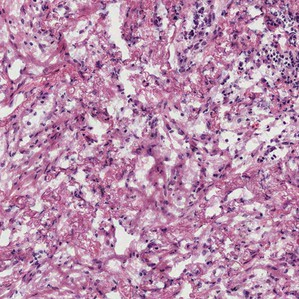

In [12]:
Image("/home/bcliffor/tmp/j2.jpg")

In [ ]:
Image(join(tiling, 
  'px299/heatmaps/heatmap_CancerType_test_TCGA-NC-A5HR-01A-02-TS2.1B2A21A9-E685-461D-A3FF-42A0D9D7FC23_TCGA-LUSC.jpg'))



# Generate ROC curve data

In [9]:
try:
    os.mkdir(roc_curves)
except:
    pass

function = join(deeppath_code, '03_postprocessing/0h_ROC_MultiOutput_BootStrap.py')
root = function.rsplit('/',1)[1].split('.')[0]

file_stats = join(test_results, 'out_filename_Stats.txt')
!python $function  --file_stats=$file_stats --output_dir=$roc_curves  --labels_names=$hugo_symbols_path \
    --ref_stats=''



DEBUG:
123907
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
123907
[[0.12360078 0.45603293 0.27976966 ... 0.14261308 0.13428485 0.624903  ]
 [0.22959703 0.04028478 0.13573992 ... 0.01772705 0.27107644 0.28194022]
 [0.16719195 0.08152965 0.44461897 ... 0.05313322 0.02481815 0.29360414]
 ...
 [0.03063962 0.16208029 0.02026311 ... 0.00974926 0.5687011  0.04259276]
 [0.00869015 0.179678   0.01802507 ... 0.01322573 0.61355925 0.00470623]
 [0.0341638  0.7314836  0.03733882 ... 0.00669071 0.8765054  0.04443452]]
123907
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[0. 0. 0. ... 0. 0. 0.] [0.12360078 0.22959703 0.16719195 ... 0.03063962 0.00869015 0.0341638 ] [0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.12360078 0.22959703 0.16719195 ... 0.03063962 0.00869015 0.0341638 ]


******* FP / TP for percent selected
{0: array([0.        , 0.07286633, 1.        ]), 1: array([0.        , 0.04138929, 1.        ]), 2: array([0.        , 0.04305948, 1.        ]), 3: array([0.        , 0.02945579, 1.        ]), 4: array([0.        , 0.11603728, 1.        ]), 5: array([0.        , 0.19442071, 1.        ]), 6: array([0.        , 0.02422228, 1.        ]), 7: array([0.        , 0.01877223, 1.        ]), 8: array([0.        , 0.03504968, 1.        ]), 9: array([0.        , 0.39781884, 1.        ]), 'macro': array([0.        , 0.01877223, 0.02422228, 0.02945579, 0.03504968,
       0.04138929, 0.04305948, 0.07286633, 0.11603728, 0.19442071,
       0.39781884, 1.        ]), 'micro': array([0.        , 0.07897091, 1.        ])}
{0: array([0.        , 0.11243345, 1.        ]), 1: array([0.        , 0.01221964, 1.        ]), 2: array([0.        , 0.06487793, 1.        ]), 3: array([0.        , 0.03393576, 1.        ]), 4: array([0.        , 0.09633477, 1.        ]), 5: array([0

0.346031746031746
0.6231435643564356
Confidence interval for the score: [0.346 - 0.623]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.]
[0.20650883 0.09150949 0.33132609 0.09019743 0.12375225 0.26627027
 0.1508883  0.36613784 0.06301545 0.12371436 0.30976267 0.16367999
 0.15288538 0.15788587 0.18492072 0.23478542 0.65657749 0.27147274
 0.06962692 0.1569554  0.36758215 0.09596379 0.27092627 0.01771367
 0.15168449 0.23924101 0.23879938 0.07830307 0.31124176 0.18209437
 0.19023226 0.1750389  0.16009734 0.1765595  0.26955736 0.11822071
 0.09730593 0.13339286 0.14163945 0.31464062 0.2442975  0.30955705
 0.01220315 0.21736151 0.13334568 0.12375701 0.13076075 0.3385259
 0.13056945 0.102908

0.39173913043478265
0.6729879740980573
Confidence interval for the score: [0.392 - 0.673]
[0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
[0.12121212 0.10047847 0.06329114 0.35491071 0.04285714 0.03167421
 0.09443099 0.07853637 0.06031746 0.16346154 0.00623269 0.01923077
 0.23397762 0.22884882 0.18612818 0.02476516 0.02560647 0.12082671
 0.66873449 0.30769231 0.0015748  0.00177462 0.06603774 0.00126422
 0.01410935 0.02403846 0.21428571 0.56730769 0.32102273 0.23060109
 0.04795991 0.35154394 0.03295455 0.04548387 0.         0.51977401
 0.28409091 0.02766798 0.21061947 0.01818629 0.02411765 0.09090909
 0.00381316 0.12132353 0.06770833 0.14516129 0.15384615 0.04689864
 0.01257862 0.090

0.4014336917562724
0.6794258373205742
Confidence interval for the score: [0.401 - 0.679]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0.12201863 0.03404547 0.35480504 0.12670434 0.03025061 0.10947427
 0.10288379 0.01842884 0.02786264 0.07867705 0.04479572 0.04540278
 0.08335484 0.02727605 0.1130535  0.439397   0.03125061 0.31017346
 0.23615088 0.16247722 0.16968008 0.11905526 0.13274846 0.00918072
 0.04196566 0.10418805 0.06162455 0.12283204 0.01520883 0.0084075
 0.10503008 0.03544306 0.0613114  0.07083667 0.05119744 0.1122107
 0.01046987 0.1236725  0.07481319 0.10526616 0.09661186 0.16802033
 0.01714818 0.23130913 0.03694158 0.12390181 0.01723303 0.49109287
 0.05831394 0.103694

0.4213909994155465
0.6338398597311513
Confidence interval for the score: [0.421 - 0.634]
[1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0.]
[0.66666667 0.32535885 0.36708861 0.37946429 0.22857143 0.58823529
 0.54237288 0.43105756 0.11746032 0.64615385 0.7465374  0.67307692
 0.29399797 0.18862691 0.48200176 0.43296328 0.34770889 0.50874404
 0.05252275 0.35502959 0.78740157 0.63176575 0.37735849 0.00758534
 0.05878895 0.6328125  0.60714286 0.15384615 0.65056818 0.25027322
 0.18396564 0.5023753  0.81477273 0.55516129 0.77005348 0.29039548
 0.23863636 0.75889328 0.48318584 0.5930204  0.58411765 0.33766234
 0.02097235 0.14926471 0.80208333 0.66129032 0.38461538 0.10892587
 0.35974843 0.2256

{0: array([0.        , 0.00980392, 0.00980392, 0.01960784, 0.01960784,
       0.02941176, 0.02941176, 0.08823529, 0.08823529, 0.19607843,
       0.19607843, 0.33333333, 0.33333333, 0.34313725, 0.34313725,
       0.45098039, 0.45098039, 0.50980392, 0.50980392, 0.74509804,
       0.74509804, 0.81372549, 0.81372549, 0.83333333, 1.        ]), 1: array([0.        , 0.01041667, 0.02083333, 0.02083333, 0.08333333,
       0.08333333, 0.125     , 0.125     , 0.23958333, 0.23958333,
       0.3125    , 0.3125    , 0.33333333, 0.33333333, 0.42708333,
       0.42708333, 0.47916667, 0.47916667, 0.57291667, 0.57291667,
       0.70833333, 1.        ]), 2: array([0.        , 0.01123596, 0.02247191, 0.02247191, 0.07865169,
       0.07865169, 0.08988764, 0.08988764, 0.11235955, 0.11235955,
       0.15730337, 0.15730337, 0.20224719, 0.20224719, 0.21348315,
       0.2247191 , 0.3258427 , 0.3258427 , 0.33707865, 0.33707865,
       0.37078652, 0.37078652, 0.41573034, 0.41573034, 0.43820225,
       0.43820225

## Optionally save training results to GCS

In [31]:
import tarfile

# Populate the tar file
# Note we don't save validation results.
loc = join(training,'data.tar.gz')
with tarfile.open(loc, "w:gz") as tar:
    for name in [intermediate_checkpoints, training_logs,  roc_curves,  test_results, heatmaps]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket,tiling_params, sorting_params, training_params, 'data.tar.gz')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

Copying file:///mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/data.tar.gz [Content-Type=application/x-tar]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1/1 files][  2.2 GiB/  2.2 GiB] 100% Done  62.3 MiB/s ETA 00:00:00           
Operation completed over 1 objects/2.2 GiB.                                      


# Display ROC Curves

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
lw=2
def draw_rocs(roc_base):
    plt.figure()
    #colors = cycle(['deeppink', 'navy', 'aqua', 'darkorange', 'cornflowerblue'])
    colors = cycle(['deeppink', 'navy', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'])
    lws = [4, 4, 2, 2, 2, 2, 2, 2 ,2 ,2 ,2 ,2]
    curves = ['micro', 'macro', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
    linestyles = [':', ':', '-', '-', '-', '-', '-', '-', '-', '-', '-']
    for curve, color, lw, linestyle in zip(curves, colors, lws, linestyles):
        f = [x for x in os.listdir(roc_curves) if x.find(roc_base + curve)==0][0]
        lines = np.loadtxt(join(roc_curves,f), comments="#", delimiter="\t", unpack=True)
        plt.plot(lines[0], lines[1], color = color, lw=lw, linestyle=linestyle,
             label = '{0} ROC curve (area = {1:0.2f})'.format(curve,float(f[f.find('auc_')+4:f.find('auc_')+10])))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()


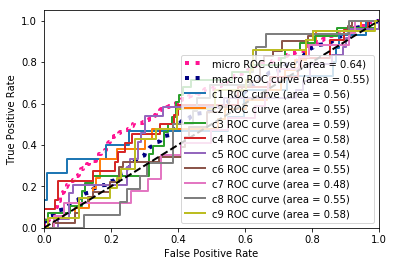

In [18]:
roc_base = 'out2_roc_data_AvPb_'
draw_rocs(roc_base)



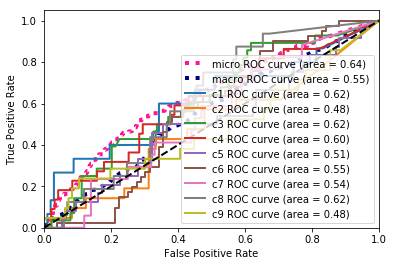

In [19]:
roc_base = 'out2_roc_data_PcSel_'
draw_rocs(roc_base)
